Import libraries

In [1]:
import ensembl_rest
from Bio import Entrez,SeqIO,AlignIO,SeqFeature, Align, pairwise2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
import pickle
import pprint
import mygene
from itertools import chain
#from skbio import alignment
import requests
import pandas as pd
import biomart
import re
import random
from urllib import request
import json
from scipy.stats import zscore
from scipy import stats
from sklearn.cluster import KMeans

import the list of TFs

In [2]:
with open("TFs_Ensembl_v_1.01.txt", "r") as f:
    TFs = [line.strip() for line in f.readlines()]

In [3]:
with open("2018-07-11_tf_families_table_w_transfac.tsv") as f:
    TFs_df = pd.read_table(f)
TFs = TFs_df["ensg"].to_list()

get the sequences for the TFs

In [4]:
seqs = {}
for TF in TFs:
    try:
        isoforms = ensembl_rest.lookup(TF,
                                       params={'multiple_sequences': True,
                                               'type': 'protein',
                                               'expand':True
                                              }
                                      )
        seqs[TF] = {}
        for iso in isoforms['Transcript']:
            if iso['biotype']!="protein_coding":
                continue
            seq = ensembl_rest.sequence_id(iso['Translation']['id'])['seq']
            seqs[TF][iso['Translation']['id']] = {'seq': seq}
    except ensembl_rest.HTTPError as err:
        error_code = err.response.status_code
        error_message= err.response.json()['error']
        if(error_code==400) and ("not found" in error_message):
            print(TF + " not found")
        elif(error_code==400) and ("No sequences returned" in error_message):
            print(TF + " no protein sequences found")
        else:
            raise



ENSG00000259128 not found
ENSG00000259034 not found
ENSG00000259063 not found
ENSG00000258697 not found
ENSG00000277706 not found
ENSG00000215271 not found
ENSG00000278500 not found
ENSG00000269905 not found


Get some info about isoforms

Number of proteins with found isoforms: 1573
Average number of isoforms per gene: 4.868404322949777


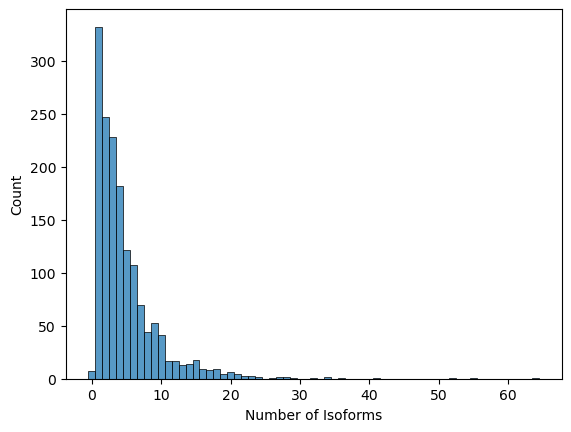

In [5]:
num_isoforms = np.array([len(isos) for isos in seqs.values()])
print("Number of proteins with found isoforms: " + str(len(seqs)))
aveisos = np.sum(num_isoforms)/len(seqs)
print("Average number of isoforms per gene: " + str(aveisos))
sns.histplot(num_isoforms, discrete=True).set(xlabel="Number of Isoforms");

Get and count the number of protein coding transcripts per human gene

Average number of isoforms per gene: 4.352397230256814
4.352397230256814
5.168844001519821
0.11338922373296334


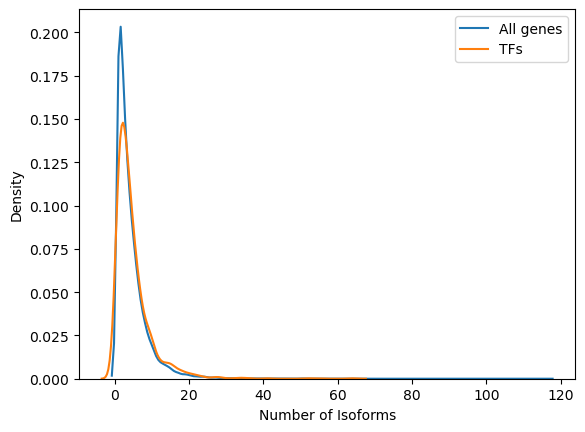

In [14]:
ensembl_rest.info_genome('homo sapiens', params={'expand':True})
all_genes_transcript_counts = {}

with open("all_human_transcripts.txt", "r") as f:
    for line in f.readlines():
        spltln = line.split("\t")
        if spltln[1] not in all_genes_transcript_counts:
            all_genes_transcript_counts[spltln[1]]=1
        else:
            all_genes_transcript_counts[spltln[1]]+=1
all_genes_transcript_counts_values = np.array(list(all_genes_transcript_counts.values()))
print("Average number of isoforms per gene: " + str(sum(all_genes_transcript_counts_values)/len(all_genes_transcript_counts_values)))
sns.kdeplot(np.array(all_genes_transcript_counts_values), label="All genes")
sns.kdeplot(num_isoforms, label="TFs").set(xlabel="Number of Isoforms")
plt.pyplot.legend();
print(np.mean(all_genes_transcript_counts_values))
print(np.std(num_isoforms))
print((np.mean(num_isoforms)-np.mean(all_genes_transcript_counts_values))/np.std(all_genes_transcript_counts_values))

Identify the domains in the isoforms

In [9]:
i=0
for gene_id in seqs:
    #if i==1:
    #    break
    #print(seqs[gene_id])
    for prot_id in seqs[gene_id]:
        results = ensembl_rest.overlap_translation(prot_id, 
                                                   type="domain")
        seqs[gene_id][prot_id]["domains"] = [res for res in results]
    i+=1

Get Uniprot IDs

In [3]:
mg = mygene.MyGeneInfo()
for gene_id in seqs:
    get_gene_result = mg.getgene(gene_id)
    if get_gene_result is not None and "uniprot" in get_gene_result:
        seqs[gene_id]["uniprot"] = get_gene_result["uniprot"]
#these are missing for some reason
seqs["ENSG00000106331"]["uniprot"] = {'Swiss-Prot':"O43316"}
seqs["ENSG00000185670"]["uniprot"] = {'Swiss-Prot':"Q9H5J0"}
seqs["ENSG00000225614"]["uniprot"] = {'Swiss-Prot':"Q96JG9"}
seqs["ENSG00000243660"]["uniprot"] = {'Swiss-Prot':"B1APH4"}
seqs["ENSG00000189144"]["uniprot"] = {'Swiss-Prot':"Q86YE8"}
seqs["ENSG00000258834"]["uniprot"] = {'Swiss-Prot':"Q9HBT8"}
seqs["ENSG00000255104"]["uniprot"] = {'Swiss-Prot':"P0CG31"}
seqs["ENSG00000249459"]["uniprot"] = {'Swiss-Prot':"P0CG31"}
seqs["ENSG00000175105"]["uniprot"] = {'Swiss-Prot':"Q8IZM8"}
seqs["ENSG00000160229"]["uniprot"] = {'Swiss-Prot':"Q6ZN08"}
seqs["ENSG00000135747"]["uniprot"] = {'Swiss-Prot':"Q9BS34"}
seqs["ENSG00000181450"]["uniprot"] = {'Swiss-Prot':"Q5SXM1"}
seqs["ENSG00000196826"]["uniprot"] = {'Swiss-Prot':"Q8N972"}
seqs["ENSG00000196081"]["uniprot"] = {'Swiss-Prot':"A8MTY0"}
seqs["ENSG00000196381"]["uniprot"] = {'Swiss-Prot':"Q8N8C0"}
seqs["ENSG00000224689"]["uniprot"] = {'Swiss-Prot':"P0C7V5"}
seqs["ENSG00000204532"]["uniprot"] = {'Swiss-Prot':"A6NGD5"}
seqs["ENSG00000267908"]["uniprot"] = {'Swiss-Prot':"P0CG00"}


In [40]:
mg = mygene.MyGeneInfo()
for gene_id in seqs:
    for prot_id in seqs[gene_id]:
        print(prot_id)
        get_gene_result = mg.query(f"q=ensembl.protein:{prot_id}")
        print(get_gene_result)
        if get_gene_result is not None and "uniprot" in get_gene_result:
            print(get_gene_result["uniprot"])
#these are missing for some reason
seqs["ENSG00000106331"]["uniprot"] = {'Swiss-Prot':"O43316"}
seqs["ENSG00000185670"]["uniprot"] = {'Swiss-Prot':"Q9H5J0"}
seqs["ENSG00000225614"]["uniprot"] = {'Swiss-Prot':"Q96JG9"}
seqs["ENSG00000243660"]["uniprot"] = {'Swiss-Prot':"B1APH4"}
seqs["ENSG00000189144"]["uniprot"] = {'Swiss-Prot':"Q86YE8"}
seqs["ENSG00000258834"]["uniprot"] = {'Swiss-Prot':"Q9HBT8"}
seqs["ENSG00000255104"]["uniprot"] = {'Swiss-Prot':"P0CG31"}
seqs["ENSG00000249459"]["uniprot"] = {'Swiss-Prot':"P0CG31"}
seqs["ENSG00000175105"]["uniprot"] = {'Swiss-Prot':"Q8IZM8"}
seqs["ENSG00000160229"]["uniprot"] = {'Swiss-Prot':"Q6ZN08"}
seqs["ENSG00000135747"]["uniprot"] = {'Swiss-Prot':"Q9BS34"}
seqs["ENSG00000181450"]["uniprot"] = {'Swiss-Prot':"Q5SXM1"}
seqs["ENSG00000196826"]["uniprot"] = {'Swiss-Prot':"Q8N972"}
seqs["ENSG00000196081"]["uniprot"] = {'Swiss-Prot':"A8MTY0"}
seqs["ENSG00000196381"]["uniprot"] = {'Swiss-Prot':"Q8N8C0"}
seqs["ENSG00000224689"]["uniprot"] = {'Swiss-Prot':"P0C7V5"}
seqs["ENSG00000204532"]["uniprot"] = {'Swiss-Prot':"A6NGD5"}
seqs["ENSG00000267908"]["uniprot"] = {'Swiss-Prot':"P0CG00"}


ENSP00000360662
{'took': 0, 'total': 0, 'max_score': None, 'hits': []}
ENSP00000483881
{'took': 0, 'total': 0, 'max_score': None, 'hits': []}
ENSP00000501294
{'took': 0, 'total': 0, 'max_score': None, 'hits': []}
ENSP00000493755
{'took': 0, 'total': 0, 'max_score': None, 'hits': []}
ENSP00000379346
{'took': 0, 'total': 0, 'max_score': None, 'hits': []}
ENSP00000379349
{'took': 0, 'total': 0, 'max_score': None, 'hits': []}
ENSP00000342905
{'took': 1, 'total': 0, 'max_score': None, 'hits': []}
ENSP00000495540
{'took': 0, 'total': 0, 'max_score': None, 'hits': []}
uniprot
{'took': 0, 'total': 0, 'max_score': None, 'hits': []}
ENSP00000262198
{'took': 0, 'total': 0, 'max_score': None, 'hits': []}
ENSP00000453418
{'took': 0, 'total': 0, 'max_score': None, 'hits': []}
ENSP00000453275
{'took': 0, 'total': 0, 'max_score': None, 'hits': []}
ENSP00000468397
{'took': 0, 'total': 0, 'max_score': None, 'hits': []}
ENSP00000467370
{'took': 0, 'total': 0, 'max_score': None, 'hits': []}
uniprot
{'took

KeyboardInterrupt: 

In [4]:
with open("seqs.pickle", "wb") as f:
    pickle.dump(seqs, f)

In [2]:
with open("seqs.pickle", "rb") as f:
    seqs = pickle.load(f)

Interpro domain type counting and domain type classifying

2.1952077093371534
0.17801797108998568
0.021617398098710768
0.21169739351557534


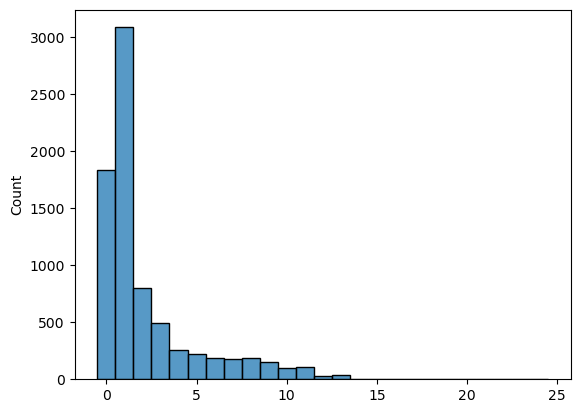

In [3]:
total_domains = 0
total_isoforms = 0
domain_type_counts = {}
isoforms_with_DNAbinding = 0
isoforms_with_PPI = 0
genes_with_DNAbinding = 0
geneList_DNAbinding = []
domain_counts = []
for gene_id in seqs:
    if len(seqs[gene_id])<=1:
        continue
    if 'Swiss-Prot' in seqs[gene_id]["uniprot"]:
        uniprot_id = seqs[gene_id]["uniprot"]['Swiss-Prot']
        if type(uniprot_id)!=str:
            uniprot_id = uniprot_id[0]
    else:
        #print(seqs[gene_id]["uniprot"])
        uniprot_id = seqs[gene_id]["uniprot"]['TrEMBL']
    if type(uniprot_id)==list:
        uniprot_id = uniprot_id[0]
    interpro_url = f"https://www.ebi.ac.uk:443/interpro/api/entry/InterPro/protein/UniProt/{uniprot_id}/?page_size=200"
    req = request.Request(interpro_url, headers = {"Accept": "application/json"})
    res = request.urlopen(req)
    json_res = json.loads(res.read().decode())
    interpro_domains = {domain['metadata']['accession']:domain for domain in json_res['results'] 
                        if 'ssf' in domain['metadata']['member_databases']}
    for prot_id in seqs[gene_id]:
        if not prot_id.startswith("ENS"):
            continue
        total_isoforms+=1
        domain_counts.append(0)
        for domain in seqs[gene_id][prot_id]["domains"]:
            if domain['interpro'] not in interpro_domains or domain['type']!='SuperFamily':
                continue
            total_domains+=1
            domain_counts[-1]+=1
            if domain['description'] in domain_type_counts:
                domain_type_counts[domain['description']]+=1
            else:
                domain_type_counts[domain['description']]=1
            is_ppi = False
            if interpro_domains[domain['interpro']]['metadata']['go_terms'] is not None:
                for go_term in interpro_domains[domain['interpro']]['metadata']['go_terms']:
                    if go_term['name']=='protein binding':
                        is_ppi = True
            if is_ppi:
                domain['class'] = "PPI"
                isoforms_with_PPI+=1
                break
        for domain in seqs[gene_id][prot_id]["domains"]:
            if domain['type']!='SuperFamily':
                continue
            if "DNA-binding" in domain['description']:
                isoforms_with_DNAbinding+=1
                domain['class'] = "DNA"
                break
        for domain in seqs[gene_id][prot_id]["domains"]:
            if 'class' not in domain:
                domain['class'] = "Other"
    has_DNA = False
    for prot_id in seqs[gene_id]:
        if not prot_id.startswith("ENS"):
            continue
        for domain in seqs[gene_id][prot_id]["domains"]:
            if domain['type']!="SuperFamily":
                continue
            if "DNA-binding" in domain['description']:
                has_DNA = True
                break
    if has_DNA:
        genes_with_DNAbinding += 1
        geneList_DNAbinding.append(gene_id)
print(total_domains/total_isoforms)
sns.histplot(domain_counts, discrete=True);
#print(domain_type_counts)
print(isoforms_with_DNAbinding/total_isoforms)
print(isoforms_with_PPI/total_isoforms)
print(genes_with_DNAbinding/len(seqs))

Get descriptions for manual curation of DNA-binding domains on Nov 27, 2023

In [27]:
interpro_superfamily_domains = pd.DataFrame(columns=["Name","Description"])
for gene_id in seqs:
    if len(seqs[gene_id])<=1:
        continue
    for prot_id in seqs[gene_id]:
        if not prot_id.startswith("ENS"):
            continue
        for domain in seqs[gene_id][prot_id]['domains']:
            if domain['interpro']=='' or domain['type']!='SuperFamily':
                continue
            #print(interpro_domains[domain['interpro']])
            if domain['interpro'] in interpro_superfamily_domains.index:
                continue
            interpro_url = f"https://www.ebi.ac.uk:443/interpro/api/entry/InterPro/{domain['interpro']}/?page_size=200"
            req = request.Request(interpro_url, headers = {"Accept": "application/json"})
            res = request.urlopen(req)
            json_res = json.loads(res.read().decode())
            #print(json_res)
            accession = json_res['metadata']['accession']
            name = json_res['metadata']['name']['name']
            description = ' '.join(json_res['metadata']['description'])
            #print([accession, name, description])
            interpro_superfamily_domains.loc[accession] = [name, description]
    #break
print(interpro_superfamily_domains)

                                                        Name  \
IPR009057                   Homeobox-like domain superfamily   
IPR036236                       Zinc finger C2H2 superfamily   
IPR036638    Helix-loop-helix DNA-binding domain superfamily   
IPR035965                             PAS domain superfamily   
IPR011011                         Zinc finger, FYVE/PHD-type   
...                                                      ...   
IPR036792  Aspartate carbamoyltransferase regulatory subu...   
IPR036875                 Zinc finger, CCHC-type superfamily   
IPR035896                               AN1-like Zinc finger   
IPR038765         Papain-like cysteine peptidase superfamily   
IPR008981                            F-MuLV receptor-binding   

                                                 Description  
IPR009057  <p>Homeobox domain (also known as homeodomain)...  
IPR036236  <p>C2H2-type (classical) zinc fingers (ZnF) we...  
IPR036638  <p>This domain is found in a nu

In [24]:
interpro_superfamily_domains.to_csv("interpro_superfamily_domains.tsv", sep="\t")

In [29]:
interpro_superfamily_domains_DBD = pd.read_csv("interpro_superfamily_domains_DBD.tsv", sep='\t', index_col=0)
print(interpro_superfamily_domains_DBD)

                                                        Name  \
IPR009057                   Homeobox-like domain superfamily   
IPR036236                       Zinc finger C2H2 superfamily   
IPR036638    Helix-loop-helix DNA-binding domain superfamily   
IPR035965                             PAS domain superfamily   
IPR011011                         Zinc finger, FYVE/PHD-type   
...                                                      ...   
IPR036792  Aspartate carbamoyltransferase regulatory subu...   
IPR036875                 Zinc finger, CCHC-type superfamily   
IPR035896                               AN1-like Zinc finger   
IPR038765         Papain-like cysteine peptidase superfamily   
IPR008981                            F-MuLV receptor-binding   

                                                 Description  DNA-binding  
IPR009057  <p>Homeobox domain (also known as homeodomain)...         True  
IPR036236  <p>C2H2-type (classical) zinc fingers (ZnF) we...         True  
IPR

2.2246386248209404
0.6328949081911708
0.021617398098710768
0.8944691671964399


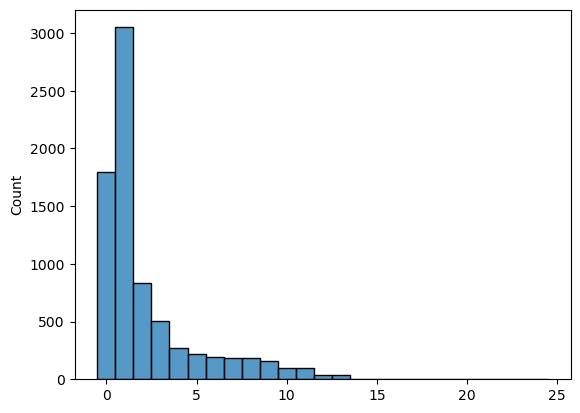

In [46]:
total_domains = 0
total_isoforms = 0
domain_type_counts = {}
isoforms_with_DNAbinding = 0
isoforms_with_PPI = 0
genes_with_DNAbinding = 0
geneList_DNAbinding = []
domain_counts = []
for gene_id in seqs:
    if len(seqs[gene_id])<=1:
        continue
    if 'Swiss-Prot' in seqs[gene_id]["uniprot"]:
        uniprot_id = seqs[gene_id]["uniprot"]['Swiss-Prot']
        if type(uniprot_id)!=str:
            uniprot_id = uniprot_id[0]
    else:
        #print(seqs[gene_id]["uniprot"])
        uniprot_id = seqs[gene_id]["uniprot"]['TrEMBL']
    if type(uniprot_id)==list:
        uniprot_id = uniprot_id[0]
    interpro_url = f"https://www.ebi.ac.uk:443/interpro/api/entry/InterPro/protein/UniProt/{uniprot_id}/?page_size=200"
    req = request.Request(interpro_url, headers = {"Accept": "application/json"})
    res = request.urlopen(req)
    json_res = json.loads(res.read().decode())
    interpro_domains = {domain['metadata']['accession']:domain for domain in json_res['results'] 
                        if 'ssf' in domain['metadata']['member_databases']}
    for prot_id in seqs[gene_id]:
        if not prot_id.startswith("ENS"):
            continue
        total_isoforms+=1
        domain_counts.append(0)
        for domain in seqs[gene_id][prot_id]["domains"]:
            if domain['interpro']=='' or domain['type']!='SuperFamily':
                continue
            total_domains+=1
            domain_counts[-1]+=1
            if domain['interpro'] in domain_type_counts:
                domain_type_counts[domain['interpro']]+=1
            else:
                domain_type_counts[domain['interpro']]=1
            is_ppi = False
            if domain['interpro'] in interpro_domains and \
               interpro_domains[domain['interpro']]['metadata']['go_terms'] is not None:
                for go_term in interpro_domains[domain['interpro']]['metadata']['go_terms']:
                    if go_term['name']=='protein binding':
                        is_ppi = True
            domain['PPI'] = is_ppi
        for domain in seqs[gene_id][prot_id]["domains"]:
            if domain['interpro']=='' or domain['type']!='SuperFamily':
                continue
            domain['DNA-binding'] = interpro_superfamily_domains_DBD.loc[domain['interpro'],"DNA-binding"]
        has_DNAbinding = False
        has_PPI = False
        for domain in seqs[gene_id][prot_id]["domains"]:
            if domain['interpro']=='' or domain['type']!='SuperFamily':
                continue
            if domain['DNA-binding']:
                has_DNAbinding = True
            if domain['PPI']:
                has_PPI = True
        if has_DNAbinding:
            isoforms_with_DNAbinding += 1
        if has_PPI:
            isoforms_with_PPI += 1
    has_DNA = False
    for prot_id in seqs[gene_id]:
        if not prot_id.startswith("ENS"):
            continue
        for domain in seqs[gene_id][prot_id]["domains"]:
            if domain['interpro']=='' or domain['type']!="SuperFamily":
                continue
            if domain["DNA-binding"]:
                has_DNA = True
                break
    if has_DNA:
        genes_with_DNAbinding += 1
        geneList_DNAbinding.append(gene_id)
print(total_domains/total_isoforms)
sns.histplot(domain_counts, discrete=True);
#print(domain_type_counts)
print(isoforms_with_DNAbinding/total_isoforms)
print(isoforms_with_PPI/total_isoforms)
print(genes_with_DNAbinding/len(seqs))

Dealing with only the genes with a DNA binding isoform

In [47]:
DNAbinding_seqs = {seq:seqs[seq] for seq in seqs 
                   if seq in geneList_DNAbinding}
len(DNAbinding_seqs)

1407

Get the refseq ids of each protein

In [5]:
server = biomart.BiomartServer('http://useast.ensembl.org/biomart')
mart = server.datasets['hsapiens_gene_ensembl']
#mart.show_filters()
attributes = ['refseq_peptide']
#for gene_id in DNAbinding_seqs:
for gene_id in DNAbinding_seqs:
    print(gene_id)
    for prot_id in DNAbinding_seqs[gene_id]:
        if not prot_id.startswith("ENS") or 'refseq_id' in DNAbinding_seqs[gene_id][prot_id]: continue
        response = mart.search({'attributes': attributes, 
                        'filters': {'ensembl_peptide_id': prot_id}
                       })
        data = response.raw.data.decode('ascii')
        print(prot_id)
        print(data.strip())
        DNAbinding_seqs[gene_id][prot_id]['refseq_id'] = data.strip()

ENSG00000101126
ENSG00000101544
ENSG00000139154
ENSG00000106546
ENSG00000063438
ENSG00000180318
ENSG00000156150
ENSG00000052850
ENSG00000169083
ENSG00000186103
ENSG00000117713
ENSG00000049618
ENSG00000189079
ENSG00000116017
ENSG00000179361
ENSG00000205143
ENSG00000032219
ENSG00000054267
ENSG00000196843
ENSG00000150347
ENSG00000143437
ENSG00000172379
ENSG00000133794
ENSG00000029153
ENSG00000004848
ENSG00000139352
ENSG00000183734
ENSG00000176009
ENSG00000187855
ENSG00000232237
ENSG00000123268
ENSG00000115966
ENSG00000162772
ENSG00000128272
ENSG00000169136
ENSG00000118217
ENSG00000213676
ENSG00000170653
ENSG00000172238
ENSG00000179774
ENSG00000168874
ENSG00000156273
ENSG00000112182
ENSG00000125492
ENSG00000143032
ENSG00000131668
ENSG00000043039
ENSG00000156127
ENSG00000168062
ENSG00000123685
ENSG00000114439
ENSG00000119866
ENSG00000127152
ENSG00000113916
ENSG00000161940
ENSG00000180535
ENSG00000205899
ENSG00000180828
ENSG00000125533
ENSG00000134107
ENSG00000123095
ENSG00000169594
ENSG0000

Remove redundancy in the overlapping domains in a gene from different isoforms

In [21]:
#this is based on SuperFamily and Pfam as first and second, respectively, and the rest sorted 
#by frequency in database
#sourcePriority = ['SuperFamily', 'Pfam', 'MobiDBLite', 'Seg', 'sifts', 'PANTHER', 
#                  'Gene3D', 'PRINTS', 'Smart', 'Prosite_profiles', 'CDD', 'Prosite_patterns', 
#                  'ncoils', 'alphafold', 'PIRSF', 'TIGRfam', 'TMHMM', 'SignalP']
for gene_id in ["ENSG00000185507"]:
#for gene_id in DNAbinding_seqs:
    print(gene_id)
    keeping_domains = []
    for classification in ["DNA"]:#, "PPI"]:
        domain_queue = []
        for prot_id in DNAbinding_seqs[gene_id]:
            if not prot_id.startswith("ENS"):
                continue
            if "refseq_id" not in DNAbinding_seqs[gene_id][prot_id]:
                continue
            domain_queue += [domain for domain in DNAbinding_seqs[gene_id][prot_id]['domains'] 
                            #if domain['class']==classification and \
                             if domain['type']=='SuperFamily']
        print("domain_queue:")
        print(domain_queue)
        while len(domain_queue)>0:
            currDomain = domain_queue.pop()
            removeList = []
            for i, domain in enumerate(domain_queue):
                if (currDomain['start'] <= domain['start'] and 
                currDomain['end'] >= domain['start']) or \
                (currDomain['start'] <= domain['end'] and
                currDomain['end'] >= domain['end']) or \
                (currDomain['start'] >= domain['start'] and
                currDomain['end'] <= domain['end']):
                    if currDomain['end']-currDomain['start'] < domain['end']-domain['start']:
                        currDomain = domain
                    removeList.append(i)
            for i in removeList[-1::-1]:
                del domain_queue[i]
            keeping_domains.append(currDomain)
    print("keeping_domains:")
    print(keeping_domains)
    for prot_id in DNAbinding_seqs[gene_id]:
        if prot_id.startswith("ENS"):
            DNAbinding_seqs[gene_id][prot_id]['filtered_domains'] = \
              [domain for domain in keeping_domains if domain['seq_region_name']==prot_id]
print(DNAbinding_seqs[gene_id]["ENSP00000329411"]['filtered_domains'])

ENSG00000185507
domain_queue:
[{'Parent': 'ENST00000397566', 'align_type': None, 'id': 'SSF46785', 'hseqname': 'SSF46785', 'start': 24, 'end': 138, 'interpro': 'IPR036390', 'seq_region_name': 'ENSP00000380697', 'cigar_string': '', 'feature_type': 'protein_feature', 'hit_start': 0, 'description': 'Winged helix DNA-binding domain superfamily', 'translation_id': 1169934, 'type': 'SuperFamily', 'hit_end': 0, 'PPI': False, 'DNA-binding': True}, {'hit_end': 0, 'translation_id': 1169934, 'type': 'SuperFamily', 'description': 'SMAD/FHA domain superfamily', 'feature_type': 'protein_feature', 'hit_start': 0, 'seq_region_name': 'ENSP00000380697', 'interpro': 'IPR008984', 'cigar_string': '', 'end': 493, 'start': 297, 'hseqname': 'SSF49879', 'id': 'SSF49879', 'align_type': None, 'Parent': 'ENST00000397566', 'PPI': True, 'DNA-binding': False}, {'align_type': None, 'Parent': 'ENST00000348655', 'hseqname': 'SSF46785', 'id': 'SSF46785', 'end': 125, 'start': 11, 'description': 'Winged helix DNA-binding 

Get all isoforms of gene in fasta

In [28]:
gene_id = "ENSG00000126456"
prot_ids = list(DNAbinding_seqs[gene_id].keys())
print(prot_ids)
for prot_id in prot_ids:
    if not prot_id.startswith("ENS"): continue
    with open(gene_id + "/" + prot_id + ".fa", "w") as f:
        f.write(">" + prot_id + "\n")
        f.write(DNAbinding_seqs[gene_id][prot_id]['seq'] + "\n")

['ENSP00000366339', 'ENSP00000310127', 'ENSP00000470431', 'ENSP00000468911', 'ENSP00000471896', 'ENSP00000366344', 'ENSP00000469113', 'ENSP00000472601', 'ENSP00000470512', 'ENSP00000471358', 'ENSP00000472700', 'ENSP00000470069', 'ENSP00000472582', 'ENSP00000473128', 'ENSP00000472223', 'ENSP00000469067', 'ENSP00000471517', 'ENSP00000471402', 'ENSP00000473176', 'ENSP00000470140', 'ENSP00000400378', 'ENSP00000470905', 'uniprot']


Add the DNA binding sites for case-study

In [ ]:
gene_id = "ENSG00000126456"
prot_id = "ENSP00000471358"
seq = DNAbinding_seqs[gene_id][prot_id]['seq']
binding_site = SeqFeature.FeatureLocation(37,38) + \
               SeqFeature.FeatureLocation(39,42) + \
               SeqFeature.FeatureLocation(73,74) + \
               SeqFeature.FeatureLocation(76,78) + \
               SeqFeature.FeatureLocation(80,81) + \
               SeqFeature.FeatureLocation(85,86) + \
               SeqFeature.FeatureLocation(104,105)
DNAbinding_seqs[gene_id][prot_id]['binding_sites'] = [(binding_site, 'DNA')]
gene_id = "ENSG00000185507"
prot_id = "ENSP00000329411"
seq = DNAbinding_seqs[gene_id][prot_id]['seq']
binding_site = SeqFeature.FeatureLocation(56,57) + \
               SeqFeature.FeatureLocation(58,61) + \
               SeqFeature.FeatureLocation(101,102) + \
               SeqFeature.FeatureLocation(104,105) + \
               SeqFeature.FeatureLocation(108,109) + \
               SeqFeature.FeatureLocation(112,113) + \
               SeqFeature.FeatureLocation(132,133)
DNAbinding_seqs[gene_id][prot_id]['binding_sites'] = [(binding_site, 'DNA')]

print(binding_site.extract(seq))


Get "superisoform" based on CDS positions

In [35]:
mg = mygene.MyGeneInfo()

Entrez.email = "smadha@wpi.edu"
#irf3
#gene_id = "ENSG00000126456"
#irf7
#gene_id = "ENSG00000185507"
#nfkb
#gene_id = "ENSG00000109320"
#print(mg.getgene(gene_id)['genomic_pos'])
#for gene_id in ["ENSG00000185507"]:
for gene_id in DNAbinding_seqs:
    print(gene_id)
    #if 'superisoform' in DNAbinding_seqs[gene_id] and 'superdomains' in DNAbinding_seqs[gene_id]:
    #    continue
    gene_object = mg.getgene(gene_id)
    if gene_object is None:
        continue
    if type(gene_object) is list:
        gene_object = gene_object[0]
    if 'refseq' not in gene_object:
        continue
    if type(gene_object['genomic_pos']) is list:
        start_pos = gene_object['genomic_pos'][0]['start']
        end_pos = gene_object['genomic_pos'][0]['end']
        strand = gene_object['genomic_pos'][0]['strand']
    else:
        start_pos = gene_object['genomic_pos']['start']
        end_pos = gene_object['genomic_pos']['end']
        strand = gene_object['genomic_pos']['strand']
    handle = Entrez.efetch(db="nucleotide", 
                           id=gene_object['refseq']['genomic'][0],
                           seq_start=start_pos,
                           seq_stop=end_pos,
                           rettype="gb")
    record = SeqIO.read(handle, "gb")
    handle.close()
    reformed_exons = {}
    #print(mg.getgene(gene_id)['interpro'])
    symbol = gene_object["symbol"]

    for feature in record.features:
        if feature.type=="CDS" and symbol in feature.qualifiers['gene']:
            #print(feature)
            refseq_id = feature.qualifiers['protein_id'][0]
            for prot_id in DNAbinding_seqs[gene_id]:
                if "refseq_id" in DNAbinding_seqs[gene_id][prot_id] and \
                  DNAbinding_seqs[gene_id][prot_id]['refseq_id']!="" and \
                  re.search(DNAbinding_seqs[gene_id][prot_id]['refseq_id'], refseq_id) is not None:
                    #print(refseq_id)
                    #print(prot_id)
                    break
            these_domains = []
            if 'refseq_id' in DNAbinding_seqs[gene_id][prot_id] and \
              DNAbinding_seqs[gene_id][prot_id]['refseq_id']!="" and \
              re.search(DNAbinding_seqs[gene_id][prot_id]['refseq_id'], refseq_id):
                these_domains = DNAbinding_seqs[gene_id][prot_id]['filtered_domains']
            parts = enumerate(feature.location.parts)
            prepend_seq = ""
            exon_start = 0
            exon_end = 0
            #print(prot_id)
            #print(these_domains)
            for i, location in parts:
                exon_domains = {}
                tail_len = (len(prepend_seq)+len(location))%3
                if location.strand == 1:
                    this_location = SeqFeature.FeatureLocation(
                        location.start,
                        location.end-tail_len,
                        strand=location.strand)
                    next_location = SeqFeature.FeatureLocation(
                        location.end-tail_len, location.end, 
                        strand=location.strand)
                    this_seq = prepend_seq + this_location.extract(record)
                    exon_len = int(len(this_seq)/3)
                    exon_start = exon_end
                    exon_end = exon_start + exon_len
                    for domain in these_domains:
                        domain_start = None
                        domain_end = None
                        #domain in the exon
                        if domain['start'] > exon_start and \
                          domain['end'] < exon_end:
                            domain_start = domain['start']
                            domain_end = domain['end']
                        #domain starts in the exon, but ends after
                        elif domain['start'] > exon_start and \
                          domain['start'] < exon_end and \
                          domain['end'] > exon_end:
                            domain_start = domain['start']
                            domain_end = exon_end
                        #domain starts before exon, but ends in
                        elif domain['start'] < exon_start and \
                          domain['end'] > exon_start and \
                          domain['end'] < exon_end:
                            domain_start = exon_start
                            domain_end = domain['end']
                        #domain contains exon
                        elif domain['start'] < exon_start and \
                          domain['end'] > exon_end:
                            domain_start = exon_start
                            domain_end = exon_end
                        if domain_start is not None:
                            #print(domain)
                            #print(domain['start'], exon_start, domain_start, domain['start'] - exon_start)
                            #print(domain['end'], exon_end, domain_end, exon_end - domain['end'])
                            exon_domains[".".join([str(domain_start), 
                                                   str(domain_end),
                                                   str(max(domain['start'] - exon_start, 0)), 
                                                   str(max(exon_end - domain['end'], 0))])] = domain
                elif location.strand == -1:
                    this_location = SeqFeature.FeatureLocation(
                        location.start+tail_len,
                        location.end,
                        strand=location.strand)
                    next_location = SeqFeature.FeatureLocation(
                        location.start, location.start+tail_len, 
                        strand=location.strand)
                    this_seq =  prepend_seq + this_location.extract(record)
                    exon_len = int(len(this_seq)/3)
                    exon_start = exon_end
                    exon_end = exon_start + exon_len
                    for domain in these_domains:
                        domain_start = None
                        domain_end = None
                        #domain in the exon
                        if domain['start'] > exon_start and \
                          domain['end'] < exon_end:
                            domain_start = domain['start']
                            domain_end = domain['end']
                        #domain starts in the exon, but ends after
                        elif domain['start'] > exon_start and \
                          domain['start'] < exon_end and \
                          domain['end'] > exon_end:
                            domain_start = domain['start']
                            domain_end = exon_end
                        #domain starts before exon, but ends in
                        elif domain['start'] < exon_start and \
                          domain['end'] > exon_start and \
                          domain['end'] < exon_end:
                            domain_start = exon_start
                            domain_end = domain['end']
                        #domain contains exon
                        elif domain['start'] < exon_start and \
                          domain['end'] > exon_end:
                            domain_start = exon_start
                            domain_end = exon_end
                        if domain_start is not None:
                            #print(domain)
                            #print(domain['start'], exon_start, domain_start, domain['start'] - exon_start)
                            #print(domain['end'], exon_end, domain_end, exon_end - domain['end'])
                            exon_domains[".".join([str(domain_start).strip("<>"), 
                                                   str(domain_end).strip("<>"),
                                                   str(max(domain['start'] - exon_start, 0)).strip("<>"), 
                                                   str(max(exon_end - domain['end'], 0)).strip("<>")])] = domain
                exon_key = ".".join([str(location.start).strip("<>"), 
                                         str(location.end).strip("<>"),
                                         prepend_seq, 
                                         str(tail_len)])
                if not exon_key in reformed_exons:
                    reformed_exons[exon_key] = {'seq':this_seq.translate().seq, 'domains': exon_domains}
                else:
                    reformed_exons[exon_key]['domains'].update(exon_domains)
                prepend_seq = str(next_location.extract(record).seq)
                #if isinstance(location.start, SeqFeature.BeforePosition):
                    #print(location.start)
    #print(reformed_exons)
    tmp = [el.split(".") for el in list(reformed_exons.keys())]
    for el in tmp:
        el[0] = int(el[0])
        el[1] = int(el[1])
        el[3] = int(el[3])
    tmp.sort()
    for el in tmp:
        el[0] = str(el[0])
        el[1] = str(el[1])
        el[3] = str(el[3])
    tmp = [".".join(el) for el in tmp]
    superisoform = ""
    #print(tmp)
    if strand == -1:
        tmp = tmp[::-1]
    superdomains = {}
    for exon in tmp:
        if len(reformed_exons[exon]['domains'])>0:
            #print(reformed_exons[exon]['domains'])
            for domain in reformed_exons[exon]['domains']:
                domain_start = int(domain.split(".")[2]) + len(superisoform)
                domain_end = int(domain.split(".")[1]) - int(domain.split(".")[0]) + domain_start
                #print(reformed_exons[exon]['domains'][domain]['seq_region_name'], domain_start, domain_end)
                if str(reformed_exons[exon]['domains'][domain]) not in superdomains:
                    superdomains[str(reformed_exons[exon]['domains'][domain]['interpro'])] = \
                      SeqFeature.FeatureLocation(domain_start, domain_end)
                else:
                    superdomains[str(reformed_exons[exon]['domains'][domain]['interpro'])] += \
                      SeqFeature.FeatureLocation(domain_start, domain_end)
        superisoform += reformed_exons[exon]['seq']
        #print(exon)
        #print(reformed_exons[exon]['seq'])
    DNAbinding_seqs[gene_id]['superisoform'] = superisoform
    DNAbinding_seqs[gene_id]['superdomains'] = superdomains
    print(superisoform)
    print(superdomains)

ENSG00000101126
NP_056154.1
ENSP00000379346
NP_852107.1
ENSP00000379349
NP_001269461.1
ENSP00000342905
MHNAKPRPQLLHHDAQGCTFCTELIGGLVVMPCTTILRIWTPFPALLFGPHCQFTPDLSSCSSTFVAETEMLKFAKQETMFQLPVNNLGSLRKARKTVKKILSDIGLEYCKEHIEMFQLPVNNLGSLRKARKTVKKILSDIGLEYCKEHIEDFKQFEPNDFYLKNTTWEDVGLWDPSLTKNQDYRTKPFCCSACPFSSKFFSAYKSHFRNVHSEDFENRILLNCPYCTFNADKKTLETHIKIFHAPNASAPSSSLSTFKDKNKNDGLKPKQADSVEQAVYYCKKCTYRDPLYEIVRKHIYREHFQHVAAPYIAKAGEKSLNGAVPLGSNAREESSIHCKRCLFMPKSYEALVQHVIEDHERIGYQVTAMIGHTNVVVPRSKPLMLIAPKPQDKKSMGLPPRIGSLASGNVRSLPSQQMVNRLSIPKPNLNSTGVNMMSSVHLQQNNYGVKSVGQGYSVGQSMRLGLGGNAPVSIPQQSQSVKQLLPSGNGRSYGLGSEQRSQAPARYSLQSANASSLSSGQLKSPSLSQSQASRVLGQSSSKPAAAATGPPPGNTSSTQKWKICTICNELFPENVYSVHFEKEHKAEKVPAVANYIMKIHNFTSKCLYCNRYLPTDTLLNHMLIHGLSCPYCRSTFNDVEKMAAHMRMVHIDEEMGPKTDSTLSFDLTLQQGSHTNIHLLVTTYNLRDAPAESVAYHAQNNPPVPPKPQPKVQEKADIPVKSSPQAAVPYKKDVGKTLCPLCFSILKGPISDALAHHLRERHQVIQTVHPVEKKLTYKCIHCLGVYTSNMTASTITLHLVHCRGVGKTQNGQDKTNAPSRLNQSPSLAPVKRTYEQMEFPLLKKRKLDDDSDSPSFFEEKPEEPVVLALDPKGHEDDSYEARKSFLTKYFNKQPYPT

NP_001334990.1
ENSP00000421155
MEVQLGLGRVYPRPPSKTYRGAFQNLFQSVREVIQNPGPRHPEAASAAPPGASLLLLQQQQQQQQQQQQQQQQQQQQQQQETSPRQQQQQQGEDGSPQAHRRGPTGYLVLDEEQQPSQPQSALECHPERGCVPEPGAAVAASKGLPQQLPAPPDEDDSAAPSTLSLLGPTFPGLSSCSADLKDILSEASTMQLLQQQQQEAVSEGSSSGRAREASGAPTSSKDNYLGGTSTISDNAKELCKAVSVSMGLGVEALEHLSPGEQLRGDCMYAPLLGVPPAVRPTPCAPLAECKGSLLDDSAGKSTEDTAEYSPFKGGYTKGLEGESLGCSGSAAAGSSGTLELPSTLSLYKSGALDEAAAYQSRDYYNFPLALAGPPPPPPPPHPHARIKLENPLDYGSAWAAAAAQCRYGDLASLHGAGAAGPGSGSPSAAASSSWHTLFTAEEGQLYGPCGGGGGGGGGGGGGGGGGGGGGGGEAGAVAPYGYTRPPQGLAGQESDFTAPDVWYPGGMVSRVPYPSPTCVKSEMGPWMDSYSGPYGDMMILWLHSLETARDHVLPIDYYFPPQKTCLICGDEASGCHYGALTCGSCKVFFKRAAERLETARDHVLPIDYYFPPQKTCLICGDEASGCHYGALTCGSCKVFFKRAAERNTRRKRLWKLIIRSINSCICSPRETEVPVRQQK*GKQKYLCASRNDCTIDKFRRKNCPSCRLRKCYEAGMTLGAAVVVSERILRVFGVSEWLP*EKFRVGNCKHLKMTRP*ARKLKKLGNLKLQEEGEASSTTSPTEETTQKLTVSHIEGYECQPIFLNVLEAIEPGVVCAGHDNNQPDSFAALLSSLNELGERQLVHVVKWAKALPGFRNLHVDDQMAVIQYSWMGLMVFAMGWRSFTNVNSRMLYFAPDLVFNEYRMHKSRMYSQCVRMRHLSQEFGWLQITPQEFLCMKALLLFSIIPVDGLKNQKFFDELRMNYIKEL

NP_005215.1
ENSP00000263620
MKLQAVMETLLQRQQRARQELEARQQLPPDPPAAPPGRARAAPDEDREPESARMQRAQMAALAAMRAAAAGLGHPASPGGSEDGPPGSEEEDAAREGTPGSPGRGREGPGEEHFEDMASDEDMKPKWEEEEMEEDLGEDEEEEEEDYEDEEEEEDEEGLGPPGPASLGTTALFPRKAQPPQAFRGDGVPRVLGGQERPGPGPAHPGGAAHVAPQLQPPDHGDWTYEEQFKQMSHPTWLYELDGDPKRKEFLDDLFSFMQKRGTPVNRIPIMAKQVLDLFMLYVLVTEKGGLVEVINKKLWREITKGLNLPTSITSAAFTLRTQYMKYLYPYECEKRGLSNPNELQAAIDSNRREGRRQSFGGSLFAYSPGGAHGMLSSPKLPVSSLGLAASTNGSSITPAPKIKKEEDSAIPITVPGRLPVSLAGHPVVAAQAAAVQAAAAQAAVAAQAAALEQLREKLESAEPPEKKMALVADEQQRLMQRALQQNFLAMAAQLPMSIRINSQASESRQDSAVNLTGTNGSNSISMSVEINGIMYTGVLFAQPPAPTPTSAPNKGGGGGGGSSSNAGGRGGNTGTSGGQAGPAGLSTPSTSTSNNSLP*
{'IPR036431': FeatureLocation(ExactPosition(322), ExactPosition(351))}
ENSG00000179361
NP_001294868.1
ENSP00000477878
NP_006456.1
ENSP00000343126
MEPLQQQQQQQQQQQKQPHLAPLQMDAREKQGQQMREAQFLYAQKLVTQPTLLSATAGRPSGSTPLGPLARVPPTAAVAQVFERGNMNSEPEEEDGGLEDEDGDDEVAEVAEKETQAASKYFHVQKVARQDPRVAPMSNLLPAPGLPPHGQQAKEDHTKDASKASPSVSTAGQPNWNLDEQLKQNGGLAWSDDADGGRGREISRDFAKLYELDGDPERKEFLDDL

NP_055677.3
ENSP00000307479
MATPAAVNPPEMASDIPGSVTLPVAPMAATGQVRMAGAMPARGGKRRSGMDFDDEDGEGPSKFSRENHSEIERRRRNKMTQYITELSDMVPTCSALARKPDKLTILRMAVSHMKSMRGTGNKSTDGAYKPSFLTEQELKHLILEAADGFLFVVAAETGRVIYVSDSVTPVLNQPQSEWFGSTLYEQVHPDDVEKLREQLCTSENSMTGRILDLKTGTVKKEGQQSSMRMCMGSRRSFICRMRCGNAPLDHLPLNRITTMRKRFRNGLGPVKEGEAQYAVVHCTGYIKAWPPAGMTIPEEDADVGQGSKYCLVAIGRLQVTSSPVCMDMNGMSVPTEFLSRHNSDGIITFVDPRCISVIGYQPQDLLGKDILEFCHPEDQSHLRESFQQVVKLKGQVLSVMYRFRTKNREWMLIRTSSFTFQNPYSDEIEYIICTNTNVKQLQQQQAELEVHQRDGLSSYDLSQVPVPNLPAGVHEAGKSVEKADAIFSQERDPRFAEMFAGISASEKKMMSSASAAGTQQIYSQGSPFPSGHSGKAFSSSVVHVPGVNDIQSSSSTGQNMSQISRQLNQSQVAWTGSRPPFPGQQIPSQSSKTQSSPFGIGTSHTYPADPSSYSPLSSPATSSPSGNAYSSLANRTPGFAESGQSSGQFQGRPSEVWSQWQSQHHGQQSGEQHSHQQPGQTEVFQDMLPMPGDPTQGTGNYNIEDFADLGMFPPFSE*
{}
ENSG00000133794
NP_001284648.1
ENSP00000384517
NP_001338740.1
ENSP00000385897
MTAPVGHLEVMMNAKNVVLARVYTFGPKLNFSNVESWAFIDHPMADQRMDISSTISDFMSPGPTDLLSSSLGTSGVDCNRKRKGSSTDYMADQRMDISSTISDFMSPGPTDLLSSSLGTSGVDCNRKRKGSSTDYMSFLLKFTGRIWGAQWLEVRCPLGDAMINMINIESMD

NP_001129625.1
ENSP00000364347
NP_004372.3
ENSP00000364349
MAELMLLSEIADPTRFFTDNLLSPEDWMAELMLLSEIADPTRFFTDNLLSPEDWGLQDSTLYSGLDEVAEEQTQLFRCPEQDVPNSTLYSGLDEVAEEQTQLFRCPEQDVPFDGSSLDVGMDVSPSEPPWELLPIFPDLQVKSEPSSPCSSSSLSSESSRLSTEPSSEALGVGEVLHVKTESLAPPLCLLGDDPTSSFETVQINVIPTSDDSSDVQTKIEPVSPCSSVNSEASLLSADSSSQAFIGEEVLEVKTESLSPSGCLLWDVPAPSLGAVQISMGPSLDGSSGKALPTRKPPLQPKPVVLTTVPMPSRAVPPSTTVLLQSLVQPPPVSPVVLIQGAIRVQPEGPAPSLPRPERKSIVPAPMPGNSCPPEVDAKLLKRQQRMIKNRESACQSRRKKKEYLQGLEARLQAVLADNQQLRRENAALRRRLEALLAENSELKLGSGNRKVVCIMVFLLFIAFNFGPVSISEPPSAPISPRMNKGEPQPRRHLLGFSEQEPVQGVEPLQGSSQGPKEPQPSPTDQPSFSNLTAFPGGAKELLLRDLDQLFLSSDCRHFNRTESLRLADELSGWVQRHQRGRRKIPQRAQERQKSQPRKKSPPVKAVPIQPPGPPERDSVGQLQLYRHPDRSQPAFLDAIDRREDTFYVVSFRRDHLLLPAISHNKTSRPKMSLVMPAMAPNETLSGRGAPGDYEEMMQIECEVMDTRVIHIKTSTVPPSLRKQPSPTPGNATGGPLPVSAASQAHQASHQPLYLNHP*
{}
ENSG00000170653
NP_001353484.1
ENSP00000449938
NP_001193611.1
ENSP00000465192
MKYGRRQTVCVQCPGLWTMGDDRPFVCNAPGCGQRFTNEDHLAVHKHKHEMTLKFGPARTDSVIIADQTPTPTRFLKNCEEDQTPTPTRFLKNCEEVGLFN

NP_001392662.1
ENSP00000493484
NP_001350793.1
ENSP00000351307
NP_060484.2
ENSP00000349300
MSRRKQGKPQHLSKREFSPEPLEAILTDDEPDHGPLGAPEGDHDLLTCGQCQMNFPLGDILIFIEHKRKQCNGSLCLEKAVDKPPSPSPIEMKKASNPVEVGIQVTPEDDDCLSTSSRGICPKQEHIAMNFPLGDILIFIEHKRKQCNGSLCLEKAVDKPPSPSPIEMKKASNPVEVGIQVTPEDDDCLSTSSRGICPKQEHIAMEAEKYSEWPFLPHLLLDKLLHWRGLSSPRSAHGALIPTPGMSAEYAPQGIMSAEYAPQGICKDEPSSYTCTTCKQPFTSAWFLLQHAQNTHGLRIYLESEHGSPLTPRGKDEPSSYTCTTCKQPFTSAWFLLQHAQNTHGLRIYLESEHGSPLTPRCKDEPSSYTCTTCKQPFTSAWFLLQHAQNTHGLRIYLESEHGSPLTPRVGIPSGLGAECPSQPPLHGIHIADNNPFNLLRIPGSVSREASGLAEGRFPPTPPLFSPPPRHHLDPHRIERLGAEEMALATHHPSAFDRVLRLNPMAMEPPAMDFSRRLRELAGNTSSPPLSPGRPSPMQRLLQPFQPGSKPPFLATPPLPPLQSAPPPSQPPVKSKSCEFCGKTFKFQSNLVVHRRSHTGEKPYKCNLCDHACTQASKLKRHMKTHMHKSSPMTVKSDDGLSTASSPEPGTSDLVGSASSALKSVVAKFKSENDPNLIPENGDEEEEEDDEEEEEEEEEEEEELTESERVDYGFGLSLEAARHHENSSRGAVVGVGDESRALPDVMQGMVLSSMQHFSEAFHQVLGEKHKRGHLAEAEGHRDTCDEDSVAGESDRIDDGTVNGRGCSPGESASGGLSKKLLLGSPSSLSPFSKRIKLEKEFDLPPAAMPNTENVYSQWLAGYAASRQLKDPFLSFGDSRQSPFASSSEHSSENGSLRFSTPPGELDGGIS

NP_001157877.1
ENSP00000375248
MLRGAPGLGLTARKGAEDSAEDLGGPCPEPGGDSGVLGANGASCSRGEAEEPAGRRRARPVRSKARRMAANVRERKRILDYNEAFNALRRALRHDLGGKRLSKIATLRRAIHRIAALSLVLRASPAPRGPCGHLECHGPAARGDTGDTGASPPPPAGPSLARPDAARPSVPSAPRCASCPPHAPLARPSAVAEGPGLAQASGGSWRRCPGASSAGPPPWPRGYLRSAPGMGHPRS*
{'IPR036638': FeatureLocation(ExactPosition(65), ExactPosition(125))}
ENSG00000180828
NP_689627.1
ENSP00000318799
MERGMHLGAAAAGEDDLFLHKSLSASTSKRLEAAFRSTPPGMDLSLAPPPRERPASSSSSPLGCFEPADPEGAGLLLPPPGGGGGGSAGSGGGGGGGVGVPGLLVGSAGVGGDPSLSSLPAGAALCLKYGESASRGSVAESSGGEQSPDDDSDGRCELVLRAGVADPRASPGAGGGGAKAAEGCSNAHLHGGASVPPGGLGGGGGGGSSSGSSGGGGGSGSGSGGSSSSSSSSSKKSKEQKALRLNINARERRRMHDLNDALDELRAVIPYAHSPSVRKLSKIATLLLAKNYILMQAQALEEMRRLVAYLNQGQAISAASLPSSAAAAAAAAALHPALGAYEQAAGYPFSAGLPPAASCPEKCALFNSVSSSLCKQCTEKP*
{'IPR036638': FeatureLocation(ExactPosition(241), ExactPosition(317))}
ENSG00000125533
NP_542173.2
ENSP00000480998
MSIRPPGEPPSPGGAAMAELKSLSGDAYLALSHGYAAAAAGLAYGAAREPEAARGYGTPGPGGDLPAAPAPRAPAQAAESSGEQSGDEDDAFEQRRRRRGPGSAADGRRRPREQRSLRLS

VRGRGRAGSPGGRRRRPAQAGGRRGSPCRENSNSPMESADFYEAEPRPPMSSHLQSPPHAPSSAAFGFPRGAGPAQPPAPPAAPEPLGGICEHETSIDISAYIDPAAFNDEFLADLFQHSRQQEKAKAAVGPTGGGGGGDFDYPGAPAGPGGAVMPGGAHGPPPGYGCAAAGYLDGRLEPLYERVGAPALRPLVIKQEPREEDEAKQLALAGLFPYQPPPPPPPSHPHPHPPPAHLAAPHLQFQIAHCGQTTMHLQPGHPTPPPTPVPSPHPAPALGAAGLPGPGSALKGLGAAHPDLRASGGSGAGKAKKSVDKNSNEYRVRRERNNIAVRKSRDKAKQRNVETQQKVLELTSDNDRLRKRVEQLSRELDTLRGIFRQLPESSLVKAMGNCA*MESADFYEAEPRPPMSSHLQSPPHAPSSAAFGFPRGAGPAQPPAPPAAPEPLGGICEHETSIDISAYIDPAAFNDEFLADLFQHSRQQEKAKAAVGPTGGGGGGDFDYPGAPAGPGGAVMPGGAHGPPPGYGCAAAGYLDGRLEPLYERVGAPALRPLVIKQEPREEDEAKQLALAGLFPYQPPPPPPPSHPHPHPPPAHLAAPHLQFQIAHCGQTTMHLQPGHPTPPPTPVPSPHPAPALGAAGLPGPGSALKGLGAAHPDLRASGGSGAGKAKKSVDKNSNEYRVRRERNNIAVRKSRDKAKQRNVETQQKVLELTSDNDRLRKRVEQLSRELDTLRGIFRQLPESSLVKAMGNCA*MSSHLQSPPHAPSSAAFGFPRGAGPAQPPAPPAAPEPLGGICEHETSIDISAYIDPAAFNDEFLADLFQHSRQQEKAKAAVGPTGGGGGGDFDYPGAPAGPGGAVMPGGAHGPPPGYGCAAAGYLDGRLEPLYERVGAPALRPLVIKQEPREEDEAKQLALAGLFPYQPPPPPPPSHPHPHPPPAHLAAPHLQFQIAHCGQTTMHLQPGHPTPPPTPVPSPHPAPALGAAGLPGPGSALKGLGAAHP

NP_443086.1
ENSP00000481956
MDAVLEPFPADRLFPGSSFLDLGDLNESDFLNNAHFPEHLDHFTENMEDFSNDLFSSFFDDPVLDEKSPLLDMELDSPTPGIQAEHSYSLSGDSAPQSPLVPIKMEDTTQDAEHGAWALGHKLCSIMVKQEQSPELPVDPLAAPSAMAAAAAMATTPLLGLSPLSRLPIPHQAPGEMTQLPVIKAEPLEVNQFLKVTPEDLVQMPPTPPSSHGSDSDGSQSPRSLPPSSPVRPMARSSTAISTSPLLTAPHKLQGTSGPLLLTEEEKRTLIAEGYPIPTKLPLTKAEEKALKRVRRKIKNKISAQESRRKKKEYVECLEKKVETFTSENNELWKKVETLENANSFSSGIQPLLCSLIGLENPT*RTLLQQLQKLQTLVTNKISRPYKMAATQTGTCLMVAALCFVLVLGSLVPCLPEFSSGSQTVKEDPLAADGVYTASQMPSRSLLFYDDGAGLWEDGRSTLLPMEPPDGWEINPGGPAEQRPRDHLQHDHLDSTHETTKYLSEAWPKDGGNGTSPDFSHSKEWFHDRDLGPNTTIKLS*
{'IPR046347': FeatureLocation(ExactPosition(364), ExactPosition(371))}
ENSG00000182158
NP_001240704.1
ENSP00000410314
MEVLESGEQGVLQWDRKLSELSEPGDGEALMYHTHFSELLDEFSQNVLGQLLNDPFLSEKSVSMEVEPSPTSPAPLIQAEHSYSLCEEPRAQSPFTHITTSDSFNDMEVEPSPTSPAPLIQAEHSYSLCEEPRAQSPFTHITTSDSFNDDEVESEKWYLSTDFPSTSIKTEPVTDEPPPGLVPSVTLTITAISTPLEKEEPPLEMNTGVDSSCQTIIPKIKLEPHEVDQFLNFSPKEVDSSCQTIIPKIKLEPHEVDQFLNFSPKEGLSALPVSLWVMDMVSGSTEREYGERAGMSLYHRCCSWLYEIALFL

NP_001904.2
ENSP00000484760
NP_852477.1
ENSP00000414091
NP_001189474.1
ENSP00000409745
NP_001189473.1
ENSP00000449371
NP_001189475.1
ENSP00000377410
NP_001189472.1
ENSP00000353401
NP_853530.2
ENSP00000292535
MAANVGSMFQYWKRFDLQQLQMLCVAGARLKRELDATATVLANRQDESEQSRKRLIEQSREFKKNTPEDLRKQVAPLLKSFQGEIDALSKRSKEAEAAFLNVYKRLIDVPDPVPALDLGQQLQLKVQRLHDIETENQKLRETLEEYNKEFAEVKNQEVTIKALKEKIREYEQTLKNQAETIALEKEQKLQNDFAEKERKLQETQMSTTSKLEEAEHKVQSLQTALEKTRTELFDLKTKYDEETTAKADEIEMIMTDLERANQRAEVAQREAETLREQLSSANHSLQLASQIQKAPDVEQAIEVLTRSSLEVELAAKEREIAQLVEDVQRLQASLTKLRENSASQISQLEQQLSAKNSTLKAIEVLTRSSLEVELAAKEREIAQLVEDVQRLQASLTKLRENSASQISQLEQQLSAKNSTLKQLEEKLKGQADYEEVKKELNILKSMEFAPSEGAGTQDAAKPLEVLLLEKNRSLQSENAALRISNSDLSGSARRKGKDQPESRRPGSLPAPPPSQLPRNPGEQASNTNGTHQFSPAGLSQDFFSSSLASPSLPLASTGKFALNSLLQRQLMQSFYSKAMQEAGSTSMIFSTGPYSTNSISSQSPLQQSPDVNGMAPSPSQSESAGSVSEGEEMDTAEIARQVKEQLIKHNIGQRIFGHYVLGLSQGSVSEILARPKPWNKLTVRGKEPFHKMKQFLSDEQNILALRSIQGRQRGPYSTNSISSQSPLQQSPDVNGMAPSPSQSESAGSVSEGEEMDTAEIARQVKEQLIKHNIGQRIFGHYVLGLSQGSVSE

NP_612138.1
ENSP00000240306
NP_001925.2
ENSP00000410622
MTSLPCPLPGRDASKAVFPDLAPVPSVAAAYPLGLSPTTAASPNLSYSRPYGHLLSYPYTEPANPGDSYLSCQQPAALSQPLCGPAEHPQELEAMKLSVLPPRSLLAPYTVLCCPPDSEKPRLSPEPSERRPQAPAKKLRKPRTIYSSLQLQHLNQRFQHTQYLALPERAQLAAQLGLTQTQDSEKPRLSPEPSERRPQAPAKKLRKPRTIYSSLQLQHLNQRFQHTQYLALPERAQLAAQLGLTQTQVKIWFQNKRSKYKKLLKQNSGGQEGDFPGRTFSVSPCSPPLPSLWDLPKAGTLPTSGYGNSFGAWYQHHSSDVLASPQMM*
{'IPR009057': FeatureLocation(ExactPosition(248), ExactPosition(263))}
ENSG00000105880
NP_005212.1
ENSP00000498116
MTGVFDRRVPSIRSGDFQAPFQTSAAMHHPSQESPTLPESSATDSDYYSPTGGAPHGYCSPTSASYGKALNPYQYQYHGVNGSAGSYPAKAYADYSYASSYHQYGGAYNRVPSATNQPEKEVTEPEVRMVNGKPKKVRKPRTIYSSFQLAALQRRFQKTQYLALPERAELAASLGLTQTQMVNGKPKKVRKPRTIYSSFQLAALQRRFQKTQYLALPERAELAASLGLTQTQVKIWFQNKRSKIKKIMKNGEMPPEHSPSSSDPMACNSPQSPAVWEPQGSSRSLSHHPHAHPPTSNQSPASSYLENSASWYTSAASSINSHLPPPGSLQHPLALASGTLY*
{'IPR009057': FeatureLocation(ExactPosition(232), ExactPosition(250))}
ENSG00000006377
NP_005213.3
ENSP00000428480
MMTMTTMADGLEGQDSSKSAFMEFGQQQQQQQQQQQQQQQQ

NP_001123359.1
ENSP00000249270
MLLLPSAADGRGTAITHALTSASTLCQVEPVGRWFEAFVKRRNRNASASFQELEDKKELSEESEDEELQLEEFPMLKTLDPKDWKMLKTLDPKDWKNQDHYAVLGLGHVRYKATQRQIKAAHKAMVLKHHPDKRKAAGEPIKEGDNDYFTCITKAYEMLSDPVKRRAFNSVDPTFDNSVPSKSEAKDNFFEVFTPVFERNSMLSDPVKRRAFNSVDPTFDNSVPSKSEAKDNFFEVFTPVFERNSRWSNKKNVPKLGDMNSSFEDVDIFYSFMNSSFEDVDIFYSFWYNFDSWREFSYLDEEEKEKAECRDERRWIEKQNRATRAQRKKEEMNRIRTLVDNAYSCDPRIKKFKEEEKAKKEAEKKAKAEAKRKEQEAKEKQRQAELEAARLAKEKEEEEVRQQALLAKKEKDIQKKAIKKERQKLRNSCKTWNHFSDNEAERVKMMEEVEKLCDRLELASLQCLNETLTSCTKEVGKAALEKQIEEINEQIRKEKEEAEARMRQASKNTEKSTGGGGNGSKNWSEDDLQLLIKAVNLFPAGTNSRWEVIANYMNIHSSSGVKRTAKDVIGKAKSLQKLDPHQKDDINKKAFDKFKKEHGVVPQADNATPSERFEGPYTDFTPWTTEEQKLLEQALKTYPVNTPERWEKIAEAVPGRTKKDCMKRYKELVEMVKAKKAAQEQVLNASRAKK*
{}
ENSG00000133884
NP_001317237.1
ENSP00000252268
NP_006259.1
ENSP00000436901
MAAVVENVVKLLGEQYYKDAMEQCHNYNARLCAERSVRLPFLDSQTGVAQSNCYIWMEKRHRGPMEQCHNYNARLCAERSVRLPFLDSQTGVAQSNCYIWMEKRHRGPGLASGQLYSYPARRWRKKRRAHPPEDPRLSFPSIKPDTDQTLKKEGLISQDGSSLEALLRTDPLEKRGAPDPRVDDDSLGEFPVTNSRARK

NP_001243300.1
ENSP00000481103
NP_001243301.1
ENSP00000434199
NP_078956.2
ENSP00000250024
MENEKENLFCEPHKRGLMKTPLKESTTANIVLAEIQPDFGPLTTPTKPKEGSQGEPWTPTANLKMLISAVSPEIRNRDQKRGLFDNRSGLPEAKDCIHEHLSGDEFEKSQPSRKEKSLGLLCHKFLARYPNYPNPAVNNDICLDEVAEELNVERRRIYDIVNVLESLHMVSRLAKNRYTWHGRHNLNKTLGTLKSIGEENKYAEQIMMIKKKEYEQEFDFIKSYSIEDHIIKSNTGPNGHPDMCFVELPGVEFRAASVNSRKDKSLRVMSQKFVMLFLVSTPQIVSLEVAAKILIGEDHVEDLDKSKFKTSVNSRKDKSLRVMSQKFVMLFLVSTPQIVSLEVAAKILIGEDHVEDLDKSKFKTKIRRLYDIANVLSSLDLIKKVHVTEERGRKPAFKWTGPEISPNTSGSSPVIHFTPSDLEVRRSSKENCAKNLFSTRGKPNFTRHPSLIKLVKSIESDRRKINSAPSSPIKTNKAESSQNSAPFPSKMAQLAAICKMQLEEQSSESRQKVKVQLARSGPCKPVAPLDPPVNAEMELTAPSLIQPLGMVPLIPSPLSSAVPLILPQAPSGPSYAIYLQPTQAHQSVTPPQGLSPTVCTTHSSKATGSKDSTDATTEKAANDTSKASASTRPGSLLPAPERQGAKSRTREPAGERGSKRASMLEDSGSKKKFKEDLKGLENVSATLFPSGYLIPLTQCSSLGAESILSGKENSSALSPNHRIYSSPIAANGLTNFRGSRTCREQPGSRFKPPCSHPEPKLSHCKLHPAAPGTHLTQCAVVCQPWVWNRSCVSKNRVC*GVIPVTSSELTAVNFPSFHVTPLKLMVSPTSVAAVPVGNSPALASSHPVPIQNPSSAIVNFTLQHLGLISPNVQLSASPGSGIVPVSPRIESVNVAPENAGTQQGRATNYD

NP_001120669.1
ENSP00000338608
NP_001412.1
ENSP00000311280
MAITLQPSDLIFEFASNGMDDDIHQLEDPSVFPAVIVEQVPYPDLLHLYSGLELDDVHNGIITDGTLCMTQDQILEGSFLLTMEPGPDDNEATSHTMSTAEVLLNMESPSDILDEKQIDDNEATSHTMSTAEVLLNMESPSDILDEKQIFSTSEMLPDSDPAPAVTLPNYLFPASEPDALNRAGDTSDQEGHSLEEKASREESAKKTGKSKKRIRKTKGNRSTSPVTDPSIPIRKKSKDGKGSTIYLWEFLLALLQDRNTCPKYIKWTQREKGIFKLVDSKAVSKLWGKQKNKPDMNYETMGRALRYYYQRGILAKVEGQRLVYQFKEMPKDLVVIEDEDESSEATAAPPQASTASVASASTTRRTSSRVSSRSAPQGKGSSSWEKPKIQHVGLQPSASLELGPSLDEEIPTTSTMLVSPAEGQVKLTKAVSASSVPSNIHLGVAPVGSGSALTLQTIPLTTVLTNGPPASTTAPTQLVLQSVPAASTFKDTFTLQASFPLNASFQDSQVAAPGAPLILSGLPQLLAGANRPTNPAPPTVTGAGPAGPSSQPPGTVIAAFIRTSGTTAAPRVKEGPLRSSSYVQGMVTGAPMEGLLVPEETLRELLRDQAHLQPLPTQVVSRGSHNPSLLGNQTLSPPSRPTVGLTPVAELELSSGSGSLLMAEPSVTTSGSLLTRSPTPAPFSPFNPTSLIKMEPHDI*
{'IPR036390': FeatureLocation(ExactPosition(305), ExactPosition(379))}
ENSG00000135374
NP_001230010.1
ENSP00000484521
NP_938195.1
ENSP00000311010
NP_001230009.1
ENSP00000407589
NP_001413.1
ENSP00000257832
MPSLPHSHRVMLDSVTHSTFLPNASFCDPLMSWTD

NP_001421.2
ENSP00000263734
MTADKEKKMLGLFVFKTGTQRRNRRLPYARSSSERRKEKSRDAARCRRSKETEVFYELAHELPLPHSVSSHLDKASIMRLAISFLRTHKLLSSVCSENESEAEADQQMDNLYLKALEGFIAVVTQDGDMIFLSENISKFMGLTQVELTGHSIFDFTHPCDHEEIRENLSLKNGSGFGKKSKDMSTERDFFMRMKCTVTNRGRTVNLKSATWKVLHCTGQVKVYNNCPPHNSLCGYKEPLLSCLIIMCEPIQHPSHMDIPLDSKTFLSRHSMDMKFTYCDDRITELIGYHPEELLGRSAYEFYHALDSENMTKSHQNLCTKGQVVSGQYRMLAKHGGYVWLETQGTVIYNPRNLQPQCIMCVNYVLSEIEKNDVVFSMDQTESLFKPHLMAMNSIFDSSGKGAVSEKSNFLFTKLKEEPEELAQLAPTPGDAIISLDFGNQNFEESSAYGKAILPPSQPWATELRSHSTQSEAGSLPAFTVPQAAAPGSTTPSATSSSSSCSTPNSPEDYYTSLDNDLKIEVIEKLFAMDTEAKDQCSTQTDFNELDLETLAPYIPMDGEDFQLSPICPEERLLAENPQSTPQHCFSAMTNIFQPLAPVAPHSPFLLDKFQQQLESKKTEPEHRPMSSIFFDAGSKASLPPCCGQASTPLSSMGGRSNTQWPPDPPLHFGPTKWAVGDQRTEFLGAAPLGPPVSPPHVSTFKTRSAKGFGARGPDVLSPAMVALSNKLKLKRQLEYEEQAFQDLSGGDPPGGSTSHLMWKRMKNLRGGSCPLMPDKPLSANVPNDKFTQNPMRGLGHPLRHLPLPQPPSAISPGENSKSRFPPQCYATQYQDYSLSSAHKVSGMASRLLGPSFESYLLPELTRYDCEVNVPVLGSSTLLQGGDLLRALDQAT*
{'IPR035965': FeatureLocation(ExactPosition(365), ExactPosition(367))}
ENSG0000

NP_703149.1
ENSP00000361669
MESLRGYTHSDIGYRSLAVGEDIEEVNDEKLTVTSLMARGGEDEENTRSKPEYGTEAENNVGTEGSVPSDDQDREGGGGHEPEQQQEEPPLTKPEQQQEEPPLLELKQEQEEPPQTTVEGPQPAEGPQTAEGPQPPERKRRRRTAFTQFQLQELENFFDESQYPDVVARERLAARLNLTEDRVQVWFQNRRAKWKRNQRVLMLRNTATADLAHPLDMFLGGAYYAAPALDPALCVHLVPQLPRPPVLPVPPMPPRPPMVPMPPRPPIAPMPPMAPVPPGSRMAPVPPGPRMAPVPPWPPMAPVPPWPPMAPVPTGPPMAPVPPGPPMARVPPGPPMARVPPGPPMAPLPPGPPMAPLPPGPPMAPLPPGPPMAPLPPRSHVPHTGLAPVHITWAPVINSYYACPFF*
{'IPR009057': FeatureLocation(ExactPosition(184), ExactPosition(202))}
ENSG00000134954
NP_001137292.1
ENSP00000376436
NP_001155894.1
ENSP00000441430
NP_001317380.1
ENSP00000433500
NP_005229.1
ENSP00000324578
MHSIAGFLYHLLGAESRMSYFVDSAGSSPVPYSAPRPAVVMSYFVDSAGSSPVPYSAPRPAVVRQGPSNTYEDPRMNCGFQSNYHQQRPCYPFWDEMATQEVPTGLEHCVSMNCGFQSNYHQQRPCYPFWDEMATQEVPTGLEHCVSMKAAVDLKPTLTIIKTEKVDLELFPSPGLNSGAAELQLLSFVFPASLPCNGQGLIGTMCEPMCEPDMECADVPLLTPSSKEMMSQALKATFSGFTKEQQRLGIPKDPRQWTETHVRDWVMWAVNEFSLKGVDFQKFCMNGAALCALGKDCFLELAPDFVGDILWEHLEILQKEDVKPYQVNGVNPAYPESRYTSDYFISYGIEHAQCVP

NP_001073927.1
ENSP00000312385
MMERIRKEMILMERGLHSPTAGKRFSNLSNSAGNAVLEALENSQHPARLSPRLPSAPLHSALGELPAKGKFEIDTLFNLQHTGSESTVSSEISSAAESRKKPGHYSEAAAEADMSSDVEVGCSALRSPGGLGAAQLKENNGKGYAESGSAAGTTTSASGSGLGSLHGGSGGSGGSAALGGSGSGADQVRRYRTAFTREQIARLEKEFYRENYVSRPRRCELAAALNLPETTIKVWFQNRRMKDKRQRLAMSWPHPADPSFYTYMMTHAAATGSLPYPFHSHVPLHYYPHVGVTAAAAAAAASGAAAAASSPFATSIRPLDTFRALSHPYSRPELLCSFRHPGLYQAPAAAAGLNSAASAAAAAAAAAAAASSAAAAGAPPSGGSAPCSCLSCHSSQSAAAAAAAAAAALGSRGGGGGGGGGGGGGGGGAGAGGGSDFGCSAAAPRSESGFLPYSAAVLSKTAVSPPDQRDEAPLTR*
{'IPR009057': FeatureLocation(ExactPosition(233), ExactPosition(246))}
ENSG00000146618
NP_690862.1
ENSP00000275461
MAAYPESCVDTTVLDFVADLSLASPRRPLLCDFAPGVSLGDPALALREGRPRRMARFEEGDPEEEECEVDQGDGEEEEEEERGRGVSLLGRPKRKRVITYAQRQAANIRERKRMFNLNEAFDQLRRKVPTFAYEKRLSRIETLRLAIVYISFMTELLESCEKKESG*
{'IPR036638': FeatureLocation(ExactPosition(102), ExactPosition(161))}
ENSG00000163497
NP_059991.1
ENSP00000295727
MRQSGASQPLLINMYLPDPVGDGLFKDGKNPSWGPLSPAVQKGSGQIQLWQFLLELLADRANAGCIAWEGGHGEFKLTDPDEVARRWGERKSK

NP_004488.2
ENSP00000304004
MLGSVKMEAHDLAEWSYYPEAGEVYSPVTPVPTMAPLNSYMTLNPLSSPYPPGGLPASPLPSGPLAPPAPAAPLGPTFPGLGVSGGSSSSGYGAPGPGLVHGKEMPKGYRRPLAHAKPPYSYISLITMAIQQAPGKMLTLSEIYQWIMDLFPYYRENQQRWQNSIRHSLSFNDCFVKVARSPDKPGKGSYWALHPSSGNMFENGCYLRRQKRFKLEEKVKKGGSGAATTTRNGTGSAASTTTPAATVTSPPQPPPPAPEPEAQGGEDVGALDCGSPASSTPYFTGLELPGELKLDAPYNFNHPFSINNLMSEQTPAPPKLDVGFGGYGAEGGEPGVYYQGLYSRSLLNAS*
{'IPR036390': FeatureLocation(ExactPosition(117), ExactPosition(211))}
ENSG00000171956
NP_036314.2
ENSP00000379369
MPRPGRNTYSDQKPPYSYISLTAMAIQSSPEKMLPLSEIYKFIMDRFPYYRENTQRWQNSLRHNLSFNDCFIKIPRRPDQPGKGSFWALHPSCGDMFENGSFLRRRKRFKVLKSDHLAPSKPADAAQYLQQQAKLRLSALAASGTHLPQMPAAAYNLGGVAQPSGFKHPFAIENIIAREYKMPGGLAFSAMQPVPAAYPLPNQLTTMGSSLGTGWPHVYGSAGMIDSATPISMASGDYSAYGVPLKPLCHAAGQTLPAIPVPIKPTPAAVPALPALPAPIPTLLSNSPPSLSPTSSQTATSQSSPATPSETLTSPASALHSVAVH*
{'IPR036390': FeatureLocation(ExactPosition(12), ExactPosition(107))}
ENSG00000204612
NP_001013757.1
ENSP00000365898
MPRPGKSSYSDQKPPYSYISLTAMAIQHSAEKMLPLSDIYKFIMERFPYYREHTQRWQNSL

NP_036318.1
ENSP00000334472
MAGRSDMDPPAAFSGFPALPAVAPSGPPPSPLAGAEPGREPEEAAAGRGEAAPTPAPGPGRRRRRPLQRGKPPYSYIALIAMALAHAPGRRLTLAAIYRFITERFAFYRDSPRKWQNSIRHNLTLNDCFVKVPREPGNPGKGNYWTLDPAAADMFDNGSFLRRRKRFKRAELPAHAAAAPGPPLPFPYAPYAPAPGPALLVPPPSAGPGPSPPARLFSVDSLVNLQPELAGLGAPEPPCCAAPDAAAAAFPPCAAAASPPLYSQVPDRLVLPATRPGPGPLPAEPLLALAGPAAALGPLSPGEAYLRQPGFASGLERYL*
{'IPR036390': FeatureLocation(ExactPosition(71), ExactPosition(165))}
ENSG00000103241
NP_001442.2
ENSP00000262426
MSSAPEKQQPPHGGGGGGGGGGGAAMDPASSGPSKAKKTNAGIRRPEKPPYSYIALIVMAIQSSPTKRLTLSEIYQFLQSRFPFFRGSYQGWKNSVRHNLSLNECFIKLPKGLGRPGKGHYWTIDPASEFMFEEGSFRRRPRGFRRKCQALKPMYSMMNGLGFNHLPDTYGFQGSAGGLSCPPNSLALEGGLGMMNGHLPGNVDGMALPSHSVPHLPSNGGHSYMGGCGGAAAGEYPHHDSSVPASPLLPTGAGGVMEPHAVYSGSAAAWPPSASAALNSGASYIKQQPLSPCNPAANPLSGSLSTHSLEQPYLHQNSHNAPAELQGIPRYHSQSPSMCDRKEFVFSFNAMASSSMHSAGGGSYYHQQVTYQDIKPCVM*
{'IPR036390': FeatureLocation(ExactPosition(47), ExactPosition(141))}
ENSG00000137273
NP_001443.1
ENSP00000496415
MTTEGGPPPAPLRRACSPVPGALQAALMSPPPAAAAAAAAAP

NP_005241.1
ENSP00000326272
MSHLFDPRLPALAASPMLYLYGPERPGLPLAFAPAAALAASGRAETPQKPPYSYIALIAMAIQDAPEQRVTLNGIYQFIMDRFPFYHDNRQGWQNSIRHNLSLNDCFVKVPREKGRPGKGSYWTLDPRCLDMFENGNYRRRKRKPKPGPGAPEAKRPRAETHQRSAEAQPEAGSGAGGSGPAISRLQAAPAGPSPLLDGPSPPAPLHWPGTASPNEDAGDAAQGAAAVAVGQAARTGDGPGSPLRPASRSSPKSSDKSKSFSIDSILAGKQGQKPPSGDELLGGAKPGPGGRLGASLLAASSSLRPPFNASLMLDPHVQGGFYQLGIPFLSYFPLQVPDTVLHFQ*
{'IPR036390': FeatureLocation(ExactPosition(48), ExactPosition(143))}
ENSG00000183770
NP_075555.1
ENSP00000497217
MMASYPEPEDAAGALLAPETGRTVKEPEGPPPSPGKGGGGGGGTAPEKPDPAQKPPYSYVALIAMAIRESAEKRLTLSGIYQYIIAKFPFYEKNKKGWQNSIRHNLSLNECFIKVPREGGGERKGNYWTLDPACEDMFEKGNYRRRRRMKRPFRPPPAHFQPGKGLFGAGGAAGGCGVAGAGADGYGYLAPPKYLQSGFLNNSWPLPQPPSPMPYASCQMAAAAAAAAAAAAAAGPGSPGAAAVVKGLAGPAASYGPYTRVQSMALPPGVVNSYNGLGGPPAAPPPPPHPHPHPHAHHLHAAAAPPPAPPHHGAAAPPPGQLSPASPATAAPPAPAPTSAPGLQFACARQPELAMMHCSYWDHDSKTGALHSRLDL*
{'IPR036390': FeatureLocation(ExactPosition(53), ExactPosition(148))}
ENSG00000111206
MKTSPRRPLILKRRRLPLPVQNAPSETSEEEPKRSPAQQESNQAEAS

NP_001278210.2
ENSP00000493184
MAAKLRAHQVDVDPDFAPQSRPRSCTWPLPQPDLAGDEDGALGAGVAEGAEDCGPERRATAPAMAPAPPLGAEVGPLRKAKSSRRNAWGNLSYADLITKAIESAPDKRLTLSQIYDWMVRYVPYFKDKGDSNSSAGWKNSIRHNLSLHTRFIRVQNEGTGKSSWWMLNPEGGKTGKTPRRRAVSMDNGAKFLRIKGKASKKKQLQAPERSPDDSSPSAPAPGPVPAAAKWAASPASHASDDYEAWADFRGGGRPLLGEAAELEDDEALEALAPSSPLMYPSPASALSPALGSRCPGELPRLAELGGPLGLHGGGGAGLPEGLLDGAQDAYGPRARAQARPGAGCAGGAGAGGRSRRLPRQRGGPVRAARALAQCLSPPHQPYDAARRGGRRGPGTAGPRRRLRGPARRPPAGRSAGALRCRRRRAAGRRARPLPGRPGPRHVQREPRVRRGVHHPQRLHGQRRNGLQLRFGPASAAAGPGRGPAPQPELGAGL
{'IPR036390': FeatureLocation(ExactPosition(138), ExactPosition(170))}
ENSG00000114861
NP_001231741.1
ENSP00000417857
NP_001336270.1
ENSP00000497693
NP_001231737.1
ENSP00000418524
NP_001231739.1
ENSP00000498110
NP_116071.2
ENSP00000318902
NP_001231743.1
ENSP00000418102
NP_001336272.1
ENSP00000497435
NP_001336273.1
ENSP00000482847
NP_001336266.2
ENSP00000420736
NP_001357477.1
ENSP00000496841
NP_001336271.1
ENSP00000496968
NP_001231744.2
ENSP00000497077
NP_001231742.1
ENSP

NP_003634.2
ENSP00000259803
MEPDDFDSEDKEILSWDINDVKLPQNVKKTDWFQEWPDSYAKHIYSSEDKNAQRHLSSWAMRNTNNHNSRILKKSCLGVVVCGRDCLAEEGRKIYLRPAICDKARQKQQRKRCPNCDGPLKLIPCRGHGGFPVTNFWRHDGRFIFFQSKGEHDHPKPETKLEAEARRAMKKVNTAPSSVSLSLKGSTETRSLPGETQSQGSLPLTWSFQEGVQLPGSYSGHLIANTPQQNSLNDCFSFSKSYGLGGITDLTDQTSTVDPMKLYEKRKLSSSRTYSSGDLLPPSASGVYSDHGDLQAWSKNAALGRNHLADNCYSNYPFPLTSWPCSFSPSQNSSEPFYQQLPLEPPAAKTGCPPLWPNPAGNLYEEKVHVDFNSYVQSPAYHSPQEDPFLFTYASHPHQQYSLPSKSSKWDFEEEMTYLGLDHCNNDMLLNLCPLR*
{'IPR036115': FeatureLocation(ExactPosition(147), ExactPosition(170))}
ENSG00000124827
NP_004743.1
ENSP00000368805
MPAAAVQEAVGVCSYGMQLSWDINDPQMPQELALFDQFREWPDGYVRFIYSSDEKKAQRHLSGWAMRNTNNHNGHILKKSCLGVVVCTQACTLPDGSRLQLRPAICDKARLKQQKKACPNCHSALELIPCRGHSGYPVTNFWRLDGNAIFFQAKGVHDHPRPESKSETEARRSAIKRQMASFYQPQKKRIRESEAEENQDSSGHFSNIPPLENPEDFDIVTETSFPIPGQPCPSFPKSDVYKATCDLATFQGDKMPPFQKYSSPRIYLPRPPCSYELANPGYTNSSPYPTLYKDSTSIPNDTDWVHLNTLQCNVNSYSSYERSFDFTNKQHGWKPALGKPSLVERTNHGQFQAMATRPYYNPELPCRYLTTPPPGAPALQTVITTTTKVSYQAYQPPAMKYSDSVREVKSLSSCNYAPE

NP_115964.2
ENSP00000395547
NP_001305847.1
ENSP00000262366
MHSLDEPLDLKLSITKLRAAREKRERTLGVVRPRALHRELGLVDDSPTPGSPGSPPSGFLLNSKFPEKVEGRFSAAPLVDLSLSPPSGLDSPNGSSSLSPERQGNGDLPPVPSASDFQPLRYLDGVPSSFQFFLPLGSGGALHLPASSFLTPPKDKCLSPDLPLPKQLVCRWAKCNQLFELLQDLVDHVNDYHVKPEKDAGYCCHWEGCARHGRGFNARYKMLIHIRTHTNEKPHRCPTCSKSFSRLENLKIHNRSHTGEKPYVCPYEGCNKRYSNSSDRFKHTRTHYVDKPYYCKMPGCHKRYTDPSSLRKHIKAHGHFVSHEQQELLQLRPPPKPPLPAPDGGPYVSGAQIIIPNPAALFGGPGLPGLPLPLAPGPLDLSALACGNGGGSGGGGGMGPGLPGPVLPLNLAKNPLLPSPFGAGGLGLPVVSLLAGAAGGKAEGEKGRGSVPTRALGMEGHKTPLERTESSCSRPSPDGLPLLPGTVLDLSTGVNSAASSPEALAPGWVVIPPGSVLLKPAVVN*
{'IPR036236': FeatureLocation(ExactPosition(258), ExactPosition(313))}
ENSG00000107249
NP_001035878.1
ENSP00000371398
NP_689842.3
ENSP00000325494
MDGLFLNFFQACFSLPSAMSGSGLRPSPEAKQMTAPGFLYSLQNMNGRSCSMSLHRTSGTPQGPRMVSGHHIPAIRAHSGTPGPSPCGSTSSPTMASLANNLHLKMPSGGGMAPQNNVAESRIHLPALSPRRQMLTNGKPRFQVTQAGGMSGSHTLKPKQQEFGSPFPPNPGKGALGFGPQCKSIGKGSCNNLVVTSSPMMVQRLGLISPPASQVSTACNQISPSLQRAMNAANLNIPPSDTRALGFGPQCKSIGKGSCNNLVVTSSPM

NP_004812.1
ENSP00000231121
MNLVGSYAHHHHHHHPHPAHPMLHEPFLFGPASRCHQERPYFQSWLLSPADAAPDFPAGGPPPAAAAAATAYGPDARPGQSPGRLEALGGRLGRRKGSGPKKERRRTESINSAFAELRECIPNVPADTKLSKIKTLRLATSYIAYLMDVLAKDAQSGDPEAFKAELKKADGGRESKRKRELQQHEGFPPALGPVEKRIKGRTGWPQQVWALELNQ*QHEGFPPALGPVEKRIKGRTGWPQQVWALELNQ*
{'IPR036638': FeatureLocation(ExactPosition(95), ExactPosition(154))}
ENSG00000164107
NP_068808.1
ENSP00000352565
MSLVGGFPHHPVVHHEGYPFAAAAAAAAAAAASRCSHEENPYFHGWLIGHPEMSPPDYSMALSYSPEYASGAAGLDHSHYGGVPPGAGPPGLGGPRPVKRRGTANRKERRRTQSINSAFAELRECIPNVPADTKLSKIKTLRLATSYIAYLMDLLAKDDQNGEAEAFKAEIKKTDVKEEKRKKELNEILKSTVSSNDKKTKGRTGWPQHVWALELKQ*
{'IPR036638': FeatureLocation(ExactPosition(98), ExactPosition(160))}
ENSG00000105856
NP_001231191.1
ENSP00000420500
NP_036389.2
ENSP00000222574
MATGLSEHHNMVWEVKTNQMPNAVQKLLLVMDKRASGMNDSLELLQCNENLPSSPGYNSCDEHMELMVWEVKTNQMPNAVQKLLLVMDKRASGMNDSLELLQCNENLPSSPGYNSCDEHMELDDLPELQAVQSDPTQSGMYQLSSDVSHQEYPRSSWNQNTSDIPETTYRENEVDWLTELANIATSPQSPLMQCSFYNRSSPVHIIATSKSLHSYARPPPVSSSSKSEPAFPHHHWKEETPVR

NP_001136325.1
ENSP00000387155
NP_061115.2
ENSP00000272937
NP_001269363.1
ENSP00000387008
MAPPAAPGRDRVGREDEDGWETRGDRKARKPLVEKKRRARINESLQELRLLLAGAEVQAKLENAEVLELTVQAKLENAEVLELTVRRVQGVLRGRARAKLENAEVLELTVRRVQGVLRGRARSASSCRRKRASASLPATSSACTRCTRSCPRARPSTLPSLPSS*EREQLQAEASERFAAGYIQCMHEVHTFVSTCQAIDATVAAELLNHLLESMPLREGSSFQDLLGDALAGPPRAPGRSGWPAGGAPGSPIPSPPGPGDDLCSDLEEAPEAELSQAPAEGPDLVPAALGSLTTAQIARSVWRPW*
{'IPR036638': FeatureLocation(ExactPosition(70), ExactPosition(92)), '': FeatureLocation(ExactPosition(172), ExactPosition(215))}
ENSG00000179111
NP_115969.2
ENSP00000314774
NP_001159439.1
ENSP00000446205
MVTRDRAENRDGPKMGPALGNLGSCGRGGSRALPAAGSDAGAAALSLGLVGPLSFSRWSQMLKPLVEKRRRDRINRSLEELRLLLLERTRDQMLKPLVEKRRRDRINRSLEELRLLLLERTRDQTPTRSQNAIFFATPRVCKFHAWFCKFRSRGRSVSPFGSLSVRFPLPHSQPLMSQPLLCRVVNFIPWVAVSNLLLTRWALVPTPRIGQFRLRVGQDFPWSSPLRIWSRVLWAVRKCDRGHHQLPHPSLPSSPCHFPPFSPPLSVSAPSPPVCRTSGTRSWRKRRYWSSPWAT*NLRNPKLEKAEILEFAVGYLRERSRVEPPAAAAPGVPRSPVQDAEALASCYLSGFRECLLRLAAFAHDASPAARAQLFSALHGYLRPKPPRPKPVDPRPPA

NP_690008.2
ENSP00000366898
NP_690007.1
ENSP00000300862
NP_071907.4
ENSP00000244303
NP_690009.1
ENSP00000434653
MALGLQRARPALSCGVISPPCAPTRNSHPGPGCTASPPAPPGWPFSQRGPGRMDWQDHMLPMPSGRPRSCARKSPGMRPAAGAARRPRCCTSWLTRCPSPAASAPTWTRPLSCASPSATCACTASAPQRSTTELRKEKSRDAARSRRSQETEVLYQLAHTLPFARGVSAHLDKASIMRLTISYLRMHRLCAAWSTTELRKEKSRDAARSRRSQETEVLYQLAHTLPFARGVSAHLDKASIMRLTISYLRMHRLCAAMRPAAGAARRPRCCTSWLTRCPSPAASAPTWTRPLSCASPSATCACTASAPQGEWNQVGAGGEPLDACYLKALEGFVMVLTAEGDMAYLSENVSKHLGLSQLELIGHSIFDFIHPCDQEELQDALTPQQTLSRRKVEAPTERCFSLRMKSTLTSRGRTLNLKAATWKVLNCSGHMRAYKPPAQTSPAGSPDSEPPLQCLVLICEAIPHPGSLEPPLGRGAFLSRHSLDMKFTYCDDRIAEVAGYSPDDLIGCSAYEYIHALDSDAVSKSIHTLLSKGQAVTGQYRFLARSGGYLWTQTQATVVSGGRGPQSESIVCVHFLISQVEETGVVLSLEQTEQHSRRPIQRGAPSQKDTPNPGDSLSRWKRPEWCCPWSKRSNTLADPFSGAPPLRRTPLTLGTALTPLAPGSLPSCTRLP*DTPGPRILAFLHPPSLSEAALAADPRRFCSPDLRRLLGPILDGASVAATPSTPLATRHPQSPLSADLPDELPVGTENVHRLFTSGKDTEAVETDLDIAQMRKLKLRLLTTGTELRSDGAGTSAKVHPSPRLILLPPSCPPQDADALDLEMLAPYISMDDDFQLNASEQLPRAYHRPLGAVPRPRARSFHGLSPPALEPSLLPRWGSDPRLSCSSP

NP_001121186.1
ENSP00000361665
NP_078779.2
ENSP00000361664
MDPEQSVKGTKKAEGSPRKRLTKGEAIQTSVSSSVPYPGSGTAATQESPAQELLAPQPFPGPSSVLREGSQEKTGQQQKPPKRPPIEASVHISQLPQHPLTPAFMSPGKPEHLLEGSTWQLVDPMRPGPSGSFVAPGLHPQSQLLPSHASIIPPEDLPGVPKVFVPRPSQVSLKPTEEAHKKERKPQKPGKYICQYCSRPCAKPSVLQKHIRSHTGERPYPCGPCGFSFKTKSNLYKHRKSHAHRIKAGLASGMGGEMYPHGLEMERIPGEEFEEPTEGESTDSEEETSATSGHPAELSPRPKQPLLSSGLYSSGSHSSSHERCSLSQSSTAQSLEDPPPFVEPSSEHPLSHKPEDTHTIKQKLALRLSERKKVIDEQAFLSPGSKGSTESGYFSRSESAEQQVSPPNTNAKSYAEIIFGKCGRIGQRTAMLTATSTQPLLPLSTEDKPSLVPLSVPRTQVIEHITKLITINEAVVDTSEIDSVKPRRSSLSRRSSMESPKSSLYREPLSSHSEKTKPEQSLLSLQHPPSTAPPVPLLRSHSMPSAACTISTPHHPFRGSYSFDDHITDSEALSHSSHVFTSHPRMLKRQPAIELPLGGEYSSEEPGPSSKDTASKPSDEVEPKESELTKKTKKGLKTKGVIYECNICGARYKKRDNYEAHKKYYCSELQIAKPISAGTHTSPEAEKSQIEHEPWSQMMHYKLGTTLELTPLRKRRKEKSLGDEEEPPAFESTKSQFGSPGPSDAARNLPLESTKSPAEPSKSVPSLEGPTGFQPRTPKPGSGSESGKERRTTSKEISVIQHTSSFEKSDSLEQPSGLEGEDKPLAQFPSPPPAPHGRSAHSLQPKLVRQPNIQVPEILVTEEPDRPDTEPEPPPKEPEKTEEFQWPQRSQTLAQLPAEKLPPKKKRLRLAEMAQSSGESSFESSVPLSRSPSQESNVSLS

MAYDDSVKKEDCFDGDHTFEDIGLAAGRSQREKKRSYKDFLREEEEIAAQVRNSSKKKLKDSELYFLGTDTHKKKRKHSSDDYYYGDISSLESSQKKKKKSSPQSTDTAMDLLKAITSPLAAGSKPSKKTGEKSSGSSSHSESKKEHHRKKVSGSSGELPLEDGGSHKSKKMKPLYVNTETLTLREPDGLKMKLILSPKEKGSSSVDEESFQYPSQQATVKKSSKKSARDEQGALLLGHELQSFLKTARKKHKSSSDAHSSPGPEGCGSDASQFAESHSANLDLSGLEPILVESDSSSGGELEAGELVIDDSYREIKKKKKSKKSKKKKDKEKHKEKRHSKSKRSLGLSAVPVGEVTVTSGPPPSIPYAGAAAPPLPLPGLHTDGHSEKKKKKEEKDKERERGEKMDLLKAITSPLAAGSKPSKKTGEKSSGSSSHSESKKEHHRKKVSGSSGELPLEDGGSHKSKKMKPLYVNTETLTLREPDGLKMKLILSPKEKGSSSVDEESFQYPSQQATVKKSSKKSARDEQGALLLGHELQSFLKTARKKHKSSSDAHSSPGPEGCGSDASQFAESHSANLDLSGLEPILVESDSSSGGELEAGELVIDDSYREIKKKKKSKKSKKKKDKEKHKEKRHSKSKRSLGLSAVPVGEVTVTSGPPPSIPYAGAAAPPLPLPGLHTDGHSEKKKKKEEKDKERERGEKPKKKNMSAYQVFCKEYRVTIVADHPGIDFGELSKKLAEVWKQLPEKDKLIWKQKAQYLQHKQNKAEATTVKRKASSSEGSMKVKASSVGVLSPQKKSPPTTMLLPASPAKAPETEPIDVAAHLQLLGESLSLIGHRLQETEGMVAVSGSLSVLLDSIICALGPLACLTTQLPELNGCPKQVLSNTLDNIAYIMPGL*
{}
ENSG00000215612

{}
ENSG00000188816
NP_005510.1
ENSP00000341108
MGSKEDAGKGCPAAGGVSSFTIQSILGGGPSEAP

MQKATYYDSSAIYGGYPYQAANGFAYNANQQPYPASAALGADGEYHRPACSLQSPSSAGGHPKAHELSEACLRTLSAPPSQPPSLGEPPLHPPPPQAAPPAPQPPQPAPQPPAPTPAAPPPPSSASPPQNASNNPTPANAAKSPLLNSPTVAKQIFPWMKESRQNTKQKTSSSSSGESCAGDKSPPGQASSKRARTAYTSAQLVELEKEFHFNRYLCRPRRVEMANLLNLTERQIKIWFQNRRMKYKKDQKGKGMLTSSGGQSPSRSPVPPGAGGYLNSMHSLVNSVPYEPQSPPPFSKPPQGTYGLPPASYPASLPSCAPPPPPQKRYTAAGAGAGGTPDYDPHAHGLQGNGSYGTPHIQGSPVFVGGSYVEPMSNSGPALFGLTHLPHAASGAMDYGGAGPLGSGHHHGPGPGEPHPTYTDLTGHHPSQGRIQEAPKLTHL*
{}
ENSG00000197576
NP_002132.3
ENSP00000353151
MTMSSFLINSNYIEPKFPPFEEYAQHSGSGGADGGPGGGPGYQQPPAPPTQHLPLQQPQLPHAGGGREPTASYYAPRTAREPAYPAAALYPAHGAADTAYPYGYRGGASPGRPPQPEQPPAQAKGPAHGLHASHVLQPQLPPPLQPRAVPPAAPRRCEAAPATPGVPAGGSAPACPLLLADKSPLGLKGKEPVVYPWMKKIHVSAVNPSYNGGEPKRSRTAYTRQQVLELEKEFHFNRYLTRRRRIEIAHTLCLSERQVKIWFQNRRMKWKKDHKLPNTKMRSSNSASASAGPPGKAQTQSPHLHPHPHPSTSTPVPSSI*
{}
ENSG00000106004
NP_061975.2
ENSP00000222726
MSSYFVNSFCGRYPNGPDYQLHNYGDHSSVSEQFRDSASMHSGRYGYGYNGMDLSVGRSGSGHFGSGERARSYAASASAAPAEPRYSQPATSTHSPQPDPLPCSAVAPSPGSDSHHGGKNSLSNSSGASADAGSTHISS

NP_776272.1
ENSP00000243103
MGEHNLLNPGFVGPLVNIHTGDTFYFPNFRASGAQLPGLPSLSYPRRDNVCSLSWPSAEPCNGYPQPYLGSPVSLNPPFGRTCELARVEDGKGYYREPCAEGGGGGLKREERGRDPGAGPGAALLPLEPSGPPALGFKYDYAAGGGGGDGGGGAGPPHDPPSCQSLESDSSSSLLNEGNKGAGAGDPGSLVSPLNPGGGLSASGAPWYPINSRSRKKRKPYSKLQLAELEGEFLVNEFITRQRRRELSDRLNLSDQQVKIWFQNRRMKKKRLLLREQALSFF*
{'IPR009057': FeatureLocation(ExactPosition(203), ExactPosition(271))}
ENSG00000123364
NP_059106.2
ENSP00000243056
MTTSLLLHPRWPESLMYVYEDSAAESGIGGGGGGGGGGTGGAGGGCSGASPGKAPSMDGLGSSCPASHCRDLLPHPVLGRPPAPLGAPQGAVYTDIPAPEAARQCAPPPAPPTSSSATLGYGYPFGGSYYGCRLSHNVNLQQKPCAYHPGDKYPEPSGALPGDDLSSRAKEFAFYPSFASSYQAMPGYLDVSVVPGISGHPEPRHDALIPVEGYQHWALSNGWDSQVYCSKEQSQSAHLWKSPFPDVVPLQPEVSSYRRGRKKRVPYTKVQLKELEKEYAASKFITKEKRRRISATTNLSERQVTIWFQNRRVKEKKVVSKSKAPHLHST*
{'IPR009057': FeatureLocation(ExactPosition(245), ExactPosition(317))}
ENSG00000198353
NP_055435.2
ENSP00000305973
NP_705897.1
ENSP00000399808
MIMSSYLMDSNYIDPKFPPCEEYSQNSYIPEHSPEYYGRTRESGFQHHHQELYPPPPPRPSYPERQYSCTSLQGPGNSRGHGPAQAGHHHPEKSQSLC

MQEAPAALPTEPGPSPVPAFLGKLWALVGDPGTDHLIRWSPSGTSFLVSDQSRFAKEVLPQYFKHSNMASFVRQLNMYGFRKVVSIEQGGLLRPERDHVEFQHPSFVRGREQLLERVRRKVPALRGDDGRWRPEDLGRLLGEVQALRGVQESTEARLRELRQQNEILWREVVTLRQSHGQQHRVIGKLIQCLFGPLQAGPSNAGGKRKLSLMLDEGSSCPTPAKFNTCPLPGALLQDPYFIQSPSTYSLSQRQIWALALTGPGAPSSLTSQKTLHPLRGPGFLPPVMAGPLPETNLGLSPHRARGPIISDIPEDSPSPEGTRLSPSSDGRREKGLALLKEEPASPGGDGEAGLALAPNECDFCVTAPPPLPVAVVQAILEGKGSFSPEGPRNAQQPEPGDPREIPDAPPPLPVAVVQAILEGKGSFSPEGPRNAQQPEPGDPREIPDRGPLGLESGDRSPESLLPPMLLQPPQESVEPAGPLDVLGPSLQGREWTLMDLDMELSLMQPLVPERGEPELAVKGLNSPSPGKDPTLGAPLLLDVQAALGGPALGLPGALTIYSTPESRTASYLGPEASPSP*
{}
ENSG00000176160
NP_001073908.2
ENSP00000313243
MEALLSTPINPNNFPAKLWRLVNSPRYRSIRWDGRGEGLLIDQPLFEAELLSPPGPGGGGGTAGAGAEPELFKTTSFTSFIRQLNLYGFRKVVLGGPGGGKPAGNGPLHHFHNPHFRRDQPQLLVHLKRLTSANKAKLAAGLEVPCRPPNRFQRLLITSASAATAPLQHQQPPPPAGPRPEPHGPVAVGQFHRSFRRDSLSPYSCVSTPSHDHSTYPLKGLDRTPVPHRIWQNSLGMHPGQVETSPTFSDKGVPFPVLQRFPTEVTYTLQPSTTSVHVQQGPQTMVSSSQKYSNYTPSAQYSQAYYPTAVLQCCSPTHMDALSSCVTPTASSYAHCNYFQLYFFFSQNPSMQSSYPVEFLPSNWPCSTT

NP_001244338.1
ENSP00000403776
NP_001244337.1
ENSP00000438972
NP_001244342.1
ENSP00000367188
NP_001244341.1
ENSP00000377741
NP_001244340.1
ENSP00000367179
NP_001244339.1
ENSP00000367194
NP_001244343.1
ENSP00000367180
NP_899054.1
ENSP00000403027
NP_899051.1
ENSP00000420463
NP_899055.1
ENSP00000341977
NP_899052.1
ENSP00000345622
NP_899053.1
ENSP00000344471
NP_036613.2
ENSP00000344544
NP_001271445.1
ENSP00000462452
MEDIQTNAELKSTQEQSVPAESAAVLNDYSLTKSHEMENVDSGEGPANEDEDIGMRQMIAVPVACFFSELQFLSSDDSMKVKDEYSERDENVLKSEPMGNAEEPEIPYSYSREYNEYENIKLERHVVSFDSSRPTSGKMNCDVCGLSCISFNVLMVHKRSHTGERPFQCNQCGASFTQKGNLLRHIKLHTGEKPFKCHLCNYACQRRDALTGHLRTHSVEKPYKCEFCGRSYKQRSSLEEHKERCRTFLQSTDPGDTASAEARHIKAEMGSERALVLDRLASNVAKRKSSMPQKFIMGSERALVLDRLASNVAKRKSSMPQKFIGEKRHCFDVNYNSSYMYEKESELIQTRMMDQAINNAISYLGAEALRPLVQTPPAPTSEMVPVISSMYPIALTRAEMSNGAPQELEKKSIHLPEKSVPSERGLSPNNSGHDSTDTDSNHEERQNHIYQQNHMVLSRARNGMPLLKEVPRSYELLKPPPICPRDSVKVINKEGEVMDVYRCDHCRVLFLDYVMFTIHMGCHGFRDPFECNMCGYRSHDRYEFSSHIARGEHRALLK*
{'IPR036236': FeatureLoc

NP_001350836.1
ENSP00000456992
NP_002154.1
ENSP00000268638
NP_001350837.1
ENSP00000456395
MAGVPESLNLMCDRNGGRRLRQWLIEQIDSSMYPGLIWENEEKSMFRIPWKHAGKQDYNQEVDASIFKMCDRNGGRRLRQWLIEQIDSSMYPGLIWENEEKSMFRIPWKHAGKQDYNQEVDASIFKAWAVFKGKFKEGDKAEPATWKTRLRCALNKSPDFEEVTDRSQLDISEPYKVYRIVPEEEQKCKLGVATAGCVNEVTEMECGRSEIDELIKEPSVDDYMGMIKRSPSPPEACRSQLLPDWWAQQPSTGVPLVTGYTTYDAHHSAFSQMVISFYYGGKLVGQATTTCPEGCRLSLSQPGLPGTKLYGPEGLELVRFPPADAIPSERQRQVTRKLFGHLERGVLLHSSRQGVFVKRLCQGRVFCSGNAVVCKGRPNKLERDEVVQVFDTSQFFRMVISFYYGGKLVGQATTTCPEGCRLSLSQPGLPGTKLYGPEGLELVRFPPADAIPSERQRQVTRKLFGHLERGVLLHSSRQGVFVKRLCQGRVFCSGNAVVCKGRPNKLERDEVVQVFDTSQFFRELQQFYNSQGRLPDGRVVLCFGEEFPDMAPLRSKLILVQIEQLYVRQLAEEAGKSCGAGSVMQAPEEPPPDQVFRMFPDICASHQRSFFRENQQITV*
{'IPR036390': FeatureLocation(ExactPosition(126), ExactPosition(172)), 'IPR008984': FeatureLocation(ExactPosition(561), ExactPosition(611))}
ENSG00000213928
NP_001372329.1
ENSP00000514071
NP_001372331.1
ENSP00000514183
NP_001372330.1
ENSP00000454095
NP_006075.3
ENSP00000380073
MASGRARCTRK

NP_778231.2
ENSP00000283928
MTGIAAASFFSNTCRFGGCGLHFPTLADLIEHIEDNHIDTDPRVLEKQELQQPTYVALSYINRFMTDAARREQESLKKKIQPKLSLTLSSSVSRGNVSTPPRHSSGSLTPPVTPPITPSSSFRSSTPTMTDAARREQESLKKKIQPKLSLTLSSSVSRGNVSTPPRHSSGSLTPPVTPPITPSSSFRSSTPTENEIITPGRCLHSHVLPALQQTRIGNNQLVHRWMNAPRICVYICIYIHVYVYVYIRTCTYTYVHVYVYIYVYICIHTHTMEYYSALQKGDPTICHNMDEPEGHYAK*GSEYDEEEVDYEESDSDESWTTESAISSEAILSSMCMNGGEEKPFACPVPGCKKRYKNVNGIKYHAKNGHRTQIRVRKPFKCRCGKSYKTAQGLRHHTINFHPPVSAEIIRKMQQ*
{'IPR036236': FeatureLocation(ExactPosition(38), ExactPosition(41))}
ENSG00000140044
NP_001128521.1
ENSP00000267569
NP_569736.1
ENSP00000399587
NP_001128519.1
ENSP00000415558
NP_001128520.1
ENSP00000498745
MVAMWPSEYINCPTEKYCPMDIRSSLFCQIHLSPWEETGWPATPPAMMPGQIPDPSVTTGSLPGLGPLTGLPSSALTVEELKYADIRNLGAMIAPLHFLEVKLGKRPQPVKSEMMPGQIPDPSVTTGSLPGLGPLTGLPSSALTVEELKYADIRNLGAMIAPLHFLEVKLGKRPQPVKSELDEEEERRKRRREKNKVAAARCRNKKKERTEFLQRESERLELMNAELKTQIEELKQERQQLILMLNRHRPTCIVRTDSVKTPESEGNPLLEQLEKK*
{}
ENSG00000177606
NP_002219.1
ENSP00000360266
MTAKMETTFYDDALNASFLPSESGP

NP_001386746.1
ENSP00000497113
NP_001334520.1
ENSP00000497671
NP_006609.3
ENSP00000356234
NP_001300971.1
ENSP00000356233
MEAATTLHPGPRPALPLGGPGPLGEFLPPPECPVFEPSWEEFADPFAFIHKIRPIAEQTGICKMEAATTLHPGPRPALPLGGPGPLGEFLPPPECPVFEPSWEEFADPFAFIHKIRPIAEQTGICKVRPPPDWQPPFACDVDKLHFTPRIQRLNELEAQTRVKLNFLDQIAKYWELQGSTLKIPHVERKILDLFQLNKLVAEEGGFAVVCKDRKWTKIATKMGFAPGKAVGSHIRGHYERILNPYNLFLSGDSLRMGFAPGKAVGSHIRGHYERILNPYNLFLSGDSLRCLQKPNLTTDTKDKEYKPHDIPQRQSVQPSETCPPARRAKRMRAERQSLAVLPRLECSGAILAHCNLRLLDSSNSSASASQAMNIKIEPEETTEARTHNLRRRMGCPTPKCENEKEMKSSIKQEPIERKDYIVENEKEKPKSRSKKATNAVDLYVCLLCGSGNDEDRLLLCDGCDDSYHTFCLIPPLHDVPKGDWRCPKCLAQECSKPQEAFGFEQAARDYTLRTFGEMADAFKSDYFNMPVHMVPTELVEKEFWRLVSTIEEDVTVEYGADIASKEFGSGFPVRDGKIKLSPEEEEYLDSGWNLNNMPVMEQSVLAHITADICGMKLPWLYVGMCFSSFCWHIEDHWSYSINYLHWGEPKTWYGVPGYAAEQLENVMKKLAPELFVSQPDLLHQLVTIMNPNTLMTHEVPVYRTNQCAGEFVITFPRAYHSGFNQGFNFAEAVNFCTVDWLPLGRQCVEHYRLLHRYCVFSHDEMICKMASKADVLDVVVASTVQKDMAIMIEDEKALRETVRKLGVIDSERMDFELLPDDERQCVKCKTTCFMSAISCSCKPGLLVCLHHVKELCSCPPYKYKLRYRYTLDDLYPMMN

NP_057079.2
ENSP00000302456
MAAAAYVDHFAAECLVSMSSRAVVHGPREGPESRPEGAAVAATPTLPRVEERRDGKDSASLFVVARILADLNQQAPAPAPAERREGAAARKARTPCRLPPPAPEPTSPGAEGAAAAPPSPAWSEPEPEAGLEPEREPGPAGSGEPGLRQRVRRGRSRADLESPQRKHKCHYAGCEKVYGKSSHLKAHLRTHTGERPFACSWQDCNKKFARSDELARHYRTHTGEKKFSCPICEKRFMRSDHLTKHARRHANFHPGMLQRRGGGSRTGSLSDYSRSDASSPTISPASSP*GDKEDKEDKEGDPGGWRACQGHRPTVFRPLGSKLFPGHLQAMSTRPPVSVAGKGCVSTPRPSDPVLKVSLSLFPEKPRGFWLVTFSFS*
{'IPR036236': FeatureLocation(ExactPosition(192), ExactPosition(225))}
ENSG00000266265
NP_619638.2
ENSP00000463287
MSAAVACLDYFAAECLVSMSAGAVVHRRPPDPEGAGGAAGSEVGAAPPESALPGPGPPGPASVPQLPQVPAPSPGAGGAAPHLLAASVWADLRGSSGEGSWENSGEAPRASSGFSDPIPCSVQTPCSELAPASGAAAVCAPESSSDAPAVPSAPAAPGAPAASGGFSGGALGAGPAPAADQAPRRRSVTPAAKRHQCPFPGCTKAYYKSSHLKSHQRTHTGERPFSCDWLDCDKKFTRSDELARHYRTHTGEKRFSCPLCPKQFSRSDHLTKHARRHPTYHPDMIEYRGRRRTPRIDPPLTSEVESSASGSGPGPAPSFTTCL*
{'IPR036236': FeatureLocation(ExactPosition(209), ExactPosition(253))}
ENSG00000163884
NP_054798.1
ENSP00000296233
MSEERDGPPRSRHRHGQASMVDHLLPVDENFSSPKCPV

NP_001197.1
ENSP00000366330
MSAAAYMDFVAAQCLVSISNRAAVPEHGVAPDAERLRLPEREVTKEHGDPGDTWKDYCTLVTIAKSLLDLNKYRPIQTPSVCSDSLESPDEDMGSDSDVTTESGSSPSHSPEERQDPGSAPSPLSLLHPGVAAKGKHASEKRHKCPYSGCGKVYGKSSHLKAHYRVHTGERPFPCTWPDCLKKFSRSDELTRHYRTHTGEKQFRCPLCEKRFMRSDHLTKHARRHTEFHPSMIKRSKKALANAL*
{'IPR036236': FeatureLocation(ExactPosition(168), ExactPosition(201))}
ENSG00000185513
NP_001364235.1
ENSP00000497566
NP_001364232.1
ENSP00000398516
NP_115479.4
ENSP00000402107
NP_056293.4
ENSP00000362227
NP_001364240.1
ENSP00000415971
MEGHAEMEMLRTLKGPSTGEVSMHLVAGDSPGSGPHLPATAFIIPMHLVAGDSPGSGPHLPATAFIIPASSATLGLPSSALDVSCFPREPIHVGAPEQVAGCEPVSATVLPQLSAGPASSSTSTVRLLEWTEAAAPPPGGGLRMRRREGHGTDSEMGQGPVRESQSSDPPALQFRISEYKPLNMAGVEQPPSPELRQEGVTEYEDGGAPAGDGEAGPQQAFRISEYKPLNMAGVEQPPSPELRQEGVTEYEDGGAPAGDGEAGPQQAMAGVEQPPSPELRQEGVTEYEDGGAPAGDGEAGPQQAEDHPQNPPEDPNQDPPEDDSTCQCQACGPHQAAGPDLGSSNDGCPQLFQERSVIVENSSGSTSASELLKPMKKRKRREYQSPSEEESEPEAMEKQEEGKDPEGQPTASTPESEEWSSSQPATGEKKECWSWESYLEEQKAITAPVSLFQDSQAVTHNKNGFKLGMKLEGIDPQHPSMYFILTVAEV

NP_001369274.1
ENSP00000491740
NP_001137304.1
ENSP00000380053
MFEGPRRYRRPRTRFLSKQLTALRELLEKTMHPSLATMGKLASKLQLDLSVVKMHPSLATMGKLASKLQLDLSVVKIWFKNQRAKWKRQQRQQMQTRPSLGPANQTTSVKKEETPSAITTANIRPVSPGISDANDHDLREPSGIKNPGGASASARVSSWDSQSYDIEQICLGASNPPWASTLFEIDEFVKIYDLPGEDDTSSLNQYLFPVCLEYDQLQSSV*
{'IPR009057': FeatureLocation(ExactPosition(76), ExactPosition(96))}
ENSG00000273706
NP_005559.2
ENSP00000477829
MVHCAGCKRPILDRFLLNVLDRAWHVKCVQCCECKCNLTEKCFSREGKLYCKNDFFRCFGTKCAGCAQGISPSDLVRRARSKVFHLNCFTCMMCNKQLSTGEELYIIDENKFVCKEDYLSNSSVAKENSLHSATTGSDPSLSPDSQDPSQDDAKDSESANVSDKEAGSNENDDQNLGAKRRGPRTTIKAKQLETLKAAFAATPKPTRHIREQLAQETGLNMRVIQVWFQNRRSKERRMKQLSALGARRHAFFRSPRRMRPLVDRLEPGELIPNGPFSFYGDYQSEYYGPGGNYDFFPQGPPSSQAQTPVDLPFVPSSGPSGTPLGGLEHPLPGHHPSSEAQRFTDILAHPPGDSPSPEPSLPGPLHSMSAEVFGPSPPFSSLSVNGGASYGNHLSHPPEMNEAAVW*
{'': FeatureLocation(ExactPosition(56), ExactPosition(95)), 'IPR009057': FeatureLocation(ExactPosition(225), ExactPosition(239))}
ENSG00000106689
NP_004780.3
ENSP00000362717
MLFHSLSGPEVHGVIDEMDR

NP_963883.2
ENSP00000328364
MAAELAMGAELPSSPLAIEYVNDFDLMKFEVKKEPPEAERFCHRLPPGSLSSTPLSTPCSSVPSSPSFCAPSPGTGGGGGAGGGGGSSQAGGAPGPPSGGPGAVGGTSGKPALEDLYWMSGYQHHLNPEALNLTPEDAVEALIGSGHHGAHHGAHHPAAAAAYEAFRGPGFAGGGGADDMGAGHHHGAHHAAHHHHAAHHHHHHHHHHGGAGHGGGAGHHVRLEERFSDDQLVSMSVRELNRQLRGFSKEEVIRLKQKRRTLKNRGYAQSCRFKRVQQRHILESEKCQLQSQVEQLKLEVGRLAKERDLYKEKYEKLAGRGGPGSAGGAGFPREPSPPQAGPGGAKGTADFFL*
{'IPR046347': FeatureLocation(ExactPosition(255), ExactPosition(311))}
ENSG00000204103
NP_005452.2
ENSP00000362410
MAAELSMGPELPTSPLAMEYVNDFDLLKFDVKKEPLGRAERPGRPCTRLQPAGSVSSTPLSTPCSSVPSSPSFSPTEQKTHLEDLYWMASNYQQMNPEALNLTPEDAVEALIGSHPVPQPLQSFDSFRGAHHHHHHHHPHPHHAYPGAGVAHDELGPHAHPHHHHHHQASPPPSSAASPAQQLPTSHPGPGPHATASATAAGGNGSVEDRFSDDQLVSMSVRELNRHLRGFTKDEVIRLKQKRRTLKNRGYAQSCRYKRVQQKHHLENEKTQLIQQVEQLKQEVSRLARERDAYKVKCEKLANSGFREAGSTSDSPSSPEFFL*
{'IPR046347': FeatureLocation(ExactPosition(239), ExactPosition(293))}
ENSG00000185022
NP_001155045.1
ENSP00000388882
NP_001155046.1
ENSP00000441482
MWREEGGRSAAQRAPSANMSVDPLSSKA

NP_001258558.1
ENSP00000353803
NP_005911.1
ENSP00000271555
MGRKKIQIQRITDERNRQVTFTKRKFGLMKKAYELSVLCDCEIALIIFNHSNKLFQYASTDMDKVLLKYTEYNEPHESRTNADIIETLRKKGFNGCDSPEPDGEDSLEQSPLLEDKYRRASEELDGLFRRYGALHKKHRECESPEVDEVFALTPQTEEKYKKIDEEFDKMMQSYRLASTVPAPNFAMPVTVPVSNQSSLQFSNPSGSLVTPSLVTSSLTDPRLLSPQQPALQRNSVSPGLPQRPASAGAMLGGDLNSANGACPSPVGNGYVSARASPGLLPVANGNSLNKVIPAKSPPPPTHSTQLGAPSRKPDLRVITSQAGKGLMHHLTEDHLDLNNAQRLGVSQSTHSLTTPVVSVATPSLLSQGLPFSSMPTAYNTITS*DYQLTSAELSSLPAFSSPGGLSLGNVTAWQQPQQPQQPQQPQPPQQQPPQPQQPQPQQPQQPQQPPQQQSHLVPVSLSNLIPGSPLPHVGAALTVTTHPHISIKSEPVSPSRERSPAPPPPAVFPAARPEPGDGLSSPAGGSYETGDRDDGRGDFGPTLGLLRPAPEPEAEGSAVKRMRLDTWTLK*
{}
ENSG00000143995
NP_002389.1
ENSP00000272369
MAQRYDDLPHYGGMDGVGIPSTMYGDPHAARSMQPVHHLNHGPPLHSHQYPHTAHTNAMAPSMGSSVNDALKRDKDAIYGHPLFPLLALIFEKCELATCTPREPGVAGGDVCSSESFNEDIAVFAKQIRAEKPLFSSNPELDNLMIQAIQVLRFHLLELEKVHELCDNFCHRYISCLKGKMPIDLVIDDREGGSKSDSEDITRSANLTDQPSWNRDHDDTASTRSGGTPGPSSGGHTSHSGDNSSEQGDGLDNSVASPSTGDDDDPDKDKKRHKKRGIFPKVATNIMRAWLFQHLTHPYPSEEQKKQLAQDTGLTILQVNNW

NP_001071171.2
ENSP00000360053
NP_001139583.1
ENSP00000360057
NP_001071170.2
ENSP00000360055
NP_001265144.1
ENSP00000360051
NP_001071172.1
ENSP00000383821
NP_001071169.1
ENSP00000347514
NP_001139585.1
ENSP00000348253
MDGASSGGGGSSEGGGGSSGSGYGVVARFSQCLAEFRTWLRTNWLRFNADKTDVMLMLKMCIRCLCLIGLQTVCGLFSCQITMCIRCLCLIGLQTVCGLFSCQITMFMFNWFTDCLWTLFLSNYQTVCGLFSCQITMAEPSVESSSPSHLLNLQVQKWMKGLTAHESTMKGLTAHESTGGSATSDDHEFDPSADMLVHDFDDERTLEEEEMMEGETNFSSEIEDLARGGSATSDDHEFDPSADMLVHDFDDERTLEEEEMMEGETNFSSEIEDLARVNNM*MLVHDFDDERTLEEEEMMEGETNFSSEIEDLAREGDMPIHELLSLYGYGSTVRLPEEDEEEEEEEEEGEDDEDADNDDNSGCSGENKMPIHELLSLYGYGSTVRLPEEDEEEEEEEEEGEDDEDADNDDNSGCSGENKEENIKDSSGQEDETQSSNDDPSQSVASQDAQEIIRPRRCKYFDTNSEVEEESEEDEDYIPSEDWKKEIMVGSMFQAEIPVGICRYKENEKVYENDDQLLWDPEYLPEDKVIIFLKDASRRTGDEKGVEAIPEGSHIKDNEQALYELVKCNFDTEEALRRLRFNVKAAREELSVWTEEECRNFEQGLKAYGKDFHLIQANKGPNKVSW*VRTRSVGECVAFYYMWKKSERYDFFAQQTRFGKKKYNLHPGVTDYMDRLLDESESAASSRAPSPPPTASNSSNSQSEKEDGTVSTANQNGVSSNGPGVSSNGPGEILNKEEVKVEGLHINGPTGVSSNGPGEILNKEEVKVEGLHINGPTGGNKKP

NP_005506.3
ENSP00000252971
NP_001158727.1
ENSP00000438552
MEKSKNFRIDALLAVDPPRAASAQSAPLALVTSLAAAASGTGGGGGGGGASGGTSGSCSPASSEPPAAPADRLRAESPSPPRLLAAHCALLPKPGFLGAGGGGGGTGGGHGGPHHHAHPGAAAAAAAAAAAAAAGGLALGLHPGGAQGGAGLPAQAALYGHPVYGYSAAAAAAALAGQHPALSYSYPQVQGAHPAHPADPIKLGAGTFQLDQWLRASTAGMILPKMPDFNMGGLSTVGACPGILGAQQSQAQSNLLGKCRRPRTAFTSQQLLELEHQFKLNKYLSRPKRFEVATSLMLTETQAQAQSNLLGKCRRPRTAFTSQQLLELEHQFKLNKYLSRPKRFEVATSLMLTETQVKIWFQNRRMKWKRSKKAKEQAAQEAEKQKGGGGGAGKGGAEEPGAEELLGPPAPGDKGSGRRLRDLRDSDPEEDEDEDDEDHFPYSNGASVHAASSDCSSEDDSPPPRPSHQPAPQ*
{'IPR009057': FeatureLocation(ExactPosition(356), ExactPosition(372))}
ENSG00000178860
NP_005089.2
ENSP00000321445
MSTGSVSDPEEMELRGLQREYPVPASKRPPLRGVERSYASPSDNSSAEEEDPDGEEERCALGTAGSAEGCKRKRPRVAGGGGAGGSAGGGGKKPLPAKGSAAECKQSQRNAANARERARMRVLSKAFSRLKTSLPWVPPDTKLSKLDTLRLASSYIAHLRQLLQEDRYENGYVHPVNLTWPFVVSGRPDSDTKEVSAANRLCGTTA*
{'IPR036638': FeatureLocation(ExactPosition(178), ExactPosition(182))}
ENSG00000151379
NP_001099039.1
ENSP00000281047
MDNLRETFLSLEDGLGSSDSPGLLS

NP_001073885.1
ENSP00000429633
MAKRSRMRVQISDLMLPLLRGRFLASEDEDDDLQYADHDYEVPQQKGLKKLWNRVKWTRDEDDKLKKLVEQHGTDDWTLIASHLQNRSDFQCQHRWQKVLNPELIKGPWTKEEDQRVIELVQKYGPKRWSLIAKHLKGRIGKQCRERWHNHLNPEVKKSSWTEEEDRIIYEAHKRLGNRWAEIAKLLPGRTDNSIKNHWNSTMRRKVEQEGYLQDGIKSERSSSKLQHKPCAAMDHMQTQNQFYIPVQIPGYQYVSPEGNCIEHVQPTSAFIQQPFIDEDPDKEKKIKELEMLLMSAENEVRRKRIPSQPGSFSSWSGSFLMDDNMSNTLNSLDEHTSEFYSMDENQPVSAQQNSPTKFLAVEANAVLSSLQTIPEFAETLELIESPGSFSSWSGSFLMDDNMSNTLNSLDEHTSEFYSMDENQPVSAQQNSPTKFLAVEANAVLSSLQTIPEFAETLELIESFNLLQDPVAWSDVTSFDISDAAASPIKSTPVKLMRIQHNEGAMECQFNVSLVLEGKKNTCNGGNSEAVPLTSPNIAKFSTPPAILRKKRKMRVGHSPGSELRDGSLNDGGNMALKHTPLKTLPFSPSQDPVAWSDVTSFDISDAAASPIKSTPVKLMRIQHNEGAMECQFNVSLVLEGKKNTCNGGNSEAVPLTSPNIAKFSTPPAILRKKRKMRVGHSPGSELRDGSLNDGGNMALKHTPLKTLPFSPSQFFNTCPGNEQLNIENPSFTSTPICGQKALITTPLHKETTPKDQKENVGFRTPTIRRSILGTTPRTPTPFKNALAAQEKKYGPLKIVILT*SQPLAFLEEDIREVLKEETGTDLFLKEEDEPAYKSCKQENTASGKKVRKSLVLDNWEKEESGTQLLTEDISDMQSENRFTTSLLMIPLLEIHDNRCNLIPEKQDINSTNKTYTLTKKKPNPNTSKVVKLEKNLQSNCEWETVVYGKTEDQLIMTEQARRYLSTYT

NP_001316775.1
ENSP00000496922
NP_001316778.1
ENSP00000497115
NP_001316776.1
ENSP00000497017
NP_001316777.1
ENSP00000496986
NP_055840.2
ENSP00000382114
NP_001316774.1
ENSP00000497722
NP_001316773.1
ENSP00000396103
NP_001289981.1
ENSP00000497479
NP_001316781.1
ENSP00000496831
NP_001316780.1
ENSP00000497273
MEVDTEEKRHRTRSKGVRVPVEPAIQELFSCPTPGCDGSGHVSGKYARHRSVYGCPLAKKRKTQDKQPQEPAPKRKPFAVKADSSSVDECDDSDGTEDMDEKEEDEGEEYSEDNDEPGDEDEEDEEGDREEEEEIEEEDEDDDEDGEDVEDEEEEEEEEEEEEEEEENMDEKEEDEGEEYSEDNDEPGDEDEEDEEGDREEEEEIEEEDEDDDEDGEDVEDEEEEEEEEEEEEEEEENEDHQMNCHNTRIMQDTEKDDNNNDEYDNYDELVAKSLLNLGKIAEDAAYRARTESEMNSNTSNSLEDDSDKNENLGRKSELSLDLDSDVVRETVDSLKLLAQGHGVVLSENMNDRNYADSMSQQDSRNMNYVMLGKPMNNGLMEKMVEESDEEVCLSSLECLRNQCFDLARKLSETNPQERNPQQNMNIRQHVRPEEDFPGRTPDRNYSDMLNLMRLEEQLSPRSRVFASCAKEDGCHERDDDTTSVNSDRSEEVFDMTKGNLTLLEKAIALETERAKAMREKMAMEAGRRDNMRSYEDQSPRQLPGEDRKPKSSDSHVKKPYYEDHQMNCHNTRIMQDTEKDDNNNDEYDNYDELVAKSLLNLGKIAEDAAYRARTESEMNSNTSNSLEDDSDKNENLGRKSELSLDLDSDVVRETVDSLKLLAQGHGVVLSENMNDRNYADSMSQQDSRNMNY

NP_001167559.1
ENSP00000361065
NP_006525.2
ENSP00000361073
MSGLGENLDPLASDSRKRKLPCDTPGQGLTCSGEKRRREQESKYIEELAELISANLSDIDNFNVKPDKCAILKETVRQIRQIKEQGKTISNDDDVQKADVSSTGQGVIDKDSLGPLLLQALDGFLFVVNRDGNIVFVSENVTQYLQYKQEDLVNTSVYNILHEEDRKDFLKNLPKSTVNGVSWTNETQRQKSHTFNCRMLMKTPHDILEDINASPEMRQRYETMQCFALSQPRAMMEEGEDLQSCMICVARRITTGERTFPSNPESFITRHDLSGKVVNIDTNSLRSSMRPGFEDIIRRCIQRFFSLNDGQSWSQKRHYQEVTSDGIFSPTAYLNGHAETPVYRFSLADGTIVTAQTKSKLFRNPVTNDRHGFVSTHFLQAYLNGHAETPVYRFSLADGTIVTAQTKSKLFRNPVTNDRHGFVSTHFLQREQNGYRPNPNPVGQGIRPPMAGCNSSVGGMSMSPNQGLQMPSSRAYGLADPSTTGQMSGARYGGSSNIASLTPGPGMQSPSSYQNNNYGLNMSSPPHGSPGLAPNQQNIMISPRNRGSPKIASHQFSPVAGVHSPMASSGNTGNHSFSSSSLSALQAISEGVGTSLLSTLSSPGPKLDNSPNMNITQPSKVSNQDSKSPLGFYCDQNPVESSMCQSNSRDHLSDKESKESSVEGAENQRGPLESKGHKKLLQLLTCSSDDRGHSSLTNSPLDSSCKESSVSVTSPSGVSSSTSGGVSSTSNMHGSLLQEKHRILHKLLQNGNSPAEVAKITAEATGKDTSSITSCGDGNVVKQEQLSPKKKENNALLRYLLDRDDPSDALSKELQPQVEGVDNKMSQCTSSTIPSSSQEKDPKIKTETSEEGSGDLDNLDAILGDLTSSDFYNNSISSNGSHLGTKQQVFQGTNSLGLKSSQSVQSIRPPYNRAVSLDSPVSVGSSPPVKNISAFPMLPKQ

NP_006151.3
ENSP00000306754
MLTRLFSEPGLLSDVPKFASWGDGEDDEPRSDKGDAPPPPPPAPGPGAPGPARAAKPVPLRGEEGTEATLAEVKEEGELGGEEEEEEEEEEGLDEAEGERPKKRGPKKRKMTKARLERSKLRRQKANARERNRMHDLNAALDNLRKVVPCYSKTQKLSKIETLRLAKNYIWALSEILRSGKRPDLVSYVQTLCKGLSQPTTNLVAGCLQLNSRNFLTEQGADGAGRFHGSGGPFAMHPYPYPCSRLAGAQCQAAGGLGGGAAHALRTHGYCAAYETLYAAAGGGGASPDYNSSEYEGPLSPPLCLNGNFSLKQDSSPDHEKSYHYSMHYSALPGSRPTGHGLVFGSSAVRGGVHSENLLSYDMHLHHDRGPMYEELNAFFHN*
{'IPR036638': FeatureLocation(ExactPosition(118), ExactPosition(180))}
ENSG00000123307
NP_067014.2
ENSP00000242994
MSKTFVKSKEMGELVNTPSWMDKGLGSQNEVKEEESRPGTYGMLSSLTEEHDSIEEEEEEEEDGEKPKRRGPKKKKMTKARLERFRARRVKANARERTRMHGLNDALDNLRRVMPCYSKTQKLSKIETLRLARNYIWALSEVLETGQTPEGKGFVEMLCKGLSQPTSNLVAGCLQLGPQSVLLEKHEDKSPICDSAISVHNFNYQSPGLPSPPYGHMETHLLHLKPQVFKSLGESSFGSHLPDCSTPPYEGPLTPPLSISGNFSLKQDGSPDLEKSYSFMPHYPSSSLSSGHVHSTPFQAGTPRYDVPIDMSYDSYPHHGIGTQLNTVFTE*
{'IPR036638': FeatureLocation(ExactPosition(86), ExactPosition(148))}
ENSG00000164600
NP_073565.2
ENSP00000297142
MLTLPFDESVVMPESQMCRKFSRECE

NP_001129494.1
ENSP00000388910
NP_004545.2
ENSP00000250373
NP_001185894.1
ENSP00000451151
NP_001350610.1
ENSP00000450686
NP_001350611.1
ENSP00000451454
NP_001275731.1
ENSP00000396788
NP_001185895.1
ENSP00000452349
MITTLPSLLPASLASISHRVTNLPSNSLSHNPGLSKPDFPGNSSPGLPSSSSPGRDLGAPAGSMGAASCEDEELEFKLVFGEEKEAPPLGAGGLGEMGAASCEDEELEFKLVFGEEKEAPPLGAGGLGEMPASISSIFPGPTLLLSCGSEELDSEDAPPCCRLALGEPPPYGAAPIGIPRPPPPRPGMHSPPPRPAPSPGTWESQPARSVRLGGPGGGAGGAGGGRVLECPSIRITSISPTPEPPAALEDNPDAWGDGSPRDYPPPEGFGGYREAGGQGGGAFFSPSPGSSSLSSWSFFSDASDEAALYAACDEVESELNEAASRFGLGSPLPSPRASPRPWTPEDPWSLYGPSPGGRGPEDSWLLLSAPGPTPASPRPASPCGKRRYSSSGTPSSASPALSRRGSLGEEGSEPPPPPPLPLARDPGSPGPFDYVGAPPAESIPQKTRRTSSEQAVALPRSEEPASCNGKLPLGAEESVAPPGGSRKEVAGMDYLAVPSPLAWSKARIGGHSPIFMHSPPPRPAPSPGTWESQPARSVRLGGPGGGAGGAGGGRVLECPSIRITSISPTPEPPAALEDNPDAWGDGSPRDYPPPEGFGGYREAGGQGGGAFFSPSPGSSSLSSWSFFSDASDEAALYAACDEVESELNEAASRFGLGSPLPSPRASPRPWTPEDPWSLYGPSPGGRGPEDSWLLLSAPGPTPASPRPASPCGKRRYSSSGTPSSASPALSRRGSLGEEGSEPPPPPPLPLARDPGSPGPFDYVGAPPAESIPQKTRRTSSEQAVAL

NP_667345.1
ENSP00000317695
MAEAPPVSGTFKFNTDAAEFIPQEKKNSGLNCGTQRRLDSNRIGRRNYSSPPPCHLSRQVPYDEISAVHQHSYHPSGSKPKSQQTSFQSSPCNKSPKSHGLQNQPWQKLRNEKHHIRVKKAQSLAEQTSDTAGLESSTRSESGTDLREHSPSESEKEVVGADPRGAKPKKATQFVYSYGRGPKVKGKLKCEWSNRTTPKPEDAGPESTKPVGVFHPDSSEASSRKGVLDGYGARRNEQRRYPQKRPPWEVEGARPRPGRNPPKQEGHRHTNAGHRNNMGPIPKDDLNERPAKSTCDSENLAVINKSSRRVDQEKCTVRRQDPQVVSPFSRGKQNHVLKNVETHTGSLIEQLTTEKYECMVCCELVRVTAPVWSCQSCYHVFHLNCIKKWARSPASQADGQSGWRCPACQNVSAHVPNTYTCFCGKVKNPEWSRNEIPHSCGEVCRKKQPGQDCPHSCNLLCHPGPCPPCPAFMTKTCECGRTRHTVRCGQAVSVHCSNPCENILNCGQHQCAELCHGGQCQPCQIILNQVCYCGSTSRDVLCGTDVGKSDGFGDFSCLKICGKDLKCGNHTCSQVCHPQPCQQCPRLPQLVRCCPCGQTPLSQLLELGSSSRKTCMDPVPSCGKVCGKPLPCGSLDFIHTCEKLCHEGDCGPCSRTSVISCRCSFRTKELPCTSLKSEADATFMCDKRCNKKRLCGRHKCNEICCVDATFMCDKRCNKKRLCGRHKCNEICCVDKEHKCPLICGRKLRCGLHRCEEPCHRGNCQTCWQASFDELTCHCGASVIYPPVPCGTRPPECTQTCARVHECDHPVYHSCHSEEKCPPCTFLTQKWCMGKHEQSHYWASTQKKRSHYMKKIPAHACL*SHYWASTQKKRSHYMKKIPAHACL*FRSNIPCHLVDISCGLPCSATLPCGMHKCQRLCHKGECLVDEPCKQPCTTPRADCGHPCMAPCHTSSPCPVTACKAKVELQCECG

NP_796374.2
ENSP00000357581
MDTNRPGAFVLSSAPLAALHNMAEMKTSLFPYALQGPAGFKAPALGGLGAQLPLGTPHGISDILGRPVGAAGGGLLGGLPRLNGLASSAGVYFGPAAAVARGYPKPLAELPGRPPIFWPGVVQGAPWRDPRLAGPAPAGGVLDKDGKKKHSRPTFSGQQIFALEKTFEQTKYLAGPERARLAYSLGMTESQVKVWFQNRRTKWRKRHAVEMASAKKKQDSDAEKLKVGGSDAEDDDEYNRPLDPNSDDEKITRLLKKHKPSNLALVSPCGGGAGDAL*
{'IPR009057': FeatureLocation(ExactPosition(193), ExactPosition(206))}
ENSG00000165066
NP_001351770.1
ENSP00000428361
NP_689781.1
ENSP00000429553
MESNLQGTFLLNNTPLAQFPEMKAPVCQYSVQNSFYKLSPPGLGPQLAAGTPHGITDILSRPVAAPNNSLLSGYPHVAGFGGLSSQGVYYSPQVGNFSKAGNEYPTRTRNCWADTGQDWRGGRQCSNTPDPLSDSIHKKKHTRPTFTGHQIFALEKTFEQTKYLAGPERARLAYSLGMTESQVKMQQGQLAPGSRLCSGPWGLPELQPAAPSSSAAQLPWGESWGEEADTPACLSASGVWFQNRRTKWRKKSALEPSSSTPRAPGGAGAGAGGDRAPSENEDDEYNKPLDPDSDDEKIRLLLRKHRAAFSVLSLGAHSV*
{'IPR009057': FeatureLocation(ExactPosition(238), ExactPosition(251))}
ENSG00000106410
NP_001073882.3
ENSP00000419457
MALLLTLTSPDLEGTWDTRDKDGFKAQEGPPLAVPEFPVCGLYRIYGVCGSFSSFFIIRCSLCALETLKSPQHDPLEIPEQSLKLIPLVSGKRELTRGQKAGEKPLAA

NP_009052.4
ENSP00000253727
NP_001243576.2
ENSP00000396151
MSSPTTSSLDTPLPGNGPPQPGAPSSSPTVKEEGPEPWPGGPDPDVPGTDEASSACSTDWVIPDPEEEPERKRKKGPAPKMLGHELCRVCGDKASGFHYNVLSCEGCKGFFRRSVVRGGARRYACRGGGTCQMDAFMRRKCQQCRLRKCKEAGMREQGVLSEEQIRKKKIRKQQQESQSQSQSPVGPQGSSSSASGPGASPGGSEAGSQGSGEGEGVQLTAAQELMIQQLVAAQLQCNKRSFSDQPKVTCVLSEEQIRKKKIRKQQQESQSQSQSPVGPQGSSSSASGPGASPGGSEAGSQGSGEGEGVQLTAAQELMIQQLVAAQLQCNKRSFSDQPKVTPWPLGADPQSRDARQQRFAHFTELAIISVQEIVDFAKQVPGFLQLGREDQIALLKASTIEIMLLETARRYNHETECITFLKDFTYSKDDFHRAGLQVEFINPIFEFSRAMRRLGLDDAEYALLIAINIFSADRPNVQEPGRVEALQQPYVEALLSYTRIKRPQDQLRFPRMLMKLVSLRTLSSVHSEQVFALRLQDKKLPPLLSEIWDVHE*
{'IPR035500': FeatureLocation(ExactPosition(504), ExactPosition(551))}
ENSG00000025434
NP_005684.2
ENSP00000387946
NP_001123573.1
ENSP00000384745
NP_001123574.1
ENSP00000378793
NP_001350524.1
ENSP00000385073
MQQTSWNPLGGTCKQPPGRTMSLWLGAPVPDIPPHSAVELWKPGAQDASSQAQGGSSCILREEARMPHSAGGTAGVGLEAAEPTALLTRAEPPSEPTDSAVELWKPGAQDASSQAQGGSSCILREEARMPHSAGGTAGVGLEAAEPTALLTRAEPPSEPTMPHSAGGTAGVGLEAAEPT

NP_005225.2
ENSP00000291442
MAMVTGGWGGPGGDTNGVDKAGGYPRAAEDDSASPPGAASDAEPGDEERPGLQVDCVVCGDKSSGKHYGVFTCEGCKSFFKRSIRRNLSYTCRSNRDCQIDQHHRNQCQYCRLKKCFRVGMRKEAVQRGRIPHSLPGAVAASSGSPPGSALAAVASGGDLFPGQPVSELIAQLLRAEPYPAAAGRFGAGGGAAGAVLGIDNVCELAARLLFSTVEWARHAPFFPELPVADQVALLRLSWSELFVLNAAQAALPLHTAPLLAAAGLHAAPMAAERAVAFMDQVRAFQEQVDKLGRLQVDSAEYGCLKAIALFTPDACGLSDPAHVESLQEKAQVALTEYVRAQYPSQPQRFGRLLLRLPALRAVPASLISQLFFMRLVGKTPIETLIRDMLLSGSTFNWPYGSGQ*
{'IPR035500': FeatureLocation(ExactPosition(313), ExactPosition(390))}
ENSG00000113580
NP_001018661.1
ENSP00000387672
NP_001018086.1
ENSP00000427672
NP_001351112.1
ENSP00000422518
NP_001351113.1
ENSP00000377979
NP_001191194.1
ENSP00000405282
MDSKESLTPGREENPSSVLAQERGDVMDFYKTLRGGATVKVSASSPSLAVASQSDSKQRRLLVDFPKGSVSNAQQPDLSKAVSLSMGLYMGETETKVMGNDLGFPQQGQISLSSGETDLKLLEESIANLNRSTSVPENPKSSASTAVSAAPTEKEFPKTHSDVSSEQQHLKGQTGTNGGNVKLYTTDQSTFDILQDLEFSSGSPGKETNESPWRSDLLIDENCLLSPLAGEDDSFLLEGNSNEDCKPLILPDTKPKIKDNGDLVLSSPSNVTLPQVKTEKEDFIELCTPGVIKQEKLGTVYCQASFPGANIIGNKMSAISVHGV

NP_004950.2
ENSP00000362690
MDYSYDEDLDELCPVCGDKVSGYHYGLLTCESCKGFFKRTVQNNKHYTCTESQSCKIDKTQRKRCPFCRFQKCLTVGMRLEAVRADRMRGGRNKFGPMYKRDRALKQQKKAQIRANGFKLETGPPMGVPPPPPPAPDYVLPPSLHGPEPKGLAAGPPAGPLGDFGAPALPMAVPGAHGPLAGYLYPAFPGRAIKSEYPEPYASPPQPGLPYGYPEPFSGGPNVPELILQLLQLEPDEDQVRARILGCLQEPTKSRPDQPAAFGLLCRMADQTFISIVDWARRCMVFKELEVADQMTLLQNCWSELLVFDHIYRQVQHGKEGSILLVTGQEVELTTVATQAGSLLHSLVLRAQELVLQLLALQLDRQEFVCLKFIILFSLDLKFLNNHILVKDAQEKANAALLDYTLCHYPHCGDKFQQLLLCLVEVRALSMQAKEYLYHKHLGNEMPRNNLLIEMLQAKQT*
{'IPR035500': FeatureLocation(ExactPosition(379), ExactPosition(459))}
ENSG00000116833
NP_995582.1
ENSP00000356331
NP_003813.1
ENSP00000236914
NP_001263393.1
ENSP00000439116
MSSNSDTGDLQESLKHGLTPIMEEKTGEIVSKEEGAGLPDRHGSPIPARGRLVMLPKVETEALGLARSHGEQGQMPENMQMLPKVETEALGLARSHGEQGQMPENMQMSSPPQTPTSAAPEHLGNSERCPGLTQQRLPTQPLSLGFFKRVSTSCLGLSSMSGPRVSQFKMVNYSYDEDLEELCPVCGDKVSGYHYGLLTCESCKMVNYSYDEDLEELCPVCGDKVSGYHYGLLTCESCKGFFKRTVQNNKRYTCIENQNCQIDKTQRKRCPYCRFQKCLSVGMKLEAVRADRMRGGRNKFGPMYKRDRALKQQKKALIRANGLKLEAMSQVIQAM

NP_758840.1
ENSP00000386185
NP_068374.1
ENSP00000500115
NP_001257454.1
ENSP00000451357
MMSYLKQPPYAVNGLSLTTSGMDLLHPSVGYPGPWASCPAATPRKQRRERTTFTRAQLDVLEALFAKTRYPDIFMREEVALKINLPESRVQATPRKQRRERTTFTRAQLDVLEALFAKTRYPDIFMREEVALKINLPESRVQVWFKNRRAKCRQQQQQQQNGGQNKVRPAKKKTSPAREVSSESGTSGQFTPPSSTSVPTIASSSAPVSIWSPASISPLSDPLSTSSSCMQRSYPMTYTQASGYSQGYAGSTSYFGGMDCGSYLTPMHHQLPGPGATLSPMGTNAVTSHLNQSPASLSTQGYGASSLGFNSTTDCLDYKDQTASWKLNFNADCLDYKDQTSSWKFQVL*
{}
ENSG00000172818
NP_004552.2
ENSP00000337862
MPRAFLVKKPCVSTCKRNWSELPDEERGEIYVPVSLGFCPPQPYREPEPSVAEPPSCPLALNMSLRDSSYSMAPGPCVVAQLPSEDMGHLTDPQSRDHGFLRTKMKVTLGDSPSGDLFTCRVCQKAFTYQRMLNRHMKCHNDVKRHLCTYCGKGFNDTFDLKRHVRTHTGVRPYKCSLCDKAFTQRCSLESHLKKIHGVQQKYAYKERRAKLYVCEECGCTSESQEGHVLHLKEHHPDSPLLRKTSKKVAVALQNTVTSLLQGSPHL*
{'IPR036236': FeatureLocation(ExactPosition(169), ExactPosition(192))}
ENSG00000125850
NP_067043.2
ENSP00000278780
MPKVFLVKRRSLGVSVRSWDELPDEKRADTYIPVGLGRLLHDPPEDCRSDGGSSSGSGSSSAGEPGGAESSSSPHAPESETPEPGDAEGPDGHLATKQRPVARSKIKFTTGTCSDSVVHSCDLCGKGFRLQR

NP_003457.1
ENSP00000395498
NP_054698.1
ENSP00000380768
NP_039247.1
ENSP00000263335
NP_039246.1
ENSP00000314750
MPHNSIRSGHGGLNQLGGAFVNGRPLPEVVRQRIVDLAHQGVRPCDISRQLRVSHGCVSKILGRYYETGSIRPGVIGGSKPKVATPKVVEKIGDYKRQNPTMFAWEIRDRLLAEGVCDNDTVPSVSSINRIIRTKVQQPFNLPMDSCVATKSLSPGHTLIPSSAVTPPESPQSDSLGSTYSINGLLGIAQPGSDKRKMDDSDQDSCRLSIDSQSSSSGPRKHLRTDAFSQHHLEPLECPFERQHYPEAYASPSHTKGEQGLYPLPLLNSTLDDGKATLTPSNTPLGRNLSTHQTYPVVADPHSPFAIKQETPEVSSSSSTPSSLSSSAFLDLQQVGSGVPPFNAFPHAASVYGQFTGQALLSAPPFWICSKSAPGSRPSMPFPMLPPCTGSSRARPSSQGREMVGPTLPGYPPHIPTSGQGSYASSAIAGMVAGERWWGPRCPDTHPTSPPADRAAMPPLPSQAWWQGSEYSGNAYGHTPYSSYSEAWRFPNSSLLEVNTLAMPMATPPTPPTARPGASPTPAC*SSPYYYSSTSRPSAPPTTATAFDHL*
{}
ENSG00000198807
NP_001359005.1
ENSP00000355245
NP_006185.1
ENSP00000384817
MEPAFGEVNQLGGVFVNGRPLPNAIRLRIVELAQLGIRPCDISRQLRVSHGCVSKILARYNETGSILPGAIGGSKPRVTTPTVVKHIRTYKQRDPGIFAWEIRDRLLADGVCDKYNVPSVSSISRILRNKIGNLAQQGHYDSYKQHQPTPQPALPYNHIYSYPSPITAAAAKVPTPPGVPAIPGSVAMPRTWPSSHSVTDILGIRSITDQVSDSSPYHSPKVEEWSSLGRNNFPAAAPHAVNGLEKGALEQEAKYGQA

NP_001258090.1
ENSP00000263463
NP_001258091.1
ENSP00000436561
MTELKAKGPRAPHVAGGPPSPEVGSPLLCRPAAGPFPGSQTSDTLPEVSAIPISLDGLLFPRPCQGQDPSDEKTQDQQSLSDVEGAYSRAEATRGAGGSSSSPPEKDSGLLDSVLDTLLAPSGPGQSQPSPPACEVTSSWCLFGPELPEDPPAAPATQRVLSPLMSRSGCKVGDSSGTAAAHKVLPRGLSPARQLLLPASESPHWSGAPVKPSPQAAAVEVEEEDGSESEESAGPLLKGKPRALGGAAAGGGAAAVPPGAAAGGVALVPKEDSRFSAPRVALVEQDAPMAPGRSPLATTVMDFIHVPILPLNHALLAARTRQLLEDESYDGGAGAASAFAPPRSSPCASSTPVAVGDFPDCAYPPDAEPKDDAYPLYSDFQPPALKIKEEEEGAEASARSPRSYLVAGANPAAFPDFPLGPPPPLPPRATPSRPGEAAVTAAPASASVSSASSSGSTLECILYKAEGAPPQQGPFAPPPCKAPGASGCLLPRDGLPSTSASAAAAGAAPALYPALGLNGLPQLGYQAAVLKEGLPQVYPPYLNYLMSRSGCKVGDSSGTAAAHKVLPRGLSPARQLLLPASESPHWSGAPVKPSPQAAAVEVEEEDGSESEESAGPLLKGKPRALGGAAAGGGAAAVPPGAAAGGVALVPKEDSRFSAPRVALVEQDAPMAPGRSPLATTVMDFIHVPILPLNHALLAARTRQLLEDESYDGGAGAASAFAPPRSSPCASSTPVAVGDFPDCAYPPDAEPKDDAYPLYSDFQPPALKIKEEEEGAEASARSPRSYLVAGANPAAFPDFPLGPPPPLPPRATPSRPGEAAVTAAPASASVSSASSSGSTLECILYKAEGAPPQQGPFAPPPCKAPGASGCLLPRDGLPSTSASAAAAGAAPALYPALGLNGLPQLGYQAAVLKEGLPQVYPPYLNYLRPDSEASQSPQY

NP_000297.1
ENSP00000263781
NP_001116229.1
ENSP00000342931
MSCQAFTSADTFIPLNSDASATLPLIMHHSAAECLPVSNHATNVMSTVPSILSLIQTPKCLCTHFSVTTLGNTATGLHYSVPSCHYGNQPSTYGVMAATGLHYSVPSCHYGNQPSTYGVMAGSLTPCLYKFPDHTLSHGFPPIHQPLLAEDPTAADFKQELRRKSKLVEEPIDMDSPEIRELEKFANEFKVRRIKLGYTQTNVGEALAAVHGSEFSQTTICRFENLQLSFKNACKLKAILSKWLEEAEQVGALYNEKVGANERKRKRRTTISIAAKDALERHFGEQNKPSSQEIMRMAEELNLEKEVVRVWFCNRRQREKRVKTSLNQSLFSISKEHLECR*
{'IPR010982': FeatureLocation(ExactPosition(196), ExactPosition(249)), 'IPR009057': FeatureLocation(ExactPosition(271), ExactPosition(323))}
ENSG00000143190
NP_002688.3
ENSP00000356840
NP_001185715.1
ENSP00000401217
NP_001185712.1
ENSP00000356836
MADGGAASQDESSAAAAAAADWKMLDCSDYVLNSRMNNPSETSKPSMESGDGNTDSRMNNPSETSKPSMESGDGNTMNNPSETSKPSMESGDGNTMKTRMKIFVMIHFHLMNSTQTNGLDFQKQPVPVGGAISTAQAQAFLGHLHQGTQTNGLDFQKQPVPVGGAISTAQAQAFLGHLHQVQLAGTSLQAAAQSLNVQSKSNEESGDSQQPSQPSQQPSVQAAIPQTQLMLAGGQITGLTLTPAQQQLLLQQAQAQAQLLAAAVQQHSASQQHSAAGATISASAATPMTQIPLSQPIQIAQDLQQLQQLQQQNLNLQQFVLVHPTTNLQPAQFIISQTPQGQQGLLQAQNL

MAGHLASDFAFSPPPGGGGDGPWGAEPGWVDPLTWLSFQGPPGGPGIGPGVGPGSEVWGIPPCPPPYELCGGMAYCGPQVGVGLVPQGGLETSQPESEAGVGVESNSNGASPEPCTVPPGAVKLEKEKLEQNPEKSQDIKALQKELEQFAKLLKQKRITLGYTQADVGLILGVLFGKVFSQKTICRFEALQLSFKNMCKLRPLLQKWVEEADNNENLQEICKAETLMQARKRKRTSIENRVRGNLENLFLQCPKPTLQISHIAQQLGLEKDVVRVWFCNRRQKGKRSSSDYAQREDFEAAGSPFSGGPVSFPPAPGPHFGTPGYGSPHFTALYSSVPFPEGEVFPPVSVITLGSPMHSN*
{}
ENSG00000248483
NP_694948.1
ENSP00000489796
MAGHRPSNHFCPLPGSGGGGPRGPMPLRVDTLTWLSTQAAPGRVMVWPAVRPGICPGPDVWRIPLGPLPHEFRGWIAPCRPRLGASEAGDWLRRPSEGALPGPYIALRSIPKLPPPEDISGILKELQQLAKELRQKRLSLGYSQADVGIAVGALFGKVLSQTTICRFEAQQLSVANMWKLRPLLKKWLKEVEAENLLGLCKMEMILQQSGKWRRASRERRIGNSLEKFFQRCPKPTPQQISHIAGCLQLQKDVVRVWFYNRSKMGSRPTNDASPREIVGTAGPPCPGAPVCFHLGLGLPVDIPHYTRLYSAGVAHSSAPATTLGLLRF*
{'IPR009057': FeatureLocation(ExactPosition(206), ExactPosition(261)), 'IPR010982': FeatureLocation(ExactPosition(120), ExactPosition(192))}
ENSG00000184271
NP_001317351.1
ENSP00000330190
MDPGAGSETSLTVNEQVIVMSGHETIRVLEVGVDAQLPAEEESKGLEGVAAEGSQSGDPAEASQAAGEAGPDNL

NP_067632.2
ENSP00000253008
MMGSVLPAEALVLKTGLKAPGLALAEVITSDILHSFLYGRWRNVLGEQLFEDKSHHASPKTAFTAEVLAQSFSGEVQKLSSLVLPAEVIIAQSSIPGEGLGIFSKTWIKAGTEMGPFTGRVIAPEHVDICKNNNLMWEVFNEDGTVRYFIDASQEDHRSWMTYIKCARNEQEQNLEVVQIGTSIFYKAIEMIPPDQELLVWYGNSHNTFLGIPGVPGLEEDQKKNKHEDFHPADSAAGPAGRMRCVICHRGFNSRSNLRSHMRIHTLDKPFVCRFCNRRFSQSSTLRNHVRLHTGERPYKCQVCQSAYSQLAGLRAHQKSARHRPPSTALQAHSPALPAPHAHAPALAAAAAAAAAAAAHHLPAMVL*
{'IPR036236': FeatureLocation(ExactPosition(265), ExactPosition(317))}
ENSG00000112238
NP_067633.2
ENSP00000358217
MHGAARAPATSVSADCCIPAGLRLGPVPGTFKLGKYLSDRREPGPKKKVRMVRGELVDESGGSPLEWIGLIRAARNSQEQTLEAIADLPGGQIFYRALRDVQPGEELTVWYSNSLAQWFDIPTTATPTHDEKGEERYICWYCWRTFRYPNSLKAHLRFHCVFSGGGGGAFLHHEHAARQGAVPAADGLGLSPKPPAPDFAAPSQAGTLRPHPLGPPPVQACGAREGIKREASSAPSATSPTPGKWGQPKKGKEQLDRALDMSGAARGQGHFLGIVGGSSAGVGSLAFYPGVRSAFKPAGLARAAAAAHGDPYREESSSKQGAGLALGRLLGGGRACGRPGSGENSAAGGAGHHHHHHAHHHHHPKCLLAGDPPPPPPPGLPCSGALRGFPLLSVPPEEASAFKHVERAPPAAAALPGARYAQLPPAPGLPLERCALPPLDPGGLKAYPGGECSHLPAVMPAFTVYNGELLYGSPATTAYYPLKLHFGG

NP_001129711.1
ENSP00000384725
MLKPGDPGGSAFLKVDPAYLQHWQQLFPHGGAGPLKGSGAAGLLSAPQPLQPPPPPPPPERAEPPPDSLRPRPASLSSASSTPASSSTSASSASSCAAAAAAAALAGLSALPVSQLPVFAPLAAAAVAAEPLPPKELCLGATSGPGPVKCGGGGGGGGEGRGAPRFRCSAEELDYYLYGQQRMEIIPLNQHTSDPNNRCDMCADNRNGECPMHGPLHSLRRLVGTSSAAAAAPPPELPEWLRDLPREVCLCTSTVPGLAYGICAAQRIQQGTWIGPFQGVLLPPEKVQAGAVRNTQHLWEMCADNRNGECPMHGPLHSLRRLVGTSSAAAAAPPPELPEWLRDLPREVCLCTSTVPGLAYGICAAQRIQQGTWIGPFQGVLLPPEKVQAGAVRNTQHLWEIYDQDGTLQHFIDGGEPSKSSWMRYIRCARHCGEQNLTVVQYRSNIFYRACIDIPRGTELLVWYNDSYTSFFGIPLQCIAQDEN*LNVPSTVMEAMCRQDALQPFNKSSKLAPTTQQRSVVFPQTPCSRNFSLLDKSGPIESGFNQINVKNQRVLASPTSTSQLHSEFSDWHLWKCGQCFKTFTQRILLQMHVCTQNPDRPYQCGHCSQSFSQPSELRNHVVTHSSDRPFKCGYCGRAFAGATTLNNHIRTHTGEKPFKCERCERSFTQATQLSRHQRMPNECKPITESPESIEVD*
{'IPR046341': FeatureLocation(ExactPosition(442), ExactPosition(474)), 'IPR036236': FeatureLocation(ExactPosition(599), ExactPosition(639))}
ENSG00000152784
NP_064611.3
ENSP00000339764
NP_001092873.1
ENSP00000406998
MEDTGIQRGIWDGDAKAVQQCLTDIFTSVYTTCDIPENAIFGPCVLSHTSLYDSI

NP_001277145.1
ENSP00000510650
NP_001277206.1
ENSP00000510520
NP_001277146.1
ENSP00000391391
MTTSGHACPVPAVNGHMTHYPATPYPLLFPPVIGGLSLPPLHGLHGHPPPSGCSTPSPAMKLSRIAFPLENMFDCMDVLSVSPGQILDFYTASPSSCMLQEKALKACFSGLTQTEWQHRHTAQTIETQSTSSEELVPSPPSPLPPPRVYKPCFVCQDKSSGYHYGVSACEGCKAIETQSTSSEELVPSPPSPLPPPRVYKPCFVCQDKSSGYHYGVSACEGCKSIETQSTSSEELVPSPPSPLPPPRVYKPCFVCQDKSSGYHYGVSACEGCKGFFRRSIQKNMIYTCHRDKNCVINKVTRNRCQYCRLQKCFEVGMSKEMIYTCHRDKNCVINKVTRNRCQYCRLQKCFEVGMSKESVRNDRNKKKKETSKQECTESYEMTAELDDLTEKIRKAHQETFPSLCQLGKYTTNSSADHRVRLDLGLWDKFSELATKCIIKIVEFAKRLPGFTGLTIADQITLLKAACLDILILRICTRYTPEQDTMTFSDGLTLNRTQMHNAGFGPLTDLVFTFANQLLPLEMDDTETGLLSAICLICGLLPLEMDDTETGLLSAICLICGDRQDLEEPTKVDKLQEPLLEALKIYIRKRRPSKPHMFPKILMKITDLRSISAKGAERVITLKMEIPGSMPPLIQEMLENSEGHEPLTPSSSGNTAEHSPSISPSSVENSGVSQSPLVQ*
{'IPR035500': FeatureLocation(ExactPosition(613), ExactPosition(638))}
ENSG00000172819
NP_000957.1
ENSP00000388510
NP_001230661.1
ENSP00000444335
NP_001036193.1
ENSP00000343698
MATNKERLFAAGALGPGSGYPGAGFPFAFPGALRGSPPFEMLSPSFRGLG

MLRSGPASGPSVPTGRAMPSRRVARPPAAPELGALGSPDLSSLSLAVSRSTDELEIIDEYIKENGFGLDGGQPGPGEGLPRLVSRGAASLSTVTLGPVAPPATPPPWGCPLGRLVSPAPGPGPQPHLVITEQPKQRGMRFRYECEGRSAGSILGESSTEASKTLPAIEMRFRYECEGRSAGSILGESSTEASKTLPAIELRDCGGLREVEVTACLVWKDWPHRVHPHSLVGKDCTDGICRVRLRPHVSPRHMTELGFDCRPDLTASFNNLGIQCVRKKEIEAAIERKIQLGIDPYNAGSLKNHQEVDMNVVRICFQASYRDQQGQMRRMDPVLSEPVYDKKSTNTSELRICRINKESGPCTGGEELYLLCDKVQKEDISVVFSRASWEGRADFSQADVHRQIAIVFKTPPYEDLEIVEPVTVNVFLQRLTDGVCSEPLPFTYLPRDHDSYGVDKKRKRGMPDVLGELNSSDPHGIESKRRKKKPAILDHFLPNHGSGPFLPPSALLPDPDFFSGTVSLPGLEPPGGPDLLDDGFAYDPTAPTLFTMLDLLPPAPPHASAVVCSGGAGAVVGETPGPEPLTLDSYQAPGPGDGGTASLVGSNMFPNHYREAAFGGGLLSPGPEAT*
{}
ENSG00000142599
NP_036234.3
ENSP00000338629
NP_001036146.1
ENSP00000383700
NP_001036147.1
ENSP00000422246
MTADKDKDKDKEKDRDRDRDREREKRDKARESENSRPRRSCTLEGGAKNYAESDHSEDEDNDNNSATAEESTKKNKKKPPKKKSRYERTDTGEITSYITEDDVVYRPGDCVYIESRRPNTPYFICSIQDFKLVHNSQACCRSPTPALCDPPACSLPVASQPPQHLSEAGRGPVGSKRDHLLMNVKWYYRQSEVPDSVYQHLVQDRHNENDSGRELVITDPVIKNRELFISDYVDTYHAAALRGKCNISHFSDIFAAREFKARVDS

NP_001357483.1
ENSP00000501249
MAEEQQQPPPQQPDAHQQLPPSAPNSGVALPALVPGLPGTEASALQHKIKNSICKTVQSKVDCILQEVEKFTDLEKLYLYLQLPSGLSNGEKSDQNAMSSSRAQQMHAFSWIRNTLEEHPETSLPKQEVYDEYMSSSRAQQMHAFSWIRNTLEEHPETSLPKQEVYDEYKSYCDNLGYHPLSAADFGKIMKNVFPNMKARRLGTRGKSKYCYSGLRKKAFVHMPTLPNLDFHKTGDGLEGAEPSGQLQNIDEEVISSACRLVCEWAQKVLSQPFDTVLELARFLVKSHYIGTKSMAALTVMAAAPAGMKGITQPSAFIPTAESNSFQPQVKTLPSPIDAKQQLQRKIQKKQQEQKLQSPLPGESAAKKSESATSNGVTNLPNGNPSILSPQPIGIVVAAVPSPIPVQRTRQLVTSPSPMSSSDGKVLPLNVQVVTQHMQSVKQAPKTPQNVPASPGGDRSARHRYPQILPKPANTSALTIRSPTTVLFTSSPIKTAVVPASHMSSLNVVKMTTISLTPSNSNTPLKHSASVSSATGTTEESRSVPQIKNGSVVSLQSPGSRSSSAGGTSAVEVKVEPETSSDEHPVQCQENSDEAKAPQTPSALLGQKSNTDGALQKPSNEGVIEIKATKVCDQRTKCKSRCNEMLPGTSTGNNQSTITLSVASQNLTFTSSSSPPNGDSINKDPKLCTKSPRKRLSSTLQETQVPPVKKPIVEQLSAATIEGQKQGSVKKDQKVPHSGKTEGSTAGAQIPSKVSVNVSSHIGANQPLNSSALVISDSALEQQTTPSSSPDIKVKLEGSVFLLDSDSKSVGSFNPNGWQQITKDSEFISASCEQQQDISVMTIPEHSDINDLEKSVWELEGMPQDTYSQQLHSQIQESSLNQIQAHSSDQLPLQSELKEFEPSVSQTNESYFPFDDELTQDSIVEELVLMEQQMSMNNSHSYGNCLGMTLQSQSVTPGAPMSSHTSSTH

NP_008845.2
ENSP00000366093
NP_001351952.1
ENSP00000379507
MRMCENQLKTKADATAQIEVIPCKICGDKSSGIHYGVITCEGCKGFFRRSQQNNASYSCPRQRNCLIDRTNRNRCQHCRLQKCLALGMSRDAVKFGRMSKKQRDSLYAEVQKHQQRLQEQRQQQSGEAEALARVYSSSISNGLSNLNNETSGTYANGHVIDLPKSEGYYNVDSGQPSPDQSGLDMTGIKQIKQEPIYDLTSVPNLFTYSSFNNGQLAPGITMTEIDRIAQNIIKSHLETCQYTMEELHQLAWQTHTYEEIKAYQSKSREALWQQCAIQITHAIQYVVEFAKRITGFMELCQNDQILLLKSGCLEVVLVRMCRAFNPLNNTVLFEGKYGGMQMFKALGSDDLVNEAFDFAKNLCSLQLTEEEIALFSSAVLISPDRAWLIEPRKVQKLQEKIYFALQHVIQKNHLDDETLAKLIAKIPTITAVCNLHGEKLQVFKQSHPEIVNTLFPPLYKELFNPDCATGCK*
{'': FeatureLocation(ExactPosition(91), ExactPosition(105)), 'IPR035500': FeatureLocation(ExactPosition(421), ExactPosition(463))}
ENSG00000143365
NP_005051.2
ENSP00000327025
NP_001001523.1
ENSP00000349164
MDRAPQRQHRASRMWGTGPSAGKDRMSGRPWPHPWSKSGTPSEQDRRATGLVSCEHGGGKFEGQSHQAPGPPGGGRTGCLELLAAKKTHTMRSQIEVIPCKICGDKSSGIHYGVITCEGCKTQIEVIPCKICGDKSSGIHYGVITCEGCKGFFRRSQRCNAAYSCTRQQNCPIDRTSRNRCQHCRLQKCLALGMSRDAVKFGRMSKKQRDSLHAEVQKQLQQRQQQQQEPVVKTPPAGAQGADTLTYTLGLPDGQLPLGSS

NP_001278375.1
ENSP00000440054
NP_001278376.1
ENSP00000396773
NP_005398.2
ENSP00000483562
NP_001351493.1
ENSP00000438493
MSRRKQRKPQQLISDCEGPSASENMAHESERSSRLGVPCGEPAELGGDASEEDHPQVCAKCCAQFTDPTEFLAHQNACSTDPPVMVIIGGQENPNNSSASSEPRPEGHNNPQVMDTEHSNPPDSGSSVPTDPTWGPERRGEESSGHFLVAATGDASEEDHPQVCAKCCAQFTDPTEFLAHQNACSTDPPVMVIIGGQENPNNSSASSEPRPEGHNNPQVMDTEHSNPPDSGSSVPTDPTWGPERRGEESSGHFLVAATGTAAGGGGGLILASPKLGATPLPPESTPAPPPPPPPPPPPGVGSGHLNIPLILEELRVLQQRQIHQMQMTEQICRQVLLLGSLGQTVGAPASPSELPGTGTASSTKPLLPLFSPIKPVQTSKTLASSSSSSSSSSGAETPKQAFFHLYHPLGSQHPFSAGGVGRSHKPTPAPSPALPGSTDQLIASPHLAFPSTTGLLAAQCLGAARGLEATASPGLLKPKNGSGELSYGEVMGPLEKPGGRHKCRFCAKVFGSDSALQIHLRSHTGERPYKCNVCGNRFTTRGNLKVHFHRHREKYPHVQMNPHPVPEHLDYVITSSGLPYGMSVPPEKAEEEAATPGGGVERKPLVASTTALSATESLTLLSTSAGTATAPGLPAFNKFVLMKAVEPKNKADENTPPGSEGSAISGVAESSTATRMQLSKLVTSLPSWALLTNHFKSTGSFPFPYVLEPLGASPSETSKLQQLVEKIDRQGAVAVTSAASGAPTTSAPAPSSSASSGPNQCVICLRVLSCPRALRLHYGQHGGERPFKCKVCGRAFSTRGNLRAHFVGHKASPAARAQNSCPICQKKFTNAVTLQQHVRMHLGGQIPNGGTALPEGGGAAQENGSEQSTVSGARSFPQQ

NP_112599.2
ENSP00000455711
MPRSFLVKKVKLDAFSSADLESAYGRARSDLGAPLHDKGYLSDYVGPSSVYDGDAEAALLKGPSPEPMYAAAVRGELGPAAAGSAPPPTPRPELATAAGGYINGDAAVSEGYAADAFFITDGRSRRKASNAGAAAAPSTASAAAPDGDAGGGGGAGGRSLGSGPGGRGGTRAGAGTEARAGPGAAGAGGRHACGECGKTYATSSNLSRHKQTHRSLDSQLARRCPTCGKVYVSMPAMAMHLLTHDLRHKCGVCGKAFSRPWLLQGHMRSHTGEKPFGCAHCGKAFADRSNLRAHMQTHSAFKHFQCKRCKKSFALKSYLNKHYESACFKGGAGGPAAPAPPQLSPVQA*MYAAAVRGELGPAAAGSAPPPTPRPELATAAGGYINGDAAVSEGYAADAFFITDGRSRRKASNAGAAAAPSTASAAAPDGDAGGGGGAGGRSLGSGPGGRGGTRAGAGTEARAGPGAAGAGGRHACGECGKTYATSSNLSRHKQTHRSLDSQLARRCPTCGKVYVSMPAMAMHLLTHDLRHKCGVCGKAFSRPWLLQGHMRSHTGEKPFGCAHCGKAFADRSNLRAHMQTHSAFKHFQCKRCKKSFALKSYLNKHYESACFKGGAGGPAAPAPPQLSPVQA*
{'IPR036236': FeatureLocation(ExactPosition(191), ExactPosition(244))}
ENSG00000215397
NP_149120.1
ENSP00000246104
MPRSFLVKKIKGDGFQCSGVPAPTYHPLETAYVLPGARGPPGDNGYAPHRLPPSSYDADQKPGLELAPAEPAYPPAAPEEYSDPESPQSSLSARYFRGEAAVTDSYSMDAFFISDGRSRRRRGGGGGDAGGSGDAGGAGGRAGRAGAQAGGGHRHACAECGKTYATSSNLSRHKQTHRSLDSQLARKCPTCGKAYVSMPALAMHLLTHNLRHKCGVCGKAFSRPW

NP_031400.2
ENSP00000328596
MFQLPILNFSPQQVAGVCETLEESGDVERLGRFLWSLPVAPAACEALNKNESVLRARAIVAFHGGNYRELYHILENHKFTKESHAKLQALWLEAHYQEAEKLRGRPLGPVDKYRVRKKFPLPRTIWDGEQKTHCFKERTRHLLREWYLQDPYPNPSKKRELAQATGLTPTQVGNWFKNRRQRDRAAAAKNRLQQQVLSQGSGRALRAEGDGTPEVLGVATSPAASLSSKAATSAISITSSDSECDI*
{'IPR009057': FeatureLocation(ExactPosition(126), ExactPosition(187))}
ENSG00000170365
NP_001341746.1
ENSP00000426568
NP_001003688.1
ENSP00000377652
MNVTSLFSFTSPAVKRLLGWKQGDEEEKWAEKAVDALVKKLKKKKGAMEELEKALSCPGQPSNCVTIPRSLDGRLQVSHRKGLPHVIYCRVWRWPDLQSHHELKPLECCEFPFGSKQKEVCINPYHYKRVESPVLPPVLVPRHSEYNPQHSLLAQFRNLGQNEPHMPLNATFPDSFQQPNSHPFPHSPNSSYPNSPGSSSSTYPHSPTSSDPGSPFQMPADTPPPAYLPPEDPMTQDGSQPMDTNMMAPPLPSEINRGDVQAVAYEEPKHWCSIVYYELNNRVGEAFHASSTSVLVDGFTDPSNNKNRFCLGLLSNVNRNSTIENTRRHIGKGVHLYYVGGEVYAECLSDSSIFVQSRNCNYHHGFHPTTVCKIPSGCSLKIFNNQEFAQLLAQSVNHGFETVYELTKMCTIRMSFVKGWGAEYHRQDVTSTPCWIEIHLHGPLQWLDKVLTQMGSPHNPISSVS*
{'IPR036578': FeatureLocation(ExactPosition(13), ExactPosition(131)), 'IPR008984': FeatureLocation(ExactPosi

NP_003065.3
ENSP00000254480
MAAAAGGGGPGTAVGATGSGIAAAAAGLAVYRRKDGGPATKFWESPETVSQLDSVRVWLGKHYKKYVHADAPTNKTLAGLVVQLLQFQEDAFGKHVTNPAFTKLPAKCFMDFKAGGALCHILGAAYKYKNEQGWRRFDLQNPSRMDRNVEMFMNIEKTLVQNNCLTRPNIYLIPDIDLKLANKLKDIIKRHQGTFTDEKSKASHHIYPYSSSQDDEEWLRPVMRKEKQVLVHWGFYPDSYDTWVHSNDVDAEIEDPPIPEKPWKVHVKWILDTDIFNEWMNEEDYEVDENRKPVSFRQRISTKNEEPVRSPERRDRKASANARKRKHSPSPPPPTPTESRKKSGKKGQASLYGKRRSQKEEDEQEDLTKDMEDPTPVPNIEEVVLPKNVNLKKDSENTPVKGGTVADLDEQDEETVTAGGKEDEDPAKGDQSRSVDLGEDNVTEQTNHIIIPSYASWFDYNCIHVIERRALPEFFNGKNKSKTPEIYLAYRNFMIDTYRLNPQEYLTSTACRRNLTGDVCAVMRVHAFLEQWGLVNYQVDPESRPMAMGPPPTPHFNVLADTPSGLVPLHLRSPQVPAAQQMLNFPEKNKEKPVDLQNFGLRTDIYSKKTLAKSKGASAGREWTEQETLLLLEALEMYKDDWNKVSEHVGSRTQDECILHFLRLPIEDPYLENSDASLGPLAYQPVPFSQSGNPVMSTVAFLASVVDPRVASAAAKAALEEFSRVREEVPLELVEAHVKKVQEAARASGKVDPTYGLESSCIAGTGPDEPEKLEGAEEEKMEADPDGQQPEKAENKVENETDEGDKAQDGENEKNSEKEQDSEVSEDTKSEEKETEENKELTDTCKERESDTGKKKVEHEISEGNVATAAAAALASAATKAKHLAAVEERKIKSLVALLVETQMKKLEIKLRHFEELETIMDREKEALEQQRQQLLTERQNFHMEQLKYAELRARQQMEQQQHGQNPQQAHQ

NP_008872.1
ENSP00000380093
MAEEQDLSEVELSPVGSEEPRCLSPGSAPSLGPDGGGGGSGLRASPGPGELGKVKKEQQDGEADDDKFPVCIREAVSQVLSGYDWTLVPMPVRVNGASKSKPHVKRPMNAFMVWAQAARRKLADQYPHLHNAELSKTLGKLWRLLNESDKRPFIEEAERLRMQHKKDHPDYKYQPRRRKNGKAAQGEAECPGGEAEQGGTAAIQAHYKSAHLDHRHPGEGSPMSDGNPEHPSGQSHGPPTPPTTPKTELQSGKADPKRDGRSMGEGGKPHIDFGNVDIGEISHEVMSNMETFDVAELDQYLPPNGHPGHVSSYSAAGYGLGSALAVASGHSAWISKPPGVALPTVSPPGVDAKAQVKTETAGPQGPPHYTDQPSTSQIAYTSLSLPHYGSAFPSISRPQFDYSDHQPSGPYYGHSGQASGLYSAFSYMGPSQRPLYTAISDPSPSGPQSHSPTHWEQPVYTTLSRP*
{}
ENSG00000176887
NP_003099.1
ENSP00000322568
MVQQAESLEAESNLPREALDTEEGEFMACSPVALDESDPDWCKTASGHIKRPMNAFMVWSKIERRKIMEQSPDMHNAEISKRLGKRWKMLKDSEKIPFIREAERLRLKHMADYPDYKYRPRKKPKMDPSAKPSASQSPEKSAAGGGGGSAGGGAGGAKTSKGSSKKCGKLKAPAAAGAKAGAGKAAQSGDYGGAGDDYVLGSLRVSGSGGGGAGKTVKCVFLDEDDDDDDDDDELQLQIKQEPDEEDEEPPHQQLLQPPGQQPSQLLRRYNVAKVPASPTLSSSAESPEGASLYDEVRAGATSGAGGGSRLYYSFKNITKQHPPPLAQPALSPASSRSVSTSSSSSSGSSSGSSGEDADDLMFDLSLNFSQSAHSASEQQLGGGAAAGNLSLSLVDKDLDSFSEGSLGSHFEFPDYCTPELSEMIAGDWLEANFSDLVFTY*
{'IPR036910': 

NP_059978.2
ENSP00000434455
NP_201583.2
ENSP00000379644
NP_001139291.2
ENSP00000433233
NP_001354802.1
ENSP00000507545
MSSKQATSPFACAADGEDAMTQDLTSREKEEGSDQHVASHLPLHPIMHNKPHSEELPTLVSTIQQDADWDSVLSSQQRMESENNKLCSLYSFRNTSTSPHKPDEGSRDREIMTSVTFGTPERRKGSLADVVDTLKQKKLEEMTRTEQEDSSCMEKLLSKDWKEKMERLNTSELLGEIKGTPESLAEKERQLSTMITQLISLREQLLAAHDEQKKLAASQIEKQRQQMDLARQQQEQIARQQQQLLQQQHKINLLQQQIQVQGHMPPLMIPIFPHDQRTLAAAAAAQQGFLFPPGITYKPGDNYPVQFIPSTMAAAAASGLSPLQLQKGHVSHPQINQRLKGLSDRFGRNLDTFEHGGGHSYNHKQIEQLYAAQLASMQVSPGAKMPSTPQPPNTAGTVSPTGIKNEKRGTSPVTQVKDEAAAQPLNLSSRPKTAEPVKSPTSPTQNLFPASKTSPVNLPNKSSIPSPIGGSLGRGSSLDEAAAQPLNLSSRPKTAEPVKSPTSPTQNLFPASKTSPVNLPNKSSIPSPIGGSLGRGSSLGKWKSQHQEETYELDILSSLNSPALFGDQDTVMKAIQEARKMREQIQREQQQQQPHGVDGKLSSINNMGLNSCRNEKERTRFENLGPQLTGKSNEDGKLGPGVIDLTRPEDAEGSKAMNGSAAKLQQYYCWPTGGATVAEARVYRDARGRASSEPHIKRPMNAFMVWAKDERRKILQAFPDMHNSNISKILGGATVAEARVYRDARGRASSEPHIKRPMNAFMVWAKDERRKILQAFPDMHNSNISKILGSRWKSMSNQEKQPYYEEQARLSKIHLEKYPNYKYKPRPKRTCIVDGKKLRIGEYKQLMRSRRQEMRQFFTVGQQPQIPITTGTGVVYPGAITM

NP_001003845.1
ENSP00000364430
MAAVAVLRNDSLQAFLQMGGRAAGRRGCGCFPTLTDHGAGRGPSDASPSHFAPASSKAGWRLSAPSSLARSARGPHVQDRTPSASPDLGKHSPLALLAATCSRIGQPGAAAPPDFLQVPYDPALGSPSRLFHPWTADMPAHSPGALPPPHPSLGLTPQKTHLQPSFGAAHELPLTPPADPSYPYEFSPVKMLPSSMAALPASCAPAYVPYAAQAALPPGYSNLLPPPPPPPPPPTCRQLSPNPAPDDLPWWSIPQAGAGPGASGVPGSGLSGACAGAPHAPRFPASAAAAAAAAAALQRGLVLGPSDFAQYQSQIAALLQTKAPLAATARRCRRCRCPNCQAAGGAPEAEPGKKKQHVCHVPGCGKVYGKTSHLKAHLRWHTGERPFVCNWLFCGKSFTRSDELQRHLRTHTGEKRFACPECGKRFMRSDHLAKHVKTHQNKKLKVAEAGVKREDARDL*MPAHSPGALPPPHPSLGLTPQKTHLQPSFGAAHELPLTPPADPSYPYEFSPVKMLPSSMAALPASCAPAYVPYAAQAALPPGYSNLLPPPPPPPPPPTCRQLSPNPAPDDLPWWSIPQAGAGPGASGVPGSGLSGACAGAPHAPRFPASAAAAAAAAAALQRGLVLGPSDFAQYQSQIAALLQTKAPLAATARRCRRCRCPNCQAAGGAPEAEPGKKKQHVCHVPGCGKVYGKTSHLKAHLRWHTGERPFVCNWLFCGKSFTRSDELQRHLRTHTGEKRFACPECGKRFMRSDHLAKHVKTHQNKKLKVAEAGVKREDARDL*
{'IPR036236': FeatureLocation(ExactPosition(371), ExactPosition(415))}
ENSG00000189120
NP_001245177.1
ENSP00000438209
NP_954871.1
ENSP00000340799
MLTAVCGSLGSQHTEAPHASPPRLDLQPLQTYQGHTSPE

MLPTQAGAAAALGRGSALGGSLNRTPTGRPGGGGGTRGANGGRVPGNGAGLGPGRLEREAAAAAATTPAPTAGALYSGSEGDSESGEEEELGAERRGLKRSLSEMEIGMVVGGPEASAAATGGYGPVSGAVSGAKPGKKTRGRVKIKMEFIDNKLRRYTTFSKRKTGIMKKMGGYEAAGEVDNENPGSVGPVHSGVRTRAPEKQGANEKAYELSTLTGTQVLLLVASETGHVYTFATRKLQPMITSETGKALIQTCLNSPDSPPRSDPTTDQRMSATGFEETDLTYQVSESDSSGETKMITSETGKALIQTCLNSPDSPPRSDPTTDQRMSATGFEETDLTYQVSESDSSGETKDTLKPAFTVTNLPGTTSTIQTAPSTSTTMQVSSGPSFPITNYLAPVSASVSPSAVSSANGTVLKSTGSGPVSSGGLMQLPTSFTLMPGGAVAQQVPVQAIQVHQAPQQASPSRDSSTDLTQTSSSGTVTLPATIMTSSVPTTVGGHMMYPSPHAVMYAPTSGLGDGSLTVLNAFSQAPSTMQVSHSQVQEPGGVPQVFLTASSGTVQIPVSAVQLHQMAVIGQQAGSSSNLTELQVVNLDTAHSTKSE*
{}
ENSG00000184895
NP_003131.1
ENSP00000372547
MQSYASAMLSVFNSDDYSPAVQENIPALRRSSSFLCTESCNSKYQCETGENSKGNVQDRVKRPMNAFIVWSRDQRRKMALENPRMRNSEISKQLGYQWKMLTEAEKWPFFQEAQKLQAMHREKYPNYKYRPRRKAKMLPKNCSLLPADPASVLCSEVQLDNRLYRDDCTKATHSRMEHQLGHLPPINAASSPQQRDRYSHWTKL*
{'IPR036910': FeatureLocation(ExactPosition(56), ExactPosition(141))}
ENSG00000149136
NP_003137.1
ENSP00000278412
MWGGGEPWVWGRGVVGAVRGKPCTLSWIG

NP_001398032.1
ENSP00000503484
NP_003143.2
ENSP00000341208
NP_001275647.1
ENSP00000468749
NP_001275649.1
ENSP00000465437
NP_001275648.1
ENSP00000443107
MAGWIQAQQLQGDALRQMQVLYGQHFPIEVRHYLAQWIESQPWDAIDLDNPQDRAQATQLLEGLVQELQKKAEHQVGEDGFLLKIKLGHYATQLQKTYDRCPLELVRCIRHILYNEQRLVREANNCSSPAGILVDAMSQKHLQINQTFEELRLVTQDTENELKKLQQTQEYFIIQYQESLRIQAQFAQLAQLSPQERLSRETALQQKQVSLEAWLQREAQTLQQYRVELAEKHQKTLQLLRKQQTIILDDELIQWKRRQQLAGNGGPPEGSLDVLQSWCEKLAEIIWQNRQQIRRAEHLCQQLPIPGPVEEMLAEVNATITDIISALVTSTFIIEKQPPQVLKTQTKFAATVRLLVGGKLNVHMNPPQVKATIISEQQAKSLLKNENTRNECSGEILNNCCVMEYHQATGTLSAHFRNMSLKRIKRADRRGAESVTEEKFTVLFESQFSVGSNELVFQVKTLSLPVVVIVHGSQDHNATATVLWDNAFAEPGRVPFAVPDKVLWPQLCEALNMKFKAEVQSNRGLTKENLVFLAQKLFNNSSSHLEDYSGLSVSWSQFNRENLPGWNYTFWQWFDGVMEVLKKHHKPHWNDGAILGFVNKQQAHDLLINKPDGTFLLRFSDSEIGGITIAWKFDSPERNLWNLKPFTTRDFSIRSLADRLGDLSYLIYVFPDRPKDEVFSKYYTPVLAKAVDGYVKPQIKQVVPEFVNASADAGGSSATYMDQAPSPAVCPQAPYNMYPQNPDHVLDQDGEFDLDETMDVARHVEELLRRPMDSLDSRLSPPAGLFTSARGSLS*ALTMYSIRMENSTWMRPWMWPGTWRNSYADQWTVLTPASRPLPVFSPLPEAPS

NP_006584.1
ENSP00000374205
MQLEHCLSPSIMLSKKFLNVSSSYPHSGGSELVLHDHPIISTTDNLERSSPLKKITRGMTNQSDTDNFPDSKDSPGDVQRSKLSPVLDGVSELRHSFDGSAADRYLLSQSSQPQSAATAPSAMFPYPGQHGPAHPAFSIGSPSRYMAHHPVITNGAYNSLLSNSSPQGYPTAGYPYPQQYGHSYQGAPFYQFSSTQPGLVPGKAQVYLCNRPLWLKFHRHQTEMIITKQGRRMFPFLSFNISGLDPTAHYNIFVDVILADPNHWRFQGGKWVPCGKADTNVQGNRVYMHPDSPNTGAHWMRQEISFGKLKLTNNKGASNNNGQMVVLQSLHKYQPRLHVVEVNEDGTEDTSQPGRVQTFTFPETQFIAVTAYQNTDITQLKIDHNPFAKGFRDNYDTIYTGCDMDRLTPSPNDSPRSQIVPGARYAMAGSFLQDQFVSNYAKARFHPGAGAGPGPGTDRSVPHTNGLLSPQQAEDPGAPSPQRWFVTPANNRLDFAASAYDTATDFAGNAATLLSYAAAGVKALPLQAAGCTGRPLGYYADPSGWGARSPPQYCGTKSGSVLPCWPNSAAAAARMAGANPYLGEEAEGLAAERSPLPPGAAEDAKPKDLSDSSWIETPSSIKSIDSSDSGIYEQAKRRRISPADTPVSESSSPLKSEVLAQRDCEKNCAKDISGYYGFYSHS*
{'IPR008967': FeatureLocation(ExactPosition(323), ExactPosition(376))}
ENSG00000184058
NP_005983.1
ENSP00000352483
NP_542377.1
ENSP00000331176
NP_542378.1
ENSP00000331791
NP_001366129.1
ENSP00000497003
MHFSTVTRDMEMISAVSSPWLTQLSHFCDVAAFTASSLSSLGAAGGFPGAASPGADPYGPREPPPPPPRYDPCAAAAPGAPGPPPP

NP_001308049.1
ENSP00000495986
NP_060958.2
ENSP00000240335
MGFSQPRLAPAPFYLLGCTWLVYFARSWESKSKPGMRRPLNKMGERPEPGDAPGGPGESGKKEMLQDKGLSESEEAFRAPGPALGEASAANAPEPALAAPGLSGAALGSPPGPGADVVAAAAAEQMLQDKGLSESEEAFRAPGPALGEASAANAPEPALAAPGLSGAALGSPPGPGADVVAAAAAEQTIENIKVGLHEKELWKKFHEAGTEMIITKAGRRMFPSYKVKVTGMNPKTKYILLIDIVPADDHRYKFCDNKWMVAGKAEPAMPGRLYVHPDSPATGAHWMRQLVSFQKLKLTNNHLDPFGHIILNSMHKYQPRLHIVKADENNAFGSKNTAFCTHVFPETSFISVTSYQNHKITQLKIENNPFAKGFRGSDDSDLRVARLQSKEYPVISKSIMRQRLISPQLSATPDVGPLLGTHQALQHYQHENGAHSQLAEPQDLPLSTFPTQRDSSLFYHCLKRRGCLRLLSWYNGRVS*ADGTRHLDLPCKRSYLEAPSSVGEDHYFRSPPPYDQQMLSPSYCSEVTPREACMYSGSGPEIAGVSGVDDLPPPPLSCNMWTSVSPYTSYSVQTMETVPYQPFPTHFTATTMMPRLPTLSAQSSQPPGNAHFSVYNQLSQSQVRERGPSASFPRERGLPQGCERKPPSPHLNAANEFLYSQTFSLSRESSLQYHSGMGTVENWTDG*DGTRHLDLPCKRSYLEAPSSVGEDHYFRSPPPYDQQMLSPSYCSEVTPREACMYSGSGPEIAGVSGVDDLPPPPLSCNMWTSVSPYTSYSVQTMETVPYQPFPTHFTATTMMPRLPTLSAQSSQPPGNAHFSVYNQLSQSQVRERGPSASFPRERGLPQGCERKPPSPHLNAANEFLYSQTFSLSRESSLQYHSGMGTVENWTDG*
{}
ENSG00000089225
NP_000183.2
ENSP00000309913


NP_001354872.1
ENSP00000348274
NP_001139746.1
ENSP00000486891
NP_110383.2
ENSP00000358404
NP_001139757.1
ENSP00000277945
NP_001185455.1
ENSP00000487507
NP_001185459.1
ENSP00000443626
NP_001185457.1
ENSP00000344823
NP_001185456.1
ENSP00000358402
NP_001185454.1
ENSP00000440547
NP_001336800.1
ENSP00000358396
NP_001336799.1
ENSP00000515895
MPQLNGGGGDDLGANDELISFKDEGEQEEKSSENSSAERDLADVKSSLVNESETNQNSSSDSEAERRPPPRSESFRDKSRESLEEAAKRQDGGLFKGPPYPGYPFIMIPDLTSPYLPNGSLSPTARTLHFQSGSTHYSAYKTIEHQIAVQYLQMKWPLLDVQAGSLQSRQALKDARSPSPAHIVSPLPCCTQGHDCQHFYPPSDFTVSTQVFRDMKRSHSLQKVGEPWCIEMMYPRDTILVGMEDLSGKGGAVASGVSLFQQLGGWHLNLNCWSNKVPVVQHPHHVHPLTPLITYSNEHFTPGNPPPHLPADVDPKTGIPRPPHPPDISPYYPLSPGTVGQIPHPLGGIPRPPHPPDISPYYPLSPGTVGQIPHPLGWLVPQQGQPVYPITTGGFRHPYPTALTVNASMSWQGQPVYPITTGGFRHPYPTALTVNASMSSFLSSRFPPHMVPPHHTLHTTGIPHPAIVTPTVKQESSQSDVGSLHSRFPPHMVPPHHTLHTTGIPHPAIVTPTVKQESSQSDVGSLHSSKHQDSKKEEEKKKPHIKKPLNAFMLYMKEMRAKVVAECTLKESAAINQILGRRWHALSREEQAKYYELARKERQLHMQLYPGWSARDNYGKKKKRKRDKQPGETNEHSECFLNPCLSLPPITDLSAPKKCRAR

NP_775299.1
ENSP00000483499
NP_003235.1
ENSP00000339631
NP_775303.1
ENSP00000383031
NP_777480.1
ENSP00000385206
NP_001265615.1
ENSP00000447747
MTCSGKSCALARSSLTSSQMAAAHSGRMKGKKSIVAASGSETEDEDSMDIPLDLSSSAGSGKRRRRGNLPKESVQILRDWLYEHRYNAYPSEQEKALLSQQTHLSTLQGIVAASGSETEDEDSMDIPLDLSSSAGSGKRRRRGNLPKESVQILRDWLYEHRYNAYPSEQEKALLSQQTHLSTLQMDIPLDLSSSAGSGKRRRRGNLPKESVQILRDWLYEHRYNAYPSEQEKALLSQQTHLSTLQVCNWFINARRRLLPDMLRKDGKDPNQFTISRRGAKISETSSVESVMGIKNFMPALEETPFHSCTAGPNPTLGRPLSPKPSSPGSVLARPSVICHTTVTALKDVPFSLCQSVGVGQNTDIQQIAAKNFTDTSLMYPEDTCKSGPSTNTQSGLFNTPPPTPPDLNQDFSGFQLLVDVALKRAAEMELQAKLTA*
{}
ENSG00000118707
NP_001186442.1
ENSP00000362981
NP_001186444.1
ENSP00000481787
MSDSDLGEDEGLLSLAGKRKRRGNLPKESVKILRDWLYLHRYNAYPSEQEKLSLSGQTNLSVLQICNWFINARRRLLPDMLRKDGKDPNQFTISRRGGKASDVALPRGSSPSVLAVSVPAPTNVLSLSVCSMPLHSGQGEKPAAPFPRGELESPKPLVTPGSTLTLLTRAEAGSPTGGLFNTPPPTPPEQDKEDFSSFQLLVEVALQRAAEMELQKQQDPSLPLLHTPIPLVSENPQ*
{}
ENSG00000153779
NP_620410.3
ENSP00000355119
MEAAADGPAETQSPVEKDSPAKTQSPAQDTSIMSRNNADTGRVLALPEHKKK

NP_001316077.1
ENSP00000394337
NP_001316073.1
ENSP00000317510
NP_001108450.1
ENSP00000376253
NP_001108451.1
ENSP00000407144
NP_001108452.1
ENSP00000346614
NP_001316075.1
ENSP00000387839
NP_001108453.1
ENSP00000376256
NP_001108454.1
ENSP00000392488
MNFETSRCATLQYCPDPYIQFRRNPSSFLLERKLLPIHHVPEHTDK*IPQSRGFPAYLGFSGTRFVETPAHFSWKESYYRSTMSQSTQTNEFLSPEVFQHIWDFLEAYMFSSAH*LELCG*TIRRWCDKQD*D*HGLYPHAGLGPE*PHVQPICSVQPIDLNFVDEPSEDGATNKIEISMDCIRMQDSDLSDPMWMLYLENNAQTQFSEPQYTNLGLLNSMDQQIQNGSSSTSPYNTDHAQNSVTAPSPYAQPSSTFDALSPSPAIPSNTDYPGPHSFDVSFQQSSTAKSATWTATVHEPGAPEQHGPADSERLLVHQSL*HRPRAEQRHGALALRTAQLHLRCSLSITRHPLQHRLPRPAQFRRVLPAVEHRQVGHLDYSTELKKLYCQIAKTCPIQIKVMTPPPQGAVIRAMPVYKKAEHVTEVVKRCPNHELSREFNEVFH*TEETLLPNCKDMPHPDQGDDPTSSGSCYPRHACLQKS*ARHGGGEAVPQP*AEP*IQRGQIAPPSHLIRVEGNSHAQYVEDPITGRQSVLVPYEPPQGTDCPS*SFDSSRGEQPCPVCRRSHHRKTECAGTL*ATPVGTEFTTVLYNFMCNSSCVGGMNRRPILIIVTLETRGWH*IHDSLVQFHV*QQLCWRDEPPSNFNHCYSGNQRDGQVLGRRCFEARICACPGRDRKADEDSIRKQQVSDSTKNGDWASPGPTLL*GPDLCLPRKRQEGG*R*HQKAASFGQYKER*WYEADGQVLGRRCFE

NP_001137447.1
ENSP00000485108
MALPRSQGHWSNKDILRLLECMENNRPSDDNSTFSSTQSHMDWGKVAFKNFSGEMCRLKWLEISCNLRKFGTLKELVLEAKKCVKKMNKSQKYRNGPDFPKRPLTAYNRFFKESWPQYSQMYPGMRSQELTKILSKKYRELPEQMKQKYIQDFRKEKQEFEEKLARFREEHPDLVQKAKKSSVSKRTQNKVQKKFQKNIEEVRSLPKTDRFFKKVKFHGEPQKPPMNGYHKFHQDSWSSKEMQHLSVRERMVEIGRRWQRIPQSQKDHFKSQAEELQKQYKVKLDLWLKTLSPENYAAYKESTYAKGKNMAMTGGPDPRLKQADPQSSSAKGLQEGFGEGQGLQAAGTDSSQTIWVNCHVSMEPEENRKKDREKEESSNSSDCSSGEEIEVDV*
{'IPR036910': FeatureLocation(ExactPosition(214), ExactPosition(311))}
ENSG00000164853
NP_001073930.1
ENSP00000314480
MMDGRLLEHPHAQFGGSLGGVVGFPYPLGHHHVYELAGHQLQSAAAAASVPFSIDGLLGGSCAAAASVVNPTPLLPAACGVGGDGQPFKLSDSGDPDKESPGCKRRRTRTNFTGWQLEELEKAFNESHYPDVFMREALALRLDLVESRVQVWFQNRRAKWRKKENTKKGPGRPAHNSHPTTCSGEPMDPEEIARKELEKMEKKKRKHEKKLLKSQGRHLHSPGGLSLHSAPSSDSDSGGGGLSPEPPEPPPPAAKGPGAHASGAAGTAPAPPGEPPAPGTCDPAFYPSQRSGAGPQPRPGRPADKDAASCGPGAAVAAVERGAAGLPKASPFSVESLLSDSPPRRKAASNAAAAAAAGLDFAPGLPCAPRTLIGKGHFLLYPITQPLGFLVPQAALKGGAGLEPAPKDAPPAPAVPPAPPAQASFGAFSGPGGAPDSAFARRSPDAVASPGAPAPA

NP_067064.2
ENSP00000263381
NP_001398058.1
ENSP00000495441
NP_001358518.1
ENSP00000500993
NP_001317324.2
ENSP00000501256
NP_001358532.2
ENSP00000501300
MEGSLAGSLAAPDRPQGPERLPGPAPRENIEGGAEAAEGEGGIFRSTRYLPVTKEGPRDILDGRGGISMAEVASLDGQPHPGLSEALPRVTSATHRISSTGSPIPASAKPSPVSPPPPIGSAACCWDGGSLDFRPGSPPPHLLGHFPGTPDGRGPWEHPLVQEAGEGILSERRFEDSVIVRTMKPHAELEGSRRFLHHRGEPRLLEKHAQGRPRFDWLQDEDEQGSPQDAGLHLDLPAQPPPLAPFRRVFVPVEDTPKTLDMAVVGGREDLEDLEGLAQPSEWGLPTSASEVATQTWTVNSEASVERLQPLLPPIRTGPYLCELLEEVAEGVASPDEDEDEEPAVFPCIECSIYFKQKEHLLEHMSQHRRAPGQEPPADLAPLACGECGWAFADPTALEQHRQLHQASREKIIEEIQKLKQVPGDEGREARLQCPKCVFGTNSSRAYVQHAKLHMREPPGQTTKEPFGGSSGAGSPSPEASALLYQPYGAAVGLSACVFCGFPAPSESLLREHVRLVHAHPHWEEDGEAYEEDPASQPGTSQDAHACFPDTAVDYFGKAEPSLAPMWRENPAGYDPSLAFGPGCQQLSIRDFPLSKPLLHGTGQRPLGRLAFPSTLASTPYSLQLGRNKSTVHPQGLGERRRPWSEEEEEEEEEEDVVLTSEMDFSPENGVFSPLATPSLIPQAALELKQAFREALQAVEATQGQQQQLRGMVPIVLVAKLGPQVMAAARVPPRLQPEELGLAGAHPLDFLLLDAPLGGPLGLDTLLDGDPAMALKHEERKCPYCPDRFHNGIGLANHVRGHLNRVGVSYNVRHFISAEEVKAIERRFSFQKKKKKVANFDPGTFSLM

NP_055765.2
ENSP00000351587
NP_001116801.1
ENSP00000506911
MAKPSHSSYVLQQLNNQREWGFLCDCCIAIDDIYFQAHKAVLAACSSYFRMFFMNHQHSTAQLNLSNMKISAECFDLILQFMYLGKIMTAPSSFEQFKVAMNYLQLYNVPDCLEDIQDADCSSSKCSSSASSKQNSKMIFGVRMYEDTVARNGNEANRWCAEPSSTVNTPHNREADEESLQLGNFPEPLFDVCKKSSVSKLSTPKERVSRRFGRSFTCDSCGFGFSCEKLLDEHVLTCTNRHLYQNTRSYHRIVDIRDGKDSNIKAEFGEKDSSKTFSAQTDKYRGDTSQAADDSASTTGSRKSSTVESEIASEEKSRAAERKRIIIKMEPEDIPTDELKDFNIIKVTDKDCNESTDNDELEDEPEEPFYRYYVEEDVSIKKSGRKTLKPRMSVSADERGGLENMRPPNNSSPVQEDAENASCELCGLTITEEDLSSHYLAKHIENICACGKCGQILVKGRQLQEHAQRCGEPQDLTMNGLGNTEEKMDLEENPDEQSEIRDMFVEMLDDFRDNHYQINSIQKKQLFKHSACPFRCPNCGQRFETENLVVEHMSSCLDQDMFKSAIMEENERDHRRKHFCNLCGKGFYQRCHLREHYTVHTKEKQFVCQTCGKQFLRERQLRLHNDMHKGMAMAKPSHSSYVLQQLNNQREWGFLCDCCIAIDDIYFQAHKAVLAACSSYFRMFFMNHQHSTAQLNLSNMKISAECFDLILQFMYLGKIMTAPSSFEQFKVAMNYLQLYNVPDCLEDIQDADCSSSKCSSSASSKQNSKMIFGVRMYEDTVARNGNEANRWCAEPSSTVNTPHNREADEESLQLGNFPEPLFDVCKKSSVSKLSTPKERVSRRFGRSFTCDSCGFGFSCEKLLDEHVLTCTNRHLYQNTRSYHRIVDIRDGKDSNIKAEFGEKDSSKTFSAQTDKYRGDTSQAADDSASTTGSRKSSTVES

NP_065912.1
ENSP00000323183
MDLANHGLILLQQLNAQREFGFLCDCTVAIGDVYFKAHKSVLASFSNYFKMLFVHQTSECVRLKPTDIQPDIFSYLLHLMYTGKMAPQLIDPVRLEQGIKFLHAYPLIQEASLASQGAFSHPDQVFPLASSLYGIQIADHQLRQATKIASAPEKLGRDPRPQTSRISQEQVPEASQLSQLTSNLAQVNRTNMTPSDPLQTSLSPELVSTPVPPPPPGEETNLEASSSDEQPASLTIAHVKPSIMKRNGSFPKYYACHLCGRRFTLRSSLREHLQIHTGVPFTSSQQGESRVPLTLCSNAADLGKDAMEVPEAGMISDSELQHISDSPIIDGQQQSETPPPSDIADIDNLEQADQEREVKRRKYECTICGRKFIQKSHWREHMYIHTGKPFKCSTCDKSFCRANQAARHVCLNQSIDTYTMVDKQTLELCTFEEGSQMDNMLVQTNKPYKCNLCDKTFSTPNEVVKHSCQNQNSDVFALDEGRSILLGSGDSEVTEPDHPVLASIKKEQETVLLD*MYTGKMAPQLIDPVRLEQGIKFLHAYPLIQEASLASQGAFSHPDQVFPLASSLYGIQIADHQLRQATKIASAPEKLGRDPRPQTSRISQEQVPEASQLSQLTSNLAQVNRTNMTPSDPLQTSLSPELVSTPVPPPPPGEETNLEASSSDEQPASLTIAHVKPSIMKRNGSFPKYYACHLCGRRFTLRSSLREHLQIHTGVPFTSSQQGESRVPLTLCSNAADLGKDAMEVPEAGMISDSELQHISDSPIIDGQQQSETPPPSDIADIDNLEQADQEREVKRRKYECTICGRKFIQKSHWREHMYIHTGKPFKCSTCDKSFCRANQAARHVCLNQSIDTYTMVDKQTLELCTFEEGSQMDNMLVQTNKPYKCNLCDKTFSTPNEVVKHSCQNQNSDVFALDEGRSILLGSGDSEVTEPDHPVLASIKKEQETVLLD*
{'IPR011333': Featur

NP_001303832.1
ENSP00000466524
MMSLPPIRLPSPYGSDRLVQLAARLRPALCDTLITVGSQEFPAHSLVLAGVSQQLGRRGQWALGEGISPSTFAQLLNFVYGESVELQPGELRPLQEAARALGVQSLEEACWRARGDRAKKPDPGLKKHQEEPEKPSRNPERELGDPGEKQKPEQVSRTGGREQEMLHKHSPPRGRPEMAGATQEAQQEQTRSKEKRLQAPVGQRGADGKHGVLTWLRENPGGSEESLRKLPGPLPPAGSLQTSVTPRPSWAEAPWLVGGQPALWSILLMPPRYGIPFYHSTPTTGAWQEVWREQSTPTTGAWQEVWREQRIPLSLNAPKGLWSQNQLASSSPTPRIPLSLNAPKGLWSQNQLASSSPTPGKPLAVLHTPVTWCLLWAGARGVQPEQGPYLPLFLPGSLPQGPAQLSPGEMEESDQGHTGSLPQGPAQLSPGEMEESDQGHTMEESDQGHTGALATCAGHEDKAGCPPRPHPPPAPPARSRPYACSVCGKRFSLKHQMETHYRVHTGEKPFSCSLCPQRSRDFSAMTKHLRTHGAAPYRCSLCGAGCPSLASMQAHMRGHSPSQLPPGWTIRSTFLYSSSRPSRPSTSPCCPSSSTT*
{}
ENSG00000177485
NP_001171671.1
ENSP00000450969
NP_006768.1
ENSP00000314153
MESRKLISATDIQYSGSLLNSLNEQRGHGLFCDVTVIVEDRKFRAHKNILSASSTYFHQLFSVAGQVVELSFIRAEIFAEILNYIYSSKIVRVRSDLLDELIKSGQLLGVKFIAELGVPLSQVKSISGTAQDGNTEPLPPDSGDKNLVIQKSKDEAQDNGATIMPIITESFSLSAEDYEMKKIIVTDSDDDDDDVIFCSEILPTKETLPSNNTVAQVQSNPGPVAISDVAPSASNNSPPLTNITPTQKLPTPVNQATLSQTQGSEKLLVSSAPTHLTPNIILLNQTPLSTPPN

NP_919290.2
ENSP00000356375
MKKRRKVTSNLEKIHLGYHKDSSEGNVAVECDQVTYTHSAGRPTPEALHCYQELPPSPDQRKLLSSLQYNKNLLKYLNDDRQKQPSFCDLLIIVEGKEFSAHKVVVAVGSSYFHACLSKNPSTDVVTLDHVTHSVFQHLLEFLYTSEFFVYKYEIPLVLEAAKFLDIIDAVKLLNNENVAPFHSELTEKSSPEETLNELTGRLSNNHQCKFCSRHFCYKKSLENHLAKTHRSLLLGKKHGLKMLERSFSARRSKRNRKCPVKFDDTSDDEQESGDGSDNLNQENFDKEKSDRNDSEDPGSEYNAEEDELEEEMSDEYSDIEEQSEKDHNDAEEEPEAGDSVGNVHEGLTPVVIQNSNKKILQCPKCDKTFDRIGKYESHTRVHTGEKPFECDICHQRYSTKSNLTVHRKKHSNETEFHKKEHKCPYCNKLHASKKTLAKHVKRFHPENAQEFISIKKTKSESWKCDICKKSFTRRPHLEEHMILHSQDKPFKCTYCEEHFKSRFARLKHQEKFHLGPFPCDICGRQFNDTGNLKRHIECTHGGKRKWTCFICGKSVRERTTLKEHLRIHSGEKPHLCSICGQSFRHGSSYRLHLRVHHDDKRYECDECGKTFIRHDHLTKHKKIHSD*GEKAHQCEECGKCFGRRDHLTVHYKSVHLGEKVWQKYKATFHQCDVCKKIFKGKSSLEMHFRTHSGLGSKPCCFGHIIALVTSPVETLRVDIIFLFSSSREKLSIIHN*GEKPYKCQICNQSFRIKKTLTKHLVIHSDARPFNCQHCNATFKRKDKLKYHIDHVHEIKSPDDPLSTSEEKLVSLPVEYSSDDKIFQTETKQYMDQPKVYQSEAKTMLQNVSAEVCVPVTLVPVQMPDTPSDLVRHTTTLPPSSHEILSPQPQSTDYPRAADLAFLEKYTLTPQPANIVHPVRPEQMLDPREQSYLGTLLGLDSTTGVQNISTNEHHS*
{'IPR036236': F

NP_006617.1
ENSP00000362763
MAAESDVLHFQFEQQGDVVLQKMNLLRQQNLFCDVSIYINDTEFQGHKVILAACSTFMRDQFLLTQSKHVRITILQSAEVGRKLLLSCYTGALEVKRKELLKYLTAASYLQMVHIVEKCTEALSKYLEIDLSMKNNNQHTDLCQSSDPDVKNEDENSDKDCEIIEISEDSPVNIDFHVKEEESNALQSTVESLTSERKEMKSPELSTVDIGFKDNEICILHVESISTAGVENGQFSQPCTSSKASMYFSETQHSLINSTVESRVAEVPGNQDQGLFCENTEGSYGTVSEIQNLEEGYSLRHQCPRCPRGFLHVENYLRHLKMHKLFLCLQCGKTFTQKKNLNRHIRGHMGIRPFQCTVCLKTFTAKSTLQDHLNIHSGDRPYKCHCCDMDFKHKSALKKHLTSVHGRSSGEKLSRPDLKRQSLL*
{'IPR036236': FeatureLocation(ExactPosition(310), ExactPosition(363)), 'IPR011333': FeatureLocation(ExactPosition(9), ExactPosition(124))}
ENSG00000178951
NP_056982.1
ENSP00000323670
NP_001304919.1
ENSP00000471865
MVIACLCIKDTQKRKEAGGRACIALVHSWGSWGWKGATSDRLHVQVSARKMAGGVDGPIGIPFPDHSSDILSGLNEQRTQGLLCDVVILVEGREFPTHRSVLAACSQYFKKLFTSGAVVDQQNVYEIDFVSAEALTALMDFAYTATLTVSTANVGDILSAARLLEIPAVSHVCADLLDRQILAADAGADAGQLDLVDQIDQRNLLRAKEYLEFFQSNPMNSLPPAAAAAAASFPWSAFGASDDDLDATKEAVAAAVAAVAAGDCNGLDFYGPGPPAERPPTGDGDEGDSNPGLWPERDEDAPTGGLFPPPVAPPAATQNGHYGRGGEEEAAS

NP_001167628.1
ENSP00000429091
NP_065914.2
ENSP00000367069
NP_001167629.1
ENSP00000427879
NP_001161055.1
ENSP00000428483
METRAAENTAIFMCKCCNLFSPNQSELLSHVSEKHMEEGVNVDEIIIPLRPLSTPEPPNSSKTGDMCKCCNLFSPNQSELLSHVSEKHMEEGVNVDEIIIPLRPLSTPEPPNSSKTGDMTREFLVMKRKRGRPKGSTKKSSTEEELAENIVSPTEDSPLAPEEGNSLPPSSLECSKCCRKFSNTRQLRKHICIIVLNLGEEEGEAGNESDLELEKKCKEDDREKASKRPRSQKTEKVQKISGKEARQLSGAKKPIISVVLTAHEAIPGATKIVPVEAGPPETGATNSETTSADLVPRRGYQEYAIQQTPYEQPMKSSRLGPTQLKIFTCEYCNKVFKFKHSLQAHLRIHTNEKPYKCPQCSYASAIKANLNVHLRKHTGEKFACDYCSFTCLSKGHLKVHIERVHKKIKQHCRFCKKKYSDVKNLIKHIRDAHDPQDKKVKEALDELCLMTREGKRQLLYDCHICERKFKNELDRDRHMLVHGDKWPFACELCGHGATKYQALELHVRKHPFVYVCAVCRKKFVSSIRLRTHIKEVHGAAQEALVFTSSINQSFCLLEPGGDIQQEALGDQLQLVEEEFALQGVNALKEEACPGDTQLEEGRKEPEAPGEMPAPAVHLASPQAESTALPPCELETTVVSSSDLHSQEVVSDDFLLKNDTSSAEAHAAPEKPPDMQHRSSVQTQGEVITLLLSKAQSAGSDQESHGAQSPLGEGQNMAVLSAGDPDPSRCLRSNPAEASDLLPPVAGGGDTITHQPDSCKAAPEHRSGITAFMKVLNSLQKKQMNTSLCERIRKVYGDLECEYCGKLFWYQVHFDMHVRTHTREHLYYCSQCHYSSITKNCLKRHVIQKHSNILLKCPTDGCDYSTPDKYKLQAHLKVHT

NP_078997.4
ENSP00000498627
NP_001397863.1
ENSP00000430848
METCDSPPISRQENGQSTSKLCGTTQLDNEVPEKVAGMEPDRENSSTDDNLKTDERKSEALLGFSVENAAATQVTSAKEIPCNECATSFPSLQKYMEHHCPNARLPVLKDDNESEISELEDSDVENLTGEIVYQPDGSAYIIEDSKESGQNAQTGANSKLFSTAMFLDSLASAGEKSDQSASAPMSFYPQIINTFHIASSLGKPFTADQAFPNTSALAGVGPVLHSFRVYDLRHKREKDYLTSDGSAKNSCVSKDVPNNVDLSKFDGCVSDGKRKPVLMCFLCKLSFGYIRSFVTHAVHDHRMTLNDEEQKLLSNKCVSAIIQGIGKDKEPLISFLEPKKSTSVYPHFSTTNLIGPDPTFRGLWSAFHVENGDSLPAGFAFLKGSASTSSSAEQPLGITQMPKAEVNLGGLSSLVVNTPITSVSLSHSSSESSKMSESKDQENNCERPKESNVLHPNGECPVKSEPTEPGDEDEEDAYSNELDDEEVLGELTDSIGNKDFPLLNQSISPLSSSVLKFIEKGTSSSSATVSDDTEKKKQTAAVRASGSVASNYGISGKDFADASASKDSATAAHPSEIARGDEDSSATPHQHGFTPSTPGTPGPGGDGSPGSGIECPKCDTVLGSSRSLGGHMTMMHSRNSCKTLKCPKCNWHYKYQQTLEAHMKEKHPEPGGSCVYCKTGQPHPRLARGESYTCGYKPFRCEVCNYSTTTKGNLSIHMQSDKHLNNVQNLQNGNGEQVFGHSAPAPNTSLSGCGTPSPSKPKQKPTWRCEVCDYETNVARNLRIHMTSEKHMHNMMLLQQNMKQIQHNLHLGLAPAEAELYQYYLAQNIGLTGMKLENPADPQLMINPFQLDPATAAALAPGLVNNELPPEIRLASGQLMGDDLSLLTAGELSPYISDPALKLFQCAVCNKFTSDSLEALSVHVSSERSLPEEEWRAVIGD

NP_694563.1
ENSP00000320347
MGTENKEVIPKEEISEESEPHGSLLEKFPKVVYQGHEFGAGCEEDMLEGHSRESMEEVIEQMSPQERDFPSGLMIFKKSPSSEKDRENNESERGCSPSPNLVTHQGDTTEGVSAFATSGQNFLEILESNKTQRSSVGEKPHTCKECGKAFNQNSHLIQHMRVHSGEKPFECKECGKTFGTNSSLRRHLRIHAGEKPFACNECGKAFIQSSHLIHHHRIHTGERPYKCEECGKAFSQNSALILHQRIHTGEKPYECNECGKTFRVSSQLIQHQRIHTEERYHECNECGKAFKHSSGLIRHQKIHTGEKPYLCNECGKGFGQSSELIRHQRIHTGDKPYECNECGKTFGQNSEIIRHIRIHTGEKPYVCKECGKAFRGNSELLRHERIHTGEKPYECFECGKAFRRTSHLIVHQRIHTGEKPHQCNECARTFWDNSELLLHQKIHIGEKPYECSECEKTFSQHSQLIIHQRIHTGEKPYECQECQKTFSRSSHLLRHQSVHCME*
{'IPR036236': FeatureLocation(ExactPosition(345), ExactPosition(402))}
ENSG00000120784
NP_001307597.1
ENSP00000422930
MARDLVMFRDVAVDFSQEEWECLNSYQRNLYRDVILENYSNLVSLAGCSISKPDVITLLEQGKEPWMVVRDEKRRWTLGCSISKPDVITLLEQGKEPWMVVRDEKRRWTLDLESRYDTKKLFQGKDIYEMNLSQWKVMERIKSCGLEEQESPHEVCFRQVTKTTSEKMPTYRKLTSLPLYQKSHNREKPYECGECGKAFRVRQQLTFHQRIHTGEKPYECKECGKAFRQCAHLSRHQRIHTSDKLYECKKCGKIFTCGSDLRVHQRIHIGEKPYECKECGKAFRVRGQLNLHQRIHTGEKPYECKECGKAFRQYAHLTRHQRLNIAEKCYECKECGQAFLCSTGLRLHHK

MPGETEEPRPPEQQDQEGGEAAKAAPEEPQQRPPEAVAAAPAGTTSSRVLRGGRDRGRAAAAAAAAAVSRRRKAEYPRRRRSSPSARPPDVPGQQPQAAKSPSPVQGKKSPRLLCIEKVTTDKDPKEEKEEEDDSALPQEVSIAASRPSRGWRSSRTSVSRHRDTENTRSSRSKTGSLQLICKSEPNTDQLDYDVGEEHQSPGGISSEEEEEEEEEMLISEEEIPFKDDPRDETYKPHLESEEEEEEEEEMLISEEEIPFKDDPRDETYKPHLERETPKPRRKSGKVKEEKEKKEIKVEVEVEVKEEENEIREDEEPPRKRGRRRKDDKSPRLPKRRKKPPIQYVRCEMEGCGTVLAHPRYLQHHIKYQHLLKKKYVCPHPSCGRLFRLQKQLLRHAKHHTDQRDYICEYCARAFKSSHNLAVHRMIHTGEKPLQCEICGFTCRQKASLNWHMKKHDADSFYQFSCNICGKKFEKKDSVVAHKAKSHPEVLIAEALAANAGALITSTDILGTNPESLTQPSDGQGLPLLPEPLGNSTSGECLLLEAEGMSKSYCSGTERVSLMADGKIFVGSGSSGGTEGLVMNSDILGATTEVLIEDSDSAGP*
{}
ENSG00000189420
MAAILLTTRPKVPVSFEDVSVYFTKTEWKLLDLRQKVLYKRVMLENYSHLVSLMLENYSHLVSLGFSFSKPHLISQLERGEGPWVADIPRTWATAGLHIGDRTQSKTSTSTQKHSGRQLPGADPQGGKEGQAARSSVLQRGAQGLGQSSAAGPQGPKGAEKRYLCQQCGKAFSRSSNLIKHRIIHSGEKPYACPECGKLFRRSFALLEHQRIHSGEKPYACPECSKTFTRSSNLIKHQVIHSGERPFACGDCGKLFRRSFALLEHARVHSGERPYACPECGKAFSRSSNLIEHQRTHRGEKPYACGQCAKAFKGVSQLIHHQRSHSGERPFACRECGKAFRGRSGLSQHRRVHSGEKPYECSDCGKAFGRRANLF

NP_001371253.1
ENSP00000443783
NP_001371252.1
ENSP00000454006
NP_055850.1
ENSP00000415498
NP_001371254.1
ENSP00000405421
MASKRKSTTPCMIPVKTVVLQDASMEAQPAETLPEGPQQDLPPEASAASSEAAQNPSSTDGSTLANGHRSTLDGYLYSCKYCDFRSHDMTQFVGHMNSEHTDFNKDPTFVCSGCSFLAKTPEGLSLHNATCHSGEASFVWNVAKPDNHVVVEQSIPESTSTPDLAGEPSAEGADGQAEIIITKTPIMKIMKGKAEAKKIHTLKENVPSQPVGEALPKLSTGEMEVREGDHSFINGAVPVSQASASSAKNPHAANGPLIGTVPVLPAGIAQFLSLQQQPPVHAQHHVHQPLPTAKALPKVMIPLSSIPTYNAAMDSNSFLKNSFHKFPYPTKAELCYLTVVTKYPEEQLKIWFTAQRLKQGISWSPEEIEDARKKMFNTVIQSVPQPTITVLNTPLVASAGNVQHLIQAALPGHVVGQPEGTGGGLLVTQPLMANGLQATSSPLPLTVTSVPKQPGVAPINTVCSNTTSAVKVVNAAQSLLTACPSITSQAFLDASIYKNKKSHEQLSALKGSFCRNQFPGQSEVEHLTKVTGLSTREVRKWFSDRRYHCRNLKGSRAMIPGDHSSIIIDSVPEVSFSPSSKVPEVTCIPTTATLATHPSAKRQSWHQTPDFTPTKYKERAPEQLRALESSFAQNPLPLDEELDRLRSETKMTRREIDSWFSERRKKVNAEETKKAEENASQEEEEAAEDEGGEEDLASELRVSGENGSLEMPSSHILAERKVSPIKINLKNLRVTEANGRNEIPGLGACDPEDDESNKLAEQLPGKVSCKKTAQQRHLLRQLFVQTQWPSNQDYDSIMAQTGLPRPEVVRWFGDSRYALKNGQLKWYEDYKRGNFPPGLLVIAPGNRELLQDYYMTHKMLYEEDLQNLCDKTQMSSQQM

NP_001012999.3
ENSP00000331626
MAVALDSQIDAPLEVEGCLIMKVEKDPEWASEPILEGSDSSETFRKCFRQFCYEDVTGPHEAFSKLWELCCRWLKPEMRSKEQILELLVIEQFLTILPEKIQAWAQKQCPQSGEEAVALVVHLEKETGRLRQQVSSPVHREKHSPLGAAWEVADFQPEQVETQPRAVSREEPGSLHSGHQEQLNRKRERRPLPKNARPSPWVPALADEWNTLDQEVTTTRLPAGSQMEYPRSGSDNHTASCWVPVSLQEPVKDVHVARGFSYRKSVHQIPAQRDLYRDFRKENVGNVVSLEPVKDVHVARGFSYRKSVHQIPAQRDLYRDFRKENVGNVVSLGSAVSTSNKITRLEQRKEPWTLGLHSSNKRSILRSNYVKEKSVHAIQVPARSAGKTWREQQQWGLEDEKIAGVHWSYEETKTFLAILKESRFYETLQACPRNSQVYGAVAEWLRECGFLRTPEQCRTKFKSLQKSYRKVRNGHMLEPCAFFEDMDALLNPAARAPSTDKPKEMIPVPRLKRIAISAKEHISLVEEEEAAEDSDDDEIGIEFIRKSEIHGAPVLFQNLSGVHWGYEETKTFLDILRETRFYEALQACHRKSKLYGAVAEQLRECGFLRTPEQCRTKFKSLQKSYRKVKNGHVLESCAFYKEMDALINSRASAPSPSTPEEVPSPSRQERGGIEVEPQEPTGWEPEETSQEAVIEDSCSERMSEEEIVQEPEFQGPPGLLQSPNDFEIGSSIKEDPTQIVYKDMEQHRALIEKSKRVVSQSTDPSKYRKRECISGRQWENLQGIRQGKPMSQPRDLGKAVVHQRPFVGKRPYRLLKYGESFGRSTRLMCRMTHHKENPYKCGVCGKCFGRSRSLIRHQRIHTGEKPFKCLDCGKSFNDSSNFGAHQRIHTGEKPYRCGECGKCFSQSSSLIIHQRTHTGEKPYQCGECGKSFTNSSHFSAHRRVHTGENPYKCVDCEKSFNNCTRFREH

NP_149981.2
ENSP00000468049
NP_001287878.1
ENSP00000400952
MMISAHCNLRLPGSWDSPASASQVAGITGVHHHAQDSVAFEDVAVNFTQEEWALLSPSQKNLYRDVTLETFRNLASVGIQWKDQDIENLYQNLGIKLRSLVERLCGRKEGNEHRETFSQIPDCHLNKKSQTGVKPCKCSVCGKVFLRHSFLDRHMRAHAGHKRSECGGEWRETPRKQKQHGKASISPSSGARRTVTPTRKRPYECKVCGKAFNSPNLFQIHQRTHTGKRSYKCREIVRAFTVSSFFRKHGKMHTGEKRYECKYCGKPIDYPSLFQIHVRTHTGEKPYKCKQCGKAFISAGYLRTHEIRSHALEKSHQCQECGKKLSCSSSLHRHERTHSGGKLYECQKCAKVFRCPTSLQAHERAHTGERPYECNKCGKTFNYPSCFRRHKKTHSGEKPYECTRCGKAFGWCSSLRRHEMTHTGEKPFDCKQCGKVFTFSNYLRLHERTHLAGRSQCFGRRQGDHLSPGV*MRAHAGHKRSECGGEWRETPRKQKQHGKASISPSSGARRTVTPTRKRPYECKVCGKAFNSPNLFQIHQRTHTGKRSYKCREIVRAFTVSSFFRKHGKMHTGEKRYECKYCGKPIDYPSLFQIHVRTHTGEKPYKCKQCGKAFISAGYLRTHEIRSHALEKSHQCQECGKKLSCSSSLHRHERTHSGGKLYECQKCAKVFRCPTSLQAHERAHTGERPYECNKCGKTFNYPSCFRRHKKTHSGEKPYECTRCGKAFGWCSSLRRHEMTHTGEKPFDCKQCGKVFTFSNYLRLHERTHLAGRSQCFGRRQGDHLSPGV*
{'IPR036051': FeatureLocation(ExactPosition(77), ExactPosition(91)), 'IPR036236': FeatureLocation(ExactPosition(556), ExactPosition(613))}
ENSG000001962

NP_003424.3
ENSP00000254166
MALPSPQVLMGLPALLMGPAQMDPGCICQHTSWPCGSAVPTLKSMVTFEDVAVYFSQEEWELLDAAQRHLYHSVMLENLELVTSLGSWHGVEGEGAHPKQNVSVEVLQVRIPNADPSTKKANSCDMCGPFLKDILHLAEHQGTQSEEKPYTCGACGRDFWLNANLHQHQKEHSGGKPFRWYKDRDALMKSSKVHLSENPFTCREGGKVILGSCDLLQLQAVDSGQKPYSNLGQLPEVCTTQKLFECSNCGKAFLKSSTLPNHLRTHSEEIPFTCPTGGNFLEEKSILGNKKFHTGEIPHVCKECGKAFSHSSKLRKHQKFHTEVKYYECIACGKTFNHKLTFVHHQRIHSGERPYECDECGKAFSNRSHLIRHEKVHTGERPFECLKCGRAFSQSSNFLRHQKVHTQVRPYECSQCGKSFSRSSALIQHWRVHTGERPYECSECGRAFNNNSNLAQHQKVHTGERPFECSECGRDFSQSSHLLRHQKVHTGERPFECCDCGKAFSNSSTLIQHQKVHTGQRPYECSECRKSFSRSSSLIQHWRIHTGEKPYECSECGKAFAHSSTLIEHWRVHTKERPYECNECGKFFSQNSILIKHQKVHTGEKPYKCSECGKFFSRKSSLICHWRVHTGERPYECSECGRAFSSNSHLVRHQRVHTQERPYECIQCGKAFSERSTLVRHQKVHTRERTYECSQCGKLFSHLCNLAQHKKIHT*
{'IPR036051': FeatureLocation(ExactPosition(85), ExactPosition(99)), 'IPR036236': FeatureLocation(ExactPosition(120), ExactPosition(178))}
ENSG00000125846
NP_001374227.1
ENSP00000346090
MMNCFLHFTAHMAFRDVAVDFTQDEWRLLSPAQRTLYREVMLENYSNLVSLMAFRDVAVDFTQDEWRLLS

NP_066358.2
ENSP00000340514
MDSVSFEDVAVNFTLEEWALLDSSQKKLYEDVMQETFKNLVCLGKKWEDQDIEDDHRNQGKNRRCHMVERLCESRRGSKCGETTSQMPNVNINKETFTGAKPHECSFCGRDFIHHSSLNRHMRSHTGQKPNEYQEYEKQPCKCKAVGKTFSYHHCFRKHERTHTGVKPYECKQCGKAFIYYQPFQRHERTHAGQKPYECKQCGKTFIYYQSFQKHAHTGKKPYECKQCGKAFICYQSFQRHKRTHTGEKPYECKQCGKAFSCPTYFRTHERTHTGEKPYKCKECGKAFSFLSSFRRHKRTHSGEKPYECKECGKAFFYSASFRAHVIIHTGARPYKCKECGKAFNSSNSCRVHERTHIGEKPYECKRCGKSFSWSISLRLHERTHTGEKPYECKQCHKTFSFSSSLREHETTHTGEKPYECKQCGKTFSFSSSLQRHERTHNAEKPYECKQCGKAFRCSSYFRIHERSHTGEKPYECKQCGKVFIRSSSFRLHERTHTGEKPYECKLCGKTFSFSSSLREHEKIHTGNKPFECKQCGKAFLRSSQIRLHERTHTGEKPYQCKQCGKAFISSSKFRMHERTHTGEKPYRCKQCGKAFRFSSSVRIHERSHTGEKPYECKQCGKAFISSSHFRLHERTHMGEKV*
{'IPR036051': FeatureLocation(ExactPosition(43), ExactPosition(53)), 'IPR036236': FeatureLocation(ExactPosition(88), ExactPosition(138))}
ENSG00000196387
NP_003431.2
ENSP00000347755
MSQGSVTFRDVAIDFSQEEWKWLQPAQRDLYRCVMLENYGHLVSLMLENYGHLVSLAGLSISKPDVVSLLEQGKEPWLGKREVKRDLFSGLSISKPDVVSLLEQGKEPWLGKREVKRDLFSMETSFVSVSESSGEIKDFSPKNVIY

NP_001247417.2
ENSP00000385163
MTTFKMIKRSKVLVFCSKIMEEAVTFKDVAVVFTEEELGLLDPAQRKLYRDVMLENFRNLLSVGHQPFHQDTCHFLREEKFWMMGTATQREGNSGGKIQTELESVPEAGAHEEWSCQQIWEQIAKDLTRSQDSIINNSQFFENGDVPSQVEAGLPTIHTGQKPSQGGKCKQSISDVPIFDLPQQLYSEEKSYTCDECGKSICYISALHVHQRVHVGEKLFMCDVCGKEFSQSSHLQTHQRVHTGEKPFKCEQCGKGFSRRSALNVHRKLHTGEKPYICEACGKAFIHDSQLKEHKRIHTGEKPFKCDICGKTFYFRSRLKSHSMVHTGEKPFRCDTCDKSFHQRSALNRHCMVHTGEKPYRCEQCGKGFIGRLDFYKHQVVHTGEKPYNCKECGKSFRWSSCLLNHQRVHSGEKSFKCEECGKGFYTNSQLSSHQRSHSGEKPYKCEECGKGYVTKFNLDLHQRVHTGERPYNCKECGKNFSRASSILNHKRLHCQKKPFKCEDCGKRLVHRTYRKDQPRDYSGENPSKCEDCGRRYKRRLNLDILLSLFLNDT*
{'IPR036236': FeatureLocation(ExactPosition(312), ExactPosition(369))}
ENSG00000147117
NP_003437.2
ENSP00000366273
MPANGTSPQRFPALIPGEPGRSFEGSVSFEDVAVDFTRQEWHRLDPAQRTMHKDVMLETYSNLASVGLCVAKPEMIFKLERGEELWILEEESSGHGYSGSLSLLCGNGSVGDNALRHDNDLLHHQKIQTLDQNVEYNGCRKAFHEKTGFVRRKRTPRGDKNFECHECGKAYCRKSNLVEHLRIHTGERPYECGECAKTFSARSYLIAHQKTHTGERPFECNECGKSFGRKSQLILHTRTHTGERPYECTECGKTFSEKATLTIHQRTHTGEKPYECSECGKTFRVKISLTQHHRTHTG

MAAGWLTTWSQNSVTFQEVAVDFSQEEWALLDPAQKNLYKDVMLENFRNLASVGYQLCRHSLISKVDQEQLKTDERGILQGDCADWETQLKPKDTIAMQNIPGGKTSNGINTNPHGREFL*AENQPGEHSLECNHCGKFRKNTRFICTRYCKGEKCYKYIKYSKVFNHPSTLRSHVSIHIGEKTLEFTDCRKAFNQESSLRKHLRTPTGQKFQEYEQCDMSFSLHSSCSVREQIPTGEKGDECSDYGKISPLSVHTKTGSVEEGLECNEHEKTFTDPLSLQNCVRTHSGEMPYECSDCGKAFIFQSSLKKHMRSHTGEKPYECDHCGKSFSQSSHLNVHKRTHTGEKPYDCKECGKAFTVPSSLQKHVRTHTGEKPYECSDCGKAFIDQSSLKKHTRSHTGEKPYECNQCGKSFSTGSYLIVHKRTHTGEKTYECKECGKAFRNSSCLRVHVRTHTGEKPYKCIQCEKAFSTSTNLIMHKRIHNGQKLHE*NCVRTHSGEMPYECSDCGKAFIFQSSLKKHMRSHTGEKPYECDHCGKSFSQSSHLNVHKRTHTGEKPYDCKECGKAFTVPSSLQKHVRTHTGEKPYECSDCGKAFIDQSSLKKHTRSHTGEKPYECNQCGKSFSTGSYLIVHKRTHTGEKTYECKECGKAFRNSSCLRVHVRTHTGEKPYKCIQCEKAFSTSTNLIMHKRIHNGQKLHE*
{}
ENSG00000154957
NP_001290211.1
ENSP00000391376
NP_653281.2
ENSP00000315664
NP_001290210.1
ENSP00000463471
MPVDLGQALGLLPSLAKAEDSQFSESDAALQEELSSPETARQLFRQFRYQVMSGPHETLKQLRKLCFQWLQPEVHTKEQILEILMLEQFLTILPGEIQMWVRKQCPGSGEEAVTLVESLKGDPQRLWQWISIQVLGQDILSEKMESPSCQVGEVEPHLEVVPQELGLENSSSGPGELLSHIVKEESDTE

MTRENVAHNALRQEGLVKGKDDTWKWGTSFQGSSSSVWETSHLHFRQLRYHETSGPQEALSRLRELCRRWLRPEARTKAQILELLVLEQFLSILPGEIRTWVQLHHPGSGEEAVALVEELQKDLDGPAIQVPVLVKDQDTLQKVVSAPGTTLPPVLPGSHIAAEICPHPPTDLVAFNLQDPQHDSPAPEASALSQEENPRNQLMALMLLTAQPQELVMFEEVSVCFTSEEWACLGPIQRALYWDVMLENYGNVTSLEWETMTENEEVTSKPSSSQRADSHKGTSKRLQGSVPQVLDFEEECEWQVLASQWGNETDERADTVKKVSLCERDKKKRTPPEKQGQKWKELGDSLTFGSAISESLIGTEGKKFYKCDMCCKHFNKISHLINHRRIHTGEKPHKCKECGKGFIQRSSLLMHLRNHSGEKPYKCNECGKAFSQSAYLLNHQRIHTGEKPYKCKECGKGFYRHSGLIIHLRRHSGERPYKCNECGKVFSQNAYLIDHQRLHKGEEPYKCNKCQKAFILKKSLILHQRIHSGEKPYKCDECGKTFAQTTYLIDHQRLHSAENPYKCKECGKVFIRSKSLLLHQRVHTEKKTFGCKKCGKIFSSKSNFIDHKRMHSREKPYKCTECGKAFTQSAYLFDHQRLHNGEKPYECNECGKVFILKKSLILHQRFHTGENLYECKDCGKVFGSNRNLIDHERLHNGEKPYECRECGKTFIMSKSFMVHQKLHTQEKAYKCEDCGKAFSYNSSLLVHRRIHTGEKPFECSECGRAFSSNRNLIEHKRIHSGEKPYECDECGKCFILKKSLIGHQRIHTREKSYKCNDCGKVFSYRSNLIAHQRIHTGEKPYACSECGKGFTYNRNLIEHQRIHSGEKTYECHVCRKVLTSSRNLMVHQRIHTGEKPYKCNECGKDFSQNKNLVVHQRMHTGEKPYECDKCRKSFTSKRNLVGHQRIHTGEKPYGCNDCSKVFRQRKNLTVHQKIHTDEKPCECDVSEKEFSQTSN

MALQPGVCSCIPHPSSSVLPFCSFPRSTHPDASPATTGDPSGRLKVQVLGPRLKPTNPEPQARGMAAPLEAQDQAPGEGEGLLIVKVEDSSWEQESAQHEDGRDSEACRQRFRQFCYGDVHGPHEAFSQLWELCCRWLRPELRTKEQILELLVLEQFLTVLPGEIQGWVREQHPGSGEEAVALVEDLQKQPVKAWRQMAAPLEAQDQAPGEGEGLLIVKVEDSSWEQESAQHEDGRDSEACRQRFRQFCYGDVHGPHEAFSQLWELCCRWLRPELRTKEQILELLVLEQFLTVLPGEIQGWVREQHPGSGEEAVALVEDLQKQPVKAWRQDVPSEEAEPEAAGRGSQATGPPPTVGARRRPSVPQEQHSHSAQPPALLKEGRPGETTDTCFVSGVHGPVALGDIPFYFSREEWGTLDPAQRDLFWDIKRENSRNTTLALAPEPRGTEEVASFPLQVLGSKAKVRSPCCRRWCRWCQARQAAT*GFGLKGQSEKSLLQEMVPVVPGQTGSDVTVSWSPEEAEAWESENRPRAALGPVVGARRGRPPTRRRQFRDLAAEKPHSCGQCGKRFRWGSDLARHQRTHTGEKPHKCPECDKSFRSSSDLVRHQGVHTGEKPFSCSECGKSFSRSAYLADHQRIHTGEKPFGCSDCGKSFSLRSYLLDHRRVHTGERPFGCGECDKSFKQRAHLIAHQSLHAKMAQPVG*
{}
ENSG00000149050
MPPFYMGGVEIPGFFSKKTLQGGHVGELHKCHVSLIFDQMAVTFEDVTIIFTWEEWKFLDSSQKRLYREVMWENYTNVMSVMAVTFEDVTIIFTWEEWKFLDSSQKRLYREVMWENYTNVMSVENWNESYKSQEEKFRYLEYENFSYWQGWWNAGAQMYENQNYGETVQGTDSKDLTQQDRSQCQEWLILSTQVPGYGNYELTFESKSLRNLKYKNFMPWQSLETKTTQDYGREIYMSGSHGFQGGRYRLGISRKNLSMEKEQKLIVQHSYIPVEEA

MTTLKEAVTFKDVAVVFTEEELRLLDLAQRKLYREVMLENFRNLLSVGHQSLHRDTFHFLKEEKFWMMETATQREGNLGGKIQMEMETVSESGTHEGLFSHQTWEQISSDLTRFQDSMVNSFQFSKQDDMPCQVDAGLSIIHVRQKPSEGRTCKKSFSDVSVLDLHQQLQSREKSHTCDECGKSFCYSSALRIHQRVHMGEKLYNCDVCGKEFNQSSHLQIHQRIHTGEKPFKCEQCGKGFSRRSGLYVHRKLHTGVKPHICEKCGKAFIHDSQLQEHQRIHTGEKPFKCDICCKSFRSRANLNRHSMVHMREKPFRCDTCGKSFGLKSALNSHRMVHTGEKRYKCEECGKRFIYRQDLYKHQIDHTGEKPYNCKECGKSFRWASGLSRHVRVHSGETTFKCEECGKGFYTNSQRYSHQRAHSGEKPYRCEECGKGYKRRLDLDFHQRVHRGEKPYNCKECGKSFGWASCLLNHQRIHSGEKPFKCEECGKRFTQNSQLYTHRRVHSGEKPFKCEECGKRFTQNSQLYSHRRVHTGVKPYKCEECGKGFNSKFNLDMHQRVHTGERPYNCKECGKSFSRASSILNHKRLHGDEKPFKCEECGKRFTENSQLHSHQRVHTGEKPYKCEKCGKSFRWASTHLTHQRLHSREKLLQCEDCGKSIVHSSCLKDQQRDQSGEKTSKCEDCGKRYKRRLNLDTLLSLFLNDT*MEMETVSESGTHEGLFSHQTWEQISSDLTRFQDSMVNSFQFSKQDDMPCQVDAGLSIIHVRQKPSEGRTCKKSFSDVSVLDLHQQLQSREKSHTCDECGKSFCYSSALRIHQRVHMGEKLYNCDVCGKEFNQSSHLQIHQRIHTGEKPFKCEQCGKGFSRRSGLYVHRKLHTGVKPHICEKCGKAFIHDSQLQEHQRIHTGEKPFKCDICCKSFRSRANLNRHSMVHMREKPFRCDTCGKSFGLKSALNSHRMVHTGEKRYKCEECGKRFIYRQDLYKHQIDHTGEKPYNCKE

NP_001307884.1
ENSP00000512696
NP_001307881.1
ENSP00000461305
NP_055334.2
ENSP00000250076
MEPPGPVRGPLQDSSWYEPSAELVQTRMAVSLTAAETLALQGTQGQEKMMMMGPKEEEQSCEYETRLPGNHSTSQEIFRQRFRHLRYQETPGPREALSQLRVLCCEWLRPEKHTKEQILEFLVLEQFLTILPEELQSWMMMMGPKEEEQSCEYETRLPGNHSTSQEIFRQRFRHLRYQETPGPREALSQLRVLCCEWLRPEKHTKEQILEFLVLEQFLTILPEELQSWRGPLQDSSWYEPSAELVQTRMAVSLTAAETLALQGTQGQEKMMMMGPKEEEQSCEYETRLPGNHSTSQEIFRQRFRHLRYQETPGPREALSQLRVLCCEWLRPEKHTKEQILEFLVLEQFLTILPEELQSWVRGHHPKSGEEAVTVLEDLEKGLEPEPQMAVSLTAAETLALQGTQGQEKMMMMGPKEEEQSCEYETRLPGNHSTSQEIFRQRFRHLRYQETPGPREALSQLRVLCCEWLRPEKHTKEQILEFLVLEQFLTILPEELQSWVRGHHPKSGEEAVTVLEDLEKGLEPEPQMMMMGPKEEEQSCEYETRLPGNHSTSQEIFRQRFRHLRYQETPGPREALSQLRVLCCEWLRPEKHTKEQILEFLVLEQFLTILPEELQSWVRGHHPKSGEEAVTVLEDLEKGLEPEPQVPGPAHGPAQEEPWEKKESLGAAQEALSIQLQPKETQPFPKSEQVYLHFLSVVTEDGPEPKDKGSLPQPPITEVESQVFSEKLATDTSTFEATSEGTLELQQRNPKAERLRWSPAQEESFRQMVVIHKEIPTGKKDHECSECGKTFIYNSHLVVHQRVHSGEKPYKCSDCGKTFKQSSNLGQHQRIHTGEKPFECNECGKAFRWGAHLVQHQRIHSGEKPYECNECGKAFSQSSYLSQHRRIHSGEKPFICKECGKAYGWCSELIR

MNKFQMWNQPCIARGPVTLKDVIVEFTKEEWKLLTPAQRTLYKDVMLENYSHLVSVMLENYSHLVSVGYHVNKPNAVFKLKQGKEPWILEVEFPHRGFPEDLWSIHDLEARYQESQAGNSDLWSIHDLEARYQESQAGNSRNGELTKHQKTHTTEKACECKECGKFFCQKSALIVHQHTHSKGKSYDCDKCGKSFSKNEDLIRHQKIHTRDKTYECKECKKIFYHLSSLSRHLRTHAGEKPYECNQCEKSFYQKPHLTEHQKTHTGEKPFECTECGKFFYVKAYLMVHQKTHTGEKPYECKECGKAFSQKSHLTVHQRMHTGEKPYKCKECGKFFSRNSHLKTHQRSHTGEKPYECKECRKCFYQKSALTVHQRTHTGEKPFECNKCGKTFYYKSDLTKHQRKHTGEKPYECTECGKSFAVNSVLRLHQRTHTGEKPYACKECGKSFSQKSHFIIHQRKHTGEKPYECQECGETFIQKSQLTAHQKTHTKKRNAEK*
{}
ENSG00000196150
MAAARLLPVPAGPQPLSFQAKLTFEDVAVLLSQDEWDRLCPAQRGLYRNVMMETYGNVVSLAKLTFEDVAVLLSQDEWDRLCPAQRGLYRNVMMETYGNVVSLGLPGSKPDIISQLERGEDPWVLDRKGAKKSQGLWSDYSDNLKYDHTTACTQQDSLSCPWECETKGESQNTDLSPKPLISEQTVILGKTPLGRIDQENNETKQSFCLSPNSVDHREVQVLSQSMPLTPHQAVPSGERPYMCVECGKCFGRSSHLLQHQRIHTGEKPYVCSVCGKAFSQSSVLSKHRRIHTGEKPYECNECGKAFRVSSDLAQHHKIHTGEKPHECLECRKAFTQLSHLIQHQRIHTGERPYVCPLCGKAFNHSTVLRSHQRVHTGEKPHRCNECGKTFSVKRTLLQHQRIHTGEKPYTCSECGKAFSDRSVLIQHHNVHTGEKPYECSECGKTFSHRSTLMNHERIHTEEKPYACYECGKAFVQHSHLIQH

NP_001397944.1
ENSP00000461755
NP_005732.2
ENSP00000219069
MASGPGSQEREGLLIVKLEEDCAWSQELPPPDPGPSPEASHLRFRRFRFQEAAGPREALSRLQELCHGWLRPEMRTKEQILELLVLEQFLTILPQEIQSRVQELHPESGEEAVTLVEDMQRELGRLRQQVTNHGRGTEVLLEEPLPLETARESPSFKLEPMETERSPGPRLQELLGPSPQRDPQAVKERALSAPWLSLFPPEGNMEDKEMTGPQLPESLEDVAMYISQEEWGHQDPSKRALSRDTVQESYENVDSLESHIPSQEVPGTQVGQGGKLWDPSVQSCKEGLSPRGPAPGEEKFENLEGVPSVCSENIHPQVLLPDQARGEVPWSPELGRPHDRSQGDWAPPPEGGMEQALAGASSGRELGRPKELQPKKLHLCPLCGKNFSNNSNLIRHQRIHAAERLCMGVDCTEIFGGNPRFLSLHRAHLGEEAHKCLECGKCFSQNTHLTRHQRTHTGEKPYQCNICGKCFSCNSNLHRHQRTHTGEKPYKCPECGEIFAHSSNLLRHQRIHTGERPYKCPECGKSFSRSSHLVIHERTHERERLYPFSECGEAVSDSTPFLTNHGAHKAEKKLFECLTCGKSFRQGMHLTRHQRTHTGEKPYKCTLCGENFSHRSNLIRHQRIHTGEKPYTCHECGDSFSHSSNRIRHLRTHTGERPYKCSECGESFSRSSRLMSHQRTHTGEEKFENLEGVPSVCSENIHPQVLLPDQARGEVPWSPELGRPHDRSQGDWAPPPEGGMEQALAGASSGRELGRPKELQPKKLHLCPLCGKNFSNNSNLIRHQRIHAAERLCMGVDCTEIFGGNPRFLSLHRAHLGEEAHKCLECGKCFSQNTHLTRHQRTHTGEKPYQCNICGKCFSCNSNLHRHQRTHTGEKPYKCPECGEIFAHSSNLLRHQRIHTGERPYKCPECGKSFSRSSHLVIHERTHERERLYPFSECGEA

NP_001356692.1
ENSP00000471448
NP_001356691.1
ENSP00000412143
MALPQAGVQWRDLSSPQPPPPGFKRFSCLSLPSSWHYKHAPPCSANFVFLVETRFLHVDQAGLKLPTSGDPPTLAS*GLLTFRDVAIEFSQEEWKCLDPAQRTLYRDVMLENYRNLVSLMLENYRNLVSLGLLTFRDVAIEFSQEEWKCLDPAQRTLYRDVMLENYRNLVSLGEDNLLGMCPCVSLYFLLLPLGSHILT*DFRSVTQAKVQWCHLGSLQPPLPRFKQFSCLSLPSSWDYIFGLSPRLKCSGVTSAHCNLHFPGSSNSPASAFQVAGTTRYLFQMHDEDILLNRARQYRSVPHRDIAKTSKSSHWRFLLPEN*RARQYRSVPHRDIAKTSKSSHWRFLLPEN*DISSKCMMKTFFSTGQGNTEAFHTGTLQRQASHHIGDFCFQKIEKDIHGFQFQWKEDETNDHAAPMTEIKELTGSTGQHDQRHAGNKHIKDQLGLSFHSHLPELHIFQPEGKIGNQVEKSINNASSVSTSQRICCRPKTHISNKYGNNSLHSSLLTQKRNVHMREKSFQCIESGKSFNCSSLLKKHQITHLEEKQCKCDVYGKVFNQKRYLACHRRSHIDEKPYKCNECGKIFGHNTSLFLHKALHTADKPYECEECDKVFSRKSHLETHKIIYTGGKPYKCKVCDKAFTCNSYLAKHTIIHTGEKPYKCNECGKVFNRLSTLARHRRLHTGEKPYECEECEKVFSRKSHLERHKRIHTGEKPYKCKVCDKAFAYNSYLAKHSIIHTGEKPYKCNECGKVFNQQSTLARHHRLHTAEKPYKCEECDKVFRCKSHLERHRRIHTGEKPYKCKVCDKAFRSDSCLTEHQRVHTGEKPYMCNECGKVFSTKANLACHHKLHTAEKPYKCEECEKVFSRKSHMERHRRIHTGEKPYKCKVCDKAFRRDSHLAQHQRVHTGEKPYKCNECGKTFRQTSSLIIHRRLHTGEK

NP_862828.1
ENSP00000484852
NP_001284681.1
ENSP00000498705
MCLITLNNSYRMFESMESRSVAQAGVQWCDLGSLQAPPPGFTLFSCLSLLSSWDYSSGFSGFCASPIEESHGALISSCNSRTMTDCSGFSGFCASPIEESHGALISSCNSRTMTDMTDGLVTFRDVAIDFSQEEWECLDPAQRDLYVDVMLENYSNLVSLMPRSEFNLESKTYETKKIFSENDIFEINFSQWEMKDKSKTLGLEASIFRNNWKCKSIFEGLKGHQEGYFSQMIISYEKIPSYRKSKSLTPHQRIHNTEKSYVCKECGKACSHGSKLVQHERTHTAEKHFECKECGKNYLSAYQLNVHQRFHTGEKPYECKECGKTFSWGSSLVKHERIHTGEKPYECKECGKAFSRGYHLTQHQKIHTGVKSYKCKECGKAFFWGSSLAKHEIIHTGEKPYKCKECGKAFSRGYQLTQHQKIHTGKKPYECKICGKAFCWGYQLTRHQIFHTGEKPYECKECGKAFNCGSSLIQHERIHTGEKPYECKECGKAFSRGYHLSQHQKIHTGEKPFECKECGKAFSWGSSLVKHERVHTGEKSHECKECGKTFCSGYQLTRHQVFHTGEKPYECKECGKAFNCGSSLVQHERIHTGEKPYECKECGKAFSRGYHLTQHQKIHTGEKPFKCKECGKAFSWGSSLVKHERVHTNEKSYECKDCGKAFGSGYQLSVHQRFHTGEKLYQRKEFGKTFTCGSKLVHERTHSNDKPYKYNECGEAFLWTTYSNEKIDTDETL*DLESKTYETKKIFSENDIFEINFSQWEMKDKSKTLGLEASIFRNNWKCKSIFEGLKGHQEGYFSQMIISYEKIPSYRKSKSLTPHQRIHNTEKSYVCKECGKACSHGSKLVQHERTHTAEKHFECKECGKNYLSAYQLNVHQRFHTGEKPYECKECGKTFSWGSSLVKHERIHTGEKPYECKECGKAFSRGYHLTQHQKIHTGVKSY

METQADLVSQEPQALLDSALPSKVPAFSDKDSLGDEMLAAALLKAKSQMLAAALLKAKSQMDPHLLSWTPVSLPPPCPPFLPSQMCIFHPILSDFFGAAIHIPHPEIACQHVLFQELVTFEDVAVYFIRKEWKRLEPAQRDLYRDVMLENYGNVFSLHVLFQELVTFEDVAVYFIRKEWKRLEPAQRDLYRDVMLENYGNVFSLELVTFEDVAVYFIRKEWKRLEPAQRDLYRDVMLENYGNVFSLMLENYGNVFSLDRETRTENDQEISEDTRSHGVLLGRFQKDISQGLKFKEAYEREVSLKRPLGNSPGERLNRKMPDFGQVTVEEKLTPRGERSEKYNDFGNSFTVNSNLISHQRLPVGDRPHKCDECSKSFNRTSDLIQHQRIHTGEKPYECNECGKAFSQSSHLIQHQRIHTGEKPYECSDCGKTFSCSSALILHRRIHTGEKPYECNECGKTFSWSSTLTHHQRIHTGEKPYACNECGKAFSRSSTLIHHQRIHTGEKPYECNECGKAFSQSSHLYQHQRIHTGEKPYECMECGGKFTYSSGLIQHQRIHTGENPYECSECGKAFRYSSALVRHQRIHTGEKPLNGIGMSKSSLRVTTELNIREST*DWIHVCLTTQKVMLAWLTGTLSVAKGLCSSELASVEPPDTF*
{}
ENSG00000168661
NP_001092907.1
ENSP00000303889
NP_001092908.1
ENSP00000403441
NP_919306.2
ENSP00000469954
MAHKYVGLQYHGSVTFEDVAIAFSQQEWESLDSSQRGLYRDVMLENYRNLVSMAGHSRSKPHVIALLEQWKEPEVTVRKDGRRWCTGHSRSKPHVIALLEQWKEPEVTVRKDGRRWCTMEPKDLQLEDDTIGCKEMPTSENCPSFALHQKISRQKPRECQEYGKTLCQDSKPVQHERIHSSEKPNRCKECGKNFSNGHQLTIHQRLHVGEKPYKYEKCGKAFISGSAFVKHGRI

NP_001338702.1
ENSP00000375660
NP_001374501.1
ENSP00000473091
MALSQGLLTFRDVAIEFSQEEWKCLDPAQRTLYRDVMLENYRNLVSLDISSKCMMNTLSSTGQGNTEVIHTGTLQRQASYHIGAFCSQEIEKDIHDFVFQWQEDETNDHEAPMTEIKKLTSSTDRYDQRHAGNKPIKGQLESRFHLHLRRHRRIHTGEKPYKCEECEKVFSCKSHLEIHRIIHTGEKPYKCKVCDKAFKHDSHLAKHTRIHRGDKHYTCNECGKVFDQKATLACHHRSHTGEKPYKCNECGKTFSQTSHLVYHHRLHTGEKPYKCNECGKTFARNSVLVIHKAVHTAEKPYKCNECGKVFKQRATLAGHRRVHTGEKPYRCEECDKVFSRKSHLERHRRIHTGEKPYKCKVCDKAFRSDSRLAEHQRVHTGERPYTCNECGKVFSTKAYLACHQKLHTGEKLYECEECDKVYIRKSHLERHRRIHTGEKPHKCGDCGKAFNSPSHLIRHQRIHTGQKSYKCHQCGKVFSLRSLLAEHQKIPFGDNCFKCNEYSKPSSIN*GLISRDLCYLRKTPRRQRKGARDGSSSGILDFQRCGYRVLFAGVETPGPCTERFIQGCDVGELQEPGVCGILDFQRCGYRVLFAGVETPGPCTERFIQGCDVGELQEPGVCG*GQFILERNLTNVKNVTTFSVADHTLQCIGEFTLEKPYKCKVCEKVFGLNSLLAEHTEIHTGEKPYKCNECGKAFRVRASPIHHQAIHGIVKAHRCNDCHKVSSKTTTLANHWRTYNEERSYKCDKCGQFYSHHSYLAVHQ*
{'IPR036236': FeatureLocation(ExactPosition(337), ExactPosition(394))}
ENSG00000181315
NP_001229727.1
ENSP00000483223
NP_001229726.1
ENSP00000482607
NP_001229728.1
ENSP00000

NP_056470.1
ENSP00000252979
NP_001277190.1
ENSP00000365619
MGPQGARRQAFLAFGDVTVDFTQKEWRLLSPAQRALYREVTLENYSHLVSLGILHSKPELIRRLEQGEVPWGEERRRRPGPCAGIYAEHVLRPKNLGLAHQRQQQLQFSDQSFQSDTAEGQEKEKSTKPMAFSSPPLRHAVSSRRRNSVVEIESSQGQRENPTEIDKVLKGIENSRWGAFKCAERGQDFSRKMMVIIHKKAHSRQKLFTCRECHQGFRDESALLLHQNTHTGEKSYVCSVCGRGFSLKANLLRHQRTHSGEKPFLCKVCGRGYTSKSYLTVHERTHTGEKPYECQECGRRFNDKSSYNKHLKAHSGEKPFVCKECGRGYTNKSYFVVHKRIHSGEKPYRCQECGRGFSNKSHLITHQRTHSGEKPFACRQCKQSFSVKGSLLRHQRTHSGEKPFVCKDCERSFSQKSTLVYHQRTHSGEKPFVCRECGQGFIQKSTLVKHQITHSEEKPFVCKDCGRGFIQKSTFTLHQRTHSEEKPYGCRECGRRFRDKSSYNKHLRAHLGEKRFFCRDCGRGFTLKPNLTIHQRTHSGEKPFMCKQCEKSFSLKANLLRHQWTHSGERPFNCKDCGRGFILKSTLLFHQKTHSGEKPFICSECGQGFIWKSNLVKHQLAHSGKQPFVCKECGRGFNWKGNLLTHQRTHSGEKPFVCNVCGQGFSWKRSLTRHHWRIHSKEKPFVCQECKRGYTSKSDLTVHERIHTGERPYECQECGRKFSNKSYYSKHLKRHLREKRFCTGSVGEASS*
{'IPR036051': FeatureLocation(ExactPosition(51), ExactPosition(68)), 'IPR036236': FeatureLocation(ExactPosition(679), ExactPosition(731))}
ENSG00000189180
NP_008885.1
ENSP00000402467
NP_00

NP_001229401.1
ENSP00000431216
NP_001229403.1
ENSP00000431289
NP_003410.1
ENSP00000465431
MENLTKHSIECSSFRGDWECKNQFERKQGSQEGHFSEMIFTPEDMPTFSIQHQRIHTDEKLLECKECGKDFSFVSVLVRHQRIHTGEKPYECKECGKAFGSGANLAYHQRIHTGEKPFECKECGKAFGSGSNLTHHQRIHTGEKPYECKECGKAFSFGSGLIRHQIIHSGEKPYECKECGKSFSFESALIRHHRIHTGEKPYECIDCGKAFGSGSNLTQHRRIHTGEKPYECKACGMAFSSGSALTRHQRIHTGEKPYICNECGKAFSFGSALTRHQRIHTGEKPYVCKECGKAFNSGSDLTQHQRIHTGEKPYECKECEKAFRSGSKLIQHQRMHTGEKPYECKECGKTFSSGSDLTQHHRIHTGEKPYECKECGKAFGSGSKLIQHQLIHTGERPYECKECGKSFSSGSALNRHQRIHTGEKPYECKECGKAFYSGSSLTQHQRIHTGEKLYECKNCGKAYGRDSEFQQHKKSHNGKKLCELETIN*
{'IPR036236': FeatureLocation(ExactPosition(266), ExactPosition(323))}
ENSG00000197937
NP_115973.2
ENSP00000334146
NP_001166145.1
ENSP00000405218
NP_001166146.1
ENSP00000471712
MALTQGQVTFRDVAIEFSQEEWTCLDPAQRTLYRDVMLENYRNLASLAGISCFDLSIISMLEQGKEPFTLESQVQIAGNPDGWEWIKAVITGISCFDLSIISMLEQGKEPFTLESQVQIAGNPDGWEWIKAVITALSSEFVMKDLLHKGKSNTGEVFQTVMLERQESQDIEGCSFREVQKNTHGLEYQCRDAEGNYKGVLLTQEGNLTHGRDEHDKRDARNKLIKNQLGLSLQSHLPELQLFQ

MITSQGSVSFRDVTVGFTQEEWQHLDPAQRTLYRDVMLENYSHLVSVGYCIPKPEVILKLEKGEEPWILEEKFPSQSHLGYCIPKPEVILKLEKGEEPWILEEKFPSQSHLGELVCARWNLKEGRSQRGYCIPKPEVILKLEKGEEPWILEEKFPSQSHLGELVCARWNLKEGRSQRVSLDNKTIEMFFRNHVLEAPDLWK*GIMF*VNQS*N*ELINTSRNYSIMKFNEFNKGGKCFCDEKHEIIHSEEEPSEYNKNGNSFWLNEDLIWHQKIKNWEQSFEYNECGKAFPENSLFLVHKRGYTGQKTCKYTEHGKTCDMSFFITHQQTHPRENHYGNECGENIFEESILLEHQSVYPFSQKLNLTPIQRTHSINNIIEYNECGTFFSEKLVLHLQQRTHTGEKPYECHECGKTFTQKSAHTRHQRTHTGGKPYECHECGKTFYKNSDLIKHQRIHTGERPYGCHECGKSFSEKSTLTQHQRTHTGEKPYECHECGKTFSFKSVLTVHQKTHTGEKPYECYACGKAFLRKSDLIKHQRIHTGEKPYECNECGKSFSEKSTLTKHLRTHTGEKPYECIQCGKFFCYYSGFTEHLRRHTGEKPFGCNECGKTFRQKSALIVHQRTHIRQKPYGCNQCGKSFCVKSKLIAHHRTHTGEKPYECNVCGKSFYVKSKLTVHQRIHLGRNPINVVNEGNYSG*MKFNEFNKGGKCFCDEKHEIIHSEEEPSEYNKNGNSFWLNEDLIWHQKIKNWEQSFEYNECGKAFPENSLFLVHKRGYTGQKTCKYTEHGKTCDMSFFITHQQTHPRENHYGNECGENIFEESILLEHQSVYPFSQKLNLTPIQRTHSINNIIEYNECGTFFSEKLVLHLQQRTHTGEKPYECHECGKTFTQKSAHTRHQRTHTGGKPYECHECGKTFYKNSDLIKHQRIHTGERPYGCHECGKSFSEKSTLTQHQRTHTGEKPYECHECGKTFSFKSVLTVHQKTHTGEKPYECYACGKAFL

NP_733787.1
ENSP00000420418
NP_065832.1
ENSP00000389972
MAEAAPAPMMIGLIQGRRLAEQTSEWDSECLTSLQPLPLPTPPAANEAHLQTAAISLWTVVAAVQAIERKVEIHSRRLLHLEGRTGTAEKKLASCEKTVTELGNQLEGKWAVLGTLLQEYGLLQRRLENLENLLRNRNFWILRLPPGIKGDIPKVPVAFDDVSIYFSTPEWEKLEEWQKELYKNIMKGNYESLISMMKGNYESLISMDYAINQPDVLSQIQPEGEHNTEDQAGPEESEIPTDPSEEPGISTSDILSWIKQEEEPQVGAPPESKESDVYKSTYADEELVIKAEGLARSSLCPEVPVPFSSPPAAAKDAFSDVAFKSQQSTSMTPFGRPATDLPEASEGQVTFTQLGSYPLPPPVGEQVFSCHHCGKNLSQDMLLTHQCSHATEHPLPCAQCPKHFTPQADLSSTSQDHASETPPTCPHCARTFTHPSRLTYHLRVHNSTERPFPCPDCPKRFADQARLTSHRRAHASERPFRCAQCGRSFSLKISLLLHQRGHAQERPFSCPQCGIDFNGHSALIRHQMIHTGERPYPCTDCSKSFMRKEHLLNHRRLHTGERPFSCPHCGKSFIRKHHLMKHQRIHTGERPYPCSYCGRSFRYKQTLKDHLRSGHNGGCGGDSDPSGQPPNPPGPLITGLETSGLGVNTEGLETNQWYGEGSGGGVL*
{'IPR036051': FeatureLocation(ExactPosition(207), ExactPosition(222)), 'IPR036236': FeatureLocation(ExactPosition(517), ExactPosition(573))}
ENSG00000176222
NP_001028891.2
ENSP00000466051
MARVPLTFSDVAIDFSQEEWEYLNSDQRDLYRDVMLENYTNLVSLDFNFTTESNKLSSEKRNYEVNAYHQETWKRNKTFNLMRFIFR

MAAAVLRDSTSVPVTAEAKLMGFTQMGFTQGCVTFEDVAIYFSQEEWGLLDEAQRLLYRDVMLENFALITALVCWHGMEDEETPEQSVSVEGVPQVRTPEASPSTQKIQSCDMCVPFLTDILHLTDLPGQELYLTGACAVFHQDQKHHSAEKPLESDMDKASFVQCCLFHESGMPFTSSEVGKDFLAPLGILQPQAIANYEKPNKISKCEEAFHVGISHYKWSQCRRESSHKHTFFHPRVCTGKRLYESSKCGKACCCECSLVQLQRVHPGERPYECSECGKSFSQTSHLNDHRRIHTGERPYVCGQCGKSFSQRATLIKHHRVHTGERPYECGECGKSFSQSSNLIEHCRIHTGERPYECDECGKAFGSKSTLVRHQRTHTGEKPYECGECGKLFRQSFSLVVHQRIHTTARPYECGQCGKSFSLKCGLIQHQLIHSGARPFECDECGKSFSQRTTLNKHHKVHTAERPYVCGECGKAFMFKSKLVRHQRTHTGERPFECSECGKFFRQSYTLVEHQKIHTGLRPYDCGQCGKSFIQKSSLIQHQVVHTGERPYECGKCGKSFTQHSGLILHRKSHTVERPRDSSKCGKPYSPRSNIV*MEDEETPEQSVSVEGVPQVRTPEASPSTQKIQSCDMCVPFLTDILHLTDLPGQELYLTGACAVFHQDQKHHSAEKPLESDMDKASFVQCCLFHESGMPFTSSEVGKDFLAPLGILQPQAIANYEKPNKISKCEEAFHVGISHYKWSQCRRESSHKHTFFHPRVCTGKRLYESSKCGKACCCECSLVQLQRVHPGERPYECSECGKSFSQTSHLNDHRRIHTGERPYVCGQCGKSFSQRATLIKHHRVHTGERPYECGECGKSFSQSSNLIEHCRIHTGERPYECDECGKAFGSKSTLVRHQRTHTGEKPYECGECGKLFRQSFSLVVHQRIHTTARPYECGQCGKSFSLKCGLIQHQLIHSGARPFECDECGKSFSQRTTLNKHHKVHTAERPYVCGECG

NP_001366215.1
ENSP00000455588
NP_055884.2
ENSP00000455426
NP_001258549.1
ENSP00000457664
NP_001317462.1
ENSP00000442321
MSRRKQAKPRSVKGKLPGEGWILPCKRRKTWMHKKRMHKKRMEFFKSPFYRCGNKDSKSPLPKVTQQATGGVYDQRGLAHPILTSADWSLEGSEKRSHFNPYLPGELCLILRMSTCFCRAIGSISMNVVTCEEVAQCVLTTRAIGSISMNVVTCEEVAQCVLTTMNVVTCEEVAQCVLTTMDEKLEALGLFPGLLISRIPVEEGEASDFSLAWDSSVTAAGGLEGEPECDQKTSRALEDRNSVTSQEERNEDDEDMEDESIYTCDHCQQDFESLADLTDHRAHRCPGMEDESIYTCDHCQQDFESLADLTDHRAHRCPGDGDDDPQLSWVASSPSSKDVASPTQMIGDGCDLGLGEEEGGTGLPYPCQFCDKSFIRLSYLKRHEQIHSDKLPFKCTYCSRLFKHKRSRDRHIKLHTGDKKYHCHECEAAFSRSDHLKIHLKTHSSSKPFKCTVCKRGFSSTSSLQSHMQAHKKNKEHLAKSEKEAKKDDFMCDYCEDTFSQTEELEKHVLTRHPQLSEKADLQCIHCPEVFVDENTLLAHIHQAHANQKHKCPMCPEQFSSVEGVYCHLDSHRQPDSSNHSVSPDPVLGSVASMSSATPDSSASVERGSTPDSTLKPLRGQKKMRDDGQGWTKVVYSCPYCSKRDFNSLAVLEIHLKTIHADKPQQSHTCQICLDSMPTLYNLNEHVRKLHKNHAYPVMQFGNISAFHCNYCPEMFADINSLQEHIRVSHCGPNANPSDGNNAFFCNQCSMGFLTESSLTEHIQQAHCSVGSAKLESPVVQPTQSFMEVYSCPYCTNSPIFGSILKLTKHIKENHKNIPLAHSKKSKAEQSPVSSDVEVSSPKRQRLSASANSISNGEYPCNQCDLKFSNFESFQTHLK

NP_001309214.1
ENSP00000470488
MINAQELLTLEDVTVEFTWEEWQLLGPFQKDLYRDVMLEIYSNLLSMGYQVSKPDALSKLERGEEPWTMEDERHSRICPENNEVDDHLQDHLENQRMLKSVEQYHEHNAFGNTASQTKSLCLFRENHDTFELYIKTLKSNLSLVNQNKSCEINNSTKFSGDGKSFLHGNYEELYSAAKFSVSTKANSTKSQVSKHQRTHEIEKNHVCSECGKAFVKKSQLTDHERVHTGEKPYGCTLCAKVFSRKSRLNEHQRIHKREKSFICSECGKVFTMKSRLIEHQRTHTGEKPYICNECGKGFPGKRNLIVHQRNHTGEKSYICSECGKGFTGKSMLIIHQRTHTGEKPYICSECGKGFTTKHYVIIHQRNHTGEKPYICNECGKGFTMKSRMIEHQRTHTGEKPYICSECGKGFPRKSNLIVHQRNHTVEKSYLCSECGKGFTVKSMLIIHQRTHTGEKPYTCSECGKGFPLKSRLIVHQRTHTGEKPYRCSECGKGFIVNSGLMLHQRTHTGEKPYICNECGKGFAFKSNLVVHQRTHTGEKPFMCSECGKGFTMKRYLIVHQQIHTEEKSCICSECGRGFAKETELALHKQVHTGEKPYGCNECGKGFTMKSRLIVHQRTHTGEKPFVCSECRKAFSSKRNLIVHQRTHNGNKP*MLKSVEQYHEHNAFGNTASQTKSLCLFRENHDTFELYIKTLKSNLSLVNQNKSCEINNSTKFSGDGKSFLHGNYEELYSAAKFSVSTKANSTKSQVSKHQRTHEIEKNHVCSECGKAFVKKSQLTDHERVHTGEKPYGCTLCAKVFSRKSRLNEHQRIHKREKSFICSECGKVFTMKSRLIEHQRTHTGEKPYICNECGKGFPGKRNLIVHQRNHTGEKSYICSECGKGFTGKSMLIIHQRTHTGEKPYICSECGKGFTTKHYVIIHQRNHTGEKPYICNECGKGFTMKSRMIEHQRTHTGEKPYICSECGKGFPR

NP_689570.2
ENSP00000305373
MMFQDPVAFKDVAVNFTQEEWALLDISQRKLYREVMLETFRNLTSLDPVAFKDVAVNFTQEEWALLDISQRKLYREVMLETFRNLTSLGKRWKDQNIEYEHQNPRRNFRSLIEEKVNEIKDDSHCGETFTPVPDDRLNFQEKKASPEVKSCESFVCGEVGLGNSSFNMNIRGDIGHKAYEYQEYGPKPCKCQQPKKAFRYRPSFRTQERDHTGEKPNACKVCGKTFISHSSVRRHMVMHSGDGPYKCKFCGKAFHCLRLYLIHERIHTGEKPCECKQCGKSFSYSATHRIHKRTHTGEKPYEYQECGKAFHSPRSYRRHERIHMGEKAYQCKECGKAFTCPRYVRIHERTHSRKNLYECKQCGKALSSLTSFQTHVRLHSGERPYECKICGKDFCSVNSFQRHEKIHSGEKPYKCKQCGKAFPHSSSLRYHERTHTGEKPYECKQCGKAFRSASHLRVHGRTHTGEKPYECKECGKAFRYVNNLQSHERTQTHIRIHSGERRYKCKICGKGFYCPKSFQRHEKTHTGEKLYECKQRSVVPSVVPVPFDIMKGLTLERSPINASNVGKPSELCQSFECMVGLTLKRNPMSVSNDGKPSDLPHTFEYVVGHTMERSPMHVRNVGNPSDLPRTFEFMKGHKHT*MNIRGDIGHKAYEYQEYGPKPCKCQQPKKAFRYRPSFRTQERDHTGEKPNACKVCGKTFISHSSVRRHMVMHSGDGPYKCKFCGKAFHCLRLYLIHERIHTGEKPCECKQCGKSFSYSATHRIHKRTHTGEKPYEYQECGKAFHSPRSYRRHERIHMGEKAYQCKECGKAFTCPRYVRIHERTHSRKNLYECKQCGKALSSLTSFQTHVRLHSGERPYECKICGKDFCSVNSFQRHEKIHSGEKPYKCKQCGKAFPHSSSLRYHERTHTGEKPYECKQCGKAFRSASHLRVHGRTHTGEKPYECKECGKAFRYVNNLQSHERTQTHIRIHS

NP_006626.3
ENSP00000353491
NP_001317551.1
ENSP00000446167
MRWMAAAWMAPAQESVTFEDVAVTFTQEEWGQLDVTQRALYVEVMLETCGLLVALMLETCGLLVALGDSTKPETVEPIPSHLALPEEVSLQEQLAQGVPRYSYLGQAMDQDGPSEMQEYFLRPGTDPQSEKLHGKMSLEHEGLATADGICSMMIQNQVSPEDALYGFDSYGPVTDSLIHEGENSYKFEEMFNENCFLVQHEQILPRVKPYDCPECGKAFGKSKHLLQHHIIHTGEKPYKCLECGKDFNRRSHLTRHQRTHNGDKPFVCSECGRTFNRGSHLTRHQRVHSGEKPFVCNECGKAFTYRSNFVLHNKSHNEKKPFACSECGKGFYESTALIQHFIIHTGERPFKCLECGKAFNCRSHLKQHERIHTGEKPFVCSQCGKAFTHYSTYVLHERAHTGEKPFECKECGKAFSIRKDLIRHFNIHTGEKPYECLQCGKAFTRMSGLTRHQWIHTGEKPYVCIQCGKAFCRTTNLIRHFSIHTGEKPYECVECGKAFNRRSPLTRHQRIHTAEKSHEPIQSGNVSCESTDLIQHSIIHTESSPVSAVNMETPSIAAHSSSLDINGFIVEETLPL*
{'IPR036051': FeatureLocation(ExactPosition(66), ExactPosition(71)), 'IPR036236': FeatureLocation(ExactPosition(247), ExactPosition(303))}
ENSG00000197808
NP_001309757.1
ENSP00000468822
MAHMGMPEPSAEEFVQGELVMFRDVAIDVSQEEWECLNPAQRNLYKEVMLENYSNLVSLMFRDVAIDVSQEEWECLNPAQRNLYKEVMLENYSNLVSLGLSVSKPAVISSLEQGKEPWMVVREETGRWCPMVVREETGRWCPGTWKTWGFHNNFLDNNEATDINADLASRDEPQKLS

NP_001001668.3
ENSP00000333223
MKSQEEVEVAGIKLCKAMSLGSVTFTDVAIDFSQDEWEWLNLAQRSLYKKVMLENYRNLVSVMLENYRNLVSVGLCISKPDVISLLEQEKDPWVIKGGMNRGLCPDLECVWVTKSLSLNQDIYEEKLPPAIIMERLKSYDLECSTLGKNWKCEDLFERELVNQKTHFRQETITHIDTLIEKRDHSNKSGTVFHLNTLSYIKQIFPMEERIFNFHTDKKSLKTHSVVKKHKQDRGEKKLLKCNDCEKIFSKISTLTLHQRIHTGEKPYECIECGKAFSQSAHLAQHQRIHTGEKPFECTECGKAFSQNAHLVQHQRVHTGEKPYQCKQCNKAFSQLAHLAQHQRVHTGEKPYECIECGKAFSDCSSLAHHRRIHTGKRPYECIDCGKAFRQNASLIRHRRYYHTGEKPFDCIDCGKAFTDHIGLIQHKRTHTGERPYKCNVCGKAFSHGSSLTVHQRIHTGEKPYECNICEKAFSHRGSLTLHQRVHTGEKPYECKECGKAFRQSTHLAHHQRIHTGEKPYECKECSKTFSQNAHLAQHQKIHTGEKPYECKECGKAFSQIAHLVQHQRVHTGEKPYECIECGKAFSDGSYLVQHQRLHSGKRPYECLECGKAFRQRASLICHQRCHTGEKPYECNVCGKAFSHRKSLTLHQRIHTGEKPYECKECSKAFSQVAHLTLHKRIHTGERPYECKECGKAFRQSVHLAHHQRIHTGESSVILSSALPYHQVL*
{'IPR036236': FeatureLocation(ExactPosition(303), ExactPosition(360))}
ENSG00000196263
MNVEVVKVMPQDLVTFKDVAIDFSQEEWQWMNPAQKRLYRSMMLENYQSLVSLGLCISKPYVISLLEQGREPWEMTSEMTRSPFSMTSEMTRSPFSDWESIYVTQELPLKQFMYDDACMEGITSYGLECSTFEENWKWEDLFEKQMGSHEMF

NP_001305069.1
ENSP00000363558
MAPRAQIQGPLTFGDVAVAFTRIEWRHLDAAQRALYRDVMLENYGNLVSVGLLSSKPKLITQLEQGAEPWTEVREAPSGTHAVEDYWFETKMSALKQSTSEASVLGERTKSVMMEKGLDWEGRSSTEKNYKCKECGKVFKYNSSFISHQRNHTSEKPHKCKECGIAFMNSSSLLNHHKVHAGKQPYRCIECGKFLKKHSTFINHQRIHSREKPHKCIECGKTFRKNSILLSHQRIHTGQKPYKCNDCGKAFAQNAALTRHERIHSGEKPFKCNKCGRAFRDNSTVLEHQKIHTGEKPYQCNECGKAFRKSSTLISHQRMHTGEKPYHCSKCGKSFRYSSSFAGHQKTHSGNKPYQCRDCGKAFTKSSTLTGHQRIHTGEKPYHCKKCGKAFRHSSGLVEHQRLHTGEKPYKCNECGKAFPRSSALKQHKKIHNKERAMKCS*MSALKQSTSEASVLGERTKSVMMEKGLDWEGRSSTEKNYKCKECGKVFKYNSSFISHQRNHTSEKPHKCKECGIAFMNSSSLLNHHKVHAGKQPYRCIECGKFLKKHSTFINHQRIHSREKPHKCIECGKTFRKNSILLSHQRIHTGQKPYKCNDCGKAFAQNAALTRHERIHSGEKPFKCNKCGRAFRDNSTVLEHQKIHTGEKPYQCNECGKAFRKSSTLISHQRMHTGEKPYHCSKCGKSFRYSSSFAGHQKTHSGNKPYQCRDCGKAFTKSSTLTGHQRIHTGEKPYHCKKCGKAFRHSSGLVEHQRLHTGEKPYKCNECGKAFPRSSALKQHKKIHNKERAMKCS*
{'IPR036236': FeatureLocation(ExactPosition(278), ExactPosition(335))}
ENSG00000256229
NP_443084.2
ENSP00000335042
MPGPLRSLEMESLQFRDVAVEFSLEEWHCLDTAQQNLYRDVMLENYRHLVFLGIIVSKPD

MLNMQGAEERDIRRETCPGWVNKNKPALEQDVCKIDSSGIVVKRFQEDEYQDSTFEEKYACEGMKENSPREIAESCLFQEGGFGRITFIHKEAPPEIISQGYNFEKSLLLTSSLVTRLRVSTEESLHQWETSNIQTNDISDQSKCPTLCTQKKSWKCNECGKTFTQSSSLTQHQRTHTGERPYTCEECGKAFSRSSFLVQHQRIHTGVKPYGCEQCGKTFRCRSFLTQHQRIHTGEKPYKCNECGNSFRNHSHLTEHQRIHTGEKPYKCNRCGKAFNQNTHLIHHQRIHTGEKPYICSECGSSFRKHSNLTQHQRIHTGEKPHKCDECGKTFQTKANLSQHQRIHSGEKPYKCKECGKAFCQSPSLIKHQRIHTGEKPYKCKECGKAFTQSTPLTKHQRIHTGERPYKCSECGKAFIQSICLIRHQRSHTGEKPYKCNECGKGFNQNTCLTQHMRIHTGEKPYKCKECGKAFAHSSSLTEHHRTHTGEKLYKCSECEKTFRKYAHLSEHYRIHTGEKPYECIECGKFFRHSSVLFRHQKLHSGD*
{}
ENSG00000081665
NP_001138876.1
ENSP00000408892
NP_001092739.1
ENSP00000440625
MGPLQFRDVAIEFSLEEWHCLDAAQRNLYRDVMLENYRNLIFLGIVVSKPNLITCLEQGKKPLTMKRHEMIAKPPVMYSHFAQDLWSEQSIKDSFQKVILRRYEKCRHDNLQLKKGCESVDECPVHKRGYNGLKQCLATTQRKIFQCDEYVKFLHKFSNSNKHKIRDTGKKSFKCIEYGKTFNQSSTRTTYKKIDAGEKRYKCEECGKAYKQSSHLTTHKKIHTGEKPYKCEECGKAYKQSCNLTTHKIIHTGEKPYRCRECGKAFNHPATLFSHKKIHTGEKPYKCDKCGKAFISSSTLTKHEIIHTGEKPYKCEECGKAFNRSSNLTKHKRIHTGDVPYKCDECGKTFTWYSSLSKHKRAHTGEKPYKCEE

MNCNREFTVCSICSSTEGPWNGDGTPDAWTSMAMALPMPGPQEAVVFEDVAVYFTRIEWSCLAPDQQALYRDVMLENYGNLASLGFLVAKPALISLLEQGEEPGALILQVAEQSVAKASLCTALISLLEQGEEPGALILQVAEQSVAKASLCTDSRMEAGIMESPLQRKLSRQAGLPGTVWGCLPWGHPVGGHPAPPHPHGGPEDGSDKPTHPRAREHSASPRVLQEDLGRPVGSSAPRYRCVCGKAFRYNSLLLRHQIIHTGAKPFQCTECGKAFKQSSILLRHQLIHTEEKPFQCGECGKAFRQSTQLAAHHRVHTRERPYACGECGKAFSRSSRLLQHQKFHTGEKPFACTECGKAFCRRFTLNEHGRIHSGERPYRCLRCGQRFIRGSSLLKHHRLHAQEGAQDGGVGQGALLGAAQRPQAGDPPHECPVCGRPFRHNSLLLLHLRLHTGEKPFECAECGKAFGRKSNLTLHQKIHTKEKPFACTECGKAFRRSYTLNEHYRLHSGERPYRCRACGRACSRLSTLIQHQKVHGREPGEDTEGRRAPCWAS*MEAGIMESPLQRKLSRQAGLPGTVWGCLPWGHPVGGHPAPPHPHGGPEDGSDKPTHPRAREHSASPRVLQEDLGRPVGSSAPRYRCVCGKAFRYNSLLLRHQIIHTGAKPFQCTECGKAFKQSSILLRHQLIHTEEKPFQCGECGKAFRQSTQLAAHHRVHTRERPYACGECGKAFSRSSRLLQHQKFHTGEKPFACTECGKAFCRRFTLNEHGRIHSGERPYRCLRCGQRFIRGSSLLKHHRLHAQEGAQDGGVGQGALLGAAQRPQAGDPPHECPVCGRPFRHNSLLLLHLRLHTGEKPFECAECGKAFGRKSNLTLHQKIHTKEKPFACTECGKAFRRSYTLNEHYRLHSGERPYRCRACGRACSRLSTLIQHQKVHGREPGEDTEGRRAPCWAS*EDPNTLPSRSQEGSPASSEGGPGEKGVAGRVAGGGAASSWPHGEHP

NP_001335085.1
ENSP00000417696
NP_001335086.1
ENSP00000419136
MALPQGLLTFRDVAIEFSQEEWKCLDPAQRTLYRDVMLENYRNLVSLMLENYRNLVSLGISSKCTMKEFSSTAQGNTEVIHTGTLQRHERHHIGDFSFQEIEKDIHNFEFQWQEDERNGHEAPMTKIKKLMGSTEQYDHRHAGNKPIKYQLGSSFHSHLSELHIFQPKGKINNQVEKSINDASSVSTAQRISCRPKTHISNNYGDNFLNYSLLTQRQEVRMREKSFQCIESGKAFNYSSLLRKHQIIHLGEKQYKCDVCDKVFIRKRYLARHRRCHTGEKPYKCNECGKSFSQMSSLTYHHRLHTGEKPYKCEECDKAFRHNSALQRHRRIHTGEKPHKCNECGKTFSQKSYLACHRSIHTGKKPYECEECDKAFSFKSNLESHRITHTGEKPYKCNDCGKTFSHMSTLTCHRRLHTGEKPYKCEECDEAFRFKSSLERHRRIHNGEKLYKCNECGKTFSQELSLTCHCRLHSGEKPCKCGECDKAYSFK*
{'IPR036236': FeatureLocation(ExactPosition(234), ExactPosition(291))}
ENSG00000167625
MAEVVAEVAEMPTQMSPGAVEMSTPMSAEMMEMSTEVTEMTPGEALASSLFFQHHQFMCSECGSLYNTLEEVLSHQEQHMLAVSEEEALTTQNVGLEPELVPGAEGPFQCGECSQLILSPGELLAHQDAHLRESANQIQYQCWDCQELFPSPELWVAHRKAQHLSATVAEPPVPPPLPPPTPLPPPSPPSEVKMEPYECPECSTLCATPEEFLEHQGTHFDSLEKEERNGLEEEEEDDEEDEEDDEEMEDEEAMAEVGDDAVGGDESTAGWAQGCGDCPQHQPSAGARRQHRRTAHSPASATHPFHCSQCQRSFSSANRLQAHGRAHVGGTHECTTCSKVFKKAASLEQHLRLHRGEAR

NP_001278297.1
ENSP00000301085
NP_001278298.1
ENSP00000409421
NP_001137411.1
ENSP00000327538
MQGSNSEEERKEVRNGPYSMALTQGQLSFSDVAIEFSQEEWKCLDPGQKALYRDVMLENYRNLVSLGQLSFSDVAIEFSQEEWKCLDPGQKALYRDVMLENYRNLVSLGEDNVRPEACICSGICLPDLSVTSMLEQKRDPWTLQSEVKIINNPDGRECIKGVNTEKSSKLGSSAGNKSLKNQHGLTLQLHLTEWQPFQAVRNIYGCKHVEKSISDNSSVSPVQISFFSVKTHIFNNYRNDFLFSTLLPQEQKVHIREKPYGCNEHGKVFRVSSSLTNRQVIHIADKTYKCSDCGEIFSSNSNFAQHQRIHTGEKPYKYNECGKVFNQNSHLAQHQKIHTGQKPYNNKECGKVFSHHAYLAQHRKIHTGEKPYKCSECGKAFSVCSSLTAHLVIHTGEKPYDCKECGKVFRHKSSLTTHQTVHTGERPYKCNECGKGFSRIAFLARHRKVHTGEKPYKCNECGKVFIGNSRLARHRKIHTGGRRYKCNECGKAFRTCSDLTAHLLIHTGEKPYECIDCGKVFRHKSSLTYHCRIHTGEKPYKCNECGKVFSQNSNLQRHRKIHTGEKLYKCNECGKVFRQNSHLAQHRDIHTGEKPYSCNECGKVFRRNSHLVRHRNVHTGEKPYSCNECGKVFSRNSHLARHRNIHTGEKPHSCNECGKVFSRNSHLARHRKIHTGEKLYKCNECSKVFSRNSRLAQHRNIHTGVKPYSCNECGKVFSKNSILVQHCSIHTREKP*DFSLLAWDARVFRVEAWRASGGAEEPTGPNFVGNDSPLPSPLALLPFPSVSASLGDAKRARLTAEGRGHGTLRAGPAPRPRSAAPHAPDAVQRWPPEQRLPRS*
{'IPR036236': FeatureLocation(ExactPosition(678), ExactPosition(73

NP_848639.2
ENSP00000339823
NP_001284692.1
ENSP00000469540
MQMQVDPPLHGPPNDFLIFQIIPLHSLSIMPRFLWILCFSMEETQGELTSSCGSKTMANVSLAFRDVSIDLSQEEWECLDAVQRDLYKDVMLENYSNLVSLGYTIPKPDVITLLEQEKEPWIVMREGTRNWFTDLEYKYITKNLLSEKNVCKIYLSQLQTGEKSKNTIHEDTIFRNGLQCKHEFERQERHQMGCVSQMLIQKQISHPLHPKIHAREKSYECKECRKAFRQQSYLIQHLRIHTGERPYKCMECGKAFCRVGDLRVHHTIHAGERPYECKECGKAFRLHYHLTEHQRIHSGVKPYECKECGKAFSRVRDLRVHQTIHAGERPYECKECGKAFRLHYQLTEHQRIHTGERPYECKVCGKTFRVQRHISQHQKIHTGVKPYKCNECGKAFSHGSYLVQHQKIHTGEKPYECKECGKSFSFHAELARHRRIHTGEKPYECRECGKAFRLQTELTRHHRTHTGEKPYECKECGKAFICGYQLTLHLRTHTGEIPYECKECGKTFSSRYHLTQHYRIHTGEKPYICNECGKAFRLQGELTRHHRIHTCEKPYECKECGKAFIHSNQFISHQRIHTSESTYICKECGKIFSRRYNLTQHFKIHTGEKPYICNECGKAFRFQTELTQHHRIHTGEKPYKCTECGKAFIRSTHLTQHHRIHTGEKPYECTECGKTFSRHYHLTQHHRGHTGEKPYICNECGNAFICSYRLTLHQRIHTGELPYECKECGKTFSRRYHLTQHFRLHTGEKPYSCKECGNAFRLQAELTRHHIVHTGEKPYKCKECGKAFSVNSELTRHHRIHTGEKPYQCKECGKAFIRSDQLTLHQRNHISEEVLCIM*
{'IPR036236': FeatureLocation(ExactPosition(255), ExactPosition(312))}
ENSG00000152433
NP_775902.2
EN

NP_001037853.1
ENSP00000404065
MAAVVLPPTAALSSLFPASQREGHTEGGELVNELLKSWLKASQREGHTEGGELVNELLKSWLKGLVTFEDVAVEFTQEEWALLDPAQRTLYRDVMLENCRNLASLGNQVDKPRLISQLEQEDKVMTEERGILSGTCPDVENPFKAKGLTPKLHVFRKEQSRNMKMERNHLGATLNECNQCFKVFSTKSSLTRHRKIHTGERPYGCSECGKSYSSRSYLAVHKRIHNGEKPYECNDCGKTFSSRSYLTVHKRIHNGEKPYECSDCGKTFSNSSYLRPHLRIHTGEKPYKCNQCFREFRTQSIFTRHKRVHTGEGHYVCNQCGKAFGTRSSLSSHYSIHTGEYPYECHDCGRTFRRRSNLTQHIRTHTGEKPYTCNECGKSFTNSFSLTIHRRIHNGEKSYECSDCGKSFNVLSSVKKHMRTHTGKKPYECNYCGKSFTSNSYLSVHTRMHNRQM*
{'IPR036051': FeatureLocation(ExactPosition(105), ExactPosition(121)), 'IPR036236': FeatureLocation(ExactPosition(211), ExactPosition(268))}
ENSG00000167785
NP_653294.1
ENSP00000471277
MAAVILPSTAAPSSLFPASQQKGHTQGGELVNELLTSWLRGLVTFEDVAVEFTQEEWALLDPAQRTLYRDVMLENCRNLASLMLENCRNLASLGCRVNKPSLISQLEQDKKVVTEERGILPSTCPDLETLLKAKWLTPKKNVFRKEQSKGVKTERSHRGVKLNECNQCFKVFSTKSNLTQHKRIHTGEKPYDCSQCGKSFSSRSYLTIHKRIHNGEKPYECNHCGKAFSDPSSLRLHLRIHTGEKPYECNQCFHVFRTSCNLKSHKRIHTGENHHECNQCGKAFSTRSSLTGHNSIHTGEKPYECHDCGKTFRKSSYLTQHVRTHTGEK

NP_116227.1
ENSP00000415520
NP_001138815.1
ENSP00000376010
NP_001287899.1
ENSP00000465343
MAQESVMFSDVSVDFSQEEWECLNDDQRDLYRDVMLENYSNLVSMAGHSISKPNVISYLEQGKEPWLADRELTRGQWPGHSISKPNVISYLEQGKEPWLADRELTRGQWPMLECSGVISAHCNLRLPGSSNSSASASRVSGTTVLESRCETKKLFLKKEIYEIESTQWEIMEKLTRRDFQCSSFRDDWECNRQFKKELGSQGGHFNQLVFTHEDLPTLSHHPSFTLQQIINSKKKFCASKEYRKTFRHGSQFATHEIIHTIEKPYECKECGKSFRHPSRLTHHQKIHTGKKPFECKECGKTFICGSDLTRHHRIHTGEKPYECKECGKAFSSGSNFTRHQRIHTGEKPYECKECGKAFSSGSNFTQHQRIHTGEKPYECKECGNAFSQSSQLIKHQRIHTGEKPYECKECEKAFRSGSDLTRHQRIHTGEKPYECKICGKAYSQSSQLISHHRIHTSEKPYEYRECGKNFNYDPQLIQHQNLYW*MEKLTRRDFQCSSFRDDWECNRQFKKELGSQGGHFNQLVFTHEDLPTLSHHPSFTLQQIINSKKKFCASKEYRKTFRHGSQFATHEIIHTIEKPYECKECGKSFRHPSRLTHHQKIHTGKKPFECKECGKTFICGSDLTRHHRIHTGEKPYECKECGKAFSSGSNFTRHQRIHTGEKPYECKECGKAFSSGSNFTQHQRIHTGEKPYECKECGNAFSQSSQLIKHQRIHTGEKPYECKECEKAFRSGSDLTRHQRIHTGEKPYECKICGKAYSQSSQLISHHRIHTSEKPYEYRECGKNFNYDPQLIQHQNLYW*
{'IPR036236': FeatureLocation(ExactPosition(588), ExactPosition(645))}
ENSG00000189042
NP_001350580.1
ENSP000

NP_689625.2
ENSP00000319305
MEQEKKLLVSDSNSFMERESLKSPFTGDTSMNNLETVHHNNSKADKLKEKPSEWSKRHRPQHYKHEDAKEMPLTWVQDEIWCHDSYESDGKSENWGNFIAKEEEKPNHQEWDSGEHTNACVQQNSSFVDRPYKCSECWKSFSNSSHLRTHQRTHSGEKPYKCSECAKCFCNSSHLIQHLRMHTGEKPYQCGECGKSFSNTSHLIIHERTHTGEKPYKCPECGKRFSSSSHLIQHHRSHTGEKPYECSVCGKGFSHSYVLIEHQRTHTGEKPYKCPDCGKSFSQSSSLIRHQRTHTGEKPYKCLECEKSFGCNSTLIKHQRIHTGEKPYQCPECGKNFSRSSNLITHQKMHTGEKSYESSEYEESLGQNCNVIEECRIQLGEKPYRCCECGKSFGLSSHLIRHQRTHTGEKPYRCSECWKTFSQSSTLVIHQRTHTGEKPYKCPDCGESFSQSFNLIRHRRTHIGEKPYKCTSCEKCFSRSAYLSQHRKIHVEKPFESPDVGDFPHEWTWKNCSGEMPFISSFSVSNSSS*
{'IPR036236': FeatureLocation(ExactPosition(392), ExactPosition(449))}
ENSG00000189144
ENSG00000105732
NP_001317448.1
ENSP00000222339
NP_073589.4
ENSP00000351939
MPRATWANSKERSWAESERGPRDTGNGGSKAERHIQEIETGRGGDRAKAHRRQRMRLRGTERASLGPGRRLGDSRGTDMPGARAQGLAAAMTEESEETVLYIEHRYVCSECNQLYGSLEEVLMHQNSHVPQQHFELVGVADPGVTVATDTASGTGLYQTLVQESQYQCLECGQLLMSPSQLLEHQELHLKMMAPQEAVPAEPSPKAPPLSSSTIHYECVDCKALFASQELWLNHRQTHLRATPTKAPAPVVLGSPVVLGPPVGQARVAVEHSYRKAEEG

NP_775819.1
ENSP00000306756
NP_001304931.1
ENSP00000320731
NP_001350609.1
ENSP00000471105
MAGEAEAQLDPSLQGLVMFEDVTVYFSREEWGLLNVTQKGLYRDVMLENFALVSSLGLVMFEDVTVYFSREEWGLLNVTQKGLYRDVMLENFALVSSLMFEDVTVYFSREEWGLLNVTQKGLYRDVMLENFALVSSLMLENFALVSSLGLAPSRSPVFTQLEDDEQSWVPSWVDVTPVSRAEARRGFGLGPACSCLSGLRLLIALLCICAELSTVGDSVRVLKCAHILKQMVCVEWRMREPILSI*DGLCRVEDERAHPEHLKSYRVIQHQDTHSEGKPRRHTEHGAAFPPGSSCGQQQEVHVAEKLFKCSDCGKVFLKAFALLDHLITHSEERPFRCPTGRSAFKKSAHINPRKIHTGETAHVCNECGKAFSYPSKLRKHQKVHTGIKPFKCSDCGKTFNRKDALVLHQRIHTGERPYECSKCGKTFSVLSTLIRHRKVHIGERPYECTECGKFFKYNNSFILHQRVHTGERPFECKQCGKGYVTRSGLYQHWKVHTGERPYECSLCGKTFTTRSYRNRHQQFHTEERSYECTECGKAFKHSSTLLQHKKVHTPERRQEDRAHGKVVSC*
{'IPR036051': FeatureLocation(ExactPosition(148), ExactPosition(164)), 'IPR036236': FeatureLocation(ExactPosition(357), ExactPosition(409))}
ENSG00000196967
NP_001275729.1
ENSP00000292841
NP_689868.1
ENSP00000349440
NP_954577.1
ENSP00000375998
MPANWTSPQKSSALAPEDHGSSYEGSVSFRDVAIDFSREEWRHLDPSQRNLYRDVMLETYSHLLSVMLETYSHLLSVGYQVPEAEVVMLEQGKE

MPSPDSMTFEDIIVDFTQEEWALLDTSQRKLFQDVMLENISHLVSIMLENISHLVSIGKQLCKSVVLSQLEQVEKLSTQRISLLQGREVGIKHQEIPFIQHIYQKGTSTISTMRSHTQEDPFLCNDLGEDFTQHIALTQNVITYMRTKHFVSKKFGKIFSDWLSFNQHKEIHTKCKSYGSHLFDYAFIQNSALRPHSVTHTREITLECRVCGKTFSKNSNLRRHEMIHTGEKPHGCHLCGKAFTHCSDLRKHERTHTGEKPYGCHLCGKAFSKSSNLRRHEMIHTREKAQICHLCGKAFTHCSDLRKHERTHLGDKPYGCLLCGKAFSKCSYLRQHERTHNGEKPYECHLCGKAFSHCSHLRQHERSHNGEKPHGCHLCGKAFTESSVLKRHERIHTGEKPYECHVCGKAFTESSDLRRHERTHTGEKPYECHLCGKAFNHSSVLRRHERTHTGEKPYECNICGKAFNRSYNFRLHRRVHTGEKPYVCPLCGKAFSKFFNLRQHERTHTKKAMNM*MRTKHFVSKKFGKIFSDWLSFNQHKEIHTKCKSYGSHLFDYAFIQNSALRPHSVTHTREITLECRVCGKTFSKNSNLRRHEMIHTGEKPHGCHLCGKAFTHCSDLRKHERTHTGEKPYGCHLCGKAFSKSSNLRRHEMIHTREKAQICHLCGKAFTHCSDLRKHERTHLGDKPYGCLLCGKAFSKCSYLRQHERTHNGEKPYECHLCGKAFSHCSHLRQHERSHNGEKPHGCHLCGKAFTESSVLKRHERIHTGEKPYECHVCGKAFTESSDLRRHERTHTGEKPYECHLCGKAFNHSSVLRRHERTHTGEKPYECNICGKAFNRSYNFRLHRRVHTGEKPYVCPLCGKAFSKFFNLRQHERTHTKKAMNM*
{}
ENSG00000167981
NP_689670.1
ENSP00000301744
MASMPPTPEAQGPILFEDLAVYFSQEECVTLHPAQRSLSKDGTKESLEDAALMGEEGKPEINQQ

NP_112234.3
ENSP00000322427
NP_001154971.1
ENSP00000498713
NP_001154972.1
ENSP00000439211
NP_001154973.1
ENSP00000443505
MLREEAAQKRKGKEPGMALPQGRLTFRDVAIEFSLAEWKCLNPSQRALYREVMLENYRNLEAVDISSKCMMKEVLSTGQGNTEVIHTGTLQRHESHHIGDFCFQEIEKEIHDIEFQCQEDERNGLEAPMTKIKKLTGSTDQHDHRHAGNKPIKDQLGSSFYSHLPELHIFQIKGEIGNQLEKSTNDAPSVSTFQRISCRPQTQISNNYGNNPLNSSLLPQKQEVHMREKSFQCNKSGKAFNCSSLLRKHQIPHLGDKQYKCDVCGKLFNHEQYLACHDRCHTVEKPYKCKECGKTFSQESSLTCHRRLHTGVKRYNCNECGKIFGQNSALLIDKAIDTGENPYKCNECDKAFNQQSQLSHHRIHTGEKPYKCEECDKVFSRKSTIETHKRIHTGEKPYRCKVCDTAFTWHSQLARHRRIHTAKKTYKCNECGKTFSHKSSLVCHHRLHGGEKSYKCKVCDKAFVWSSQLAKHTRIDCGEKPYKCNECGKTFGQNSDLLIHKSIHTGEQPYKCDECEKVFSRKSSLETHKIGHTGEKPYKCKVCDKAFACHSYLAKHTRIHSGEKPYKCNECSKTFSHRSYLVCHHRVHSGEKPYKCNECSKTFSRRSSLHCHRRLHSGEKPYKCNECGNTFRHCSSLIYHRRLHTGEKSYKCTICDKAFVRNSLLSRHTRIHTAEKPYKCNECGKAFNQQSHLSRHHRIHTGEKP*MMKEVLSTGQGNTEVIHTGTLQRHESHHIGDFCFQEIEKEIHDIEFQCQEDERNGLEAPMTKIKKLTGSTDQHDHRHAGNKPIKDQLGSSFYSHLPELHIFQIKGEIGNQLEKSTNDAPSVSTFQRISCRPQTQISNNYGNNPLNSSLLPQKQEVHMREKSFQCNKSGKAFNC

NP_001274174.1
ENSP00000312144
MKPGDIRHAPNNLASMLQTTWPQESVTFEDVAVYFTQNQWASLDPAQRALYGEVMLENYANVASLDVLGILVALGFDDFRGEFCNQQPPEILVAFPFPKPALISHLERGEAPWGPDPWDTEILRGISQGGESWIKNEGLVIKQEASEETELHRMPVGGLLRNVSQHFDFKRKALKQTFNLNPNLILRGGESWIKNEGLVIKQEASEETELHRMPVGGLLRNVSQHFDFKRKALKQTFNLNPNLILRGGMKFYECKECGKIFRYNSKLIRHQMSHTGEKPFKCKECGKAFKSSYDCIVHEKNHIGEGPYECKECGKGLSSNTALTQHQRIHTGEKPYECKECGKAFRRSAAYLQHQRLHTGEKLYKCKECWKAFGCRSLFIVHQRIHTGEKPYQCKECGKAFTQKIASIQHQRVHTGEKPYECKVCGKAFKWYGSFVQHQKLHPVEKKPVKVLGPSLVSPQCSSPAIPPVLLQGSCSASAVAVPSLTFPHAVLIPTSGNFFMLLPTSGIPSSSAQIVRVFQGLTPTVKPSPVILTPSSHSS*GGSVEVRSLRPA*
{}
ENSG00000183309
NP_055604.3
ENSP00000445979
NP_001075949.1
ENSP00000411139
NP_001248772.1
ENSP00000435232
MILLSFVSDSNVGTGEKKVTEAWISEDENSHRTTSDRLTVMELPSPESEEVHEPRLGELLGNPEGQSLGSSPSQDRGCKQVTVTHWKIQTGETAQVCTKSGRNHILNSDLLLLQRELIEGEANPCDICGKTFTFNSDLVRHRISHAGEKPYTCDQCGKGFGQSSHLMEHQRIHTGERLYVCNVCGKDFIHYSGLIEHQRVHSGEKPFKCAQCGKAFCHSSDLIRHQRVHTRERPFECKECGKGFSQSSLLIRHQRIHTGERPYECNECGKSFIRSSSLIRHYQIHTEVKQYECKECGKAFRHRSD

NP_689533.2
ENSP00000301042
MQAEDRSQFGSAAEMLSEQTAALGTGWESMNVQLDGAEPQVERGSQEERPWRTVPGPLEHLCCDLEEEPQSLQEKMLSEQTAALGTGWESMNVQLDGAEPQVERGSQEERPWRTVPGPLEHLCCDLEEEPQSLQEKAQSAPWVPAIPQEGNTGDWEMAAALLAAGSQAQSAPWVPAIPQEGNTGDWEMAAALLAAGSQVSSASLGVSCGPITAAFVLLSHQPIDELAHMIINMGLVTIKDVSLCFSQEEWRSLDPSQTDFYGEYVMQENCGIVVSLGFPIPKLDMLSQLEGGEEQWVPDPQDLEERDILRVTYTRFPIPKLDMLSQLEGGEEQWVPDPQDLEERDILRVTYTMLSQLEGGEEQWVPDPQDLEERDILRVTYTGDGSEHEGDTPELEAEPPRMLSSVSEDTVLWNPEHDESWDSMPSSSRGMLLGPPFLQEDSFSNLLCSTEMDSLLRPHTCPQCGKQFVWGSHLARHQQTHTGERPYSCLKCEKTFGRRHHLIRHQKTHLHDKTSRCSECGKNFRCNSHLASHQRVHAEGKSCKGQEVGESPGTRKRQRAPPVPKCHVCTECGKSFGRRHHLVRHWLTHTGEKPFQCPRCEKSFGRKHHLDRHLLTHQGQSPRNSWDRGTSVF*
{'IPR036236': FeatureLocation(ExactPosition(565), ExactPosition(617))}
ENSG00000122482
NP_958357.1
ENSP00000337008
NP_115562.3
ENSP00000354659
NP_057704.2
ENSP00000340828
MRSFLQQDVNKTKSMLIRQNLRLNVLNGLANNMDDLKINTDITGAKEELLDDNNFISDKESGVHKPKDCQTSFQKNNTLTLPEELSKDKSENALSGGQSSLFIHAGAPTVSSENFILPKGAAVNGPVSHSSLTKTSNMNKGSVSLTTGQPVDQPTTESCSTLKVAA

NP_620138.2
ENSP00000293771
MAERALEPEAEAEAEAGAGGEAAAEEGAAGRKARGRPRLTESDRARRRLESRKKYDVRRVYLGEAHGPWVDLRRRSGWSDAKLAAYLISLERGQRSGRHGKPWEQVPKKPKRKKRRRRNVNCLKNVVIWYEDHKHRCPYEPHLAELDPTFGLYTTAVWQCEAGHRYFQDLHSPLKPLSDSDPDSDKVGNGLVAGSSDSSSSGSASDSEESPEGQPVKAAAAAAAATPTSPVGSSGLITQEGVHIPFDVHHVESLAEQGTPLCSNPAGNGPEALETVVCVPVPVQVGAGPSALFENVPQEALGEVVASCPMPGMVPGSQVIIIAGPGYDALTAEGIHLNMAAGSGVPGSGLGEEVPCAMMEGVAAYTQTEPEGSQPSTMDATAVAGIETKKEKEDLCLLKKEEKEEPVAPELATTVPESAEPEAEADGEELDGSDMSAIIYEIPKEPEKRRRSKRSRVMDADGLLEMFHCPYEGCSQVYVALSSFQNHVNLVHRKGKTKVCPHPGCGKKFYLSNHLRRHMIIHSGVREFTCETCGKSFKRKNHLEVHRRTHTGETPLQCEICGYQCRQRASLNWHMKKHTAEVQYNFTCDRCGKRFEKLDSVKFHTLKSHPDHKPT*
{'IPR036236': FeatureLocation(ExactPosition(556), ExactPosition(604))}
ENSG00000175105
MAEEESDQEAERLGEELVAIVESPLGPVGLRAAGDGRGGAGSGNCGGGVGISSRDYCRRFCQVVEDYAGRWQVPLPQLQVLQTALCCFTTASASFPDECEHVQYVLSSLAVSFFELLLFFGRDEFYEEPLKDILGSFQECQNHLRRYGNVNLELVTRIIRDGGPWEDPVLQAVLKAQPASQEIVNKYLSSENPLFFELRARYLIACERIPEAMALIKSCINHPEISKDLYFHQALFTCLFMSPVEDQLFREMALIKSCINHPEISKDL

NP_001308285.1
ENSP00000439402
MPSARGKSKSKAPITFGDLAIYFSQEEWEWLSPIQKDLYEDVMLENYRNLVSLGLSFRRPNVITLLEKGKAPWMVEPVRRRRAPMISAHCNLRLLGSSNSRASASRAAGITDSGSKCETKKLPPNQCNKSGQSICQKLVSAQQKAPTRKSGCNKNSVLVKPKKGHSGKKPLKCNDCGKTFSRSFSLKLHQNIHTGEKPFECSNCRKAFRQISSILLHQRIHSGKKSHECNKCGESFNQRTTLILHMRIHDGKEILDCGKALSQCQSFNIHQKIHVVGNVCQCRKCGKAFNQMSSLLLHKKIHNGKKTHKYNKCGRGFKKKSVFVVHKRIHAGEKIPENAKALSQSLQQRSHHLENPFKCRKCGKLFNRISPLMLHQRIHTSEKPYKCDKCDKFFRRLSTLILHLRIHNGEKLYRCNKCEKVCNRHSSLIQHQKVHTKKKKLFECKECGKMFSGTANLKIHQNIHSEEKPFKCNKCSKVFGRQSFLIEHQRIHTGEKPYQCEECGKAFSHRISLTRHKRIHTEDRPYECDQCGKAFSQSAHLAQHERIHTGEKPYTCKTCGKAFSQRTSLILHERSHTGEKPYECNECGKAFSSGSDLIRHQRSHSSEKPYECSKCGKAYSRSSSLIRHQNTHSEEKA*
{'IPR036236': FeatureLocation(ExactPosition(207), ExactPosition(257))}
ENSG00000167394
NP_001166140.1
ENSP00000442573
NP_078982.3
ENSP00000300849
NP_001166139.1
ENSP00000440149
NP_001166141.1
ENSP00000441349
MSEPGMLGRKDVWVPRETPFTKAMEVEAAEARSPAPGYKRSGRRYKCLSCTKTFPNAPRAARHAATHGPADCSEEVAEVKPKPETEAKAEEASGEKVSGSAAKPRPYACPLCPKAYKTAPEL

MPGHPESRKTRRILTMLPRLVLNSFPQVILLPNPPKVLRLQGLLAFSDVVIEFSPEEWACLDPAQRNLYRDVMFENYRNLVSLMGTISLCIGVCAFEGANTSTSFYKLVYTAILSYSIQDLLPEQDMKDLCQKVTLTRHRSWGLDNLHLVKDWRTVNEGKGQKEYCNRLTQCSSTKSKIFQCIECGRNFSWRSILTEHKRIHTGEKPYKCEECGKVFNRCSNLTKHKRIHTGEKPYKCDECGKVFNWWSQLTNHKKIHTGEKPYKCDECDKVFNWWSQLTSHKKIHSGEKPYPCEECGKAFTQFSNLTQHKRIHTGEKPYKCKECCKAFNKFSNLTQHKRIHTGEKPYKCEECGNVFNECSHLTRHRRIHTGEKPYKCEECGKAFTQFASLTRHKRIHTGEKPYQCEECGKTFNRCSHLSSHKRIHTGEKPYKCEECGRTFTQFSNLTQHKRIHTGEKPYKCKECGKAFNKFSSLTQHRRIHTGVKPYKCEECGKVFKQCSHLTSHKRIHTGEKPYKCKECGKAFYQSSILSKHKRIHTEEKPYKCEECGKAFNQFSSLTRHKRIHTGEKRYKCKECGKGFYQSSIHSKYKRIYTGEEPDKCKKCGSL*
{}
ENSG00000197123
NP_699194.2
ENSP00000416809
MAKRPGSPGSREMGLLTFRDVVIEFSLEEWQCLDHAQQNLYRDVMLENYRNLVSLGIAVSKPDLITCLEQNKEPWNIKRNEMVTKHPVMCSHFTQDLPPELGIKDSLQKVIPRRYGKSGHDNLQVKTCKSMGECEVQKGGCNEVNQCLSTTQNKIFQTHKCVKVFGKFSNSNRHKTRHTGKKHFKCKKYGKSFCMVSQLHQHQIIHTRENSYQCEECGKPFNCSSTLSKHKRIHTGEKPYRCEECGKAFTWSSTLTKHRRIHTGEKPYTCEECGQAFSRSSTLANHKRIHTGEKPYTCEECGKAFSLSSSLTYHKRIHTGEKPYTCEECGKAFNCSSTLKKHK

NP_612456.1
ENSP00000287461
MAPPSAPLPAQGPGKARPSRKRGRRPRALKFVDVAVYFSPEEWGCLRPAQRALYRDVMRETYGHLGALGCAGPKPALISWLERNTDDWEPAALDPQEYPRGLTVQRKSRTRKKNGEKEVFPPKEAPRKGKRGRRPSKPRLIPRQTSGGPICPDCGCTFPDHQALESHKCAQNLKKPYPCPDCGRRFSYPSLLVSHRRAHSGECPYVCDQCGKRFSQRKNLSQHQVIHTGEKPYHCPDCGRCFRRSRSLANHRTTHTGEKPHQCPSCGRRFAYPSLLAIHQRTHTGEKPYTCLECNRRFRQRTALVIHQRIHTGEKPYPCPDCERRFSSSSRLVSHRRVHSGERPYACEHCEARFSQRSTLLQHQLLHTGEKPYPCPDCGRAFRRSGSLAIHRSTHTEEKLHACDDCGRRFAYPSLLASHRRVHSGERPYACDLCSKRFAQWSHLAQHQLLHTGEKPFPCLECGRCFRQRWSLAVHKCSPKAPNCSPRSAIGGSSQRGNAH*
{'IPR036051': FeatureLocation(ExactPosition(68), ExactPosition(83)), 'IPR036236': FeatureLocation(ExactPosition(423), ExactPosition(475))}
ENSG00000198429
MPCCSHRRCREDPGTSESQEMMFQDPVAFDDVAVNFTQEEWALLDISQRKLYKEVMLETFRNLTSVDPVAFDDVAVNFTQEEWALLDISQRKLYKEVMLETFRNLTSVEEWALLDISQRKLYKEVMLETFRNLTSVMLETFRNLTSVGKSWKDQNIEYEYQNPRRNFRSLIEKKVNEIKDDSHCGETFTQVPDDRLNFQEKKASPEIKSCDSFVCGEVGLGNSSFNMNIRGDIGHKAYEYQEYGPKPRSLIEKKVNEIKDDSHCGETFTQVPDDRLNFQEKKASPEIKSCDSFVCGEVGLGNSSFNMNIRGDIGH

NP_001258777.1
ENSP00000479449
NP_653167.1
ENSP00000254321
MPCCSHRSCREDPGTSESREMMFQDPVAFEDVAVNFTQEEWTLLDISQKNLFREVMLETFRNLTSIDPVAFEDVAVNFTQEEWTLLDISQKNLFREVMLETFRNLTSIGKKWSDQNIEYEYQNPRRSFRSLIEEKVNEIKEDSHCGETFTQVPDDRLNFQEKKASPEVKSCDSFVCAEVGIGNSSFNMSIRGDTGHKAYEYQEYGPKPYKCQQPKNKKAFRYRPSIRTQERDHTGEKPYACKVCGKTFIFHSSIRRHMVMHSGDGTYKCKFCGKAFHSFSLYLIHERTHTGEKPYECKQCGKSFTYSATLQIHERTHTGEKPYECSKCDKAFHSSSSYHRHERSHMGEKPYQCKECGKAFAYTSSLRRHERTHSGKKPYECKQYGEGLSYLISFQTHIRMNSGERPYKCKICGKGFYSAKSFQTHEKTHTGEKRYKCKQCGKAFNLSSSFRYHERIHTGEKPYECKQCGKAFRSASQLRVHGGTHTGEKPYECKECGKAFRSTSHLRVHGRTHTGEKPYECKECGKAFRYVKHLQIHERTEKHIRMPSGERPYKCSICEKGFYSAKSFQTHEKTHTGEKPYECNQCGKAFRCCNSLRYHERTHTGEKPYECKQCGKAFRSASHLRMHERTHTGEKPYECKQCGKAFSCASNLRKHGRTHTGEKPYECKQCGKAFRSASNLQMHERTHTGEKPYECKECEKAFCKFSSFQIHERKHRGEKPYECKHCGNGFTSAKILQIHARTHIGEKHYECKECGKAFNYFSSLHIHARTHMGEKPYECKDCGKAFS*
{'IPR036051': FeatureLocation(ExactPosition(108), ExactPosition(123)), 'IPR036236': FeatureLocation(ExactPosition(391), ExactPosition(444))}
ENSG0000016

NP_872439.2
ENSP00000416662
NP_001353725.1
ENSP00000487818
MPSQNAVFSQEGNMEEEEMNDGSQMVRSQMEEEEMNDGSQMVRSQESLTFQDVAVDFTREEWDQLYPAQKNLYRDVMLENYRNLVALGYQLCKPEVIAQLELEEEWVIERDSLLDTHPDGENRPEIKKSTTSQNISDENQTHEMIMERLAGDSFWYSILGGLWDFDYHPEFNQENHKRYLGQVTLTHKKITQERSLECNKFAENCNLNSNLMQQRIPSIKIPLNSDTQGNSIKHNSDLIYYQGNYVRETPYEYSECGKIFNQHILLTDHIHTAEKPSECGKAFSHTSSLSQPQMLLTGEKPYKCDECGKRFSQRIHLIQHQRIHTGEKPFICNGCGKAFRQHSSFTQHLRIHTGEKPYKCNQCGKAFSRITSLTEHHRLHTGEKPYECGFCGKAFSQRTHLNQHERTHTGEKPYKCNECGKAFSQSAHLNQHRKIHTREKLCEYKCEQTVRHSPSFSST*
{'IPR036051': FeatureLocation(ExactPosition(87), ExactPosition(102)), 'IPR036236': FeatureLocation(ExactPosition(234), ExactPosition(281))}
ENSG00000160352
NP_872321.2
ENSP00000478345
MNVMLENYKNLVFLAGIAVSKQDPITSLEQEKEPWNMKICEMVDESPAMCSSFTRDLWPEQDIKDSFQQVILRRHGKCEHENLQLRKGSANVVECKVYKKGYNELNQCLTTTQSKIFPCDKYIKVFHKIFNSNRHKTRHTGEKPFKCKKCDESFCMLLHLHQHKRIHIRENSYQCEECDKVFKRFSTLTRHKRVHTGEKPFKCEECGKAFKHSSTLTTHKMIHTGEKPYRCEECGKAFYHSSHLTTHKVIHTGEKPFKCEECGKAFNHPSALTTHKFIHVKEKPYKCEECDKAFNR

NP_001152994.1
ENSP00000485448
MRVLTFRDVAVEFSPEEWECLDSAQQRLYRDVMLENYGNLFSLGLAIFKPDLITYLEQRKEPWNARRQKTVAKHPAGSLHFTAEILLEHDINDSFQKVILRKSGSCDLNTLRLKKDYQRVGNCKGQKSSYNGIHQCLSATRSKTCQYNKCGKAFGLCSIFTEHKKIFSREKCYKCEECGKDCRLSDFTIQKRIHTADRSYKCEECGKACKKFSNLTEHNRVHTGKKPYKCEECGKTFTCSSALTKHKRNHTGDRPYKCEECHKAFRCCSDLTKHKRIHTGEKPYKCKECHKAFRCCSDLTKHKRIHTGEKPYKCNECGKAFMWISALSQHNRIHTGEKPYICEECGKAFTYSSTLISHKRIHMELRPYKCEECGKTFKWFSDLTNHKRIHTGEKPYKCEECGKSFTCSSNLIKHKRIHMEVRPYKCEECGKTFKWFPDLTNHKRIHTGEKPYKCEECGKTFTCSSSLIKHKRSHTGDRPTSAKNVAKPLGGSQTLLNIR*
{'IPR036051': FeatureLocation(ExactPosition(43), ExactPosition(59)), 'IPR036236': FeatureLocation(ExactPosition(138), ExactPosition(180))}
ENSG00000196350
NP_001229609.1
ENSP00000469582
MPGAPGSLEMGPLTFRDVTIEFSLEEWQCLDTVQQNLYRDVMLENYRNLVFLGMAVFKPDLITCLKQGKEPWNMKRHEMVTKPPVMRSHFTQDLWPDQSTKDSFQEVILRTYARCGHKNLRLRKDCKSANEGKMHKEGYNKLNQCRTATQRKIFQCNKHMKVFHKYSNRNKVRHTKKKTFKCIKCSKSFFMLSCLIRHKRIHIRQNIYKCEERGKAFKSFSTLTKHKIIHTEDKPYKYKKCGNAFKFSSTFTKHKRIHTGETPFRCEECGKAFNQSSNLTDH

NP_001291948.1
ENSP00000457274
NP_001291947.1
ENSP00000509633
NP_001291949.1
ENSP00000378528
NP_076420.1
ENSP00000252799
MTDPSLGLTVPMAPPLAPLPPRDPNGAGSEWRKPGAVSFADVAVYFSREEWGCLRPAQRALYRDVMRETYGHLGALMTDPSLGLTVPMAPPLAPLPPRDPNGAGSEWRKPGAVSFADVAVYFSREEWGCLRPAQRALYRDVMRETYGHLGALGESPTCLPGPCASTGPAAPLGAACGVGGPGAGQAASSQRGVCVLLPQESEAASRRSSPGWRRRPNCGIRLPRIRRWRSVRQKRTQGVGGSKPALISWVEEKAELWDPAAQDPEVAKCPTEADPQIPETRKRKDKGKGREPWRSPTLWPPGLLG*IPETRKRKDKGKGREPWRSPTLWPPGLLG*ADSRNKEEERQREGTGALEKPDPVAAGSPGLKAPQAPFAGLEQLSKARRRSRPRFFAHPPVPRADQRHGCYVCGKSFAWRSTLVEHIYSHRGEKPFHCADCGKGFGHASSLSKHRAIHRGERPHRCPECGRAFMRRTALTSHLRVHTGEKPYRCPQCGRCFGLKTGMAKHQWVHRPGGEGRRGRRPGGLSVTLTPVRGDLDPPVGFQLYPEIFQECG*DSRNKEEERQREGTGALEKPDPVAAGSPGLKAPQAPFAGLEQLSKARRRSRPRFFAHPPVPRADQRHGCYVCGKSFAWRSTLVEHIYSHRGEKPFHCADCGKGFGHASSLSKHRAIHRGERPHRCPECGRAFMRRTALTSHLRVHTGEKPYRCPQCGRCFGLKTGMAKHQWVHRPGGEGRRGRRPGGLSVTLTPVRGDLDPPVGFQLYPEIFQECG*
{'IPR036051': FeatureLocation(ExactPosition(237), ExactPosition(252)), 'IPR036236': FeatureLocation(ExactPo

NP_001010851.1
ENSP00000409652
MAQLRRGHLTFRDVAIEFSQEEWKCLDPVQKALYRDVMLENYRNLVSLGICLPDLSIISMMKQRTEPWTVENEMKVAKNPDRWEGIKDINTGRSCAVRSKAGNKPITNQLGLTFQLPLPELEIFQGEGKIYECNQVQKFISHSSSVSPLQRIYSGVKTHIFNKHRNDFVDFPLLSQEQKAHIRRKPYECNEQGKVFRVSSSLPNHQVIHTADKPNRCHECGKTVRDKSGLAEHWRIRTGEKPYKCKECGKLFNRIAYLARHEKVHTGESPYKCNECGKVFSRITYLVRHQKIHTREKPHKCNKCGKVYSSSSYLAQHWRIHTGEKLYKCNKCGKEFSGHSSLTTHLLIHTGEKPYKCKECDKAFRHKFSLTVHQRNHNGEKPYKCHECGKVFTQVSHLARHQKIHTGEKPYKCNECGKVFTQNSHLANHQRIHTGEKPYKCHVCGKVFRHSSWFVQHQRSVHERVLTN*
{'IPR036236': FeatureLocation(ExactPosition(195), ExactPosition(252))}
ENSG00000169957
NP_078947.3
ENSP00000369777
TSCAGEGGGVLGGRWTVQPSPGPGSRMEREALPWGLEPQDVQSSDEMRSPEGYLRGNMSENEEEEISQQEGSGDYEVEEIPFGLEPQSPGFEPQSPEFEPQSPRFEPESPGFESRSPGLVPPSPEFAPRSPESDSQSPEFESQSPRYEPQSPGYEPRSPGYEPRSPGYESESSRYESQNTELKTQSPEFEAQSSKFQEGAEMLLNPEEKSPLNISVGVHPLDSFTQGFGEQPTGDLPIGPPFEMPTGALLSTPQFEMLQNPLGLTGALRGPGRRGGRARGGQGPRPNICGICGKSFGRGSTLIQHQRIHTGEKPYKCEVCSKAFSQSSDLIKHQRTHTGERPYKCPRCGKAFADSSYLLRHQRTHSGQKPYKCPHCGKAFGDSS

MAAAALRPPAQGTVTFEDVAVNFSQEEWSLLSEAQRCLYHDVMLENLTLISSLGCWYGAKDETPSKQTLSIQQESPLRTHWTGGCWYGAKDETPSKQTLSIQQESPLRTHWTGVCTKKVHLWGMCGPLLGDILHQGTQHNQKLNGFGAYEKKLDDDANHHQDQKQHIGEKSYRSNAKGTSFVKNCKFHMSHEPFIFHEVGKDFLSSLRLLQQEDIHTSGKSNFETKHGIPLQGGKTHYICGESTIPFSNKHSLVLHQRLLPREGPYVCSDSGKFTSKSNSFNNHQGVRTGKRPYQCGQCDESFWYKAHLTEHQRVHTGERPYECGECDKSFSHKHSLVDHQRVHTGERPYECDECGKSFSHKRSLVHHQRVHTGERPYQCGECGKSFNHKCNLIQHQRVHTGERPFECTACGKLFRSNSHLKEHQRVHTGERPYECKECRKSFRYKSHLTEHQRVHTGERPYECRECGKCFHQKGSLIQHQQIHSGERPHECGECGKCFHQKGSLIRHQQIHSGERPHECGECGKCFRQKGNLIKHQRVHTGERHHEC*GNDVTLKLRLEYTGMVIPHCGLKLLGSSDPPASASRVPEISPGNLRIFYRDRVLLFYPD*
{}
ENSG00000196453
NP_056509.2
ENSP00000247930
MAEAAPAPVRAARARTDARPRGPGDGLRVPGSAARPGISVQQLDMENQRSSPLSFPSVPQEETLRQAPAGLPRETLFQSRVLPPKEIPSLSPTIPRQGSLPQTSSAPKQETSGRMPHVLQKGPSLLCSAASEQETSLQGPLASQEGTQYPPPAAAEQEVSLLSHSPHHQEAPVHSPEAPEKDPLTLSPTVPETDMDPLLQSPVSQKDTPFQISSAVQKEQPLPTAEITRLAVWAAVQAVERKLEAQAMRLLTLEGRTGTNEKKIADCEKTAVEFANHLESKWVVLGTLLQEYGLLQRRLENMENLLKNRNFWILRLPPGSNGEVPKMENQRSSPLSFPSVPQE

MFPPARGKMELLSFEDVAMYFTREEWGHLNWGQKDLYRDVMLENYRNMVLLELLSFEDVAMYFTREEWGHLNWGQKDLYRDVMLENYRNMVLLGRTRLEDWALSVF*MYFTREEWGHLNWGQKDLYRDVMLENYRNMVLLVYFQFDAAIPLC*MLQYHCAERLWHIHLGCNCTLGYISKSEMTTAKGFQFPKPEMICQLENWDEQWILDLPRTGNRKASGSACPGSEARHKMKKLTPKQKFSEDLESYKISVVMQESAEKLSEKLHKCKEFVDSCRLTFPTSGDEYSRGFLQNLNLIQDQNAQTRWKQGRYDEDGKPFNQRSLLLGHERILTRAKSYECSECGKVIRRKAWFDQHQRIHFLENPFECKVCGQAFRQRSALTVHKQCHLQNKPYRCHDCGKCFRQLAYLVEHKRIHTKEKPYKCSKCEKTFSQNSTLIRHQVIHSGEKRHKCLECGKAFGRHSTLLCHQQIHSKPNTHKCSECGQSFGRNVDLIQHQRIHTKEEFFQCGECGKTFSFKRNLFRHQVIHTGSQPYQCVICGKSFKWHTSFIKHQGTHKGQIST*MKKLTPKQKFSEDLESYKISVVMQESAEKLSEKLHKCKEFVDSCRLTFPTSGDEYSRGFLQNLNLIQDQNAQTRWKQGRYDEDGKPFNQRSLLLGHERILTRAKSYECSECGKVIRRKAWFDQHQRIHFLENPFECKVCGQAFRQRSALTVHKQCHLQNKPYRCHDCGKCFRQLAYLVEHKRIHTKEKPYKCSKCEKTFSQNSTLIRHQVIHSGEKRHKCLECGKAFGRHSTLLCHQQIHSKPNTHKCSECGQSFGRNVDLIQHQRIHTKEEFFQCGECGKTFSFKRNLFRHQVIHTGSQPYQCVICGKSFKWHTSFIKHQGTHKGQIST*
{}
ENSG00000196152
NP_009066.2
ENSP00000362446
NP_001273625.1
ENSP00000478201
NP_001273627.1
ENSP000004848

NP_001018857.2
ENSP00000412999
NP_001138550.1
ENSP00000365414
MAMALTDPAQVSVTFDDVAVTFTQEEWGQLDLAQRTLYQEVMLENCGLLVSLGCPVPRPELIYHLEHGQEPWTRKEDLSQGTCPGDKGKPKSTEPTTCELALSEGISFWGQLTQGASGDSQLGQPKDQDGFSEMQGERLRPGLDSQKEKLPGKMSPKHDGLGTADSVCSRIIQDRVSLGDDVHDCDSHGSGKNPVIQEEENIFKCNECEKVFNKKRLLARHERIHSGVKPYECTECGKTFSKSTYLLQHHMVHTGEKPYKCMECGKAFNRKSHLTQHQRIHSGEKPYKCSECGKAFTHRSTFVLHNRSHTGEKPFVCKECGKAFRDRPGFIRHYIIHSGENPYECFECGKVFKHRSYLMWHQQTHTGEKPYECSECGKAFCESAALIHHYVIHTGEKPFECLECGKAFNHRSYLKRHQRIHTGEKPYVCSECGKAFTHCSTFILHKRAHTGEKPFECKECGKAFSNRADLIRHFSIHTGEKPYECMECGKAFNRRSGLTRHQRIHSGEKPYECIECGKTFCWSTNLIRHSIIHTGEKPYECSECGKAFSRSSSLTQHQRMHTGRNPISVTDVGRPFTSGQTSVNIQELLLGKNFLNVTTEENLLQEEASYMASDRTYQRETPQVSSL*MQGERLRPGLDSQKEKLPGKMSPKHDGLGTADSVCSRIIQDRVSLGDDVHDCDSHGSGKNPVIQEEENIFKCNECEKVFNKKRLLARHERIHSGVKPYECTECGKTFSKSTYLLQHHMVHTGEKPYKCMECGKAFNRKSHLTQHQRIHSGEKPYKCSECGKAFTHRSTFVLHNRSHTGEKPFVCKECGKAFRDRPGFIRHYIIHSGENPYECFECGKVFKHRSYLMWHQQTHTGEKPYECSECGKAFCESAALIHHYVIHTGEKPFECLECGKAFNHRSYLKRHQRIHTGEKPYVCSECGKAFTHCSTFI

NP_001397779.1
ENSP00000424541
NP_001293144.1
ENSP00000421863
NP_849157.2
ENSP00000368761
MPRRKQEQPKRLPSMPDVSRQEEAEGELSEGEHWYGNSSETPSEASYGEVQENYKLSLEDRIQEQSTSPDTSLGSTTPSSHTLELVALDSEVLRDSLQCQDHLSPGVSSLCDDDPGSNKPLSSNLRRLLEAGSLKLDAAATANGRVESPVNVGSNLSFSPPSHHAQQLSVLARKLAEKQEQNDQYTPSNRFIWNQGKWLPNSTTTCSLSPDSAILKLKAAANAVLQDKSLTRTEETMRFESFSSPFSSQSASSTLAALSKKVSERSLTPGQEHPPPASSFLSLASMTSSAALLKEVAARAAGSLLAEKSSLLPEDPLPPPPSEKKPEKVTPPPPPPPPPPPPPPPQSLELLLLPVPKGRVSKPSNSHVSRQEEAEGELSEGEHWYGNSSETPSEASYGEVQENYKLSLEDRIQEQSTSPDTSLGSTTPSSHTLELVALDSEVLRDSLQCQDHLSPGVSSLCDDDPGSNKPLSSNLRRLLEAGSLKLDAAATANGRVESPVNVGSNLSFSPPSHHAQQLSVLARKLAEKQEQNDQYTPSNRFIWNQGKWLPNSTTTCSLSPDSAILKLKAAANAVLQDKSLTRTEETMRFESFSSPFSSQSASSTLAALSKKVSERSLTPGQEHPPPASSFLSLASMTSSAALLKEVAARAAGSLLAEKSSLLPEDPLPPPPSEKKPEKVTPPPPPPPPPPPPPPPQSLELLLLPVPKGRVSKPSNSMRFESFSSPFSSQSASSTLAALSKKVSERSLTPGQEHPPPASSFLSLASMTSSAALLKEVAARAAGSLLAEKSSLLPEDPLPPPPSEKKPEKVTPPPPPPPPPPPPPPPQSLELLLLPVPKGRVSKPSNSASEEESGKPFQCPICGLVIKRKSYWKRHMVIHTGLKSHQCPLCPFRCARKDNLKSHMKEEESGK

NP_001129973.1
ENSP00000392024
MDLVAFEDVAVNFTQEEWSLLDPSQKNLYREVMQETLRNLASIGEKWKDQNIEDQYKNPRNNLRSLLGERVDENTEENHCGETSSQIPDDTLNKKTSPGVKSCESSVCGEVFVGHSSLNRHIRADTAHKPSEYQEYGQEPYKCQQRKKAFRCHPSFQMQEKAHTGEKLYDCKECGKTFISHSSIQRHMIMHNGDGTYKCKFCGKACPCLSIYLIHERVHTGEKPYKCKQCGKAFSYSTSLQIHERTHTGEKPYECKECGKAFGSPNSLYEHRRTHTGEKPYECKQCGKAFRWFHSFQIHERTHSEEKAYECTKCGKAFKCPSYLCRHEVTHSGKKPCECKQCGKALSYLNFQRHMKMHTRMRPYKCKTVEKPLILPVRFEDMKELTLERNLMNASTVVKPSIVPVPFTIMKGLTLERNPMNVSSVVKPSFLPLPFDIMKGLTLERNRMSVSNVGKPSDLPHTFKCMEGLTLKRNPMNVSSVVKPSFFPLPFDIMKGLTLERNPMSVSNVGKPSHLPHTFKCMKGLTLESNCMNLNNVKKPLDLSETFKFMKRHTLERNPIRNMEKHSTISLPFKYMQQCTEDRMPMNVKSVTKHSYLPRSFEYMQEHTLERNPMNVRNAEKRSIIFLLCVYTKGCTLERNHINVRIVGKHSVCLVPFVDIKGLTLE*
{'IPR036236': FeatureLocation(ExactPosition(331), ExactPosition(372))}
ENSG00000213799
NP_612383.1
ENSP00000388311
MALSQGLLTFRDVAIEFSQEEWKCLDPAQRTLYRDVMLENYRNLVSLDISSKCMMKEFSSTAQGNTEVIHTGTLQRHERHHIGDFCFQEMEKDIHDFEFQWKEDERNSHEAPMTEIKQLTGSTNRHDQRHAGNKPIKDQLGSSFHSHLPELHMFQTEGKIGNQVEKSINSASLVSTSQRISCRPKT

NP_009069.1
ENSP00000410466
MGPLEFRDVAIEFSLEEWHCLDTAQQNLYRDVMLENYRHLVFLGIVVTKPDLITCLEQGKKPFTVKRHEMIAKSPVMCFHFAQDLCPEQSLKDSFQKVIVTRYEKREYGNLELKKGCESVDEGKVHKRGYNGLNQCLTATQSKVFQCDTYVKVSHIFSNSNRHKIRDTGKKPFKCIECGKAFNQSSTLATHKKIHTGEITCKCEECGKAFNRSSHLTSHKRIHTGEKRYKCEDCGKELKYSSTLTAHKRIHTGEKRYKCEDCGKELKYSSTLTAHKRIHTGEKPYKCDKCGRAFISSSILYVHKISHTEEKPYKCEECGKAFKLSSILSTHKRIHTGEKPYKCEECGKAFRRSLVLRTHKRIHTGEKPYKCDKCGKAFISSSLLYKHKISHSEKKPYKCEECGKAFKRSSTLTIHKISHTEEKPYKCQECDKVFKRSSALSTHKIIHSGEKPYKCEECGKAFKRSSNLTTHKISHTEEKLYKCQECDKAFKYSSALSTHKIIHSGENPYKCEECGKAFKRSSVLSKHKIIHTGAKPYKCEECGKAFKRSSQLTSHKISHTGEKPYKCEECGKAFNLSSDLNTHKRIHIGQKAYIVKNMANL*MCFHFAQDLCPEQSLKDSFQKVIVTRYEKREYGNLELKKGCESVDEGKVHKRGYNGLNQCLTATQSKVFQCDTYVKVSHIFSNSNRHKIRDTGKKPFKCIECGKAFNQSSTLATHKKIHTGEITCKCEECGKAFNRSSHLTSHKRIHTGEKRYKCEDCGKELKYSSTLTAHKRIHTGEKRYKCEDCGKELKYSSTLTAHKRIHTGEKPYKCDKCGRAFISSSILYVHKISHTEEKPYKCEECGKAFKLSSILSTHKRIHTGEKPYKCEECGKAFRRSLVLRTHKRIHTGEKPYKCDKCGKAFISSSLLYKHKISHSEKKPYKCEECGKAFKRSSTLTIHKISHTEEKPYKCQECDKVFKRSSALSTHKII

MASTWAIQAHMDQDEPLEVKIEEEKYTTRQDWDLRKNNTHSREVFRQYFRQFCYQETSGPREALSRLRELCHQWLRPETHTKEQILELLVLEQFLTILPEELQAWVQEQHPESGEEVVTVLEDLERELDEPGEQMNQESRVSLSATSHFPQVSVHTGEQEMFLQETVRLRKEGEPSMSLQSMKAQPKYESPELESQQEQVSVHTGEQEMFLQETVRLRKEGEPSMSLQSMKAQPKYESPELESQQEQVLDVETGNEYGNLKQEVSEEMEPHGKTSSKFENDMSKSARCGETREPEEITEEPSACSREDKQPTCDENGVSLTENSDHTEHQRICPGEESYGCDDCGKAFSQHSHLIEHQRIHTGDRPYKCEECGKAFRGRTVLIRHKIIHTGEKPYKCNECGKAFGRWSALNQHQRLHTGEKHYHCNDCGKAFSQKAGLFHHIKIHTRDKPYQCTQCNKSFSRRSILTQHQGVHTGAKPYECNECGKAFVYNSSLVSHQEIHHKEKCYQCKECGKSFSQSGLIQHQRIHTGEKPYKCDVCEKAFIQRTSLTEHQRIHTGERPYKCDKCGKAFTQRSVLTEHQRIHTGERPYKCDECGNAFRGITSLIQHQRIHTGEKPYQCDECGKAFRQVLDVETGNEYGNLKQEVSEEMEPHGKTSSKFENDMSKSARCGETREPEEITEEPSACSREDKQPTCDENGVSLTENSDHTEHQRICPGEESYGCDDCGKAFSQHSHLIEHQRIHTGDRPYKCEECGKAFRGRTVLIRHKIIHTGEKPYKCNECGKAFGRWSALNQHQRLHTGEKHYHCNDCGKAFSQKAGLFHHIKIHTRDKPYQCTQCNKSFSRRSILTQHQGVHTGAKPYECNECGKAFVYNSSLVSHQEIHHKEKCYQCKECGKSFSQSGLIQHQRIHTGEKPYKCDVCEKAFIQRTSLTEHQRIHTGERPYKCDKCGKAFTQRSVLTEHQRIHTGERPYKCDECGNAFRGITSLIQHQRIHTGEKPY

MLKEHPEMAEAPQQQLGIPVVKLEKELPWGRGREDPSPETFRLRFRQFRYQEAAGPQEALRELQELCRRWLRPELHTKEQILELLVLEQFLTILPREFYAWIREHGPESGKALAAMVEDLTERALEAKAVPCHRQGEQEETALCRGAWEPGIQLGPVEVKPEWGMPPGEGVQGPDPGTEEQLSQDPGDETRAFQEQMPPGEGVQGPDPGTEEQLSQDPGDETRAFQEQALPVLQAGPGLPAVNPRDQEMAAGFFTAGSQGLGPFKDMALAFPEEEWRHVTPAQIDCFGEYVEPQDCRVSPAVGARKRRQNPHRKT*GGGSKEKEAKPPQEDLKGALVALTSERFGEASLQGPGLGRVCEQEPGGPAGSAPGLPPPQHGAIPLPDEVKTHSSFWKPFQCPECGKGFSRSSNLVRHQRTHEEKSYGCVECGKGFTLREYLMKHQRTHLGKRPYVCSECWKTFSQRHHLEVHQRSHTGEKPYKCGDCWKSFSRRQHLQVHRRTHTGEKPYTCECGKSFSRNANLAVHRRAHTGEKPYGCQVCGKRFSKGERLVRHQRIHTGEKPYHCPACGRSFNQRSILNRHQKTQHRQEPLVQ*
{}
ENSG00000197062
NP_001018854.2
ENSP00000481707
NP_001104509.1
ENSP00000485228
NP_689949.3
ENSP00000484931
NP_001274350.1
ENSP00000479314
NP_001274351.1
ENSP00000478769
MATALMATALVSAHSLAPLNLKKEGLRVVREDHYSTWEQGFKLQGNSKGLGQEPLCKQFRQLRYEETTGPREALSRLRELCQQWLQPETHTKEQILELLVLEQFLIILPKELQARVQEHHPESREDVVVVLEDLQLDLGETGQQMATALVSAHSLAPLNLKKEGLRVVREDHYSTWEQGFKLQGNSKGLGQEPLCKQFRQLRYEETTGPREALSRLRELCQQWLQPETHTKEQIL

NP_001345342.1
ENSP00000435234
MAANCTSSWSLGESCNSPGSEPPQSMPSPATQLGNHDSDPETCHVNFRMFSCPKESDPIQALRKLTELCHLWLRPDLHTKEQILDMLVMEQFMISMPQELQVLVMMNGVQSCKDLEDLLRNNRRPKKWSVVSFLGKEYLMQESDVEMAEAPASVRDDPRHVSSQRTSSVNQMCPEEGQASQELQTLPRVPALFRRQEEDFLLPETTVMKGDPKALRPKPTLEKDLEEDREENPGLTSPEPQLPNSPTGVVGAKEGKEPQKRASVENVDADTPSACVVEREASTHSGSRGDALNLRGLKRSKPDATSISQEEPQGEATPVGNRESPGQAEINPVHSPGPAGPVSHPSGQEVKELLPFACEVCGKRFKYRGKLAVHTRSHTGERLFQCNLCGKRFMQRIGLQFHQRTHTGERPYTCDICQKQFTQKSYLKCHKRSHTGEKPFECKDCKKVFTYKANLKEHQRIHSGEKPHKCSKCPRAFGRPATLRRHQKTHREATSQ*RVVGAKEGKEPQKRASVENVDADTPSACVVEREASTHSGSRGDALNLRGLKRSKPDATSISQEEPQGEATPVGNRESPGQAEINPVHSPGPAGPVSHPSGQEVKELLPFACEVCGKRFKYRGKLAVHTRSHTGERLFQCNLCGKRFMQRIGLQFHQRTHTGERPYTCDICQKQFTQKSYLKCHKRSHTGEKPFECKDCKKVFTYKANLKEHQRIHSGEKPHKCSKCPRAFGRPATLRRHQKTHREATSQ*
{'': FeatureLocation(ExactPosition(36), ExactPosition(121)), 'IPR036236': FeatureLocation(ExactPosition(355), ExactPosition(406))}
ENSG00000137185
NP_001186408.1
ENSP00000404074
NP_001186409.1
ENSP00000433402
NP_006290.1


In [31]:
print(DNAbinding_seqs[gene_id]["ENSP00000380697"])


{'seq': 'MPVPERPAAGPDSPRPGTRRAAPRVLFGEWLLGEISSGCYEGLQWLDEARTCFRVPWKHFARKDLSEADARIFKAWAVARGRWPPSSRGGGPPPEAETAERAGWKTNFRCALRSTRRFVMLRDNSGDPADPHKVYALSRELCWREGPGTDQTEAEAPAAVPPPQGGPPGPFLAHTHAGLQAPGPLPAPAGDKGDLLLQAVQQSCLADHLLTASWGADPVPTKAPGEGQEGLPLTGACAGGPGLPAGELYGWAVETTPSPGPQPAALTTGEAAAPESPHQAEPYLSPSPSACTAVQEPSPGALDVTIMYKGRTVLQKVVGHPSCTFLYGPPDPAVRATDPQQVAFPSPAELPDQKQLRYTEELLRHVAPGLHLELRGPQLWARRMGKCKVYWEVGGPPGSASPSTPACLLPRNCDTPIFDFRVFFQELVEFRARQRRGSPRYTIYLGFGQDLSAGRPKEKSLVLVKLEPWLCRVHLEGTQREGVSSLDSSSLSLCLSSANSLYDDIECFLMELEQPA', 'domains': [{'Parent': 'ENST00000397566', 'align_type': None, 'id': 'SSF46785', 'hseqname': 'SSF46785', 'start': 24, 'end': 138, 'interpro': 'IPR036390', 'seq_region_name': 'ENSP00000380697', 'cigar_string': '', 'feature_type': 'protein_feature', 'hit_start': 0, 'description': 'Winged helix DNA-binding domain superfamily', 'translation_id': 1169934, 'type': 'SuperFamily', 'hit_end': 0, 'PPI': False, 'DNA-binding': True}, {'hit_end': 0, 'translation_id': 1169934, 'type

## DNA binding seqs objects saving/loading

Save DNAbinding_seqs object

In [19]:
with open("DNAbinding_seqs.pickle", "wb") as f:
    pickle.dump(DNAbinding_seqs, f)

In [2]:
with open("DNAbinding_seqs.pickle", "rb") as f:
    DNAbinding_seqs = pickle.load(f)

In [36]:
with open("DNAbinding_seqs1.pickle", "wb") as f:
    pickle.dump(DNAbinding_seqs, f)

In [2]:
with open("DNAbinding_seqs1.pickle", "rb") as f:
    DNAbinding_seqs = pickle.load(f)

Doing pairwise alignments for each isoform to the superisoform and calculates the impact factor

In [3]:
#irf3
gene_id = "ENSG00000126456"
#irf7
gene_id = "ENSG00000185507"
#nfkb
gene_id = "ENSG00000109320"
isoform_coverage_percentages = {}
for gene_id in DNAbinding_seqs:
#for gene_id in ["ENSG00000179943", "ENSG00000196628","ENSG00000126456", "ENSG00000185507", "ENSG00000109320"]:
    print(gene_id)
    if gene_id in ["ENSG00000204060", "ENSG00000184937", "ENSG00000197857"]: continue
    if 'superisoform' not in DNAbinding_seqs[gene_id]: continue
    if len(DNAbinding_seqs[gene_id]['superdomains'])==0: continue
    isoform_coverage_percentages[gene_id] = {}
    for prot_id in DNAbinding_seqs[gene_id]:
        #if prot_id in isoform_coverage_percentages[gene_id]:
        #    continue
        if not prot_id.startswith("ENS"):
            continue
        if len(DNAbinding_seqs[gene_id][prot_id]['domains'])==0:
            continue
        for domain in DNAbinding_seqs[gene_id][prot_id]['domains']:
            tx_id = domain['Parent']
            break
        #print(tx_id)
        #print(DNAbinding_seqs[gene_id][prot_id]['seq'])
        #print(DNAbinding_seqs[gene_id]['superisoform'])
        alignment = pairwise2.align.globalmd(DNAbinding_seqs[gene_id]['superisoform'],
                                  DNAbinding_seqs[gene_id][prot_id]['seq'], match=10, mismatch=-15, 
                                             openA=-20, extendA=-20, openB=-25, extendB=0, one_alignment_only=False)
        isoform_coverage_percentages[gene_id][tx_id] = {}
        #print(len(alignment))
        for i in range(len(alignment)):
            #print(pairwise2.format_alignment(*alignment[i]))
            for domain in DNAbinding_seqs[gene_id]['superdomains']:
                if domain=='': continue
                #if not "ENSP00000329411" in domain:
                #    continue
                #print(domain)
                domain_seqB = DNAbinding_seqs[gene_id]['superdomains'][domain].extract(alignment[i].seqB)
                #print(domain_seqB)
                overlap_perc = 1-domain_seqB.count("-")/len(domain_seqB)
                if domain not in isoform_coverage_percentages[gene_id][tx_id] or \
                  isoform_coverage_percentages[gene_id][tx_id][domain] < overlap_perc:
                        isoform_coverage_percentages[gene_id][tx_id][domain] = overlap_perc
                #print(1-domain_seqB.count("-")/len(domain_seqB))
#print(isoform_coverage_percentages)

ENSG00000101126
ENSG00000101544
ENSG00000139154
ENSG00000106546
ENSG00000063438
ENSG00000180318
ENSG00000156150
ENSG00000052850
ENSG00000169083
ENSG00000186103
ENSG00000117713
ENSG00000049618
ENSG00000189079
ENSG00000116017
ENSG00000179361
ENSG00000205143
ENSG00000032219
ENSG00000054267
ENSG00000196843
ENSG00000150347
ENSG00000143437
ENSG00000172379
ENSG00000133794
ENSG00000029153
ENSG00000004848
ENSG00000139352
ENSG00000183734
ENSG00000176009
ENSG00000187855
ENSG00000232237
ENSG00000123268
ENSG00000115966
ENSG00000162772
ENSG00000128272
ENSG00000169136
ENSG00000118217
ENSG00000213676
ENSG00000170653
ENSG00000172238
ENSG00000179774
ENSG00000168874
ENSG00000156273
ENSG00000112182
ENSG00000125492
ENSG00000143032
ENSG00000131668
ENSG00000043039
ENSG00000156127
ENSG00000168062
ENSG00000123685
ENSG00000114439
ENSG00000119866
ENSG00000127152
ENSG00000113916
ENSG00000161940
ENSG00000180535
ENSG00000205899
ENSG00000180828
ENSG00000125533
ENSG00000134107
ENSG00000123095
ENSG00000169594
ENSG0000

ENSG00000151322
ENSG00000169297
ENSG00000131910
ENSG00000126368
ENSG00000174738
ENSG00000131408
ENSG00000025434
ENSG00000012504
ENSG00000144852
ENSG00000143257
ENSG00000120798
ENSG00000177463
ENSG00000112333
ENSG00000278570
ENSG00000175745
ENSG00000185551
ENSG00000160113
ENSG00000113580
ENSG00000151623
ENSG00000123358
ENSG00000153234
ENSG00000119508
ENSG00000136931
ENSG00000116833
ENSG00000148200
ENSG00000129535
ENSG00000184221
ENSG00000205927
ENSG00000177468
ENSG00000169856
ENSG00000119547
ENSG00000205922
ENSG00000143867
ENSG00000164920
ENSG00000171540
ENSG00000115507
ENSG00000165588
ENSG00000172818
ENSG00000125850
ENSG00000105261
ENSG00000100105
ENSG00000125813
ENSG00000075891
ENSG00000135903
ENSG00000106331
ENSG00000196092
ENSG00000007372
ENSG00000009709
ENSG00000125618
ENSG00000198807
ENSG00000163939
ENSG00000185630
ENSG00000204304
ENSG00000167081
ENSG00000105717
ENSG00000139515
ENSG00000198300
ENSG00000082175
ENSG00000165462
ENSG00000109132
ENSG00000069011
ENSG00000164093
ENSG0000

ENSG00000249471
ENSG00000181894
ENSG00000130844
ENSG00000160961
ENSG00000198185
ENSG00000198026
ENSG00000130684
ENSG00000189180
ENSG00000196693
ENSG00000196378
ENSG00000131061
ENSG00000088876
ENSG00000251247
ENSG00000197937
ENSG00000169981
ENSG00000256683
ENSG00000169131
ENSG00000178338
ENSG00000177932
ENSG00000198816
ENSG00000160094
ENSG00000178175
ENSG00000075407
ENSG00000161298
ENSG00000188283
ENSG00000126746
ENSG00000161642
ENSG00000144331
ENSG00000151789
ENSG00000124613
ENSG00000160908
ENSG00000186496
ENSG00000186812
ENSG00000197024
ENSG00000176222
ENSG00000215421
ENSG00000175213
ENSG00000147124
ENSG00000119725
ENSG00000170954
ENSG00000083817
ENSG00000173480
ENSG00000196724
ENSG00000105136
ENSG00000197050
ENSG00000102935
ENSG00000204947
ENSG00000130818
ENSG00000197013
ENSG00000198521
ENSG00000118620
ENSG00000196705
ENSG00000256087
ENSG00000197647
ENSG00000125945
ENSG00000183621
ENSG00000171291
ENSG00000197857
ENSG00000171295
ENSG00000197044
ENSG00000198342
ENSG00000180855
ENSG0000

KeyboardInterrupt: 

In [5]:
#for gene_id in isoform_coverage_percentages:
#    for prot_id in isoform_coverage_percentages[gene_id]:
#        if len(isoform_coverage_percentages[gene_id][prot_id])>1:
#            print("hello")
print(DNAbinding_seqs["ENSG00000185507"]['superdomains'])

{'IPR008984': FeatureLocation(ExactPosition(664), ExactPosition(692))}


Get transcript counts per tissue using the human proteome atlas based on The Human Protein Atlas version 23.0 and Ensembl version 109, downloaded Fri Nov 10, 2023

In [6]:
proteome_atlas = pd.read_table("../transcript_rna_tissue.tsv")
proteome_atlas.index = proteome_atlas["enstid"]
average_tpms = {}
for tx_id in proteome_atlas.index:
    gene_id = proteome_atlas.loc[tx_id, "ensgid"]
    #don't bother with any of the ones not in our list
    if gene_id not in DNAbinding_seqs: continue
    if proteome_atlas.loc[tx_id, "ensgid"] not in average_tpms:
        average_tpms[gene_id] = {}
    tissue_totals = {}
    tissue_counts = {}
    for col_name in proteome_atlas.columns:
        if not col_name.startswith("TPM"): continue
        tissue = col_name.split(".")[1]
        if tissue not in tissue_totals:
            tissue_totals[tissue] = 0
            tissue_counts[tissue] = 0
        tissue_totals[tissue] += proteome_atlas.loc[tx_id, col_name]
        tissue_counts[tissue] += 1
    average_tpms[gene_id][tx_id] = {}
    for tissue in tissue_totals:
        average_tpms[gene_id][tx_id][tissue] = tissue_totals[tissue]/tissue_counts[tissue]
print(proteome_atlas.shape)
print(len(average_tpms))
print(proteome_atlas["ensgid"].nunique())
print(len(DNAbinding_seqs))

(205541, 374)
1407
40538
1407


Calculate impact factor per isoform per tissue using the above

In [7]:
alpha = 6
beta = -3
def sigmoid(x):
    return 1/(1+np.power(np.e,-x))

impact_factors = {}
rel_impact_factors = {}
for gene_id in average_tpms:
#for gene_id in ["ENSG00000179943", "ENSG00000196628","ENSG00000126456", "ENSG00000185507", "ENSG00000109320"]:
    if gene_id in impact_factors: continue
    if "superdomains" not in DNAbinding_seqs[gene_id]: continue
    if gene_id in ["ENSG00000204060", "ENSG00000184937", "ENSG00000197857"]: continue
    N = len(DNAbinding_seqs[gene_id]["superdomains"])
    if N==0: continue
    impact_factors[gene_id] = {}
    rel_impact_factors[gene_id] = {}
    for tx_id in average_tpms[gene_id]:
        #print(isoform_coverage_percentages[gene_id])
        if tx_id not in isoform_coverage_percentages[gene_id]:
            continue
        #print(transcript.gtex)
        #if len(transcript.gtex) == 0 or max(transcript.gtex) == 0: continue
        impact_factors[gene_id][tx_id] = {}
        rel_impact_factors[gene_id][tx_id] = {}
        for tissue in average_tpms[gene_id][tx_id]:
            tissue_expression = average_tpms[gene_id][tx_id][tissue]
            rel_tissue_expression = tissue_expression/max([average_tpms[gene_id][prot_id][tissue] 
                                                           for prot_id in average_tpms[gene_id]])
            impact_factor = [0, tissue_expression]
            rel_impact_factor = [0, rel_tissue_expression]
            for domain in isoform_coverage_percentages[gene_id][tx_id]:
                #print(isoform_coverage_percentages[gene_id][transcript.protein][domain])
                #print(sigmoid(alpha*(1-isoform_coverage_percentages[gene_id][transcript.protein][domain]) \
                #                            + beta))
                impact_factor[0] += sigmoid(1-alpha*(isoform_coverage_percentages[gene_id][tx_id][domain]) \
                                            + beta)
            impact_factors[gene_id][tx_id][tissue] = \
              (tissue_expression*(1/N*impact_factor[0]), impact_factor[1])
            rel_impact_factors[gene_id][tx_id][tissue] = \
              (rel_tissue_expression*(1/N*impact_factor[0]), rel_impact_factor[1])

#print(impact_factors)
for tx_id in rel_impact_factors["ENSG00000126456"]:
    print(tx_id)
    for tissue in rel_impact_factors["ENSG00000126456"][tx_id]:
        if tissue!="gallbladder": continue
        print(f"{tissue}: {rel_impact_factors['ENSG00000126456'][tx_id][tissue]}")


/tmp/ipykernel_6715/4131029163.py:27: RuntimeWarning: invalid value encountered in double_scalars
  rel_tissue_expression = tissue_expression/max([average_tpms[gene_id][prot_id][tissue]


KeyError: 'ENSG00000065029'

In [17]:
print(sigmoid(1-alpha*isoform_coverage_percentages["ENSG00000126456"]["ENST00000377139"]["IPR036390"]+beta))

0.00033535013046647827


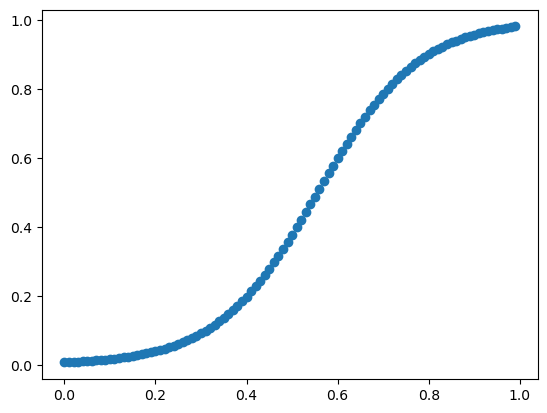

0.9626731126558706

In [104]:
plt.pyplot.scatter(np.arange(0,1,0.01), sigmoid(9*np.arange(0,1,0.01)-5))
plt.pyplot.show()
sigmoid(3.25)

Plot the impact factors per isoform per tissue

In [4]:
#print(impact_factor)
#for gene_id in impact_factors:
#FIZ1: ENSG00000179943
#TCF4: ENSG00000196628
for gene_id in ["ENSG00000179943", "ENSG00000196628","ENSG00000126456", "ENSG00000185507", "ENSG00000109320"]:
    print(gene_id)
    heatmap_values = list()
    exp_hm_values = list()
    rel_exp_hm_values = list()
    prot_ids = []
    for prot_id in impact_factors[gene_id]:
        #print(prot_id)
        these_factors = {tissue: rel_impact_factors[gene_id][prot_id][tissue][0] 
                         for tissue in rel_impact_factors[gene_id][prot_id]}
        these_exp = {tissue: impact_factors[gene_id][prot_id][tissue][1] 
                         for tissue in impact_factors[gene_id][prot_id]}
        these_rel_exp = {tissue: rel_impact_factors[gene_id][prot_id][tissue][1] 
                         for tissue in rel_impact_factors[gene_id][prot_id]}
        if len(these_factors)==0 or max(these_factors.values())==0:
            continue
        #print(these_factors.values())
        #print(these_exp.values())
        heatmap_values.append(list(these_factors.values()))
        exp_hm_values.append(list(these_exp.values()))
        rel_exp_hm_values.append(list(these_rel_exp.values()))
        width = 0.35
        #plt.pyplot.figure(figsize=(11,6))
        #plt.pyplot.bar(np.arange(len(these_factors))-width/2, 
        #               np.array(list(these_factors.values())), 
        #               width)
        #plt.pyplot.bar(np.arange(len(these_exp))+width/2, 
        #               np.array(list(these_exp.values())), 
        #               width)
        #plt.pyplot.xticks(range(len(these_factors)), list(these_factors.keys()), rotation=90)
        #plt.pyplot.show()
        prot_ids.append(prot_id)
    if len(heatmap_values)==0:
        continue
    heatmap_values = np.array(heatmap_values)
    row_sums = np.sum(heatmap_values, axis=1)
    #keep_rows = row_sums>0.05*sum(row_sums)
    #heatmap_values = heatmap_values[keep_rows,:]
    plt.pyplot.figure(figsize=(11,6))
    #TODO: adjust the colors of the heatmap
    plt.pyplot.colormaps()
    plt.pyplot.imshow(heatmap_values, cmap="inferno")
    plt.pyplot.colorbar()
    plt.pyplot.xticks(np.arange(len(these_factors)), list(these_factors.keys()), rotation=90)
    #plt.pyplot.yticks(np.arange(sum(keep_rows)), np.array(prot_ids)[keep_rows])
    plt.pyplot.yticks(np.arange(len(prot_ids)), np.array(prot_ids))
    plt.pyplot.show()
    #print(heatmap_values)
    average_tpm_hm_values = list()
    for prot_id in impact_factors[gene_id]:
        average_tpm_hm_values.append(list(average_tpms[gene_id][prot_id].values()))
    average_tpm_hm_values = np.array(average_tpm_hm_values)
    #print(average_tpm_hm_values)
    plt.pyplot.figure(figsize=(11,6))
    plt.pyplot.imshow(exp_hm_values, cmap="inferno")
    plt.pyplot.colorbar()
    plt.pyplot.xticks(np.arange(len(these_factors)), list(these_factors.keys()), rotation=90)
    plt.pyplot.yticks(np.arange(len(prot_ids)), np.array(prot_ids))
    plt.pyplot.show()
    plt.pyplot.figure(figsize=(11,6))
    plt.pyplot.imshow(rel_exp_hm_values, cmap="inferno")
    plt.pyplot.colorbar()
    plt.pyplot.xticks(np.arange(len(these_factors)), list(these_factors.keys()), rotation=90)
    plt.pyplot.yticks(np.arange(len(prot_ids)), np.array(prot_ids))
    plt.pyplot.show()

ENSG00000179943


NameError: name 'impact_factors' is not defined

Calculate the impact factor per tissue per gene

In [ ]:
impact_factors_gene = {}
rel_impact_factors_gene = {}
for gene_id in impact_factors:
    #print(gene_id)
    impact_factors_gene[gene_id] = {}
    rel_impact_factors_gene[gene_id] = {}
    for prot_id in impact_factors[gene_id]:
        for tissue in impact_factors[gene_id][prot_id]:
            if tissue not in impact_factors_gene[gene_id]:
                impact_factors_gene[gene_id][tissue] = [0,0,0]
                rel_impact_factors_gene[gene_id][tissue] = [0,0,0]
            if impact_factors_gene[gene_id][tissue][0] < impact_factors[gene_id][prot_id][tissue][0]:
                impact_factors_gene[gene_id][tissue][0] = impact_factors[gene_id][prot_id][tissue][0]
                impact_factors_gene[gene_id][tissue][2] = impact_factors[gene_id][prot_id][tissue][1]
            impact_factors_gene[gene_id][tissue][1] += impact_factors[gene_id][prot_id][tissue][1]
            if rel_impact_factors_gene[gene_id][tissue][0] < rel_impact_factors[gene_id][prot_id][tissue][0]:
                rel_impact_factors_gene[gene_id][tissue][0] = rel_impact_factors[gene_id][prot_id][tissue][0]
                rel_impact_factors_gene[gene_id][tissue][2] = rel_impact_factors[gene_id][prot_id][tissue][1]
            rel_impact_factors_gene[gene_id][tissue][1] += rel_impact_factors[gene_id][prot_id][tissue][1]
#print(impact_factors_gene)

In [ ]:
#for gene_id in impact_factors_gene:
for gene_id in ["ENSG00000126456"]:
    print(gene_id)
    these_factors = {tissue: rel_impact_factors_gene[gene_id][tissue][0] 
                     for tissue in rel_impact_factors_gene[gene_id]}
    these_factorexp = {tissue: rel_impact_factors_gene[gene_id][tissue][2] 
                 for tissue in rel_impact_factors_gene[gene_id]}
    these_exp = {tissue: rel_impact_factors_gene[gene_id][tissue][1] 
                 for tissue in rel_impact_factors_gene[gene_id]}
    width = .4
    plt.pyplot.figure(figsize=(11,6))
    plt.pyplot.bar(np.arange(len(these_factors))-width/2, 
                   np.array(list(these_factors.values())), 
                   width, color="magenta", label="ASIF")
    plt.pyplot.bar(np.arange(len(these_factorexp))+width/2, 
                   np.array(list(these_factorexp.values())), 
                   width, color="grey", label="Relative Expression")
    #plt.pyplot.bar(np.arange(len(these_exp))+width, 
    #               np.array(list(these_exp.values())), 
    #               width, color="blue", label="Expression")
    
    plt.pyplot.xticks(range(len(these_factors)), list(these_factors.keys()), rotation=90)
    plt.pyplot.legend()
    plt.pyplot.show()
    
    width = .9
    plt.pyplot.figure(figsize=(11,6))
    plt.pyplot.bar(np.arange(len(these_exp)), 
                   np.array(list(these_exp.values())), 
                   width=width, color="blue", label="Expression")
    plt.pyplot.bar(np.arange(len(these_factorexp)), 
                   np.array(list(these_factorexp.values())),
                   bottom=np.array(list(these_exp.values())), 
                   width=width, color="magenta", label="Relative Expression")
    plt.pyplot.bar(np.arange(len(these_factors)), 
                   np.array(list(these_factors.values())), 
                   bottom=np.array(list(these_exp.values()))+np.array(list(these_factorexp.values())), 
                   width=width, color="grey", label="ASIF")
    plt.pyplot.xticks(range(len(these_factors)), list(these_factors.keys()), rotation=90)
    plt.pyplot.legend()
    plt.pyplot.show()

In [49]:
for enst in average_tpms["ENSG00000126456"]:
    print(enst)
    print(average_tpms["ENSG00000126456"][enst])

ENST00000309877
{'adipose tissue': 3.673632, 'adrenal gland': 5.037216666666667, 'appendix': 5.327793333333333, 'bone marrow': 4.386055, 'breast': 1.5708225, 'cerebral cortex': 1.1026033333333334, 'cervix': 2.87669, 'choroid plexus': 0.301681, 'colon': 2.032288769230769, 'duodenum': 3.16568, 'endometrium': 5.232177999999999, 'epididymis': 1.48466, 'esophagus': 0.5983666666666666, 'fallopian tube': 3.5521138, 'gallbladder': 4.8641966666666665, 'heart muscle': 0.5910584999999999, 'kidney': 0.7029580000000001, 'liver': 0.7091253, 'lung': 5.980912222222223, 'lymph node': 11.302597, 'ovary': 3.0084114285714283, 'pancreas': 1.249992, 'parathyroid gland': 0.8895306666666668, 'placenta': 2.711637375, 'prostate': 3.579476666666667, 'rectum': 1.7470807499999998, 'salivary gland': 3.85476, 'seminal vesicle': 4.839484333333333, 'skeletal muscle': 1.208493, 'skin': 9.6934, 'small intestine': 5.74403225, 'smooth muscle': 1.4343763333333335, 'spleen': 14.413791600000001, 'stomach': 6.5380375, 'testis

In [85]:
with open("impact_factors_gene.pickle", "wb") as f:
    pickle.dump(impact_factors_gene, f)
with open("rel_impact_factors_gene.pickle", "wb") as f:
    pickle.dump(rel_impact_factors_gene, f)

In [9]:
with open("impact_factors_gene.pickle", "rb") as f:
    impact_factors_gene = pickle.load(f)
with open("rel_impact_factors_gene.pickle", "rb") as f:
    rel_impact_factors_gene = pickle.load(f)

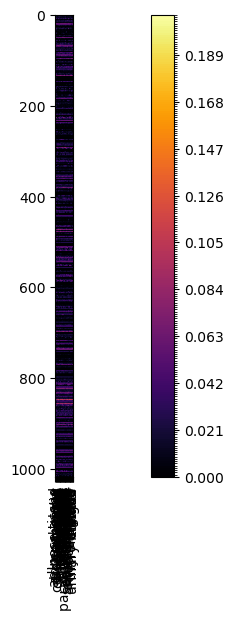

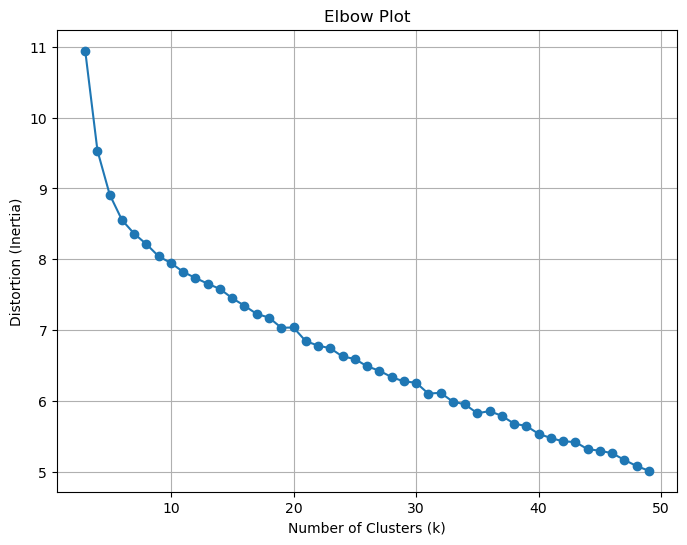

[[ 1  1  1  3  2 10  1  4  1 11  2  2  1  2  1  2  1  1  1  6  2  7  1  2
   2  1 11  2  5  0 11  1  6  1  8  2  2  9  6  2]]


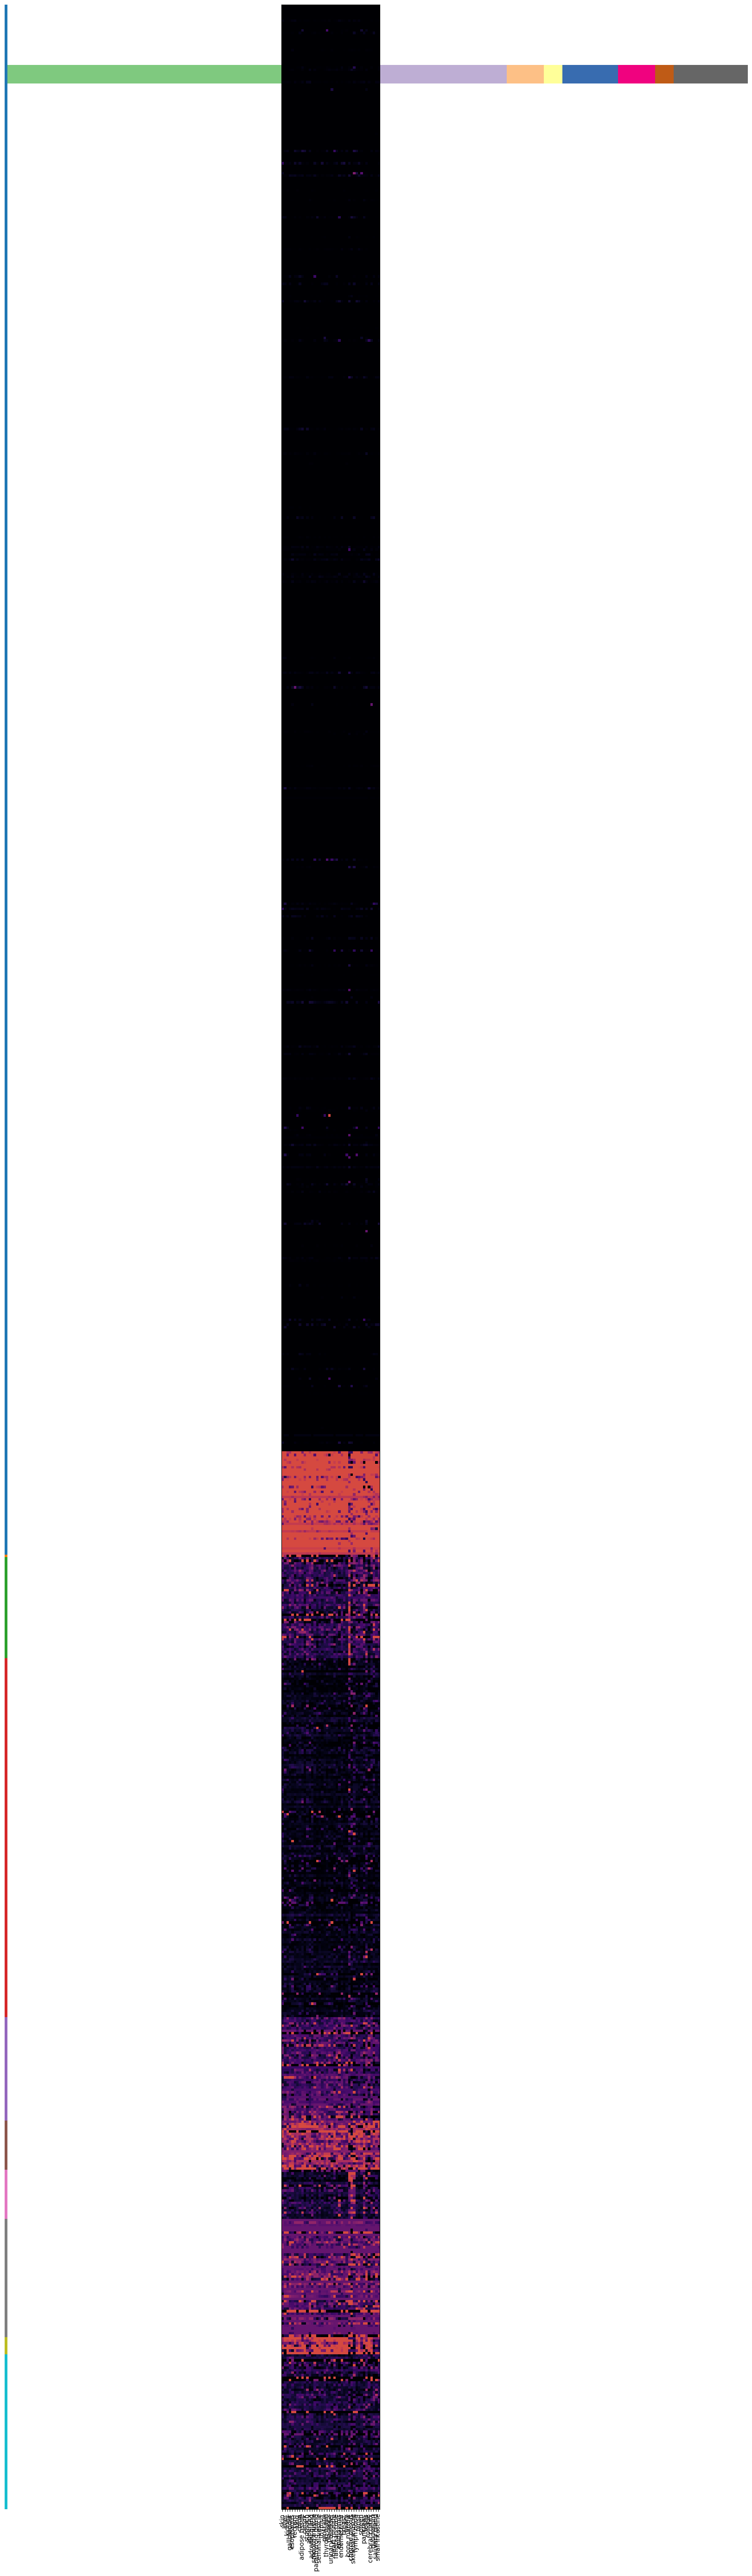

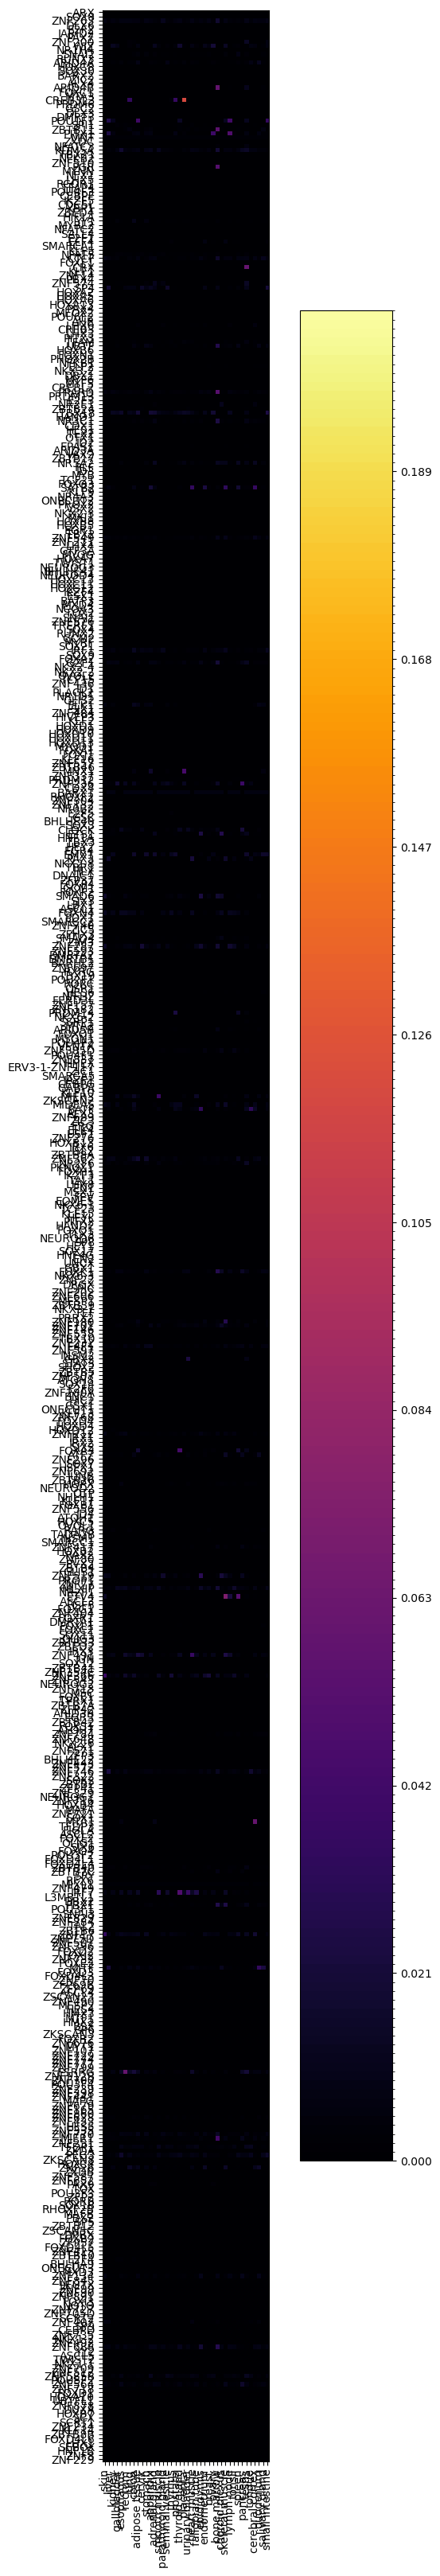

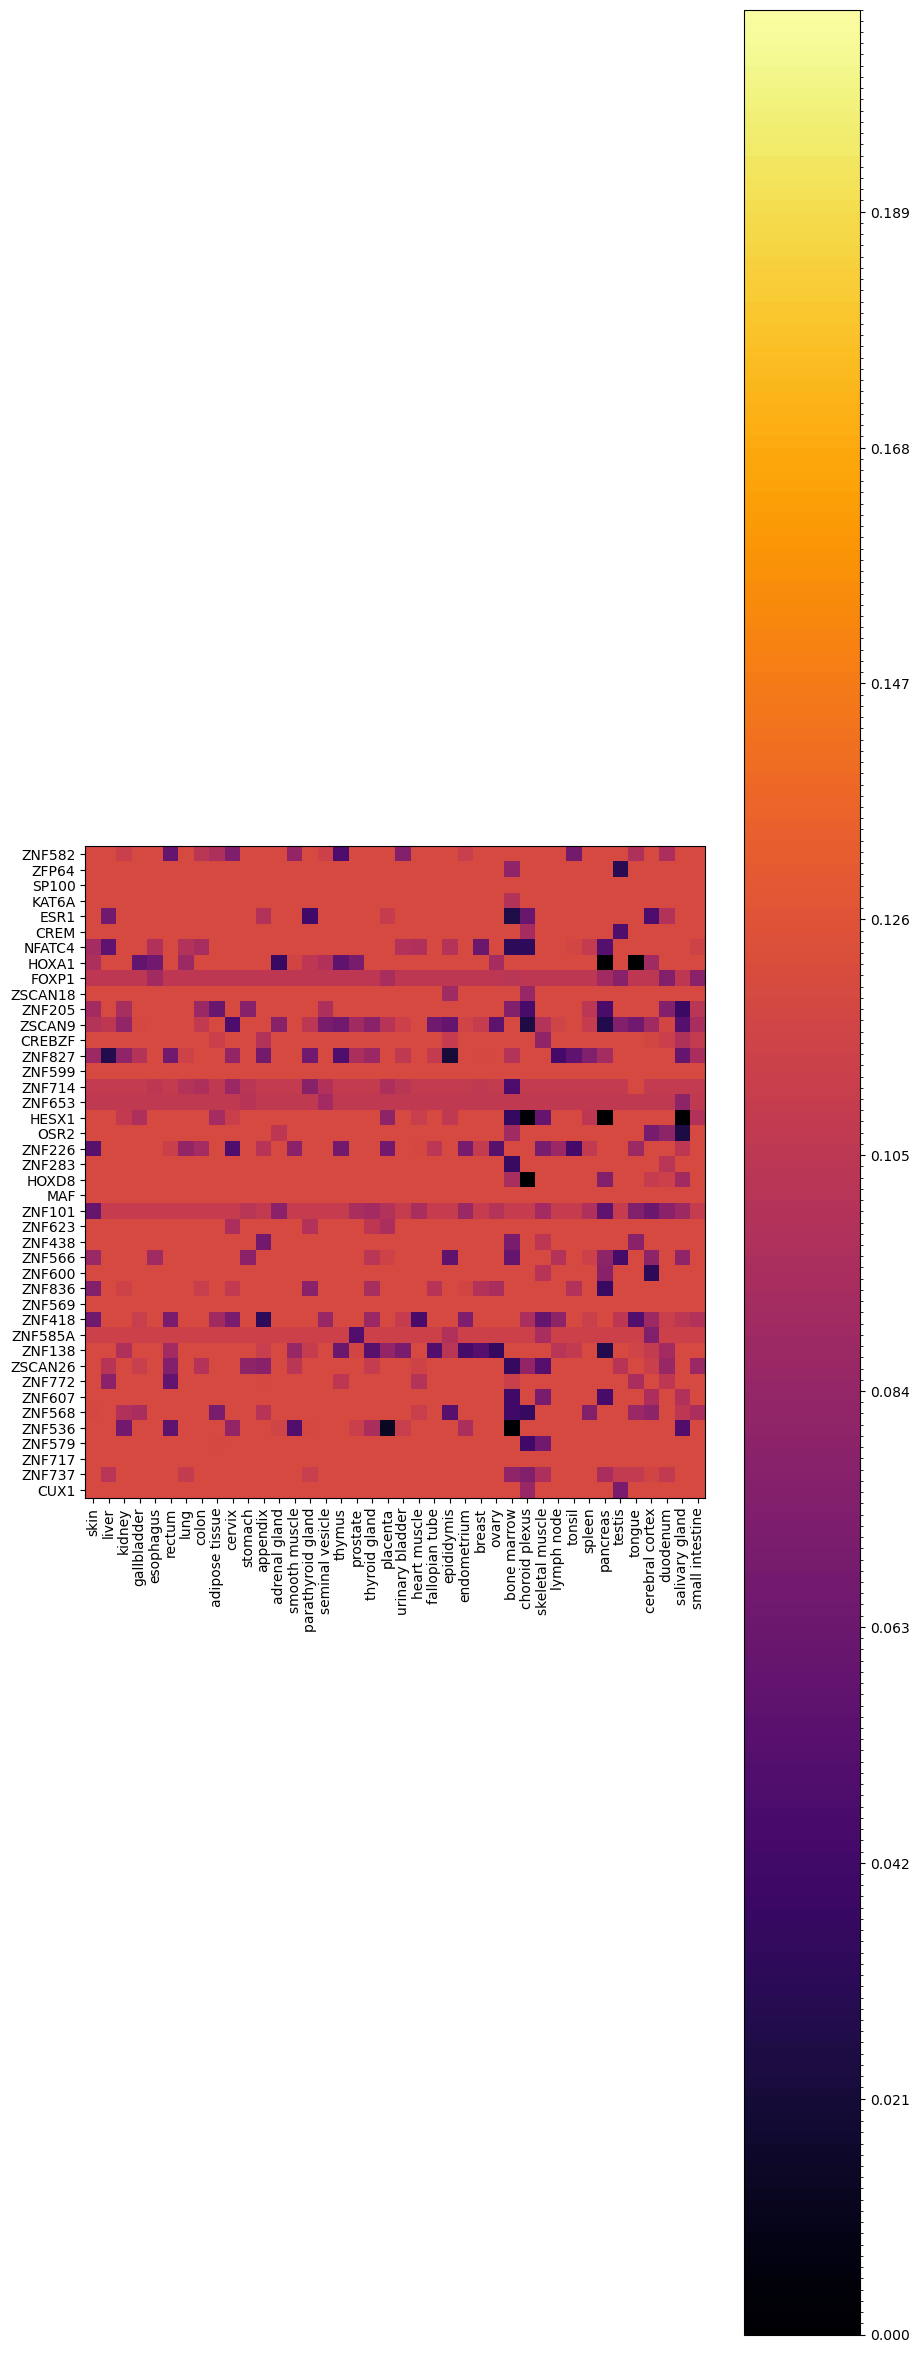

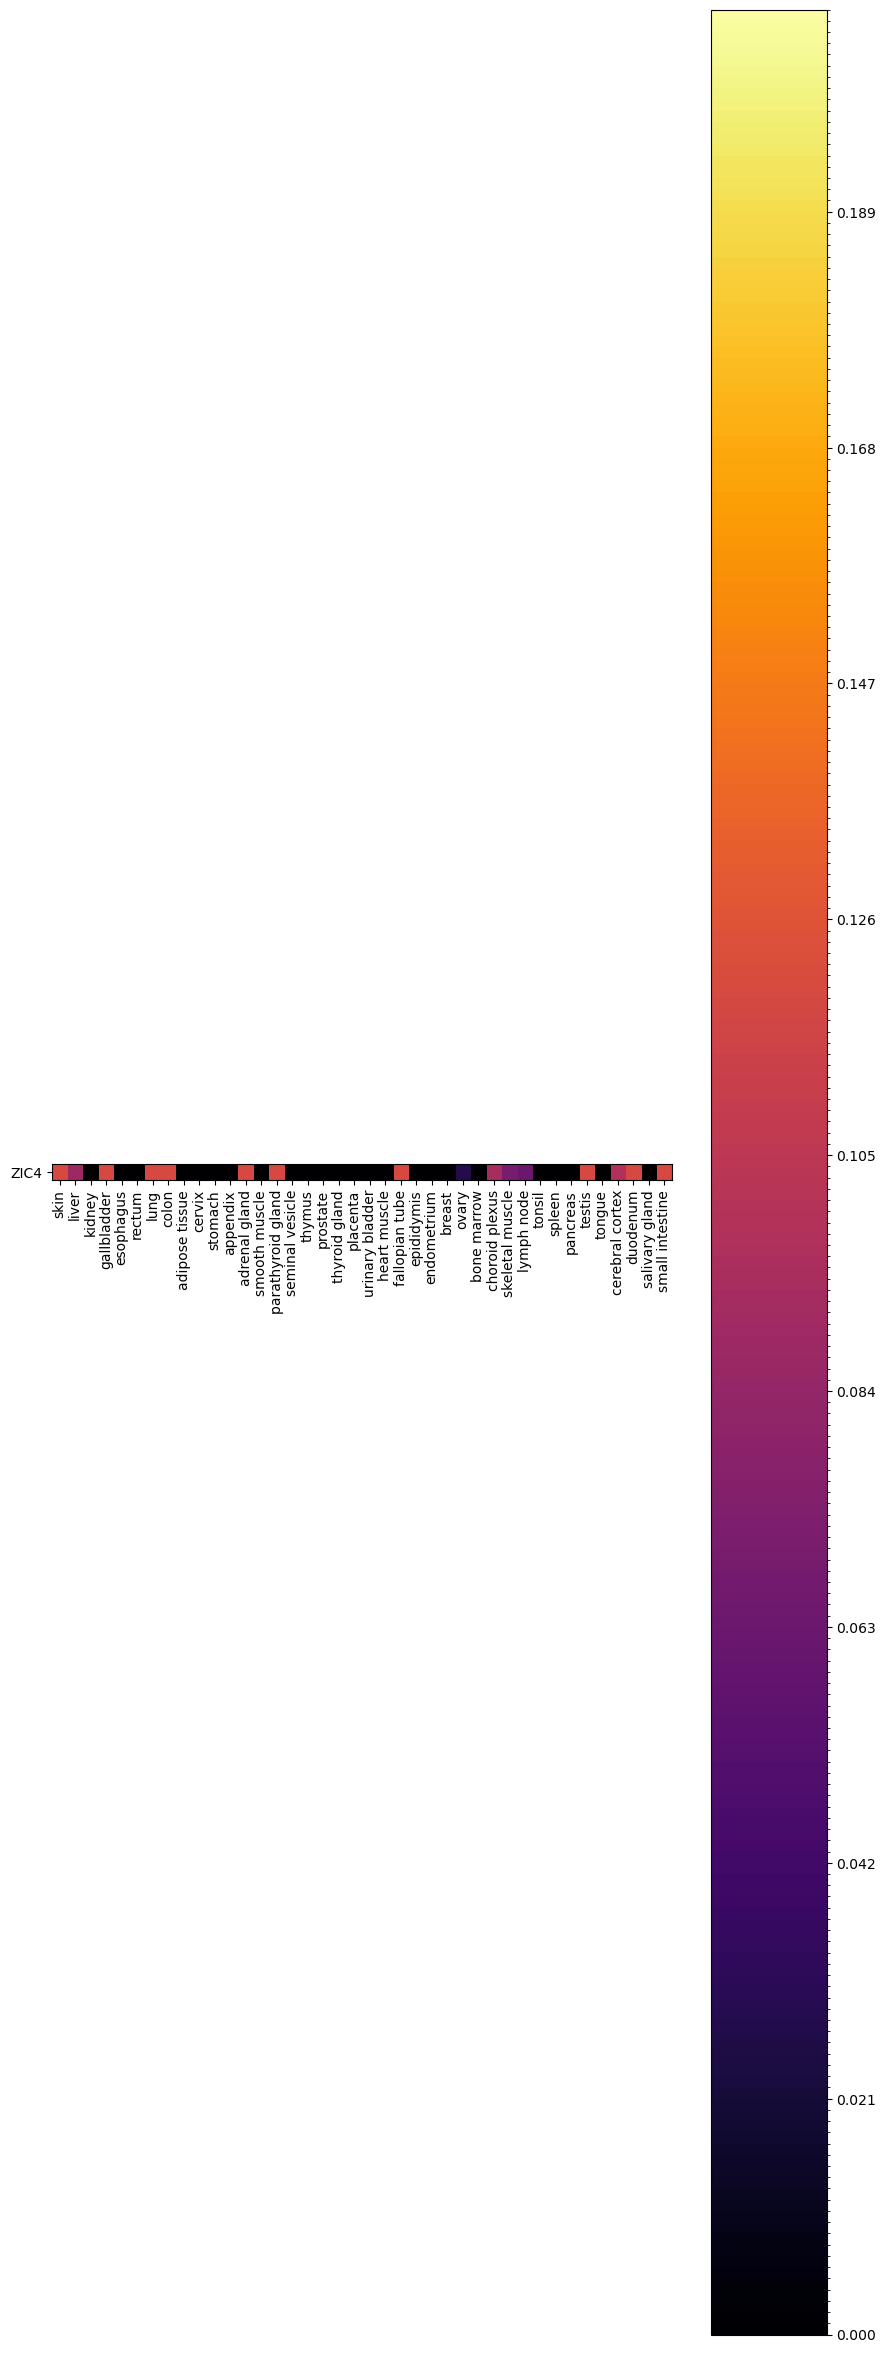

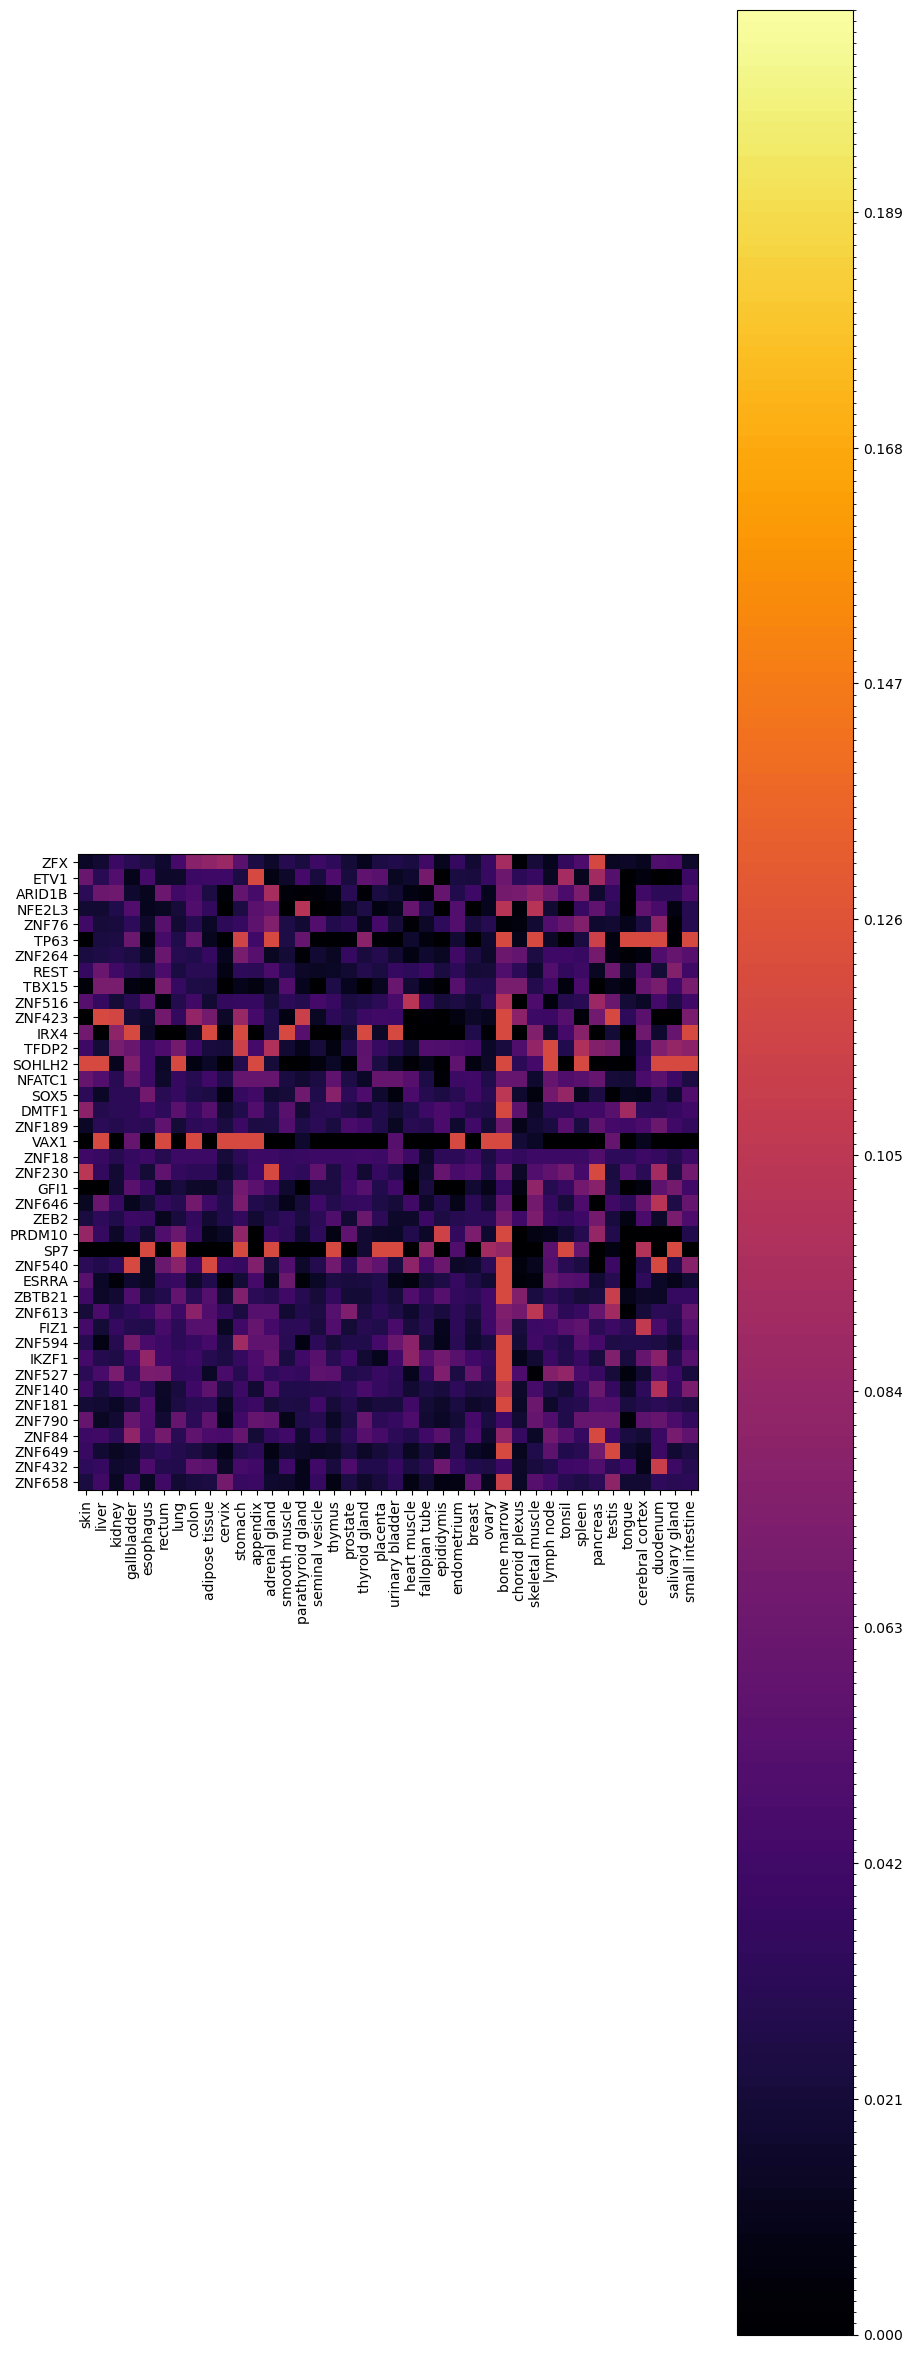

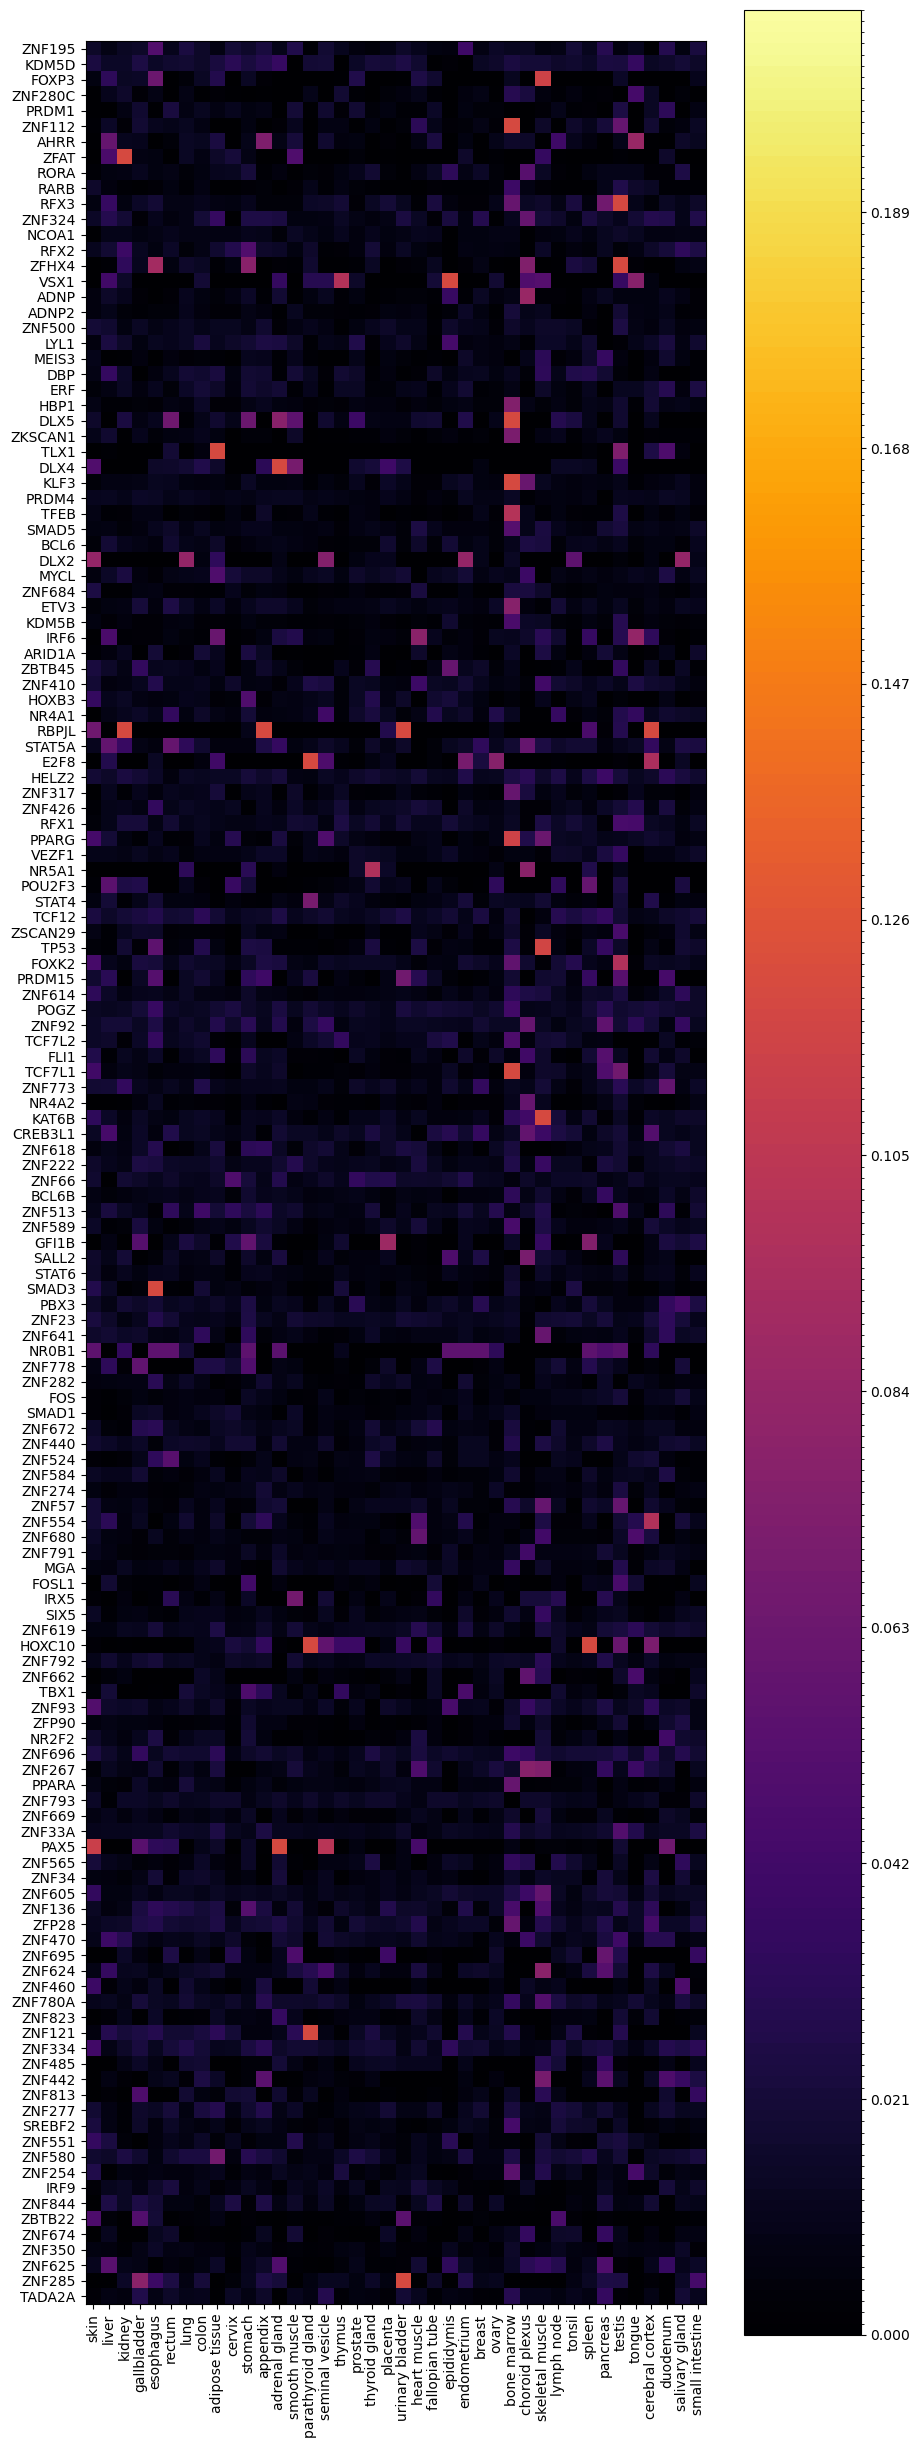

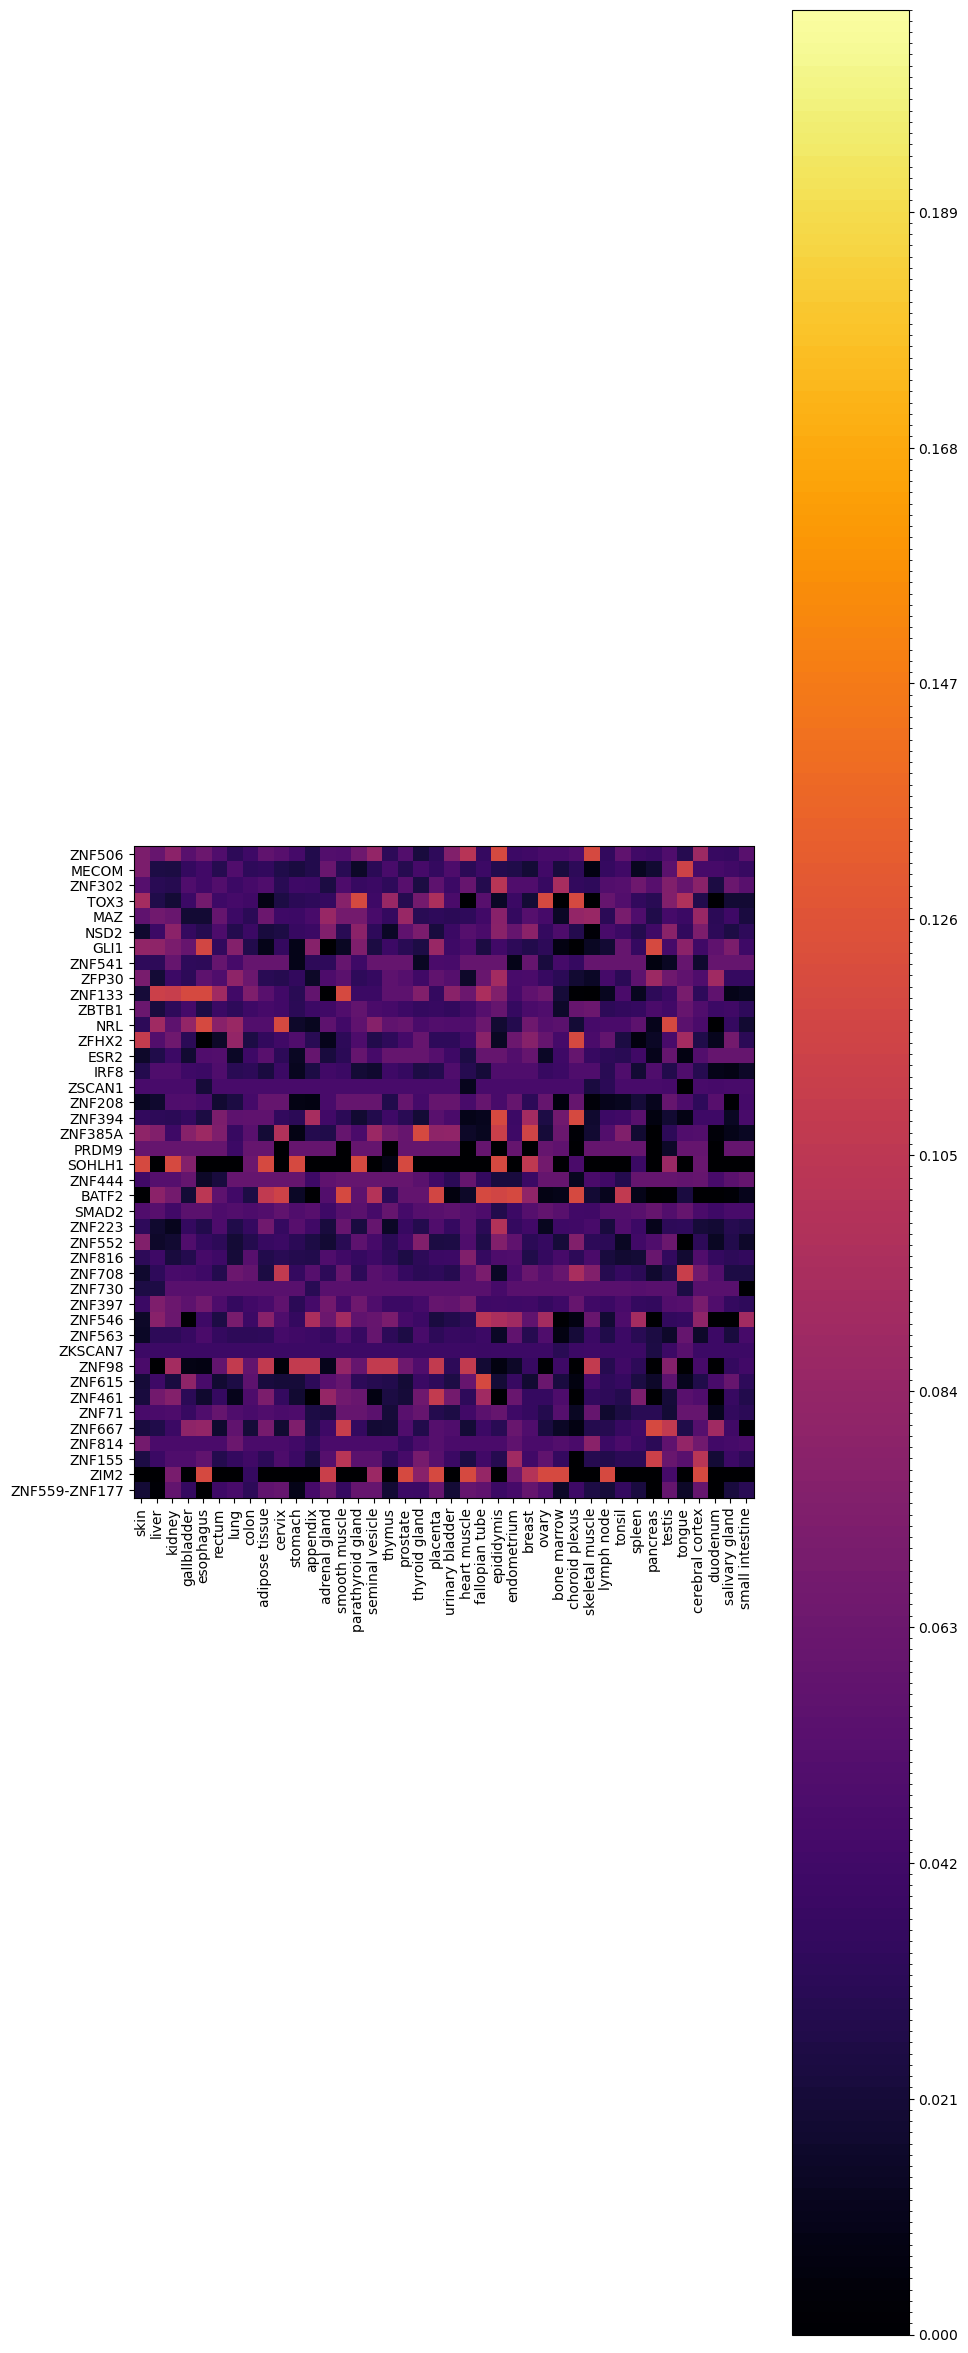

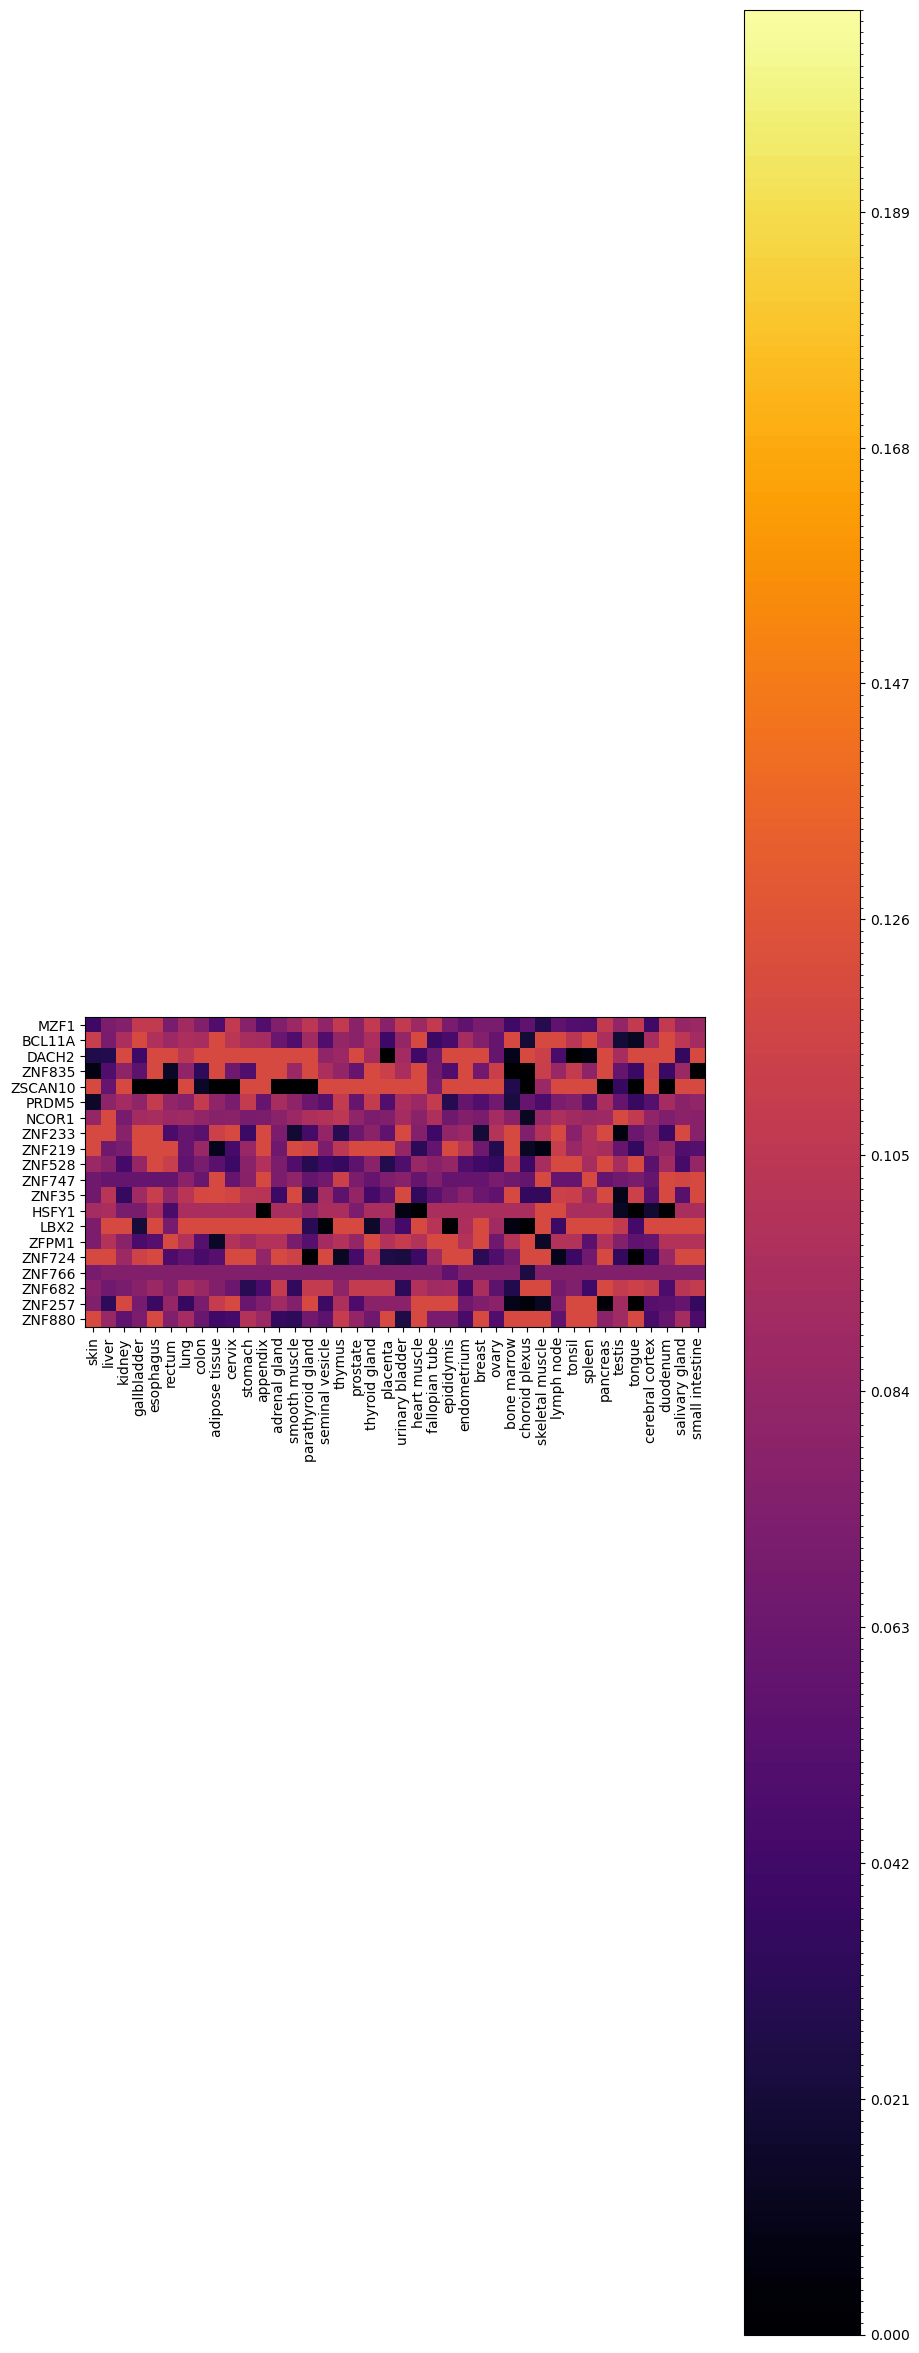

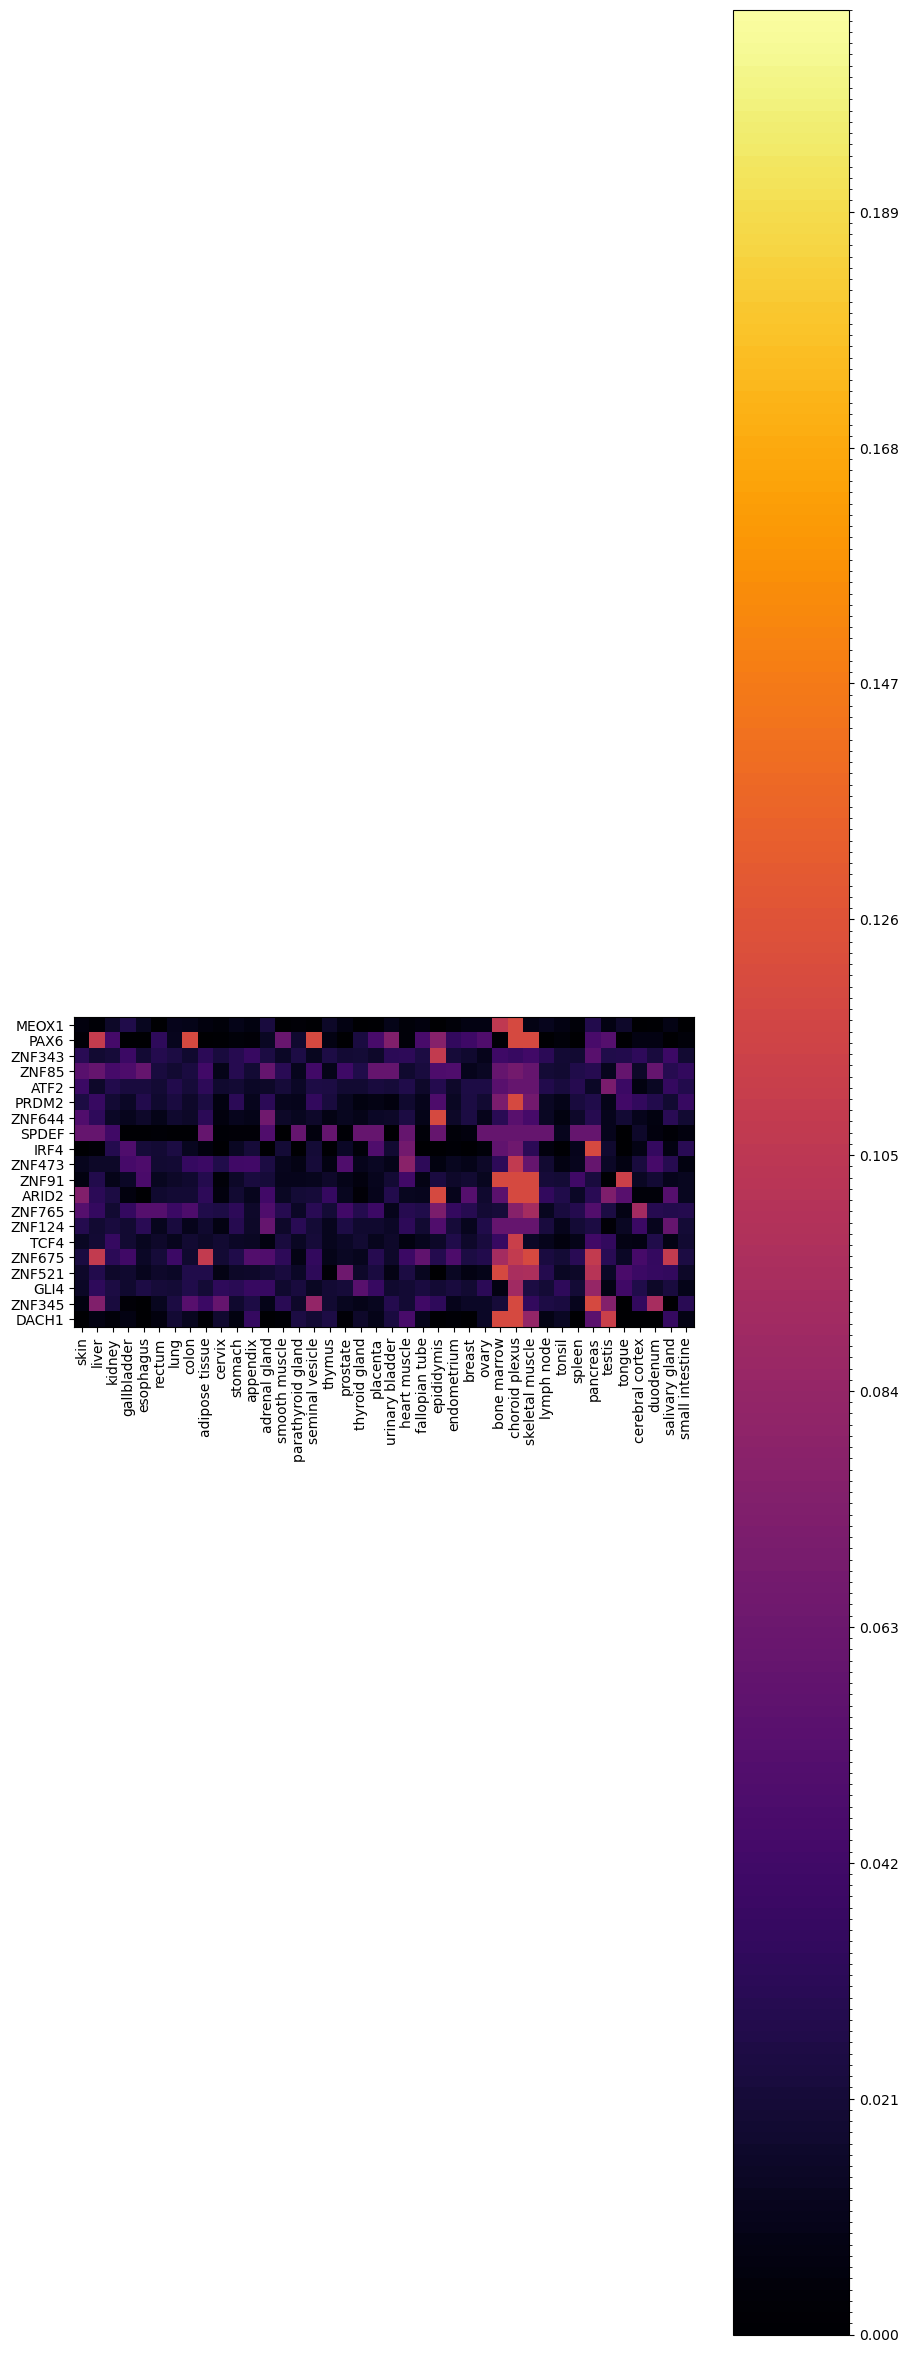

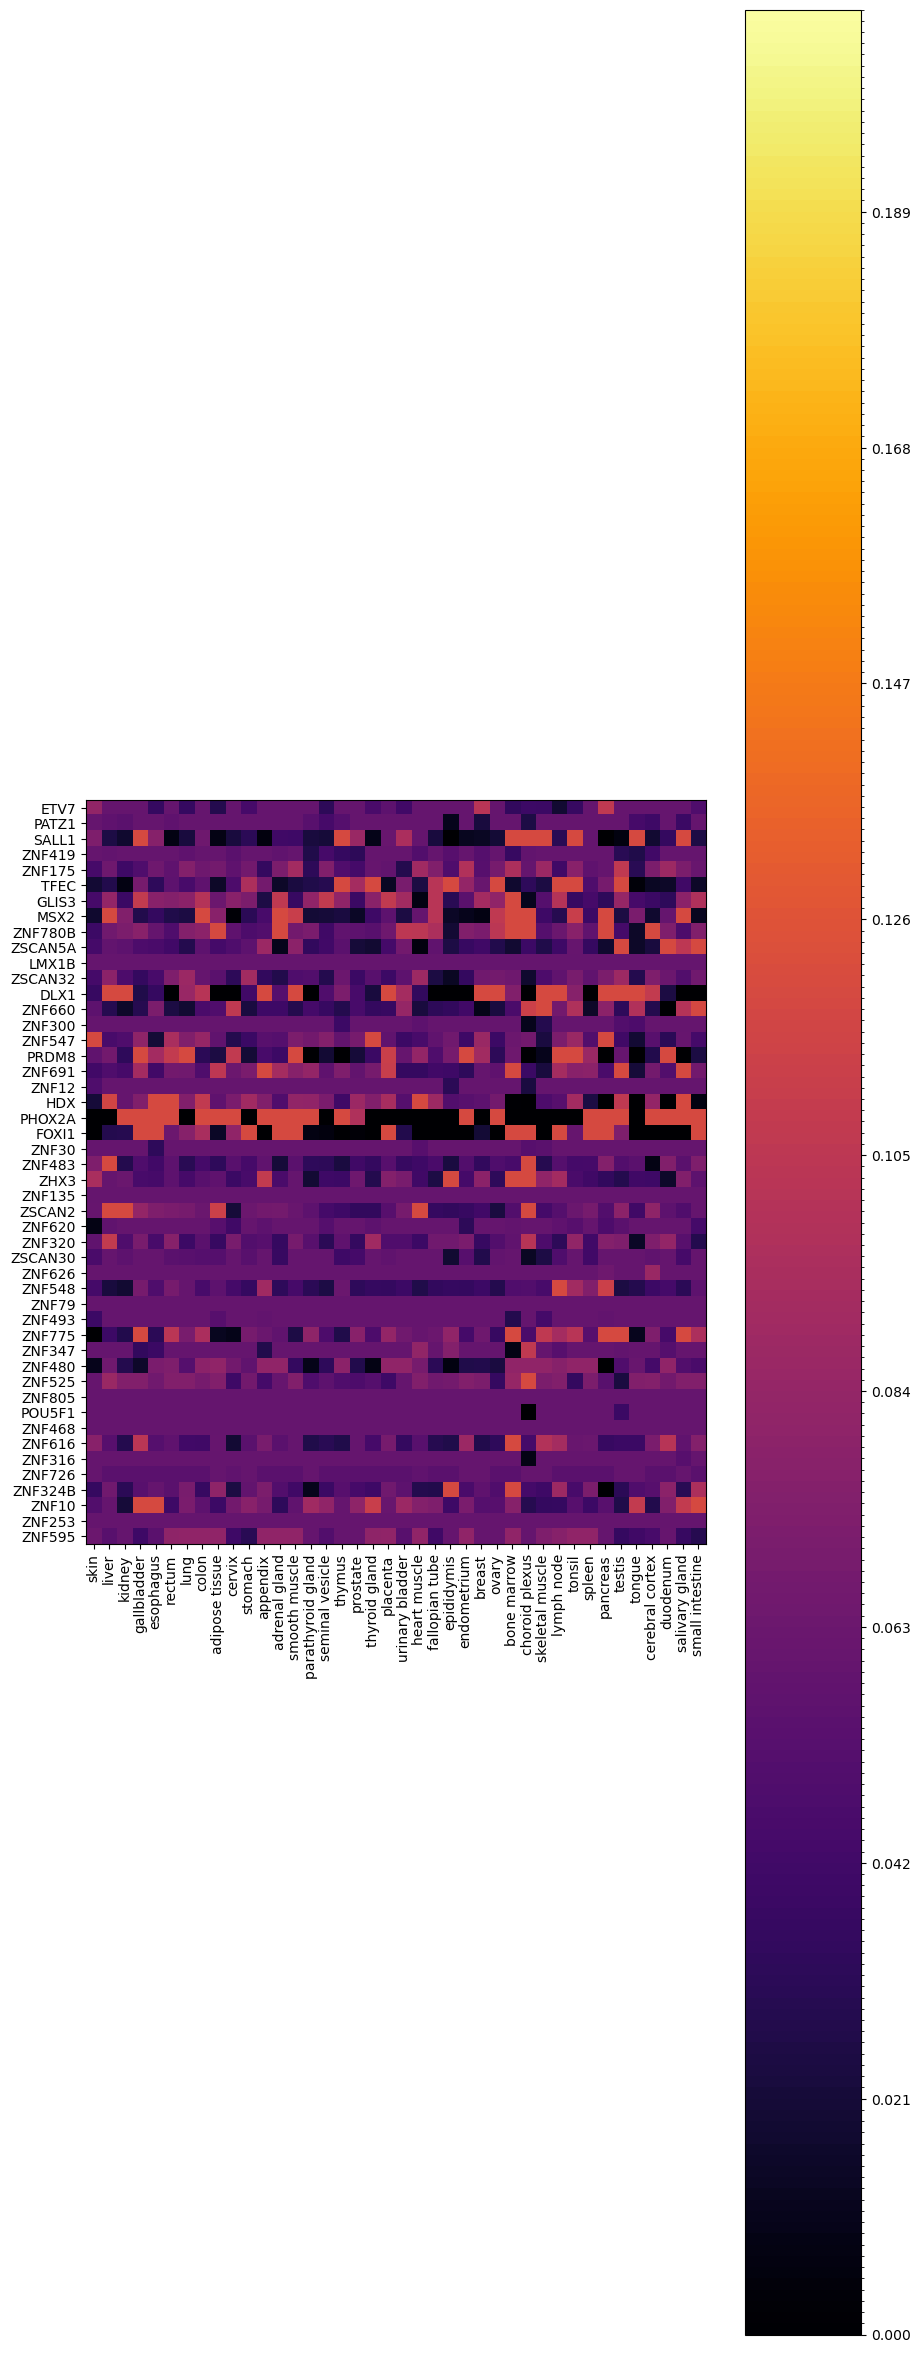

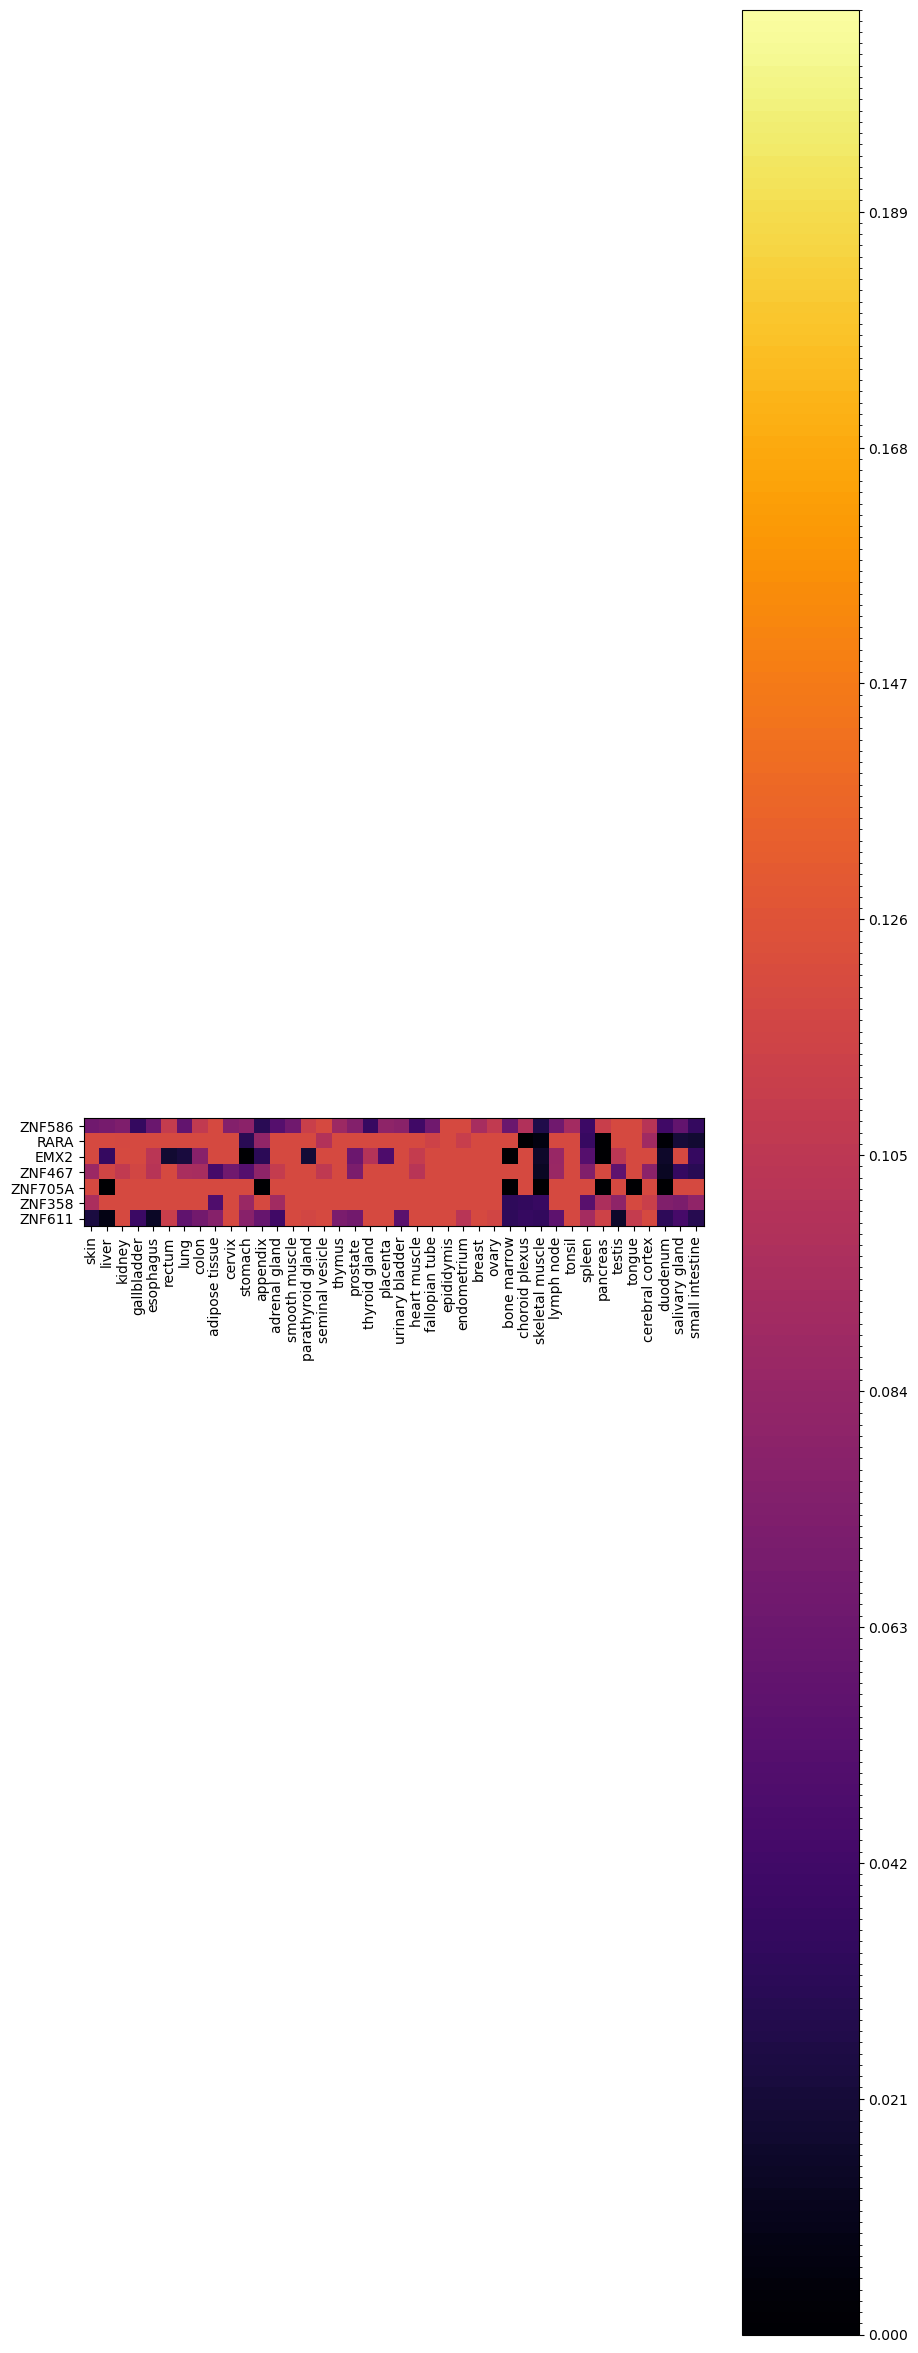

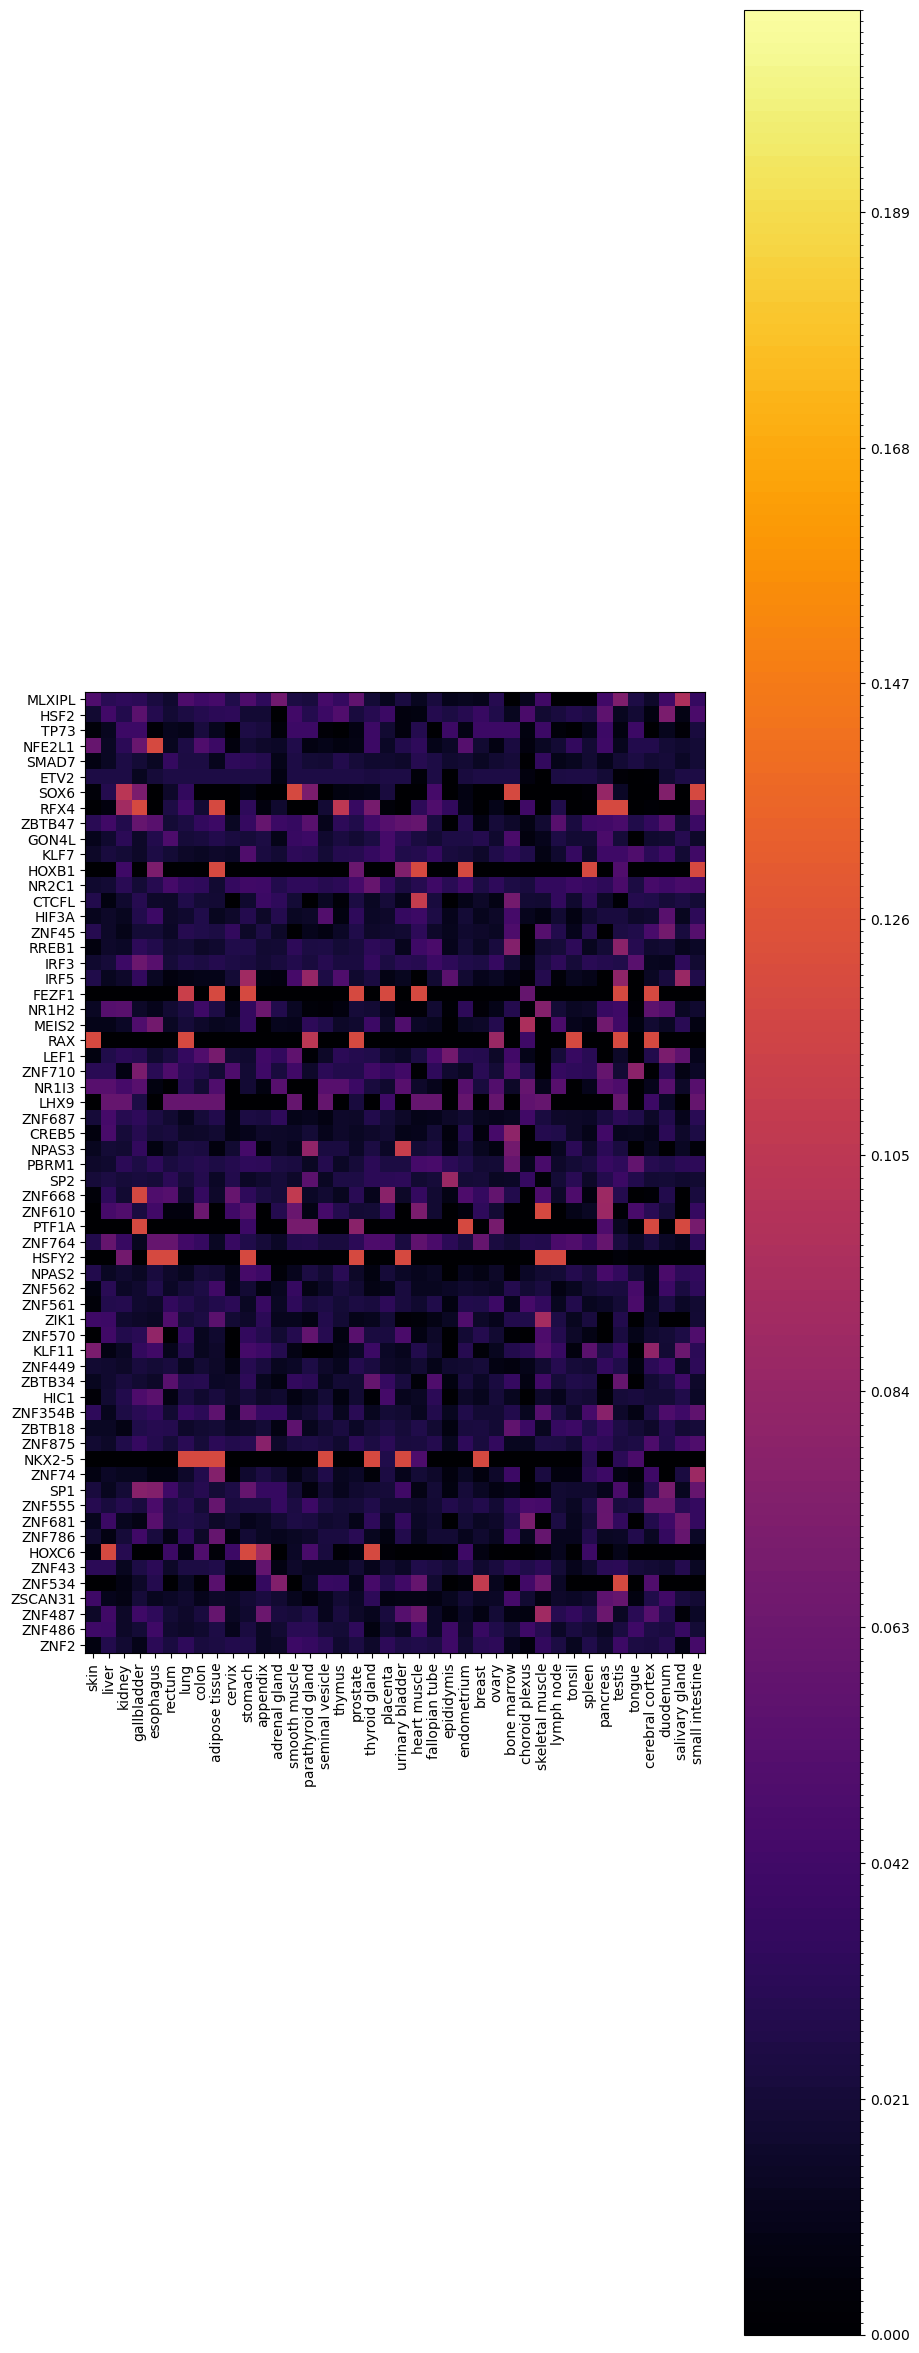

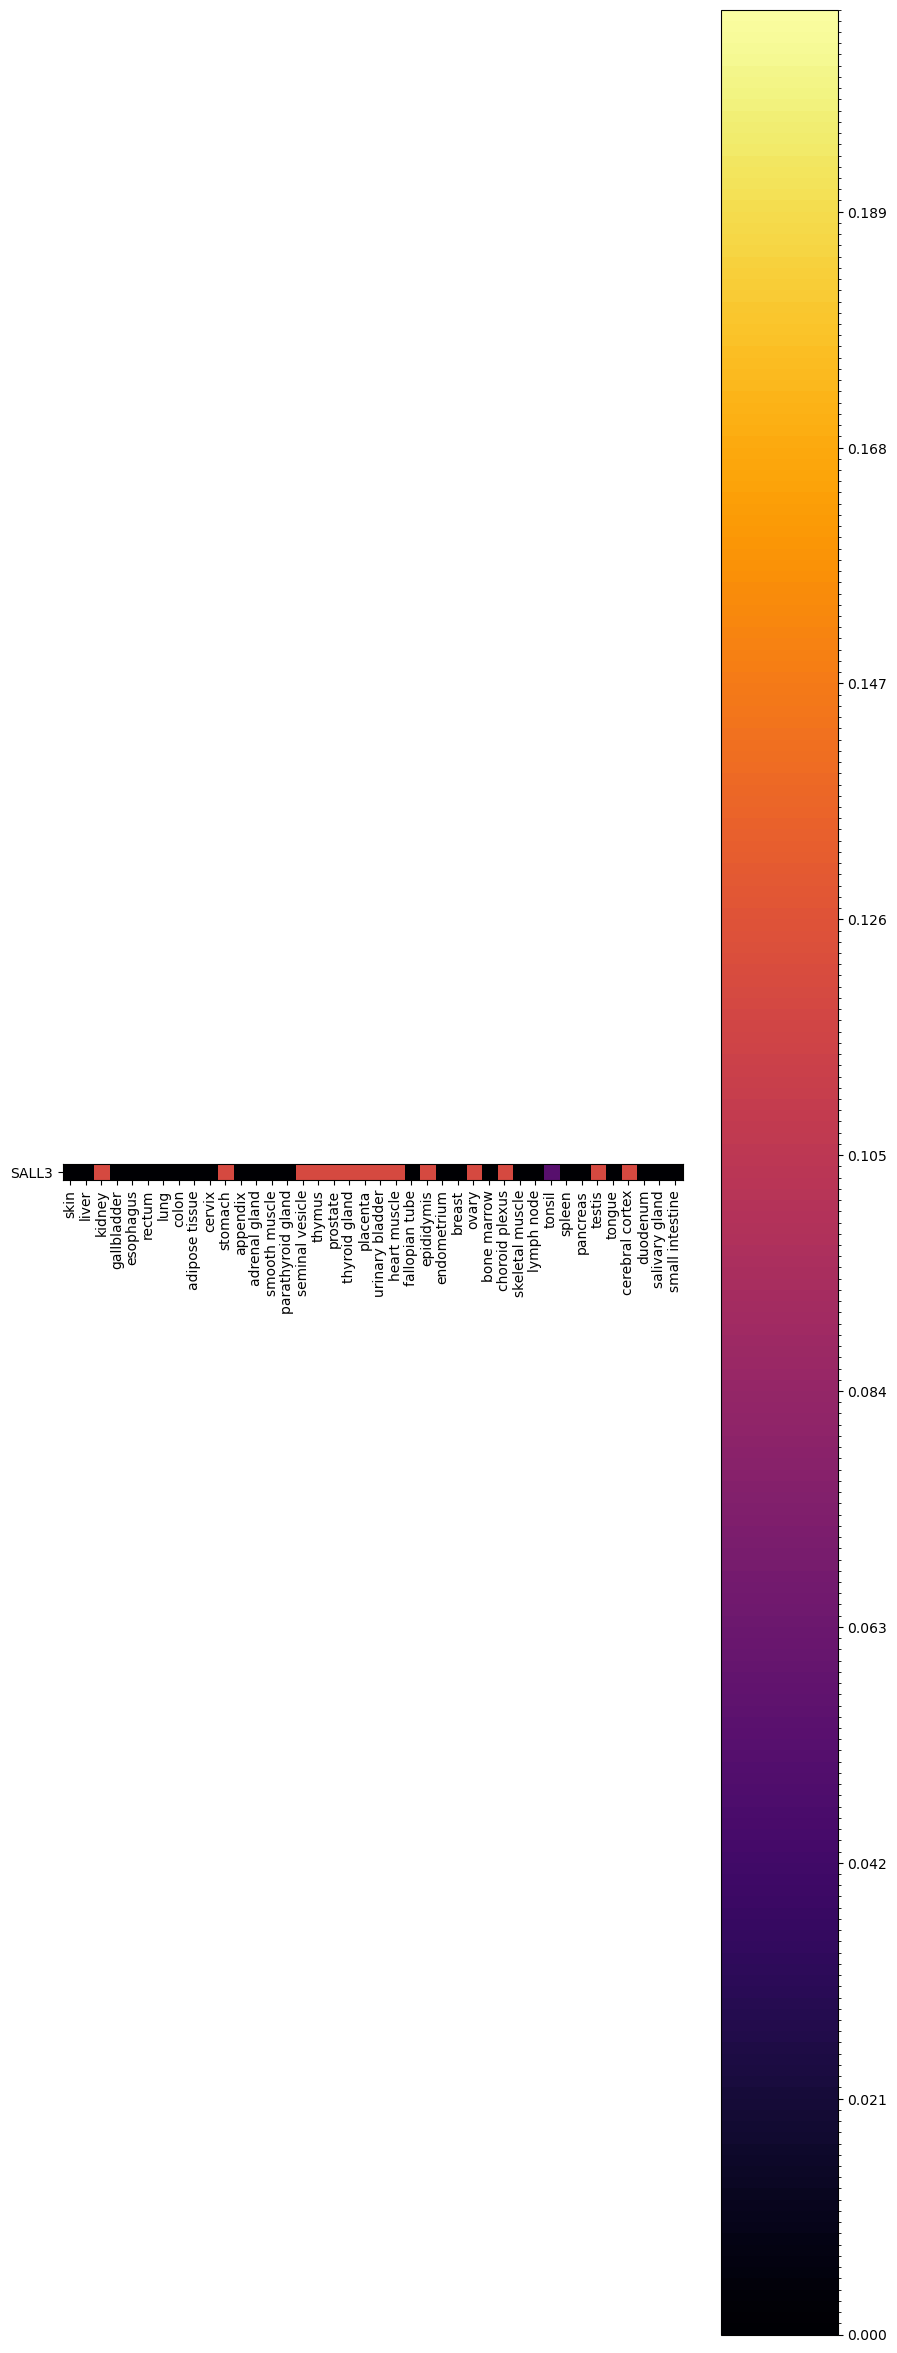

In [26]:
mg = mygene.MyGeneInfo()

gene_IF_table = np.empty((0,40))
rel_gene_IF_table = np.empty((0,40))
row_names = []
TF_interpro_dict = {}
for gene_id in impact_factors_gene:
    #print(gene_id)
    these_factors = np.array([impact_factors_gene[gene_id][tissue][0] 
                              for tissue in impact_factors_gene[gene_id]])
    rel_these_factors = np.array([rel_impact_factors_gene[gene_id][tissue][0] 
                                  for tissue in rel_impact_factors_gene[gene_id]])
    if(len(these_factors)==0): continue
    for prot_id in DNAbinding_seqs[gene_id]:
        if not prot_id.startswith("ENS"): continue
        for domain in DNAbinding_seqs[gene_id][prot_id]['domains']:
            #print(domain['interpro'])
            if domain['interpro']=='':
                continue
            elif domain['interpro'] not in TF_interpro_dict:
                TF_interpro_dict[domain['interpro']] = [gene_id]
            else:
                if gene_id not in TF_interpro_dict[domain['interpro']]:
                    TF_interpro_dict[domain['interpro']] += [gene_id]
    gene_IF_table = np.vstack((gene_IF_table, these_factors))
    rel_gene_IF_table = np.vstack((rel_gene_IF_table, rel_these_factors))
    row_names.append(gene_id)
    #break
for gene_id in impact_factors_gene:
    tissues = list({tissue: impact_factors_gene[gene_id][tissue][0] 
                    for tissue in impact_factors_gene[gene_id]}.keys())
    break
gene_IF_table = pd.DataFrame(gene_IF_table, index=row_names, columns=tissues)
rel_gene_IF_table = pd.DataFrame(rel_gene_IF_table, index=row_names, columns=tissues)
#print(gene_IF_table)
#print(tissues)
'''
for interpro_id in TF_interpro_dict:
    print(interpro_id)
    print(TF_interpro_dict[interpro_id])
    plt.pyplot.figure(figsize=(12,6))
    plt.pyplot.imshow(gene_IF_table.loc[TF_interpro_dict[interpro_id]], cmap="inferno")
    plt.pyplot.colorbar()
    plt.pyplot.xticks(range(len(tissues)), tissues, rotation=90)
    plt.pyplot.yticks(range(len(TF_interpro_dict[interpro_id])), TF_interpro_dict[interpro_id])
    plt.pyplot.show()

plt.pyplot.figure(figsize=(12,6))
custom_breakpoints = list(range(0,50,1)) + list(range(50,200,5))
cmap = plt.pyplot.get_cmap("inferno")
norm = plt.colors.BoundaryNorm(custom_breakpoints, cmap.N)
plt.pyplot.imshow(gene_IF_table, cmap=cmap, norm=norm)
plt.pyplot.colorbar()
plt.pyplot.xticks(range(len(tissues)), tissues, rotation=90)
plt.pyplot.show()

gene_IF_zscores = gene_IF_table.apply(zscore, axis=1)
plt.pyplot.figure(figsize=(12,6))
plt.pyplot.imshow(gene_IF_zscores, cmap="inferno")
plt.pyplot.colorbar()
plt.pyplot.xticks(range(len(tissues)), tissues, rotation=90)
plt.pyplot.show()

k_values = range(3,50)
distortions = []
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(gene_IF_zscores)
    distortions.append(kmeans.inertia_)
plt.pyplot.figure(figsize=(8, 6))
plt.pyplot.plot(k_values, distortions, marker='o', linestyle='-')
plt.pyplot.title('Elbow Plot')
plt.pyplot.xlabel('Number of Clusters (k)')
plt.pyplot.ylabel('Distortion (Inertia)')
plt.pyplot.grid(True)
plt.pyplot.show()

n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(gene_IF_zscores)
#print(kmeans.labels_[:5])
cluster_labels_matrix = np.expand_dims(kmeans.labels_, axis=0)
cmap = plt.pyplot.cm.get_cmap('tab10', n_clusters)
kmeans_order = np.argsort(kmeans.labels_)
plt.pyplot.figure(figsize=(6,20))
plt.pyplot.imshow(gene_IF_zscores.iloc[kmeans_order,:], cmap="inferno")
plt.pyplot.colorbar()
plt.pyplot.xticks(range(len(tissues)), tissues, rotation=90)
plt.pyplot.show()

for i in range(n_clusters):
    rnames = gene_IF_zscores.index[kmeans.labels_==i]
    rnames1 = []
    #print(mg.getgene("ENSG00000156273")[0]['symbol'])
    for rname in rnames:
        try:
            symbol = mg.getgene(rname)['symbol'] 
        except:
            symbol = mg.getgene(rname)[0]['symbol'] 
        rnames1.append(symbol)
    plt.pyplot.figure(figsize=(10,40))
    plt.pyplot.imshow(gene_IF_zscores.iloc[[lab==i for lab in kmeans.labels_],:], cmap="inferno")
    #plt.pyplot.colorbar()
    plt.pyplot.xticks(range(len(tissues)), tissues, rotation=90)
    plt.pyplot.yticks(range(len(rnames1)), rnames1)
    plt.pyplot.show()
'''
plt.pyplot.figure(figsize=(20,6))
rel_custom_breakpoints = list(np.arange(0,0.20,0.001)) + list(np.arange(0.20,1,0.1))
rel_cmap = plt.pyplot.get_cmap("inferno")
rel_norm = plt.colors.BoundaryNorm(rel_custom_breakpoints, rel_cmap.N)
plt.pyplot.imshow(rel_gene_IF_table, cmap=rel_cmap, norm=rel_norm)
plt.pyplot.colorbar()
plt.pyplot.xticks(range(len(tissues)), tissues, rotation=90)
plt.pyplot.show()

k_values = range(3,50)
distortions = []
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(rel_gene_IF_table)
    distortions.append(kmeans.inertia_)
plt.pyplot.figure(figsize=(8, 6))
plt.pyplot.plot(k_values, distortions, marker='o', linestyle='-')
plt.pyplot.title('Elbow Plot')
plt.pyplot.xlabel('Number of Clusters (k)')
plt.pyplot.ylabel('Distortion (Inertia)')
plt.pyplot.grid(True)
plt.pyplot.show()

kmeans_tissues = KMeans(n_clusters=12)
kmeans_tissues.fit(rel_gene_IF_table.T)
tissue_cluster_labels_matrix = np.expand_dims(kmeans_tissues.labels_, axis=0)
tissue_order = np.argsort(kmeans_tissues.labels_)
print(tissue_cluster_labels_matrix)
n_clusters = 12
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(rel_gene_IF_table)
#print(kmeans.labels_[:5])
cluster_labels_matrix = np.expand_dims(kmeans.labels_, axis=0)
cmap = plt.pyplot.cm.get_cmap('tab10', n_clusters)
kmeans_order = np.argsort(kmeans.labels_)
fig, axes = plt.pyplot.subplots(2,2,figsize=(20,60), 
                                gridspec_kw={'width_ratios': [1, 20], 'height_ratios': [1, 50]})

axes[0,0].axis('off')

#plt.pyplot.figure(figsize=(20,60))
axes[1,1].set_position([0.0,0.05,.9,0.9])
axes[1,1].imshow(rel_gene_IF_table.iloc[kmeans_order,tissue_order], cmap=rel_cmap, norm=rel_norm)
axes[1,1].set_xticks(range(len(tissues)), np.array(tissues)[tissue_order], rotation=90)
axes[1,1].set_yticks([])
#plt.pyplot.show()

#plt.pyplot.figure(figsize=(10,15))
axes[0,1].set_position([0.1,0.9,0.80,0.05])
axes[0,1].imshow(tissue_cluster_labels_matrix[:,tissue_order], cmap="Accent")
axes[0,1].set_xticks([])
axes[0,1].set_yticks([])
axes[0,1].axis('off')
#plt.pyplot.show()

#plt.pyplot.figure(figsize=(20,60))
axes[1,0].set_position([0.05, 0.05,0.1,0.90])
axes[1,0].imshow(cluster_labels_matrix.T[kmeans_order,:], cmap="tab10")
axes[1,0].set_xticks([])
axes[1,0].set_yticks([])
axes[1,0].axis('off')

#fig.subplots_adjust(wspace=0.01, hspace=0.01)
#fig.colorbar(plt.pyplot.cm.ScalarMappable(cmap="inferno"), ax=axes)
plt.pyplot.show()

for i in range(n_clusters):
    rnames = rel_gene_IF_table.index[kmeans.labels_==i]
    rnames1 = []
    #print(mg.getgene("ENSG00000156273")[0]['symbol'])
    for rname in rnames:
        try:
            symbol = mg.getgene(rname)['symbol'] 
        except:
            symbol = mg.getgene(rname)[0]['symbol'] 
        rnames1.append(symbol)
    plt.pyplot.figure(figsize=(10,40))
    plt.pyplot.imshow(rel_gene_IF_table.iloc[[lab==i for lab in kmeans.labels_],tissue_order], cmap=rel_cmap, norm=rel_norm)
    plt.pyplot.colorbar()
    plt.pyplot.xticks(range(len(tissues)), np.array(tissues)[tissue_order], rotation=90)
    plt.pyplot.yticks(range(len(rnames1)), rnames1)
    plt.pyplot.show()


In [4]:
ppi_domains = pd.read_csv("3did_pfam_pairs.txt", sep='\t',header=None)
print(ppi_domains.head())

for gene_id in DNAbinding_seqs:
    for prot_id in DNAbinding_seqs[gene_id]:
        if len(DNAbinding_seqs[gene_id])<=1:
            continue
        if 'Swiss-Prot' in DNAbinding_seqs[gene_id]["uniprot"]:
            uniprot_id = DNAbinding_seqs[gene_id]["uniprot"]['Swiss-Prot']
            if type(uniprot_id)!=str:
                uniprot_id = uniprot_id[0]
        else:
            #print(seqs[gene_id]["uniprot"])
            uniprot_id = DNAbinding_seqs[gene_id]["uniprot"]['TrEMBL']
        if type(uniprot_id)==list:
            uniprot_id = uniprot_id[0]
        interpro_url = f"https://www.ebi.ac.uk:443/interpro/api/entry/InterPro/protein/UniProt/{uniprot_id}/?page_size=200"
        req = request.Request(interpro_url, headers = {"Accept": "application/json"})
        res = request.urlopen(req)
        json_res = json.loads(res.read().decode())
        #print(json_res['results'])
        interpro_domains = {domain['metadata']['accession']:domain for domain in json_res['results'] }
        ppi_locations = None
        for domain in interpro_domains:
            #print(interpro_domains[domain]['metadata']['member_databases'])
            if 'pfam' in interpro_domains[domain]['metadata']['member_databases']:
                pfam_id = list(interpro_domains[domain]['metadata']['member_databases']['pfam'].keys())[0]
                #print(pfam_id)
                if pfam_id in ppi_domains.values:
                    #print(f"PPI domain {pfam_id} in {gene_id}")
                    for epl in interpro_domains[domain]['proteins'][0]['entry_protein_locations']:
                        #print(epl['fragments'])
                        if ppi_locations == None:
                            ppi_locations = SeqFeature.FeatureLocation(start=epl['fragments'][0]['start'],
                                                                       end=epl['fragments'][0]['end'])
                        else:
                            ppi_locations += SeqFeature.FeatureLocation(start=epl['fragments'][0]['start'],
                                                                       end=epl['fragments'][0]['end'])
                    #print(html_res)
                else:
                    print(f"Not a PPI domain {pfam_id} in {gene_id}")
        print(ppi_locations)
        if 'domains' not in DNAbinding_seqs[gene_id][prot_id]: continue
        for domain in DNAbinding_seqs[gene_id][prot_id]['domains']:
            for interpro_id in interpro_domains:
                if domain['interpro']==interpro_id:
                    this_domain_locations = None
                    for epl in interpro_domains[interpro_id]['proteins'][0]['entry_protein_locations']:
                        #print(epl['fragments'])
                        if this_domain_locations == None:
                            this_domain_locations = SeqFeature.FeatureLocation(start=epl['fragments'][0]['start'],
                                                                       end=epl['fragments'][0]['end'])
                        else:
                            this_domain_locations += SeqFeature.FeatureLocation(start=epl['fragments'][0]['start'],
                                                                       end=epl['fragments'][0]['end'])
                    print(this_domain_locations)
                    print(ppi_locations)
                    if sum([this_i in ppi_locations for this_i in this_domain_locations])==0:
                        print("Not PPI")
                        print(domain)
                    elif domain['class']=='DNA':
                        print("PPI and DNA")
                        print(domain)
                    break

          0        1
0   PF10417  PF10417
1   PF10417  PF00578
2   PF10417  PF02195
3   PF10417  PF00085
4   PF12574  PF12574
join{[111:224], [272:386], [27:88], [300:382], [114:226]}
[348:389]
join{[111:224], [272:386], [27:88], [300:382], [114:226]}
join{[111:224], [272:386]}
join{[111:224], [272:386], [27:88], [300:382], [114:226]}
join{[111:224], [272:386]}
join{[111:224], [272:386], [27:88], [300:382], [114:226]}
[27:88]
join{[111:224], [272:386], [27:88], [300:382], [114:226]}
[31:81]
join{[111:224], [272:386], [27:88], [300:382], [114:226]}
[28:88]
join{[111:224], [272:386], [27:88], [300:382], [114:226]}
[27:88]
join{[111:224], [272:386], [27:88], [300:382], [114:226]}
[114:226]
join{[111:224], [272:386], [27:88], [300:382], [114:226]}
[300:382]
join{[111:224], [272:386], [27:88], [300:382], [114:226]}
[31:81]
join{[111:224], [272:386], [27:88], [300:382], [114:226]}
PPI and DNA
{'description': 'Helix-loop-helix DNA-binding domain superfamily', 'feature_type': 'protein_feature'

join{[114:185], [28:89], [115:179]}
join{[114:185], [28:89], [115:179]}
join{[114:185], [28:89], [115:179]}
Not a PPI domain PF12031 in ENSG00000117713
[1017:1109]
[1017:1109]
[1017:1109]
[1017:1109]
[1017:1109]
[740:2285]
[1017:1109]
[1018:1110]
[1017:1109]
[999:1123]
[1017:1109]
[1964:2278]
[1017:1109]
Not PPI
{'id': '1.25.10.10', 'interpro': 'IPR011989', 'feature_type': 'protein_feature', 'align_type': None, 'hit_start': 0, 'hseqname': '1.25.10.10', 'end': 1894, 'translation_id': 1174572, 'start': 1580, 'cigar_string': '', 'description': 'Armadillo-like helical', 'Parent': 'ENST00000430799', 'type': 'Gene3D', 'seq_region_name': 'ENSP00000390317', 'hit_end': 0, 'class': 'Other'}
[999:1123]
[1017:1109]
PPI and DNA
{'feature_type': 'protein_feature', 'interpro': 'IPR036431', 'id': 'SSF46774', 'hit_start': 0, 'align_type': None, 'cigar_string': '', 'start': 619, 'description': 'ARID DNA-binding domain superfamily', 'translation_id': 1174572, 'end': 733, 'hseqname': 'SSF46774', 'hit_end'

Not a PPI domain PF12031 in ENSG00000117713
[1017:1109]
Not a PPI domain PF12031 in ENSG00000117713
[1017:1109]
Not a PPI domain PF12031 in ENSG00000117713
[1017:1109]
Not a PPI domain PF12031 in ENSG00000049618
[1136:1228]
[1136:1228]
[1136:1228]
[1118:1242]
[1136:1228]
[1136:1228]
[1136:1228]
[1118:1242]
[1136:1228]
PPI and DNA
{'Parent': 'ENST00000346085', 'end': 1247, 'seq_region_name': 'ENSP00000344546', 'interpro': 'IPR036431', 'hit_end': 0, 'feature_type': 'protein_feature', 'type': 'SuperFamily', 'align_type': None, 'description': 'ARID DNA-binding domain superfamily', 'id': 'SSF46774', 'cigar_string': '', 'translation_id': 1164641, 'hit_start': 0, 'start': 1134, 'hseqname': 'SSF46774', 'class': 'DNA'}
[1136:1228]
[1136:1228]
[2010:2265]
[1136:1228]
Not PPI
{'start': 2023, 'hit_start': 1, 'hseqname': 'PF12031', 'cigar_string': '', 'translation_id': 1164641, 'id': 'PF12031', 'type': 'Pfam', 'description': 'SWI/SNF-like complex subunit BAF250, C-terminal', 'align_type': None, 'in

Not a PPI domain PF12031 in ENSG00000049618
[1136:1228]
[1136:1228]
[1136:1228]
[2010:2265]
[1136:1228]
Not PPI
{'hit_end': 256, 'seq_region_name': 'ENSP00000489636', 'type': 'Pfam', 'Parent': 'ENST00000637810', 'end': 1432, 'translation_id': 1164669, 'cigar_string': '', 'description': 'SWI/SNF-like complex subunit BAF250, C-terminal', 'start': 1177, 'hseqname': 'PF12031', 'hit_start': 1, 'align_type': None, 'interpro': 'IPR033388', 'feature_type': 'protein_feature', 'id': 'PF12031', 'class': 'Other'}
[1118:1242]
[1136:1228]
PPI and DNA
{'description': 'ARID DNA-binding domain superfamily', 'cigar_string': '', 'start': 288, 'end': 401, 'translation_id': 1164669, 'hseqname': 'SSF46774', 'seq_region_name': 'ENSP00000489636', 'hit_end': 0, 'type': 'SuperFamily', 'Parent': 'ENST00000637810', 'feature_type': 'protein_feature', 'interpro': 'IPR036431', 'id': 'SSF46774', 'hit_start': 0, 'align_type': None, 'class': 'DNA'}
[1118:1242]
[1136:1228]
[1136:1228]
[1136:1228]
[1136:1228]
[1136:1228]

Not a PPI domain PF02257 in ENSG00000189079
join{[13:106], [1634:1657]}
[522:603]
join{[13:106], [1634:1657]}
Not PPI
{'cigar_string': '', 'seq_region_name': 'ENSP00000397307', 'end': 218, 'hit_end': 78, 'Parent': 'ENST00000444670', 'hseqname': 'PF02257', 'description': 'DNA-binding RFX-type winged-helix domain', 'translation_id': 1176134, 'interpro': 'IPR003150', 'feature_type': 'protein_feature', 'align_type': None, 'id': 'PF02257', 'start': 137, 'type': 'Pfam', 'hit_start': 1, 'class': 'Other'}
[1634:1657]
join{[13:106], [1634:1657]}
[525:602]
join{[13:106], [1634:1657]}
Not PPI
{'description': 'Winged helix DNA-binding domain superfamily', 'translation_id': 1176134, 'Parent': 'ENST00000444670', 'hseqname': 'SSF46785', 'hit_end': 0, 'end': 218, 'seq_region_name': 'ENSP00000397307', 'cigar_string': '', 'hit_start': 0, 'type': 'SuperFamily', 'start': 141, 'id': 'SSF46785', 'feature_type': 'protein_feature', 'align_type': None, 'interpro': 'IPR036390', 'class': 'DNA'}
[524:603]
join{[1

[113:206]
[113:206]
[113:206]
join{[309:402], [58:114], [170:262], [576:628]}
[309:402]
join{[309:402], [58:114], [170:262], [576:628]}
[290:415]
join{[309:402], [58:114], [170:262], [576:628]}
[309:402]
join{[309:402], [58:114], [170:262], [576:628]}
[170:262]
join{[309:402], [58:114], [170:262], [576:628]}
[576:628]
join{[309:402], [58:114], [170:262], [576:628]}
[290:415]
join{[309:402], [58:114], [170:262], [576:628]}
PPI and DNA
{'seq_region_name': 'ENSP00000344556', 'cigar_string': '', 'hseqname': 'SSF46774', 'Parent': 'ENST00000348476', 'description': 'ARID DNA-binding domain superfamily', 'translation_id': 1091594, 'end': 415, 'hit_end': 0, 'start': 303, 'feature_type': 'protein_feature', 'align_type': None, 'id': 'SSF46774', 'interpro': 'IPR036431', 'type': 'SuperFamily', 'hit_start': 0, 'class': 'DNA'}
[564:669]
join{[309:402], [58:114], [170:262], [576:628]}
[588:640]
join{[309:402], [58:114], [170:262], [576:628]}
[58:114]
join{[309:402], [58:114], [170:262], [576:628]}
[30

join{[306:399], [58:114], [567:632], [170:262], [572:624]}
[308:399]
join{[306:399], [58:114], [567:632], [170:262], [572:624]}
[558:684]
join{[306:399], [58:114], [567:632], [170:262], [572:624]}
join{[306:399], [58:114], [567:632], [170:262], [572:624]}
[308:399]
join{[306:399], [58:114], [567:632], [170:262], [572:624]}
[306:399]
join{[306:399], [58:114], [567:632], [170:262], [572:624]}
[306:399]
join{[306:399], [58:114], [567:632], [170:262], [572:624]}
join{[58:114], [567:632]}
join{[306:399], [58:114], [567:632], [170:262], [572:624]}
[287:407]
join{[306:399], [58:114], [567:632], [170:262], [572:624]}
[287:407]
join{[306:399], [58:114], [567:632], [170:262], [572:624]}
PPI and DNA
{'cigar_string': '', 'translation_id': 1118009, 'hseqname': 'SSF46774', 'hit_start': 0, 'start': 305, 'description': 'ARID DNA-binding domain superfamily', 'align_type': None, 'type': 'SuperFamily', 'id': 'SSF46774', 'end': 406, 'seq_region_name': 'ENSP00000391497', 'hit_end': 0, 'feature_type': 'prot

join{[161:269], [349:458], [89:148], [166:269]}
[89:148]
join{[161:269], [349:458], [89:148], [166:269]}
[166:269]
join{[161:269], [349:458], [89:148], [166:269]}
[79:174]
join{[161:269], [349:458], [89:148], [166:269]}
PPI and DNA
{'align_type': None, 'hit_start': 0, 'id': 'SSF47459', 'feature_type': 'protein_feature', 'interpro': 'IPR036638', 'Parent': 'ENST00000515192', 'type': 'SuperFamily', 'seq_region_name': 'ENSP00000423851', 'hit_end': 0, 'hseqname': 'SSF47459', 'cigar_string': '', 'start': 82, 'description': 'Helix-loop-helix DNA-binding domain superfamily', 'end': 165, 'translation_id': 1151220, 'class': 'DNA'}
join{[173:315], [362:464]}
join{[161:269], [349:458], [89:148], [166:269]}
join{[173:315], [362:464]}
join{[161:269], [349:458], [89:148], [166:269]}
join{[161:269], [349:458]}
join{[161:269], [349:458], [89:148], [166:269]}
join{[104:119], [124:144], [154:177], [179:198], [211:229], [257:270], [303:322], [335:351], [362:379]}
join{[161:269], [349:458], [89:148], [166:

join{[134:209], [325:448], [63:122], [140:243]}
join{[134:209], [325:448]}
join{[134:209], [325:448], [63:122], [140:243]}
join{[134:209], [325:448]}
join{[134:209], [325:448], [63:122], [140:243]}
[398:441]
join{[134:209], [325:448], [63:122], [140:243]}
[63:122]
join{[134:209], [325:448], [63:122], [140:243]}
[55:148]
join{[134:209], [325:448], [63:122], [140:243]}
join{[134:209], [325:448]}
join{[134:209], [325:448], [63:122], [140:243]}
join{[134:209], [325:448]}
join{[134:209], [325:448], [63:122], [140:243]}
join{[134:209], [325:448]}
join{[134:209], [325:448], [63:122], [140:243]}
[55:148]
join{[134:209], [325:448], [63:122], [140:243]}
PPI and DNA
{'start': 54, 'end': 137, 'align_type': None, 'Parent': 'ENST00000533983', 'id': 'SSF47459', 'hseqname': 'SSF47459', 'translation_id': 1145311, 'type': 'SuperFamily', 'hit_end': 0, 'seq_region_name': 'ENSP00000453651', 'cigar_string': '', 'interpro': 'IPR036638', 'description': 'Helix-loop-helix DNA-binding domain superfamily', 'featu

join{[143:234], [328:436], [72:131], [149:252]}
join{[143:234], [328:436]}
join{[143:234], [328:436], [72:131], [149:252]}
join{[87:102], [107:127], [137:160], [162:181], [194:212], [241:254], [279:298], [312:328], [339:356]}
join{[143:234], [328:436], [72:131], [149:252]}
join{[87:102], [107:127], [137:160], [162:181], [194:212], [241:254], [279:298], [312:328], [339:356]}
join{[143:234], [328:436], [72:131], [149:252]}
join{[87:102], [107:127], [137:160], [162:181], [194:212], [241:254], [279:298], [312:328], [339:356]}
join{[143:234], [328:436], [72:131], [149:252]}
join{[87:102], [107:127], [137:160], [162:181], [194:212], [241:254], [279:298], [312:328], [339:356]}
join{[143:234], [328:436], [72:131], [149:252]}
join{[87:102], [107:127], [137:160], [162:181], [194:212], [241:254], [279:298], [312:328], [339:356]}
join{[143:234], [328:436], [72:131], [149:252]}
join{[87:102], [107:127], [137:160], [162:181], [194:212], [241:254], [279:298], [312:328], [339:356]}
join{[143:234], [32

join{[143:234], [328:436], [72:131], [149:252]}
join{[143:234], [328:436]}
join{[143:234], [328:436], [72:131], [149:252]}
join{[143:234], [328:436]}
join{[143:234], [328:436], [72:131], [149:252]}
join{[143:234], [328:436]}
join{[143:234], [328:436], [72:131], [149:252]}
join{[143:234], [328:436]}
join{[143:234], [328:436], [72:131], [149:252]}
[72:131]
join{[143:234], [328:436], [72:131], [149:252]}
[61:137]
join{[143:234], [328:436], [72:131], [149:252]}
[149:252]
join{[143:234], [328:436], [72:131], [149:252]}
[72:131]
join{[143:234], [328:436], [72:131], [149:252]}
join{[156:257], [340:440]}
join{[143:234], [328:436], [72:131], [149:252]}
[61:137]
join{[143:234], [328:436], [72:131], [149:252]}
PPI and DNA
{'seq_region_name': 'ENSP00000384517', 'cigar_string': '', 'translation_id': 1119347, 'description': 'Helix-loop-helix DNA-binding domain superfamily', 'hseqname': 'SSF47459', 'Parent': 'ENST00000403290', 'hit_end': 0, 'end': 137, 'start': 72, 'align_type': None, 'feature_type':

join{[143:234], [328:436], [72:131], [149:252]}
join{[143:234], [328:436], [72:131], [149:252]}
join{[143:234], [328:436], [72:131], [149:252]}
join{[178:287], [359:468], [107:166], [183:244]}
join{[178:287], [359:468]}
join{[178:287], [359:468], [107:166], [183:244]}
join{[178:287], [359:468]}
join{[178:287], [359:468], [107:166], [183:244]}
[107:166]
join{[178:287], [359:468], [107:166], [183:244]}
join{[178:287], [359:468]}
join{[178:287], [359:468], [107:166], [183:244]}
join{[178:287], [359:468]}
join{[178:287], [359:468], [107:166], [183:244]}
[107:166]
join{[178:287], [359:468], [107:166], [183:244]}
join{[178:287], [359:468]}
join{[178:287], [359:468], [107:166], [183:244]}
join{[178:287], [359:468]}
join{[178:287], [359:468], [107:166], [183:244]}
[96:177]
join{[178:287], [359:468], [107:166], [183:244]}
join{[122:137], [142:162], [172:195], [197:216], [229:247], [276:289], [311:330], [344:360], [370:387]}
join{[178:287], [359:468], [107:166], [183:244]}
join{[122:137], [142:1

join{[178:287], [359:468], [107:166], [183:244]}
[107:166]
join{[178:287], [359:468], [107:166], [183:244]}
[183:244]
join{[178:287], [359:468], [107:166], [183:244]}
join{[178:287], [359:468]}
join{[178:287], [359:468], [107:166], [183:244]}
join{[178:287], [359:468]}
join{[178:287], [359:468], [107:166], [183:244]}
[107:166]
join{[178:287], [359:468], [107:166], [183:244]}
[96:177]
join{[178:287], [359:468], [107:166], [183:244]}
join{[122:137], [142:162], [172:195], [197:216], [229:247], [276:289], [311:330], [344:360], [370:387]}
join{[178:287], [359:468], [107:166], [183:244]}
join{[122:137], [142:162], [172:195], [197:216], [229:247], [276:289], [311:330], [344:360], [370:387]}
join{[178:287], [359:468], [107:166], [183:244]}
join{[122:137], [142:162], [172:195], [197:216], [229:247], [276:289], [311:330], [344:360], [370:387]}
join{[178:287], [359:468], [107:166], [183:244]}
join{[122:137], [142:162], [172:195], [197:216], [229:247], [276:289], [311:330], [344:360], [370:387]}
j

join{[178:287], [359:468], [107:166], [183:244]}
[107:166]
join{[178:287], [359:468], [107:166], [183:244]}
[183:244]
join{[178:287], [359:468], [107:166], [183:244]}
[107:166]
join{[178:287], [359:468], [107:166], [183:244]}
join{[178:287], [359:468]}
join{[178:287], [359:468], [107:166], [183:244]}
join{[178:287], [359:468]}
join{[178:287], [359:468], [107:166], [183:244]}
join{[178:287], [359:468]}
join{[178:287], [359:468], [107:166], [183:244]}
[96:177]
join{[178:287], [359:468], [107:166], [183:244]}
join{[122:137], [142:162], [172:195], [197:216], [229:247], [276:289], [311:330], [344:360], [370:387]}
join{[178:287], [359:468], [107:166], [183:244]}
join{[122:137], [142:162], [172:195], [197:216], [229:247], [276:289], [311:330], [344:360], [370:387]}
join{[178:287], [359:468], [107:166], [183:244]}
join{[122:137], [142:162], [172:195], [197:216], [229:247], [276:289], [311:330], [344:360], [370:387]}
join{[178:287], [359:468], [107:166], [183:244]}
join{[122:137], [142:162], [1

[83:141]
[83:141]
[83:141]
[159:217]
[159:217]
[159:217]
[159:217]
[159:217]
[159:217]
[159:217]
[155:221]
[159:217]
PPI and DNA
{'interpro': 'IPR036638', 'feature_type': 'protein_feature', 'Parent': 'ENST00000306011', 'end': 219, 'translation_id': 1139807, 'seq_region_name': 'ENSP00000302216', 'align_type': None, 'id': 'SSF47459', 'hseqname': 'SSF47459', 'cigar_string': '', 'type': 'SuperFamily', 'start': 157, 'hit_start': 0, 'description': 'Helix-loop-helix DNA-binding domain superfamily', 'hit_end': 0, 'class': 'DNA'}
[155:218]
[159:217]
[155:221]
[159:217]
[159:217]
[159:217]
[159:217]
[40:98]
[36:103]
[40:98]
[40:98]
[40:98]
[40:98]
[40:98]
[34:102]
[40:98]
[40:98]
[40:98]
[36:103]
[40:98]
PPI and DNA
{'end': 101, 'start': 39, 'align_type': None, 'Parent': 'ENST00000373673', 'hseqname': 'SSF47459', 'id': 'SSF47459', 'translation_id': 1116697, 'type': 'SuperFamily', 'hit_end': 0, 'feature_type': 'protein_feature', 'hit_start': 0, 'description': 'Helix-loop-helix DNA-binding domain 

join{[27:133], [618:696], [644:708]}
[618:696]
join{[27:133], [618:696], [644:708]}
[27:133]
join{[27:133], [618:696], [644:708]}
[27:133]
join{[27:133], [618:696], [644:708]}
[644:708]
join{[27:133], [618:696], [644:708]}
[644:708]
join{[27:133], [618:696], [644:708]}
[8:138]
join{[27:133], [618:696], [644:708]}
[640:710]
join{[27:133], [618:696], [644:708]}
[27:133]
join{[27:133], [618:696], [644:708]}
[644:708]
join{[27:133], [618:696], [644:708]}
[655:702]
join{[27:133], [618:696], [644:708]}
[8:138]
join{[27:133], [618:696], [644:708]}
[607:669]
join{[27:133], [618:696], [644:708]}
PPI and DNA
{'hit_end': 0, 'description': 'Transcription factor, Skn-1-like, DNA-binding domain superfamily', 'hit_start': 0, 'start': 607, 'type': 'SuperFamily', 'cigar_string': '', 'hseqname': 'SSF47454', 'id': 'SSF47454', 'align_type': None, 'seq_region_name': 'ENSP00000345642', 'translation_id': 1155877, 'end': 669, 'feature_type': 'protein_feature', 'Parent': 'ENST00000343122', 'interpro': 'IPR0089

join{[107:216], [264:373], [34:90], [110:177]}
join{[107:216], [264:373]}
join{[107:216], [264:373], [34:90], [110:177]}
join{[107:216], [264:373]}
join{[107:216], [264:373], [34:90], [110:177]}
[336:379]
join{[107:216], [264:373], [34:90], [110:177]}
[34:90]
join{[107:216], [264:373], [34:90], [110:177]}
join{[107:216], [264:373]}
join{[107:216], [264:373], [34:90], [110:177]}
join{[107:216], [264:373]}
join{[107:216], [264:373], [34:90], [110:177]}
join{[107:216], [264:373]}
join{[107:216], [264:373], [34:90], [110:177]}
[34:90]
join{[107:216], [264:373], [34:90], [110:177]}
join{[107:216], [264:373]}
join{[107:216], [264:373], [34:90], [110:177]}
[31:118]
join{[107:216], [264:373], [34:90], [110:177]}
join{[49:64], [100:123], [275:292]}
join{[107:216], [264:373], [34:90], [110:177]}
join{[49:64], [100:123], [275:292]}
join{[107:216], [264:373], [34:90], [110:177]}
join{[49:64], [100:123], [275:292]}
join{[107:216], [264:373], [34:90], [110:177]}
[31:118]
join{[107:216], [264:373], [

Not a PPI domain PF02376 in ENSG00000257923
[1242:1306]
join{[542:629], [934:1023], [1117:1204]}
[1242:1306]
Not PPI
{'align_type': None, 'hit_start': 1, 'id': 'SM01109', 'interpro': 'IPR003350', 'feature_type': 'protein_feature', 'Parent': 'ENST00000646649', 'type': 'Smart', 'seq_region_name': 'ENSP00000494610', 'hit_end': 88, 'hseqname': 'SM01109', 'end': 538, 'translation_id': 1126845, 'description': 'CUT domain', 'cigar_string': '', 'start': 452, 'class': 'Other'}
join{[542:629], [934:1023], [1117:1204]}
[1242:1306]
Not PPI
{'align_type': None, 'hit_start': 1, 'id': 'SM01109', 'feature_type': 'protein_feature', 'interpro': 'IPR003350', 'type': 'Smart', 'Parent': 'ENST00000646649', 'hit_end': 88, 'seq_region_name': 'ENSP00000494610', 'hseqname': 'SM01109', 'description': 'CUT domain', 'cigar_string': '', 'start': 788, 'end': 876, 'translation_id': 1126845, 'class': 'Other'}
join{[542:629], [934:1023], [1117:1204]}
[1242:1306]
Not PPI
{'feature_type': 'protein_feature', 'interpro': '

Not a PPI domain PF02376 in ENSG00000257923
[1242:1306]
Not a PPI domain PF02376 in ENSG00000257923
[1242:1306]
[1242:1306]
[1242:1306]
join{[537:635], [936:1026], [1110:1208]}
[1242:1306]
Not PPI
{'Parent': 'ENST00000292535', 'hit_end': 82, 'translation_id': 1126879, 'id': '1.10.260.40', 'seq_region_name': 'ENSP00000292535', 'end': 635, 'cigar_string': '', 'hseqname': '1.10.260.40', 'description': 'Lambda repressor-like, DNA-binding domain superfamily', 'type': 'Gene3D', 'interpro': 'IPR010982', 'start': 551, 'feature_type': 'protein_feature', 'hit_start': 1, 'align_type': None, 'class': 'Other'}
join{[537:635], [936:1026], [1110:1208]}
[1242:1306]
Not PPI
{'hseqname': '1.10.260.40', 'description': 'Lambda repressor-like, DNA-binding domain superfamily', 'cigar_string': '', 'end': 1203, 'seq_region_name': 'ENSP00000292535', 'id': '1.10.260.40', 'translation_id': 1126879, 'hit_end': 89, 'Parent': 'ENST00000292535', 'align_type': None, 'hit_start': 2, 'feature_type': 'protein_feature', 

Not a PPI domain PF02376 in ENSG00000257923
[1242:1306]
join{[537:635], [936:1026], [1110:1208]}
[1242:1306]
Not PPI
{'hit_start': 1, 'description': 'Lambda repressor-like, DNA-binding domain superfamily', 'hit_end': 74, 'hseqname': '1.10.260.40', 'cigar_string': '', 'start': 921, 'type': 'Gene3D', 'translation_id': 1126882, 'seq_region_name': 'ENSP00000446630', 'align_type': None, 'id': '1.10.260.40', 'interpro': 'IPR010982', 'feature_type': 'protein_feature', 'Parent': 'ENST00000549414', 'end': 1004, 'class': 'Other'}
join{[537:635], [936:1026], [1110:1208]}
[1242:1306]
Not PPI
{'hit_start': 2, 'hit_end': 89, 'description': 'Lambda repressor-like, DNA-binding domain superfamily', 'hseqname': '1.10.260.40', 'type': 'Gene3D', 'start': 1093, 'cigar_string': '', 'seq_region_name': 'ENSP00000446630', 'translation_id': 1126882, 'id': '1.10.260.40', 'align_type': None, 'interpro': 'IPR010982', 'end': 1181, 'Parent': 'ENST00000549414', 'feature_type': 'protein_feature', 'class': 'Other'}
joi

Not a PPI domain PF02376 in ENSG00000257923
[1242:1306]
[1242:1306]
[1242:1306]
join{[542:629], [934:1023], [1117:1204]}
[1242:1306]
Not PPI
{'start': 782, 'align_type': None, 'feature_type': 'protein_feature', 'interpro': 'IPR003350', 'id': 'PF02376', 'hit_start': 2, 'type': 'Pfam', 'seq_region_name': 'ENSP00000451558', 'cigar_string': '', 'translation_id': 1126887, 'description': 'CUT domain', 'hseqname': 'PF02376', 'Parent': 'ENST00000556210', 'hit_end': 69, 'end': 850, 'class': 'Other'}
join{[542:629], [934:1023], [1117:1204]}
[1242:1306]
Not PPI
{'end': 1040, 'hit_end': 76, 'hseqname': 'PF02376', 'Parent': 'ENST00000556210', 'description': 'CUT domain', 'translation_id': 1126887, 'cigar_string': '', 'seq_region_name': 'ENSP00000451558', 'type': 'Pfam', 'hit_start': 3, 'align_type': None, 'feature_type': 'protein_feature', 'interpro': 'IPR003350', 'id': 'PF02376', 'start': 966, 'class': 'Other'}
join{[542:629], [934:1023], [1117:1204]}
[1242:1306]
Not PPI
{'hit_start': 2, 'type': '

Not a PPI domain PF02376 in ENSG00000111249
[1166:1230]
Not a PPI domain PF02376 in ENSG00000111249
[1166:1230]
Not a PPI domain PF02376 in ENSG00000111249
[1166:1230]
Not a PPI domain PF02376 in ENSG00000111249
[1166:1230]
[176:281]
[176:281]
[176:281]
[182:282]
[176:281]
[183:281]
[176:281]
PPI and DNA
{'type': 'SuperFamily', 'Parent': 'ENST00000613252', 'hit_end': 0, 'seq_region_name': 'ENSP00000482245', 'hseqname': 'SSF46955', 'start': 183, 'cigar_string': '', 'description': 'Putative DNA-binding domain superfamily', 'end': 281, 'translation_id': 1107361, 'align_type': None, 'hit_start': 0, 'id': 'SSF46955', 'feature_type': 'protein_feature', 'interpro': 'IPR009061', 'class': 'DNA'}
[176:281]
[182:282]
[176:281]
[176:281]
[176:281]
[183:281]
[176:281]
PPI and DNA
{'start': 183, 'id': 'SSF46955', 'feature_type': 'protein_feature', 'align_type': None, 'interpro': 'IPR009061', 'type': 'SuperFamily', 'hit_start': 0, 'seq_region_name': 'ENSP00000482797', 'cigar_string': '', 'Parent': 'E

Not a PPI domain PF03474 in ENSG00000064218
[25:78]
[8:464]
[25:78]
Not a PPI domain PF03474 in ENSG00000064218
[25:78]
Not a PPI domain PF03474 in ENSG00000064218
[25:78]
Not a PPI domain PF03474 in ENSG00000064218
[25:78]
Not a PPI domain PF03474 in ENSG00000176399
Not a PPI domain PF20624 in ENSG00000176399
[93:146]
[61:446]
[93:146]
[93:146]
[93:146]
[93:146]
[93:146]
[93:146]
[93:146]
[91:139]
[93:146]
[325:368]
[93:146]
Not PPI
{'hseqname': 'SSF46934', 'start': 325, 'cigar_string': '', 'description': 'UBA-like superfamily', 'end': 368, 'translation_id': 1084312, 'Parent': 'ENST00000325870', 'type': 'SuperFamily', 'seq_region_name': 'ENSP00000319651', 'hit_end': 0, 'id': 'SSF46934', 'feature_type': 'protein_feature', 'interpro': 'IPR009060', 'align_type': None, 'hit_start': 0, 'class': 'PPI'}
[91:139]
[93:146]
PPI and DNA
{'hseqname': 'SSF82927', 'start': 92, 'cigar_string': '', 'description': 'DM DNA-binding domain superfamily', 'end': 139, 'translation_id': 1084312, 'Parent': 'E

Not a PPI domain PF15791 in ENSG00000142025
[38:91]
[240:366]
[38:91]
Not PPI
{'seq_region_name': 'ENSP00000269945', 'end': 366, 'hit_end': 119, 'feature_type': 'protein_feature', 'interpro': 'IPR031577', 'Parent': 'ENST00000269945', 'cigar_string': '', 'translation_id': 1162656, 'hseqname': 'PF15791', 'hit_start': 2, 'start': 240, 'align_type': None, 'description': 'Doublesex- and mab-3-related transcription factor C1/C2, C-terminal', 'type': 'Pfam', 'id': 'PF15791', 'class': 'Other'}
[38:91]
[38:91]
[35:84]
[38:91]
PPI and DNA
{'type': 'SuperFamily', 'align_type': None, 'description': 'DM DNA-binding domain superfamily', 'id': 'SSF82927', 'cigar_string': '', 'translation_id': 1162656, 'hit_start': 0, 'start': 37, 'hseqname': 'SSF82927', 'Parent': 'ENST00000269945', 'end': 84, 'seq_region_name': 'ENSP00000269945', 'interpro': 'IPR036407', 'hit_end': 0, 'feature_type': 'protein_feature', 'class': 'DNA'}
[38:91]
[38:91]
[35:84]
[38:91]
[38:91]
[38:91]
[5:351]
[38:91]
[38:91]
[38:91]
Not

join{[50:116], [128:232]}
[21:339]
join{[50:116], [128:232]}
join{[50:116], [128:232]}
join{[50:116], [128:232]}
join{[50:116], [128:232]}
join{[63:128], [139:239]}
[63:128]
join{[63:128], [139:239]}
[58:130]
join{[63:128], [139:239]}
[139:239]
join{[63:128], [139:239]}
[63:127]
join{[63:128], [139:239]}
PPI and DNA
{'translation_id': 1109918, 'type': 'SuperFamily', 'hit_end': 0, 'seq_region_name': 'ENSP00000370936', 'cigar_string': '', 'interpro': 'IPR036390', 'feature_type': 'protein_feature', 'description': 'Winged helix DNA-binding domain superfamily', 'hit_start': 0, 'start': 63, 'end': 127, 'align_type': None, 'Parent': 'ENST00000381525', 'id': 'SSF46785', 'hseqname': 'SSF46785', 'class': 'DNA'}
[139:237]
join{[63:128], [139:239]}
[48:272]
join{[63:128], [139:239]}
[139:239]
join{[63:128], [139:239]}
[63:128]
join{[63:128], [139:239]}
join{[63:128], [139:239]}
[63:128]
join{[63:128], [139:239]}
[139:239]
join{[63:128], [139:239]}
[48:272]
join{[63:128], [139:239]}
[58:130]
join{[

join{[113:182], [261:347]}
[46:555]
join{[113:182], [261:347]}
join{[113:182], [261:347]}
join{[115:183], [263:348]}
join{[113:182], [261:347]}
PPI and DNA
{'hit_start': 0, 'feature_type': 'protein_feature', 'description': 'Winged helix DNA-binding domain superfamily', 'seq_region_name': 'ENSP00000481103', 'interpro': 'IPR036390', 'cigar_string': '', 'hit_end': 0, 'translation_id': 1076558, 'type': 'SuperFamily', 'hseqname': 'SSF46785', 'id': 'SSF46785', 'align_type': None, 'Parent': 'ENST00000620009', 'end': 183, 'start': 115, 'class': 'DNA'}
join{[115:183], [263:348]}
join{[113:182], [261:347]}
join{[113:182], [261:347]}
join{[113:182], [261:347]}
join{[113:182], [261:347]}
join{[113:182], [261:347]}
[46:555]
join{[113:182], [261:347]}
join{[108:183], [256:348]}
join{[113:182], [261:347]}
join{[108:183], [256:348]}
join{[113:182], [261:347]}
join{[113:182], [261:347]}
join{[113:182], [261:347]}
join{[113:182], [261:347]}
join{[113:182], [261:347]}
join{[113:182], [261:347]}
join{[113

Not a PPI domain PF12310 in ENSG00000120690
[207:294]
[207:294]
[207:294]
[207:294]
[207:294]
[207:294]
[207:294]
[207:294]
[207:294]
[207:294]
[207:294]
[207:294]
[207:294]
[168:310]
[207:294]
[151:301]
[207:294]
[151:301]
[207:294]
[207:294]
[207:294]
[207:294]
[207:294]
[207:294]
[207:294]
[2:111]
[207:294]
Not PPI
{'interpro': 'IPR022084', 'feature_type': 'protein_feature', 'id': 'PF12310', 'hit_start': 1, 'align_type': None, 'end': 111, 'translation_id': 1081623, 'description': 'Transcription factor Elf, N-terminal', 'cigar_string': '', 'start': 2, 'hseqname': 'PF12310', 'seq_region_name': 'ENSP00000486912', 'hit_end': 109, 'type': 'Pfam', 'Parent': 'ENST00000625359', 'class': 'Other'}
[206:344]
[207:294]
PPI and DNA
{'description': 'Winged helix DNA-binding domain superfamily', 'cigar_string': '', 'start': 182, 'end': 320, 'translation_id': 1081623, 'hseqname': 'SSF46785', 'hit_end': 0, 'seq_region_name': 'ENSP00000486912', 'Parent': 'ENST00000625359', 'type': 'SuperFamily', 'fea

Not a PPI domain PF12310 in ENSG00000109381
[207:294]
[170:309]
[207:294]
[97:301]
[207:294]
[207:294]
[207:294]
[207:294]
[207:294]
[207:294]
[207:294]
[207:294]
[207:294]
[207:294]
[207:294]
[206:331]
[207:294]
PPI and DNA
{'id': 'SSF46785', 'align_type': None, 'translation_id': 1135673, 'seq_region_name': 'ENSP00000426997', 'Parent': 'ENST00000510408', 'feature_type': 'protein_feature', 'end': 259, 'interpro': 'IPR036390', 'hit_end': 0, 'description': 'Winged helix DNA-binding domain superfamily', 'hit_start': 0, 'cigar_string': '', 'type': 'SuperFamily', 'start': 134, 'hseqname': 'SSF46785', 'class': 'DNA'}
[207:294]
[207:294]
[4:108]
[207:294]
Not PPI
{'id': 'PF12310', 'align_type': None, 'seq_region_name': 'ENSP00000426997', 'translation_id': 1135673, 'end': 48, 'Parent': 'ENST00000510408', 'feature_type': 'protein_feature', 'interpro': 'IPR022084', 'hit_end': 109, 'description': 'Transcription factor Elf, N-terminal', 'hit_start': 78, 'start': 15, 'type': 'Pfam', 'cigar_string':

Not a PPI domain PF12310 in ENSG00000102034
[208:295]
Not a PPI domain PF12310 in ENSG00000102034
[208:295]
Not a PPI domain PF12310 in ENSG00000102034
[208:295]
join{[172:258], [43:129]}
[172:258]
join{[172:258], [43:129]}
[43:129]
join{[172:258], [43:129]}
[172:258]
join{[172:258], [43:129]}
[43:129]
join{[172:258], [43:129]}
[172:258]
join{[172:258], [43:129]}
[56:254]
join{[172:258], [43:129]}
[172:258]
join{[172:258], [43:129]}
[172:258]
join{[172:258], [43:129]}
[172:258]
join{[172:258], [43:129]}
[172:258]
join{[172:258], [43:129]}
[134:265]
join{[172:258], [43:129]}
[32:128]
join{[172:258], [43:129]}
[165:260]
join{[172:258], [43:129]}
PPI and DNA
{'hit_start': 0, 'description': 'Winged helix DNA-binding domain superfamily', 'hit_end': 0, 'hseqname': 'SSF46785', 'type': 'SuperFamily', 'start': 155, 'cigar_string': '', 'seq_region_name': 'ENSP00000257832', 'translation_id': 1095261, 'align_type': None, 'id': 'SSF46785', 'interpro': 'IPR036390', 'end': 250, 'feature_type': 'prote

[4:89]
[4:89]
[4:89]
[3:148]
[4:89]
PPI and DNA
{'hit_start': 0, 'feature_type': 'protein_feature', 'description': 'Winged helix DNA-binding domain superfamily', 'seq_region_name': 'ENSP00000447857', 'interpro': 'IPR036390', 'cigar_string': '', 'translation_id': 1100576, 'type': 'SuperFamily', 'hit_end': 0, 'Parent': 'ENST00000547860', 'align_type': None, 'hseqname': 'SSF46785', 'id': 'SSF46785', 'end': 149, 'start': 3, 'class': 'DNA'}
[4:89]
[4:89]
[4:89]
[4:89]
[4:89]
[4:89]
[4:89]
[4:89]
[4:89]
[4:89]
[3:97]
[4:89]
[1:101]
[4:89]
[4:89]
[4:89]
[4:89]
[4:89]
[4:89]
[4:89]
[4:89]
[4:89]
[4:89]
[4:89]
[4:89]
[4:89]
[4:89]
[4:89]
[1:101]
[4:89]
[4:89]
[4:89]
[4:89]
[4:89]
[4:89]
[4:89]
[4:89]
[4:89]
[3:90]
[4:89]
[4:89]
[4:89]
[4:89]
[4:89]
[4:89]
[4:89]
[3:155]
[4:89]
PPI and DNA
{'cigar_string': '', 'description': 'Winged helix DNA-binding domain superfamily', 'start': 3, 'end': 155, 'translation_id': 1106694, 'hseqname': 'SSF46785', 'hit_end': 0, 'seq_region_name': 'ENSP00000350681',

join{[86:152], [232:340], [14:75], [93:162], [833:869], [517:549]}
join{[86:152], [232:340], [14:75], [93:162], [833:869], [517:549]}
join{[86:152], [232:340], [14:75], [93:162], [833:869], [517:549]}
[26:111]
[26:111]
[26:111]
[25:160]
[26:111]
PPI and DNA
{'seq_region_name': 'ENSP00000222329', 'end': 160, 'interpro': 'IPR036390', 'feature_type': 'protein_feature', 'hit_end': 0, 'Parent': 'ENST00000222329', 'cigar_string': '', 'translation_id': 1114328, 'hit_start': 0, 'start': 25, 'hseqname': 'SSF46785', 'type': 'SuperFamily', 'description': 'Winged helix DNA-binding domain superfamily', 'align_type': None, 'id': 'SSF46785', 'class': 'DNA'}
[26:111]
[26:111]
[26:111]
[26:111]
[12:121]
[26:111]
[26:111]
[26:111]
[26:111]
[26:111]
[26:111]
[26:111]
[26:111]
[26:111]
[19:111]
[26:111]
[26:111]
[26:111]
[26:111]
[26:111]
[26:111]
[25:160]
[26:111]
PPI and DNA
{'id': 'SSF46785', 'hseqname': 'SSF46785', 'align_type': None, 'Parent': 'ENST00000440177', 'start': 1, 'end': 85, 'seq_region_nam

join{[310:395], [113:199]}
[310:395]
join{[310:395], [113:199]}
[113:199]
join{[310:395], [113:199]}
[113:199]
join{[310:395], [113:199]}
[310:395]
join{[310:395], [113:199]}
[310:395]
join{[310:395], [113:199]}
[310:395]
join{[310:395], [113:199]}
[310:395]
join{[310:395], [113:199]}
[310:395]
join{[310:395], [113:199]}
[310:395]
join{[310:395], [113:199]}
[310:395]
join{[310:395], [113:199]}
[120:395]
join{[310:395], [113:199]}
[276:401]
join{[310:395], [113:199]}
[105:201]
join{[310:395], [113:199]}
[310:395]
join{[310:395], [113:199]}
[113:199]
join{[310:395], [113:199]}
[308:445]
join{[310:395], [113:199]}
PPI and DNA
{'end': 445, 'Parent': 'ENST00000288319', 'feature_type': 'protein_feature', 'interpro': 'IPR036390', 'align_type': None, 'id': 'SSF46785', 'seq_region_name': 'ENSP00000288319', 'translation_id': 1084511, 'start': 308, 'type': 'SuperFamily', 'cigar_string': '', 'hseqname': 'SSF46785', 'description': 'Winged helix DNA-binding domain superfamily', 'hit_end': 0, 'hit_st

join{[334:419], [51:136], [148:331]}
[30:138]
join{[334:419], [51:136], [148:331]}
[51:136]
join{[334:419], [51:136], [148:331]}
[51:136]
join{[334:419], [51:136], [148:331]}
[54:427]
join{[334:419], [51:136], [148:331]}
[51:138]
join{[334:419], [51:136], [148:331]}
[51:136]
join{[334:419], [51:136], [148:331]}
[148:331]
join{[334:419], [51:136], [148:331]}
[30:138]
join{[334:419], [51:136], [148:331]}
join{[334:419], [51:136], [148:331]}
[54:427]
join{[334:419], [51:136], [148:331]}
[51:136]
join{[334:419], [51:136], [148:331]}
[30:138]
join{[334:419], [51:136], [148:331]}
[30:138]
join{[334:419], [51:136], [148:331]}
join{[334:419], [51:136], [148:331]}
join{[334:419], [51:136], [148:331]}
join{[334:419], [51:136], [148:331]}
join{[362:447], [85:170], [274:359]}
[347:461]
join{[362:447], [85:170], [274:359]}
PPI and DNA
{'interpro': 'IPR036390', 'feature_type': 'protein_feature', 'Parent': 'ENST00000360214', 'end': 461, 'translation_id': 1072510, 'seq_region_name': 'ENSP00000353344',

join{[362:447], [85:170], [274:359]}
[1:469]
join{[362:447], [85:170], [274:359]}
[1:469]
join{[362:447], [85:170], [274:359]}
[87:454]
join{[362:447], [85:170], [274:359]}
[362:447]
join{[362:447], [85:170], [274:359]}
[85:170]
join{[362:447], [85:170], [274:359]}
[323:464]
join{[362:447], [85:170], [274:359]}
[66:170]
join{[362:447], [85:170], [274:359]}
[362:447]
join{[362:447], [85:170], [274:359]}
[362:447]
join{[362:447], [85:170], [274:359]}
[362:447]
join{[362:447], [85:170], [274:359]}
[85:170]
join{[362:447], [85:170], [274:359]}
[274:359]
join{[362:447], [85:170], [274:359]}
[347:461]
join{[362:447], [85:170], [274:359]}
PPI and DNA
{'hseqname': 'SSF46785', 'Parent': 'ENST00000662305', 'translation_id': 1072522, 'description': 'Winged helix DNA-binding domain superfamily', 'end': 461, 'hit_end': 0, 'seq_region_name': 'ENSP00000499226', 'cigar_string': '', 'type': 'SuperFamily', 'hit_start': 0, 'start': 347, 'feature_type': 'protein_feature', 'align_type': None, 'id': 'SSF467

Not a PPI domain PF04621 in ENSG00000006468
[334:419]
[333:459]
[334:419]
PPI and DNA
{'Parent': 'ENST00000443608', 'align_type': None, 'hseqname': 'SSF46785', 'id': 'SSF46785', 'end': 356, 'start': 230, 'feature_type': 'protein_feature', 'hit_start': 0, 'description': 'Winged helix DNA-binding domain superfamily', 'interpro': 'IPR036390', 'seq_region_name': 'ENSP00000394710', 'cigar_string': '', 'translation_id': 1163150, 'type': 'SuperFamily', 'hit_end': 0, 'class': 'DNA'}
[334:419]
[334:419]
[334:419]
[334:419]
[334:419]
[334:419]
[334:419]
[334:419]
[334:419]
[334:419]
[164:421]
[334:419]
[164:421]
[334:419]
[334:419]
[334:419]
[1:333]
[334:419]
Not PPI
{'seq_region_name': 'ENSP00000394710', 'interpro': 'IPR006715', 'cigar_string': '', 'feature_type': 'protein_feature', 'hit_start': 62, 'description': 'PEA3-type ETS-domain transcription factor, N-terminal', 'translation_id': 1163150, 'type': 'Pfam', 'hit_end': 121, 'align_type': None, 'Parent': 'ENST00000443608', 'id': 'PF04621', '

[240:325]
[222:327]
[240:325]
PPI and DNA
{'hit_end': 0, 'translation_id': 1158940, 'type': 'SuperFamily', 'seq_region_name': 'ENSP00000475089', 'cigar_string': '', 'interpro': 'IPR036390', 'hit_start': 0, 'feature_type': 'protein_feature', 'description': 'Winged helix DNA-binding domain superfamily', 'start': 14, 'end': 71, 'id': 'SSF46785', 'hseqname': 'SSF46785', 'Parent': 'ENST00000591135', 'align_type': None, 'class': 'DNA'}
[240:325]
[240:325]
[90:326]
[240:325]
[240:325]
[240:325]
[240:325]
[240:325]
[240:325]
[240:325]
[203:331]
[240:325]
[240:325]
[240:325]
[240:325]
[34:120]
[33:169]
[34:120]
PPI and DNA
{'translation_id': 1172205, 'hit_end': 0, 'id': 'SSF46785', 'Parent': 'ENST00000368192', 'seq_region_name': 'ENSP00000357175', 'hseqname': 'SSF46785', 'description': 'Winged helix DNA-binding domain superfamily', 'end': 169, 'cigar_string': '', 'type': 'SuperFamily', 'interpro': 'IPR036390', 'start': 33, 'feature_type': 'protein_feature', 'align_type': None, 'hit_start': 0, '

Not a PPI domain PF04621 in ENSG00000175832
[340:425]
[207:431]
[340:425]
[207:431]
[340:425]
[340:425]
[340:425]
[340:425]
[340:425]
[340:425]
[340:425]
[340:425]
[340:425]
[340:425]
[340:425]
[340:425]
[340:425]
[319:437]
[340:425]
[340:425]
[340:425]
[340:425]
[340:425]
[340:425]
[340:425]
[7:339]
[340:425]
Not PPI
{'Parent': 'ENST00000545089', 'interpro': 'IPR006715', 'hit_end': 126, 'feature_type': 'protein_feature', 'end': 133, 'seq_region_name': 'ENSP00000441749', 'id': 'PF04621', 'type': 'Pfam', 'description': 'PEA3-type ETS-domain transcription factor, N-terminal', 'align_type': None, 'hit_start': 2, 'start': 7, 'hseqname': 'PF04621', 'translation_id': 1180027, 'cigar_string': '', 'class': 'Other'}
[7:339]
[340:425]
Not PPI
{'end': 285, 'seq_region_name': 'ENSP00000441749', 'interpro': 'IPR006715', 'hit_end': 348, 'feature_type': 'protein_feature', 'Parent': 'ENST00000545089', 'translation_id': 1180027, 'cigar_string': '', 'start': 130, 'hit_start': 198, 'hseqname': 'PF04621',

Not a PPI domain PF04621 in ENSG00000244405
[367:452]
Not a PPI domain PF04621 in ENSG00000244405
[367:452]
Not a PPI domain PF04621 in ENSG00000244405
[367:452]
join{[338:424], [38:124]}
[338:424]
join{[338:424], [38:124]}
[38:124]
join{[338:424], [38:124]}
[338:424]
join{[338:424], [38:124]}
[38:124]
join{[338:424], [38:124]}
[338:424]
join{[338:424], [38:124]}
[24:127]
join{[338:424], [38:124]}
[322:439]
join{[338:424], [38:124]}
[52:425]
join{[338:424], [38:124]}
[338:424]
join{[338:424], [38:124]}
[338:424]
join{[338:424], [38:124]}
[338:424]
join{[338:424], [38:124]}
[338:424]
join{[338:424], [38:124]}
[38:124]
join{[338:424], [38:124]}
[338:424]
join{[338:424], [38:124]}
[24:127]
join{[338:424], [38:124]}
[315:439]
join{[338:424], [38:124]}
PPI and DNA
{'hit_start': 0, 'hit_end': 0, 'description': 'Winged helix DNA-binding domain superfamily', 'hseqname': 'SSF46785', 'type': 'SuperFamily', 'start': 315, 'cigar_string': '', 'seq_region_name': 'ENSP00000379658', 'translation_id': 

join{[223:309], [31:117]}
[223:309]
join{[223:309], [31:117]}
[37:121]
join{[223:309], [31:117]}
[195:324]
join{[223:309], [31:117]}
PPI and DNA
{'feature_type': 'protein_feature', 'align_type': None, 'hit_start': 0, 'type': 'SuperFamily', 'interpro': 'IPR036390', 'start': 114, 'seq_region_name': 'ENSP00000484485', 'hseqname': 'SSF46785', 'description': 'Winged helix DNA-binding domain superfamily', 'end': 244, 'cigar_string': '', 'translation_id': 1127176, 'hit_end': 0, 'id': 'SSF46785', 'Parent': 'ENST00000620358', 'class': 'DNA'}
[223:309]
join{[223:309], [31:117]}
[31:117]
join{[223:309], [31:117]}
[31:117]
join{[223:309], [31:117]}
[223:309]
join{[223:309], [31:117]}
[37:121]
join{[223:309], [31:117]}
[217:323]
join{[223:309], [31:117]}
[47:315]
join{[223:309], [31:117]}
[223:309]
join{[223:309], [31:117]}
[223:309]
join{[223:309], [31:117]}
[223:309]
join{[223:309], [31:117]}
[223:309]
join{[223:309], [31:117]}
[223:309]
join{[223:309], [31:117]}
join{[223:309], [31:117]}
join{[2

join{[280:365], [112:198]}
join{[280:365], [112:198]}
join{[280:365], [112:198]}
Not a PPI domain PF08430 in ENSG00000129514
Not a PPI domain PF09354 in ENSG00000129514
[168:264]
[169:264]
[168:264]
PPI and DNA
{'Parent': 'ENST00000250448', 'id': 'SSF46785', 'translation_id': 1135585, 'hit_end': 0, 'cigar_string': '', 'end': 264, 'hseqname': 'SSF46785', 'description': 'Winged helix DNA-binding domain superfamily', 'seq_region_name': 'ENSP00000250448', 'start': 169, 'interpro': 'IPR036390', 'type': 'SuperFamily', 'hit_start': 0, 'align_type': None, 'feature_type': 'protein_feature', 'class': 'DNA'}
[168:264]
[168:264]
[168:264]
[168:264]
[168:264]
[168:264]
[397:461]
[168:264]
Not PPI
{'seq_region_name': 'ENSP00000250448', 'hseqname': 'PF09354', 'description': 'Forkhead box protein, C-terminal', 'cigar_string': '', 'end': 461, 'id': 'PF09354', 'translation_id': 1135585, 'hit_end': 67, 'Parent': 'ENST00000250448', 'feature_type': 'protein_feature', 'align_type': None, 'hit_start': 1, 'ty

[123:219]
[123:219]
[123:219]
[125:221]
[125:221]
[125:221]
[125:221]
[125:221]
[125:221]
[125:221]
[125:221]
[125:221]
[125:221]
[125:221]
[125:221]
[125:221]
[117:222]
[125:221]
[171:177]
[125:221]
[127:140]
[125:221]
[126:221]
[125:221]
PPI and DNA
{'seq_region_name': 'ENSP00000335493', 'hit_end': 0, 'type': 'SuperFamily', 'Parent': 'ENST00000334793', 'start': 126, 'cigar_string': '', 'description': 'Winged helix DNA-binding domain superfamily', 'end': 221, 'translation_id': 1125316, 'hseqname': 'SSF46785', 'hit_start': 0, 'align_type': None, 'feature_type': 'protein_feature', 'interpro': 'IPR036390', 'id': 'SSF46785', 'class': 'DNA'}
[125:221]
[125:221]
[125:221]
[125:221]
[125:221]
[139:235]
[131:236]
[139:235]
[141:154]
[139:235]
[185:191]
[139:235]
[139:235]
[139:235]
[139:235]
[139:235]
[139:235]
[139:235]
[139:235]
[139:235]
[139:235]
[139:235]
[139:235]
[139:235]
[139:235]
[139:235]
[140:235]
[139:235]
PPI and DNA
{'interpro': 'IPR036390', 'feature_type': 'protein_feature', '

[179:275]
[180:274]
[179:275]
PPI and DNA
{'align_type': None, 'hit_start': 0, 'id': 'SSF46785', 'feature_type': 'protein_feature', 'interpro': 'IPR036390', 'type': 'SuperFamily', 'Parent': 'ENST00000313071', 'hit_end': 0, 'seq_region_name': 'ENSP00000339004', 'hseqname': 'SSF46785', 'start': 180, 'cigar_string': '', 'description': 'Winged helix DNA-binding domain superfamily', 'end': 274, 'translation_id': 1143851, 'class': 'DNA'}
[179:275]
[179:275]
[179:275]
[179:275]
[179:275]
[179:275]
[179:275]
[179:275]
[225:231]
[179:275]
[181:194]
[179:275]
[168:276]
[179:275]
[179:275]
[179:275]
[179:275]
[179:275]
[179:275]
[179:275]
[179:275]
[179:275]
[179:275]
[31:132]
[31:132]
[31:132]
[32:116]
[31:132]
PPI and DNA
{'seq_region_name': 'ENSP00000366534', 'end': 116, 'cigar_string': '', 'description': 'Winged helix DNA-binding domain superfamily', 'hseqname': 'SSF46785', 'Parent': 'ENST00000377317', 'hit_end': 0, 'translation_id': 1114969, 'id': 'SSF46785', 'feature_type': 'protein_feature

[76:173]
[64:172]
[76:173]
[76:173]
[76:173]
[76:173]
[76:173]
[76:173]
[76:173]
[76:173]
[76:173]
[78:167]
[76:173]
PPI and DNA
{'hit_end': 0, 'feature_type': 'protein_feature', 'interpro': 'IPR036390', 'end': 167, 'seq_region_name': 'ENSP00000354620', 'Parent': 'ENST00000361346', 'hseqname': 'SSF46785', 'hit_start': 0, 'start': 78, 'translation_id': 1086309, 'cigar_string': '', 'id': 'SSF46785', 'description': 'Winged helix DNA-binding domain superfamily', 'align_type': None, 'type': 'SuperFamily', 'class': 'DNA'}
[122:128]
[76:173]
[78:91]
[76:173]
[2:622]
[76:173]
[76:173]
[76:173]
[76:173]
[76:173]
[76:173]
[76:173]
[76:173]
[78:167]
[76:173]
PPI and DNA
{'cigar_string': '', 'start': 78, 'description': 'Winged helix DNA-binding domain superfamily', 'end': 167, 'translation_id': 1086313, 'hseqname': 'SSF46785', 'hit_end': 0, 'seq_region_name': 'ENSP00000439044', 'type': 'SuperFamily', 'Parent': 'ENST00000545068', 'feature_type': 'protein_feature', 'interpro': 'IPR036390', 'id': 'SS

[234:329]
[236:317]
[234:329]
PPI and DNA
{'feature_type': 'protein_feature', 'interpro': 'IPR036390', 'id': 'SSF46785', 'hit_start': 0, 'align_type': None, 'cigar_string': '', 'start': 235, 'description': 'Winged helix DNA-binding domain superfamily', 'end': 318, 'translation_id': 1175770, 'hseqname': 'SSF46785', 'hit_end': 0, 'seq_region_name': 'ENSP00000486536', 'type': 'SuperFamily', 'Parent': 'ENST00000627656', 'class': 'DNA'}
[234:329]
[234:329]
[1:763]
[234:329]
[234:329]
[234:329]
[234:329]
[234:329]
[234:329]
[234:329]
[234:329]
[234:329]
[234:329]
[234:329]
[234:329]
[234:329]
[236:249]
[234:329]
[281:287]
[234:329]
[220:321]
[234:329]
[234:329]
[234:329]
[234:329]
[234:329]
[234:329]
[220:321]
[234:329]
[236:317]
[234:329]
PPI and DNA
{'interpro': 'IPR036390', 'feature_type': 'protein_feature', 'hit_end': 0, 'seq_region_name': 'ENSP00000342307', 'end': 317, 'Parent': 'ENST00000342628', 'hit_start': 0, 'start': 236, 'hseqname': 'SSF46785', 'cigar_string': '', 'translation_id'

[112:204]
[112:204]
[112:204]
[112:204]
[112:204]
[114:127]
[112:204]
[158:164]
[112:204]
[112:204]
[112:204]
[112:204]
[112:204]
[112:204]
[112:204]
[111:210]
[112:204]
[112:204]
[112:204]
[112:204]
[112:204]
[113:203]
[112:204]
PPI and DNA
{'end': 203, 'feature_type': 'protein_feature', 'Parent': 'ENST00000555855', 'interpro': 'IPR036390', 'id': 'SSF46785', 'align_type': None, 'seq_region_name': 'ENSP00000451135', 'translation_id': 1098942, 'type': 'SuperFamily', 'start': 113, 'cigar_string': '', 'hseqname': 'SSF46785', 'description': 'Winged helix DNA-binding domain superfamily', 'hit_end': 0, 'hit_start': 0, 'class': 'DNA'}
[112:204]
[112:204]
[112:204]
[112:204]
[112:204]
[114:127]
[112:204]
[158:164]
[112:204]
[111:210]
[112:204]
[112:204]
[112:204]
[112:204]
[112:204]
[112:204]
[112:204]
[112:204]
[112:204]
[113:203]
[112:204]
PPI and DNA
{'type': 'SuperFamily', 'translation_id': 1098960, 'hit_end': 0, 'seq_region_name': 'ENSP00000261302', 'cigar_string': '', 'interpro': 'IPR036

Not a PPI domain PF16676 in ENSG00000118689
Not a PPI domain PF16675 in ENSG00000118689
[155:251]
[433:511]
[155:251]
Not PPI
{'hit_start': 2, 'align_type': None, 'interpro': 'IPR032068', 'feature_type': 'protein_feature', 'id': 'PF16675', 'seq_region_name': 'ENSP00000446316', 'hit_end': 81, 'type': 'Pfam', 'Parent': 'ENST00000540898', 'end': 291, 'translation_id': 1102807, 'start': 213, 'cigar_string': '', 'description': 'FOXO protein, KIX-binding domain', 'hseqname': 'PF16675', 'class': 'Other'}
[604:644]
[155:251]
Not PPI
{'Parent': 'ENST00000540898', 'type': 'Pfam', 'seq_region_name': 'ENSP00000446316', 'hit_end': 41, 'hseqname': 'PF16676', 'start': 384, 'cigar_string': '', 'description': 'FOXO protein, transactivation domain', 'end': 424, 'translation_id': 1102807, 'align_type': None, 'hit_start': 1, 'id': 'PF16676', 'feature_type': 'protein_feature', 'interpro': 'IPR032067', 'class': 'Other'}
Not a PPI domain PF16676 in ENSG00000118689
Not a PPI domain PF16675 in ENSG00000118689


Not a PPI domain PF16159 in ENSG00000114861
[463:544]
[463:544]
[463:544]
[463:555]
[463:544]
[463:544]
[463:544]
[463:544]
[463:544]
[463:544]
[463:544]
[509:515]
[463:544]
[463:544]
[463:544]
[464:547]
[463:544]
PPI and DNA
{'start': 462, 'interpro': 'IPR036390', 'type': 'SuperFamily', 'hit_start': 0, 'align_type': None, 'feature_type': 'protein_feature', 'Parent': 'ENST00000649596', 'id': 'SSF46785', 'translation_id': 1162881, 'hit_end': 0, 'end': 545, 'cigar_string': '', 'hseqname': 'SSF46785', 'description': 'Winged helix DNA-binding domain superfamily', 'seq_region_name': 'ENSP00000496932', 'class': 'DNA'}
[463:544]
[463:544]
[302:370]
[463:544]
Not PPI
{'seq_region_name': 'ENSP00000496932', 'cigar_string': '', 'end': 369, 'hseqname': 'PF16159', 'description': 'FOXP, coiled-coil domain', 'Parent': 'ENST00000649596', 'hit_end': 69, 'translation_id': 1162881, 'id': 'PF16159', 'feature_type': 'protein_feature', 'hit_start': 1, 'align_type': None, 'type': 'Pfam', 'start': 301, 'inter

Not a PPI domain PF16159 in ENSG00000114861
[463:544]
[463:555]
[463:544]
[463:544]
[463:544]
[463:544]
[463:544]
[463:544]
[463:544]
[302:370]
[463:544]
Not PPI
{'id': 'PF16159', 'type': 'Pfam', 'description': 'FOXP, coiled-coil domain', 'align_type': None, 'hit_start': 1, 'start': 302, 'hseqname': 'PF16159', 'translation_id': 1162939, 'cigar_string': '', 'Parent': 'ENST00000498215', 'interpro': 'IPR032354', 'hit_end': 69, 'feature_type': 'protein_feature', 'end': 370, 'seq_region_name': 'ENSP00000418102', 'class': 'Other'}
[464:547]
[463:544]
PPI and DNA
{'interpro': 'IPR036390', 'hit_end': 0, 'feature_type': 'protein_feature', 'seq_region_name': 'ENSP00000418102', 'end': 547, 'Parent': 'ENST00000498215', 'hit_start': 0, 'start': 464, 'hseqname': 'SSF46785', 'cigar_string': '', 'translation_id': 1162939, 'id': 'SSF46785', 'type': 'SuperFamily', 'description': 'Winged helix DNA-binding domain superfamily', 'align_type': None, 'class': 'DNA'}
[463:544]
[463:544]
[509:515]
[463:544]
[46

Not a PPI domain PF16159 in ENSG00000114861
[463:544]
[463:544]
[463:544]
[463:544]
[463:544]
[463:544]
[463:544]
[463:555]
[463:544]
[463:544]
[463:544]
[463:544]
[463:544]
[464:547]
[463:544]
PPI and DNA
{'type': 'SuperFamily', 'start': 464, 'cigar_string': '', 'hseqname': 'SSF46785', 'hit_end': 0, 'description': 'Winged helix DNA-binding domain superfamily', 'hit_start': 0, 'end': 547, 'Parent': 'ENST00000648380', 'feature_type': 'protein_feature', 'interpro': 'IPR036390', 'align_type': None, 'id': 'SSF46785', 'seq_region_name': 'ENSP00000497344', 'translation_id': 1162968, 'class': 'DNA'}
[463:544]
[463:544]
[302:370]
[463:544]
Not PPI
{'align_type': None, 'id': 'PF16159', 'translation_id': 1162968, 'seq_region_name': 'ENSP00000497344', 'Parent': 'ENST00000648380', 'feature_type': 'protein_feature', 'end': 370, 'interpro': 'IPR032354', 'description': 'FOXP, coiled-coil domain', 'hit_end': 69, 'hit_start': 1, 'cigar_string': '', 'start': 302, 'type': 'Pfam', 'hseqname': 'PF16159', '

Not a PPI domain PF16159 in ENSG00000128573
[502:583]
[502:583]
[502:583]
[502:583]
[502:583]
[503:587]
[502:583]
PPI and DNA
{'feature_type': 'protein_feature', 'Parent': 'ENST00000703613', 'end': 604, 'interpro': 'IPR036390', 'align_type': None, 'id': 'SSF46785', 'translation_id': 1158228, 'seq_region_name': 'ENSP00000515397', 'cigar_string': '', 'start': 520, 'type': 'SuperFamily', 'hseqname': 'SSF46785', 'hit_end': 0, 'description': 'Winged helix DNA-binding domain superfamily', 'hit_start': 0, 'class': 'DNA'}
[502:583]
[502:583]
[502:583]
[502:583]
[502:583]
[502:583]
[502:594]
[502:583]
[502:583]
[502:583]
[548:554]
[502:583]
[502:583]
[502:583]
[342:410]
[502:583]
Not PPI
{'interpro': 'IPR032354', 'Parent': 'ENST00000703613', 'feature_type': 'protein_feature', 'end': 427, 'translation_id': 1158228, 'seq_region_name': 'ENSP00000515397', 'id': 'PF16159', 'align_type': None, 'hseqname': 'PF16159', 'cigar_string': '', 'start': 359, 'type': 'Pfam', 'hit_start': 1, 'hit_end': 69, 'des

Not a PPI domain PF16159 in ENSG00000128573
[502:583]
Not a PPI domain PF16159 in ENSG00000128573
[502:583]
[548:554]
[502:583]
[502:583]
[502:583]
[502:583]
[502:583]
[502:583]
[502:583]
[502:594]
[502:583]
[502:583]
[502:583]
[502:583]
[502:583]
[502:583]
[502:583]
[342:410]
[502:583]
Not PPI
{'seq_region_name': 'ENSP00000386200', 'description': 'FOXP, coiled-coil domain', 'hseqname': 'PF16159', 'cigar_string': '', 'end': 435, 'id': 'PF16159', 'translation_id': 1158257, 'hit_end': 69, 'Parent': 'ENST00000408937', 'feature_type': 'protein_feature', 'align_type': None, 'hit_start': 1, 'type': 'Pfam', 'interpro': 'IPR032354', 'start': 367, 'class': 'Other'}
[503:587]
[502:583]
PPI and DNA
{'translation_id': 1158257, 'hit_end': 0, 'id': 'SSF46785', 'Parent': 'ENST00000408937', 'seq_region_name': 'ENSP00000386200', 'hseqname': 'SSF46785', 'description': 'Winged helix DNA-binding domain superfamily', 'cigar_string': '', 'end': 612, 'type': 'SuperFamily', 'interpro': 'IPR036390', 'start': 5

Not a PPI domain PF16159 in ENSG00000128573
[502:583]
Not a PPI domain PF16159 in ENSG00000049768
join{[335:423], [199:222]}
[381:387]
join{[335:423], [199:222]}
[199:222]
join{[335:423], [199:222]}
[335:423]
join{[335:423], [199:222]}
[193:260]
join{[335:423], [199:222]}
[335:423]
join{[335:423], [199:222]}
[336:421]
join{[335:423], [199:222]}
PPI and DNA
{'hit_start': 0, 'hit_end': 0, 'description': 'Winged helix DNA-binding domain superfamily', 'hseqname': 'SSF46785', 'type': 'SuperFamily', 'start': 336, 'cigar_string': '', 'seq_region_name': 'ENSP00000365380', 'translation_id': 1133817, 'align_type': None, 'id': 'SSF46785', 'interpro': 'IPR036390', 'end': 421, 'Parent': 'ENST00000376207', 'feature_type': 'protein_feature', 'class': 'DNA'}
[335:423]
join{[335:423], [199:222]}
[335:423]
join{[335:423], [199:222]}
[335:426]
join{[335:423], [199:222]}
[335:423]
join{[335:423], [199:222]}
[335:423]
join{[335:423], [199:222]}
[335:423]
join{[335:423], [199:222]}
Not a PPI domain PF16159 

Not a PPI domain PF16159 in ENSG00000137166
[465:547]
[465:547]
[465:547]
[511:517]
[465:547]
[303:371]
[465:547]
Not PPI
{'hit_start': 1, 'hit_end': 69, 'description': 'FOXP, coiled-coil domain', 'hseqname': 'PF16159', 'start': 301, 'type': 'Pfam', 'cigar_string': '', 'seq_region_name': 'ENSP00000362148', 'translation_id': 1165125, 'align_type': None, 'id': 'PF16159', 'interpro': 'IPR032354', 'end': 369, 'feature_type': 'protein_feature', 'Parent': 'ENST00000373057', 'class': 'Other'}
[465:547]
[465:547]
[465:547]
[465:547]
[465:547]
[465:547]
[466:547]
[465:547]
PPI and DNA
{'cigar_string': '', 'start': 464, 'type': 'SuperFamily', 'hseqname': 'SSF46785', 'description': 'Winged helix DNA-binding domain superfamily', 'hit_end': 0, 'hit_start': 0, 'feature_type': 'protein_feature', 'Parent': 'ENST00000373057', 'end': 545, 'interpro': 'IPR036390', 'id': 'SSF46785', 'align_type': None, 'translation_id': 1165125, 'seq_region_name': 'ENSP00000362148', 'class': 'DNA'}
[465:547]
[465:547]
[46

[94:152]
[94:152]
[94:152]
[99:157]
[97:164]
[99:157]
[99:157]
[99:157]
[99:157]
[99:157]
[97:164]
[99:157]
PPI and DNA
{'start': 98, 'interpro': 'IPR036638', 'type': 'SuperFamily', 'hit_start': 0, 'align_type': None, 'feature_type': 'protein_feature', 'Parent': 'ENST00000359562', 'hit_end': 0, 'translation_id': 1102749, 'id': 'SSF47459', 'cigar_string': '', 'end': 160, 'hseqname': 'SSF47459', 'description': 'Helix-loop-helix DNA-binding domain superfamily', 'seq_region_name': 'ENSP00000352565', 'class': 'DNA'}
[99:157]
[99:157]
[99:157]
[99:157]
[99:157]
join{[86:126], [10:71]}
[10:71]
join{[86:126], [10:71]}
[10:71]
join{[86:126], [10:71]}
[86:126]
join{[86:126], [10:71]}
[3:68]
join{[86:126], [10:71]}
PPI and DNA
{'hit_start': 0, 'description': 'Helix-loop-helix DNA-binding domain superfamily', 'hit_end': 0, 'hseqname': 'SSF47459', 'cigar_string': '', 'type': 'SuperFamily', 'start': 10, 'translation_id': 1134558, 'seq_region_name': 'ENSP00000426033', 'align_type': None, 'id': 'SSF47

join{[108:152], [34:97]}
[108:152]
join{[108:152], [34:97]}
[34:97]
join{[108:152], [34:97]}
[25:95]
join{[108:152], [34:97]}
[108:152]
join{[108:152], [34:97]}
[108:152]
join{[108:152], [34:97]}
join{[108:152], [34:97]}
join{[108:152], [34:97]}
join{[108:152], [34:97]}
join{[86:128], [16:78]}
[11:74]
join{[86:128], [16:78]}
PPI and DNA
{'id': 'SSF47459', 'align_type': None, 'description': 'Helix-loop-helix DNA-binding domain superfamily', 'type': 'SuperFamily', 'hseqname': 'SSF47459', 'hit_start': 0, 'start': 17, 'translation_id': 1080437, 'cigar_string': '', 'Parent': 'ENST00000378453', 'hit_end': 0, 'feature_type': 'protein_feature', 'interpro': 'IPR036638', 'seq_region_name': 'ENSP00000367714', 'end': 73, 'class': 'DNA'}
[16:78]
join{[86:128], [16:78]}
[86:128]
join{[86:128], [16:78]}
[11:74]
join{[86:128], [16:78]}
[16:78]
join{[86:128], [16:78]}
[86:128]
join{[86:128], [16:78]}
[16:78]
join{[86:128], [16:78]}
[86:128]
join{[86:128], [16:78]}
join{[86:128], [16:78]}
join{[86:128],

join{[120:167], [49:110]}
[43:107]
join{[120:167], [49:110]}
PPI and DNA
{'seq_region_name': 'ENSP00000501370', 'hit_end': 0, 'Parent': 'ENST00000674358', 'type': 'SuperFamily', 'cigar_string': '', 'start': 12, 'description': 'Helix-loop-helix DNA-binding domain superfamily', 'end': 90, 'translation_id': 1143968, 'hseqname': 'SSF47459', 'hit_start': 0, 'align_type': None, 'feature_type': 'protein_feature', 'interpro': 'IPR036638', 'id': 'SSF47459', 'class': 'DNA'}
[49:110]
join{[120:167], [49:110]}
[120:167]
join{[120:167], [49:110]}
[49:110]
join{[120:167], [49:110]}
[120:167]
join{[120:167], [49:110]}
[49:110]
join{[120:167], [49:110]}
[120:167]
join{[120:167], [49:110]}
[43:107]
join{[120:167], [49:110]}
join{[120:167], [49:110]}
[120:167]
join{[120:167], [49:110]}
[49:110]
join{[120:167], [49:110]}
[43:107]
join{[120:167], [49:110]}
PPI and DNA
{'hseqname': 'SSF47459', 'cigar_string': '', 'description': 'Helix-loop-helix DNA-binding domain superfamily', 'start': 12, 'end': 67, 'tra

TypeError: argument of type 'NoneType' is not iterable

Get the transcript counts per tissue (thanks Vasilli)

In [9]:
import geneminer

listofgenes = DNAbinding_seqs.keys()
if 'genes' not in locals():
    genes={}
for s in listofgenes:
    if s in genes: continue
    if s=="ENSG00000204060": continue
    #print(s)
    g = geneminer.Mygene2(s)
    g.fill()
    genes[s] = g
genes = list(genes.values())

calculate impact factor per isoform per tissue

In [28]:
alpha = 6
beta = -3
def sigmoid(x):
    return 1/(1+np.power(np.e,-x))

impact_factors = {}
rel_impact_factors = {}
for gene in genes:
    N = len(DNAbinding_seqs[gene.name]["superdomains"])
    if N==0: continue
    if gene_id=="ENSG00000204060": continue
    impact_factors[gene.name] = {}
    rel_impact_factors[gene.name] = {}
    for transcript in gene.transcripts:
        if transcript.protein=="No Protein" or \
          transcript.protein not in isoform_coverage_percentages[gene.name]:
            continue
        #print(transcript.protein)
        #print(transcript.gtex)
        if len(transcript.gtex) == 0 or max(transcript.gtex) == 0: continue
        impact_factors[gene.name][transcript.protein] = {}
        rel_impact_factors[gene.name][transcript.protein] = {}
        for i in range(len(transcript.gtex)):
            tissue = transcript.columns[i]
            tissue_expression = transcript.gtex[i]
            rel_tissue_expression = tissue_expression/max(transcript.gtex)
            impact_factor = [0, tissue_expression]
            rel_impact_factor = [0, rel_tissue_expression]
            for domain in isoform_coverage_percentages[gene.name][transcript.protein]:
                #print(isoform_coverage_percentages[gene.name][transcript.protein][domain])
                #print(sigmoid(alpha*(1-isoform_coverage_percentages[gene.name][transcript.protein][domain]) \
                #                            + beta))
                impact_factor[0] += sigmoid(alpha*(isoform_coverage_percentages[gene.name][transcript.protein][domain]) \
                                            + beta)
                rel_impact_factor[0] += sigmoid(alpha*(isoform_coverage_percentages[gene.name][transcript.protein][domain]) \
                                                + beta)
            impact_factors[gene.name][transcript.protein][tissue] = \
              (tissue_expression*(1/N*impact_factor[0]), impact_factor[1])
            rel_impact_factors[gene.name][transcript.protein][tissue] = \
              (rel_tissue_expression*(1/N*rel_impact_factor[0]), rel_impact_factor[1])

#print(impact_factors)

Generate consensus domains of interest

In [ ]:
for gene_id in DNAbinding_seqs:
    for prot_id in DNAbinding_seqs[gene_id]:
        if prot_id=="ref":
            continue
        #for each domain, classify it as certain type
        for domain in DNAbinding_seqs[gene_id][prot_id]['domains']:
            if 'DNA' in domain['description']:
                domain['class'] = "DNA"
            elif 'PPI' in domain['description']:
                domain['class'] = "PPI"
            elif 'Transcription' in domain['description'] or 'transcription' in domain['description']:
                domain['class'] = "TR"
            else:
                domain['class'] = "other"
        for classification in ["DNA", "PPI", "TR", "other"]:
            domain_queue = [domain for domain in DNAbinding_seqs[gene_id][prot_id]['domains'] 
                            if domain['class']==classification]
            consensus_domains = []
            #pprint.pprint(domain_queue)
            while len(domain_queue)>0:
                currDomain = domain_queue.pop()
                removeList = []
                for i, domain in enumerate(domain_queue):
                    if (currDomain['start'] <= domain['start'] and 
                    currDomain['end'] >= domain['start']) or \
                    (currDomain['start'] <= domain['end'] and
                    currDomain['end'] >= domain['end']) or \
                    (currDomain['start'] >= domain['start'] and
                    currDomain['end'] <= domain['end']):
                        currDomain['start'] = min(currDomain['start'], domain['start'])
                        currDomain['end'] = max(currDomain['end'], domain['end'])
                        removeList.append(i)
                        #print("currDomain")
                        #pprint.pprint(currDomain)
                #print(removeList)
                #pprint.pprint(domain_queue)
                for i in removeList[-1::-1]:
                    del domain_queue[i]
                consensus_domains.append(currDomain)
        DNAbinding_seqs[gene_id][prot_id]['consensus_domains'] = consensus_domains
    #break

Original domain type counting

2.3396275556713113
0.17801797108998568
0.21169739351557534


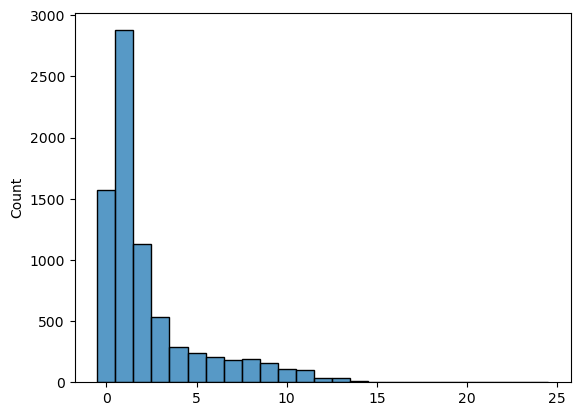

In [3]:
total_domains = 0
total_isoforms = 0
domain_type_counts = {}
isoforms_with_DNAbinding = 0
genes_with_DNAbinding = 0
geneList_DNAbinding = []
domain_counts = []
for gene_id in seqs:
    for prot_id in seqs[gene_id]:
        if not prot_id.startswith("ENS"):
            continue
        total_isoforms+=1
        domain_counts.append(0)
        for domain in seqs[gene_id][prot_id]["domains"]:
            if domain['type']!='SuperFamily':
                continue
            total_domains+=1
            domain_counts[-1]+=1
            if domain['description'] in domain_type_counts:
                domain_type_counts[domain['description']]+=1
            else:
                domain_type_counts[domain['description']]=1
        for domain in seqs[gene_id][prot_id]["domains"]:
            if domain['type']!='SuperFamily':
                continue
            if "DNA-binding" in domain['description']:
                isoforms_with_DNAbinding+=1
                break
    has_DNA = False
    for prot_id in seqs[gene_id]:
        if not prot_id.startswith("ENS"):
            continue
        for domain in seqs[gene_id][prot_id]["domains"]:
            if domain['type']!="SuperFamily":
                continue
            if "DNA-binding" in domain['description']:
                has_DNA = True
                break
    if has_DNA:
        genes_with_DNAbinding += 1
        geneList_DNAbinding.append(gene_id)
print(total_domains/total_isoforms)
sns.histplot(domain_counts, discrete=True);
#print(domain_type_counts)
print(isoforms_with_DNAbinding/total_isoforms)
print(genes_with_DNAbinding/len(seqs))

Identify a reference isoform for each gene, with priority given to:
 1. DNA binding domains
 2. Protein binding domains
 3. Transcription regulation domains
 4. Number of present domains

In [18]:
i=0
for gene_id in DNAbinding_seqs:
    domainCounts = {}
    
    for prot_id in DNAbinding_seqs[gene_id]:
        nDNAbind = 0
        nPPI = 0
        nTrans = 0
        nDomains = 0 
        for domain in DNAbinding_seqs[gene_id][prot_id]["consensus_domains"]:
            nDomains += 1
            if domain['class']=='DNA':
                nDNAbind += 1
            if domain['class']=='PPI':
                nPPI += 1
            if domain['class']=='TR':
                nTrans += 1
        domainCounts[prot_id] = [nDNAbind, nPPI, nTrans, nDomains]
    maxDNAbind = 0
    maxPPI = 0
    maxTrans = 0
    maxDomains = 0
    ref = ''
    for prot_id in domainCounts:
        if domainCounts[prot_id][0]>maxDNAbind:
            maxDNAbind = domainCounts[prot_id][0]
            ref = prot_id
            continue
        if domainCounts[prot_id][1]>maxPPI:
            maxPPI = domainCounts[prot_id][1]
            ref = prot_id
            continue
        if domainCounts[prot_id][2]>maxTrans:
            maxTrans = domainCounts[prot_id][2]
            ref = prot_id
            continue
        if domainCounts[prot_id][3]>maxDomains:
            maxDomains = domainCounts[prot_id][3]
            ref = prot_id
            continue
    DNAbinding_seqs[gene_id]['ref'] = ref

Identify the most common sources of domain information as a way to get a source priority list

In [7]:
types = {}
for gene_id in DNAbinding_seqs:
    for prot_id in DNAbinding_seqs[gene_id]:
        for domain in DNAbinding_seqs[gene_id][prot_id]['domains']:
            if not domain['type'] in types:
                types[domain['type']] = 1
            else:
                types[domain['type']] += 1
print([k for k, v in sorted(types.items(), key= lambda item:item[1], reverse=True)])

['MobiDBLite', 'Seg', 'sifts', 'PANTHER', 'Pfam', 'PRINTS', 'Gene3D', 'SuperFamily', 'Smart', 'Prosite_profiles', 'CDD', 'ncoils', 'Prosite_patterns', 'alphafold', 'PIRSF', 'TIGRfam', 'TMHMM', 'SignalP']


In [15]:
print(seqs[gene_id])
print([domain['description'] for domain in seqs["ENSG00000140987"]['ENSP00000483210']['domains']])

{'ENSP00000483210': {'seq': 'MAEGLWEQGFLRTPEQCRTKFKSLQLSYRKVRRGRVPEPCIFYEEMNALSGSWASAPPMASDAVPGQEGSDIEAGELNHQNGEPTEVEDGTVDGADRDEKDFRNPGQEVRKLDLPVLFPNRLGFEFKNEIKKENLKWDDSEEVEINKALQRKSRGVYWHSELQKGLESEPTSRRQCRNSPGESEEKTPSQEKMSHQSFCARDKACTHILCGKNCSQSVHSPHKPALKLEKVSQCPECGKTFSRSSYLVRHQRIHTGEKPHKCSECGKGFSERSNLTAHLRTHTGERPYQCGQCGKSFNQSSSLIVHQRTHTGEKPYQCIVCGKRFNNSSQFSAHRRIHTGESPYKCAVCGKIFNNSSHFSAHRKTHTGEKPYRCSHCERGFTKNSALTRHQTVHMKAVLSSQEGRDAL', 'domains': [{'end': 284, 'type': 'Gene3D', 'translation_id': 1145084, 'feature_type': 'protein_feature', 'seq_region_name': 'ENSP00000483210', 'align_type': None, 'id': '3.30.160.60', 'Parent': 'ENST00000618425', 'description': '', 'hit_start': 7, 'hit_end': 40, 'hseqname': '3.30.160.60', 'interpro': '', 'cigar_string': '', 'start': 257}, {'type': 'Gene3D', 'end': 256, 'translation_id': 1145084, 'feature_type': 'protein_feature', 'seq_region_name': 'ENSP00000483210', 'align_type': None, 'id': '3.30.160.60', 'description': '', 'Parent': 'ENST00000618425',

Write to fasta

In [6]:
#gene = 'ENSG00000001167'
#prot = 'ENSP00000345702'
for gene_id in seqs:
    for prot_id in seqs[gene_id]:
        with open("fastas/"+prot_id+".fa", "w") as f:
            f.write(">" + prot_id + "\n")
            f.write(seqs[gene_id][prot_id]['seq'])